In [781]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import itertools
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [782]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте **bias-variance trade-off** для `DecisionTreeRegressor` при изменении глубины дерева. 

Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). 

Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

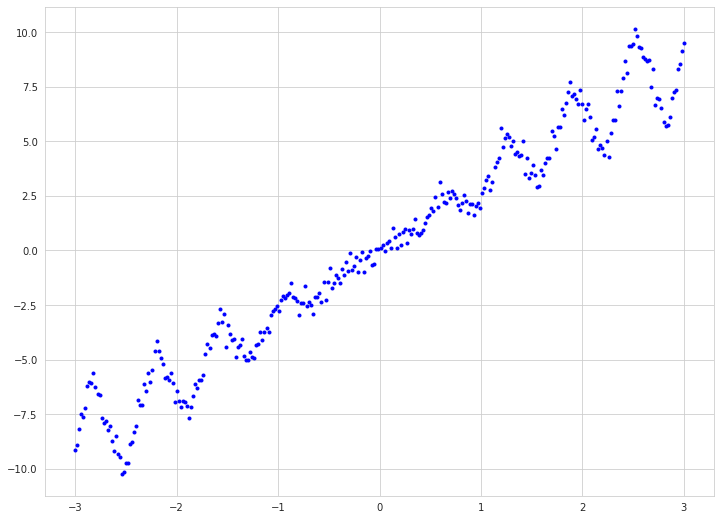

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [115]:
def plot_regression_predictions(max_depth, X, y, axes=[-3, 3, -10, 10], ylabel="$y$", h=5, g=3, figsize=[20,30]):

    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    fig, ax = plt.subplots(h, g, figsize=figsize)

    for i, depth in enumerate(max_depth):
        axs=ax.flatten()[i]

        tree_reg = DecisionTreeRegressor(max_depth=depth)
        tree_reg.fit(X, y)
        y_pred = tree_reg.predict(x1)

        #plt.axis(axes)
        axs.set_title(f'max_depth {depth}')
        axs.set_xlabel("$x_1$", fontsize=18)

        if ylabel:
            axs.set_ylabel(ylabel, fontsize=18, rotation=0)

        axs.plot(X.reshape(-1), y.reshape(-1), "r.", alpha=0.4)
        axs.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")
    
    plt.show()

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

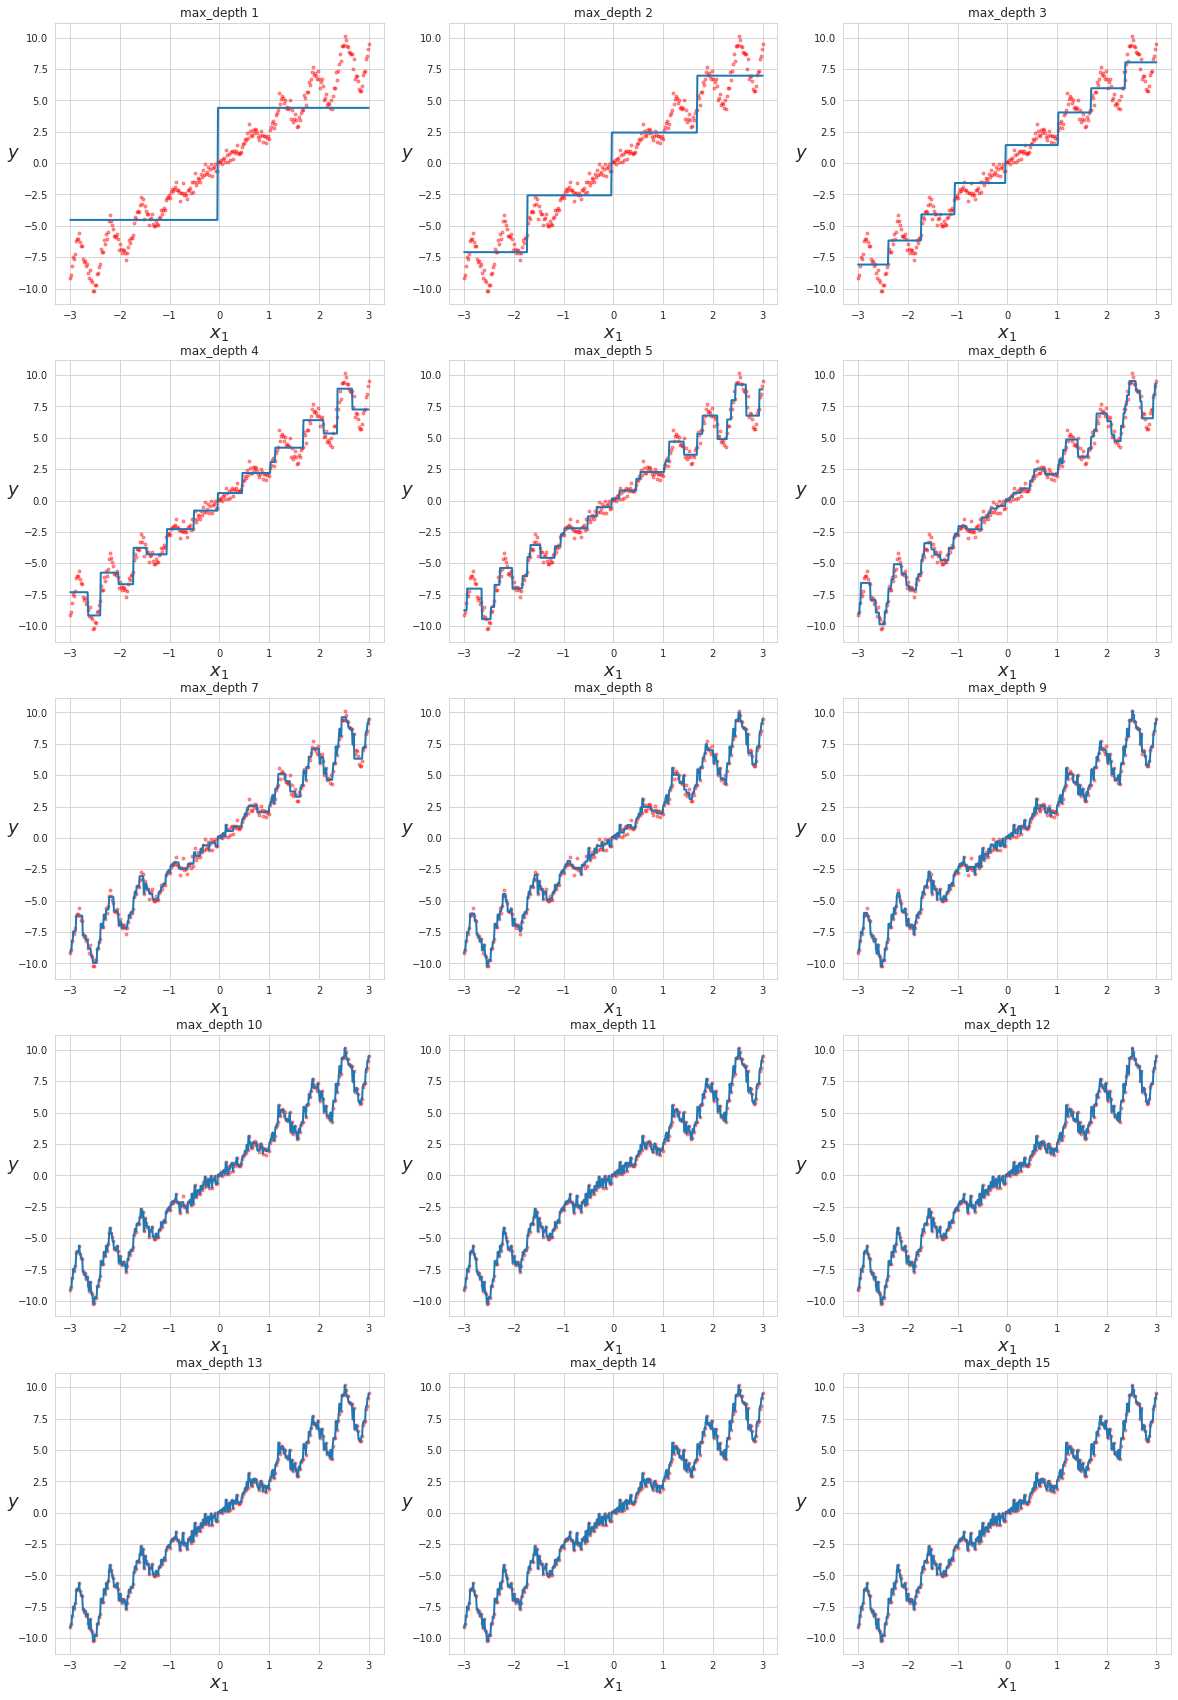

In [116]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

max_depth = list(range(1, 16))

plot_regression_predictions(max_depth, X, y)


При низком max_depth (от 1 до 5) высокий Bias. С 9 до 15 max_depth - начинает быть высоким variance (модель начинает реагироать на шум в данных). max_depth 7-8 более менее.

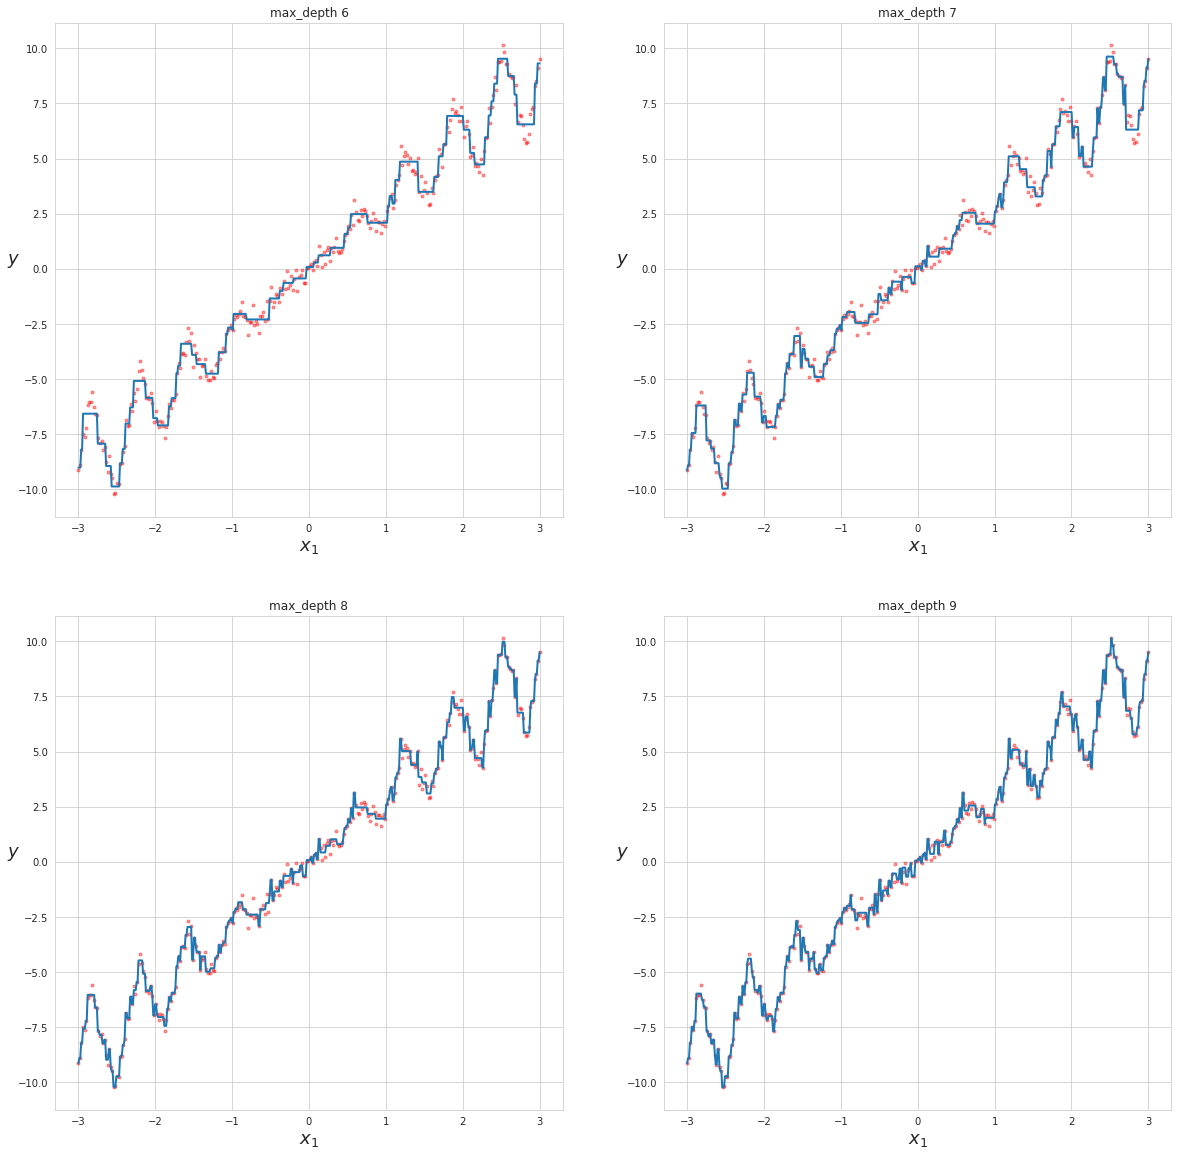

In [118]:
max_depth = list(range(6, 10))

plot_regression_predictions(max_depth, X, y, h=2, g=2, figsize=[20,20])

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2.1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

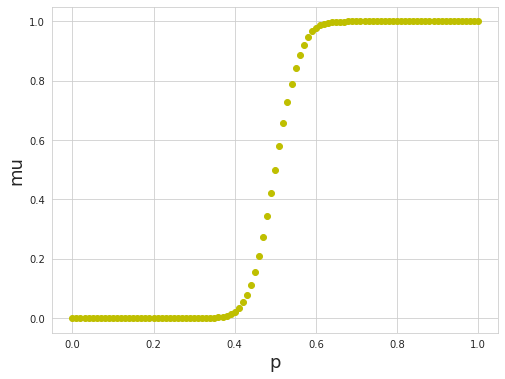

In [215]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
classificators = list(range(51,102))

p = list(np.arange(0, 1.01, 0.01))
mu = [np.sum([math.comb(101, i) * p_i ** i * (1 - p_i)**(101-i) for i in classificators]) for p_i in p]

plt.figure(figsize=(8, 6))
plt.plot(p, mu, "yo")
plt.xlabel('p', fontsize=18)
plt.ylabel('mu', fontsize=18)
plt.show()
plt.close()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

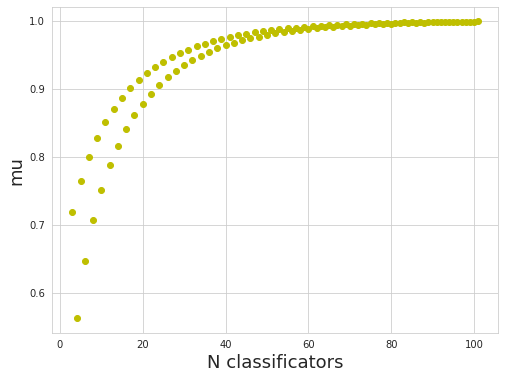

In [231]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

classificators = list(range(3, 102))

mu = [np.sum([comb(n, i) * 0.65 ** i * (1 - 0.65)**(n - i) for i in list(range(n // 2 + 1, n + 1))]) for n in classificators]

plt.figure(figsize=(8, 6))
plt.plot(classificators, mu, "yo")
plt.xlabel('N classificators', fontsize=18)
plt.ylabel('mu', fontsize=18)
plt.show()


Опишите ваши наблюдения:

* в первом случае если каждый классификатор предсказывает правильно хотябы с вероятность 60%, то при 101 классификаторе это приводит к почти 100% правильности предсказаний.
* во втором случае, при числе классификаторов выше 60 вероятность правильно классифицировать объект почти 100% при вероятности правильно предсказать для каждого классификатора 0.65. Нечетное число классификаторов дает лучший результат, чем четное (?).

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [472]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(0, self.n_estimators):            
            np.random.seed(self.random_state + i)
            self.feat_ids_by_tree.append(random.sample(range(X.shape[1]), self.max_features))

            indexes = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
            
            pseudo_X = X[indexes, :][:, self.feat_ids_by_tree[i]]
            pseudo_y = y[indexes]
            
            model = DecisionTreeClassifier(max_depth=self.max_depth, 
                                           max_features=self.max_features,
                                           random_state=self.random_state)
            model.fit(pseudo_X, pseudo_y)
            self.trees.append(model)
            
        return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        proba = np.empty(shape=(X.shape[0], len(self.trees)))
        for i, tree in enumerate(self.trees):
            proba[:, i] = tree.predict(X[:, self.feat_ids_by_tree[i]])
        return proba
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.mean(probas, axis=1)
        predictions = np.where(predictions > 0.5, 1, 0)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [473]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

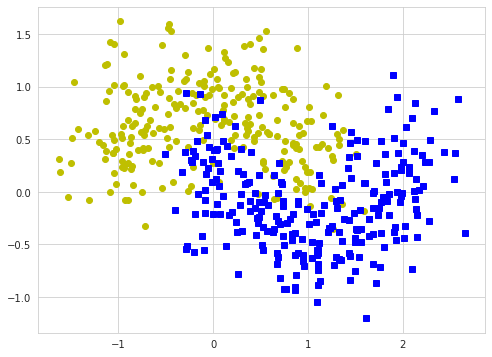

In [474]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [475]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [476]:
model = RandomForestClassifierCustom(n_estimators=10, max_depth=5, max_features=2)
model.fit(X, y)
y_pred_prob = model.predict(X)

In [477]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

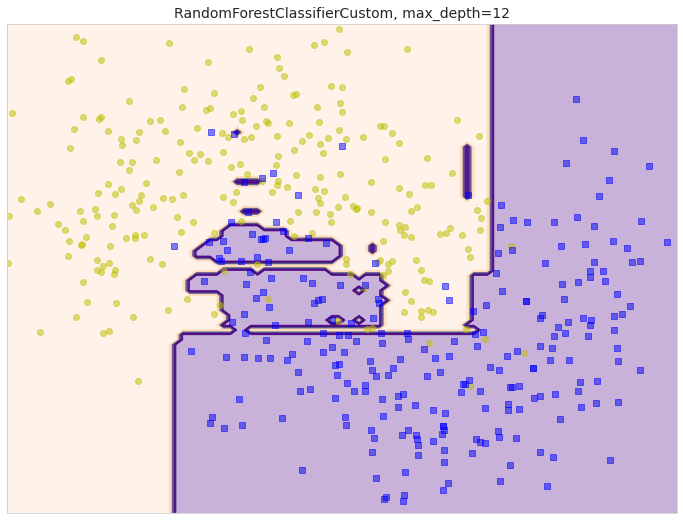

In [478]:
rf = RandomForestClassifierCustom(max_depth=15, n_estimators=100, max_features=2)

rf.fit(X_train, y_train)

plot_decision_boundary(rf, X, y)
plt.title("RandomForestClassifierCustom, max_depth=12", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], []);

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

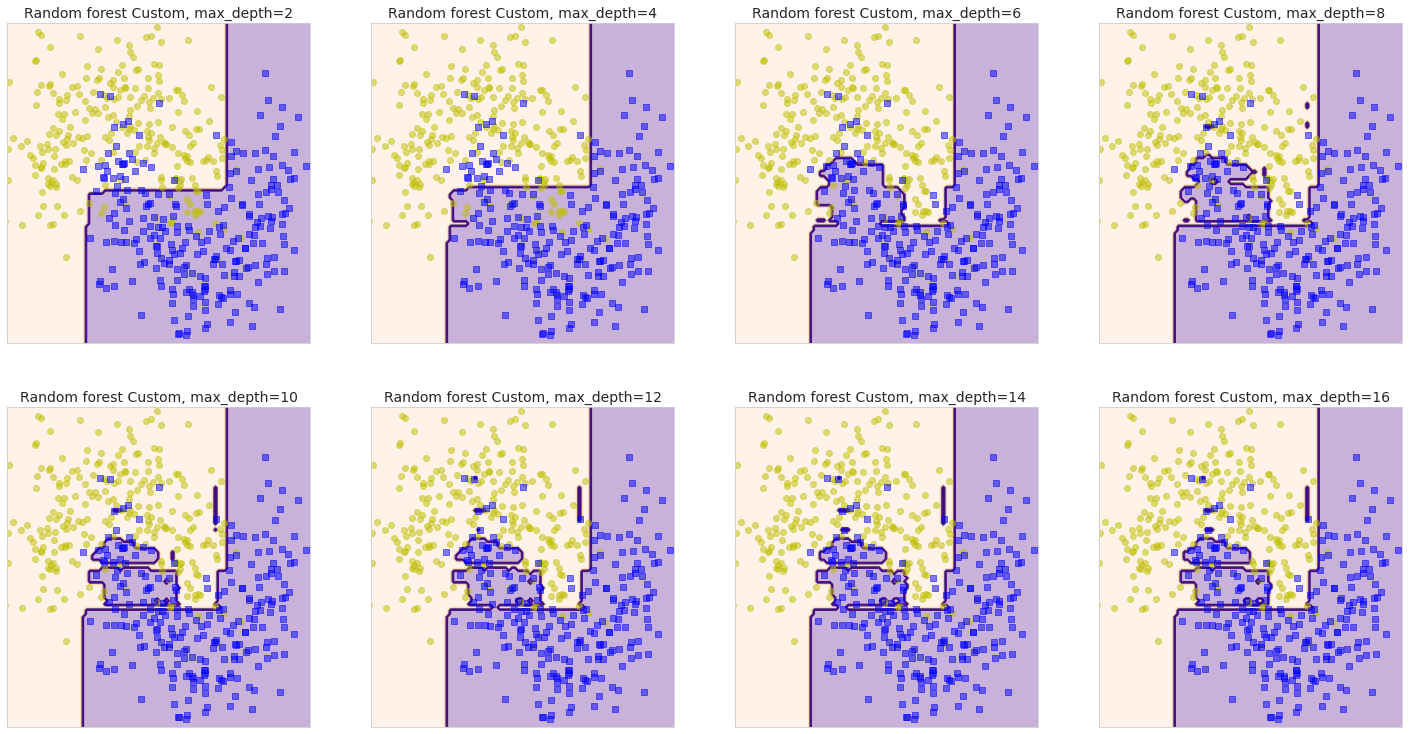

In [521]:
plt.figure(figsize=(25,20))

for i, depth in enumerate(range(2, 18, 2)):
    plt.subplot(341 + i)
    rf = RandomForestClassifierCustom(max_depth=depth, n_estimators=100, max_features=2)
    rf.fit(X_train, y_train)
    plot_decision_boundary(rf, X, y)
    plt.title(f"Random forest Custom, max_depth={depth}", fontsize=14)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([], [])
    plt.yticks([], [])


In [532]:
from sklearn.model_selection import GridSearchCV

dt_model = GridSearchCV(RandomForestClassifierCustom(), 
                          {"max_depth": list(range(1,15)),
                           'n_estimators': [100, 200, 300, 400, 500],
                           'max_features': [1, 2]},
                        scoring='f1', cv=5, n_jobs=2
                        ).fit(X_train, y_train)

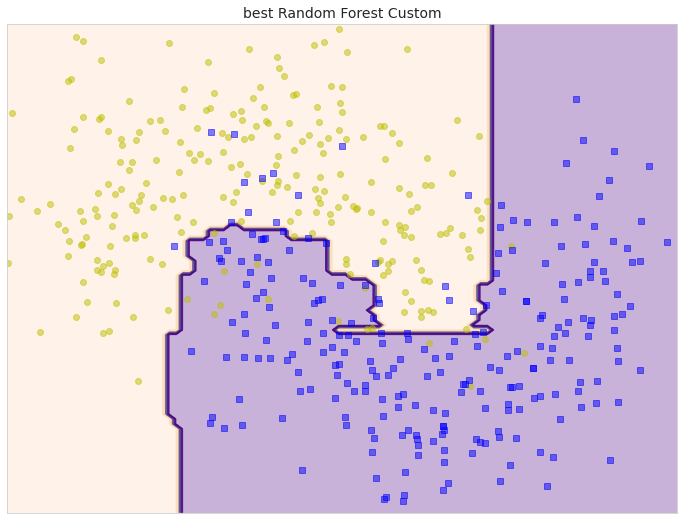

In [533]:
best_rf = dt_model.best_estimator_

best_rf.fit(X_train, y_train)

plot_decision_boundary(best_rf, X, y)
plt.title("best Random Forest Custom", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], []);

In [534]:
dt_model.best_params_

{'max_depth': 5, 'max_features': 2, 'n_estimators': 100}

In [535]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = best_rf.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

accuracy_score:	0.904
precision_score:0.903
recall_score: 	0.903
f1_score: 	0.903


#### Задание 2.3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. 

Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`.
В качестве примера будем использовать датасет `breast_cancer`. 

Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. 

Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [539]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [544]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [571]:
max_features_list = list(range(1, X.shape[1] + 1))
max_features_dict = {}

for max_features in max_features_list:
    
    clf = RandomForestClassifier(n_estimators=200, max_features=max_features)
    clf.fit(X_train, y_train)

    max_features_dict[f"max_features={max_features}"] = base_model_pair_correlation(clf, X)
    

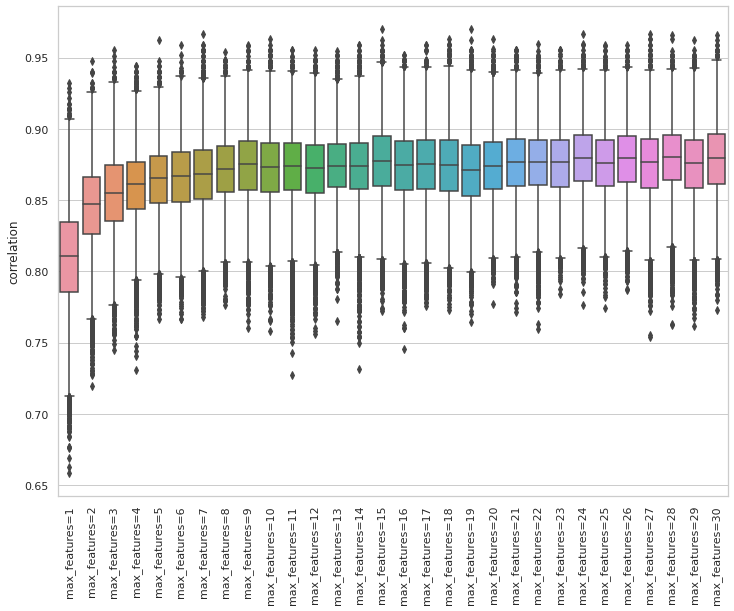

In [572]:
df_f = pd.DataFrame.from_dict(max_features_dict)

sns.boxplot(data=df_f)
plt.xticks(rotation=90)
plt.ylabel('correlation')
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [575]:
max_depth_list = list(range(1, 40, 2))
max_depth_dict = {}

for max_depth in max_depth_list:
    
    clf = RandomForestClassifier(n_estimators=200, max_features=2, max_depth=max_depth)
    clf.fit(X_train, y_train)

    max_depth_dict[f"max_depth={max_depth}"] = base_model_pair_correlation(clf, X)
    

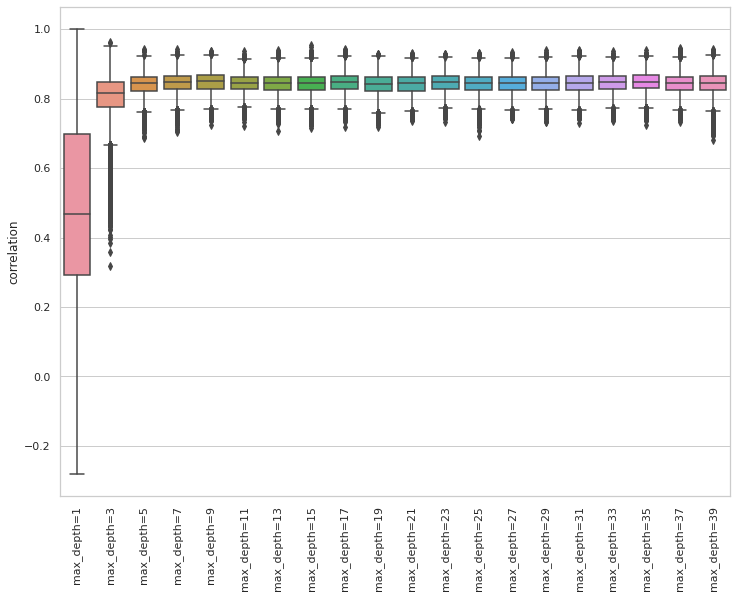

In [576]:
df_d = pd.DataFrame.from_dict(max_depth_dict)

sns.boxplot(data=df_d)
plt.xticks(rotation=90)
plt.ylabel('correlation')
plt.show()

Опишите ваши наблюдения:

* чем меньше max_features, тем ниже корреляция между деревьями - тем лучше. Даже если 30 фич, лучше использовать 2 для этого датасета?
* глубина 1 дает слишком сильных размах значений корреляций, чуть меньше - глубина 3. Дальше на скоррелированность деревьев глубина дерева не влияет.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за эксперименты и максимально высокий скор**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/ronitf/heart-disease-uci).

In [754]:
!gdown 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O ../data_folder/heart.csv -q
heart_dataset = pd.read_csv("../data_folder/heart.csv")

In [755]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
178   43    1   0       120   177    0        0      120      1      2.5   
298   57    0   0       140   241    0        1      123      1      0.2   
201   60    1   0       125   258    0        0      141      1      2.8   
246   56    0   0       134   409    0        0      150      1      1.9   
153   66    0   2       146   278    0        0      152      0      0.0   

     slope  ca  thal  
178      1   0     3  
298      1   0     3  
201      1   1     3  
246      1   2     3  
153      1   1     2

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [584]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [585]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')

dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
cat.fit(X_train, y_train)
etc.fit(X_train, y_train)
knn.fit(X_train, y_train)
svc_lin.fit(X_train, y_train)
svc_rbf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
xgb_rf.fit(X_train, y_train)
lgbm_rf.fit(X_train, y_train)
lr.fit(X_train, y_train)
nb.fit(X_train, y_train)
voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

[17:37:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:37:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:37:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:37:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. 

Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`.

**Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [590]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]

    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [596]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
correlations = base_model_pair_correlation_for_voting_clf(voting_soft, X_train)

sorted(correlations, key=lambda x: x[-1], reverse=True)

[(ExtraTreesClassifier(random_state=111),
  KNeighborsClassifier(weights='distance'),
  0.9999999999999999),
 (ExtraTreesClassifier(random_state=111),
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
                gamma=0, gpu_id=-1, importance_type=None,
                interaction_constraints='', learning_rate=0.300000012,
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=8,
                num_parallel_tree=1, predictor='auto', random_state=111,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                tree_method='exact', validate_parameters=1, verbosity=None),
  0.9968823812305813),
 (KNeighborsClassifier(weights='distance'),
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree

In [681]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
#etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()


# best model
base_models = [("DT", dt), ("RF", rf), 
               ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

voting_soft = VotingClassifier(estimators=subset, voting = 'soft')
voting_soft.fit(X_train, y_train)
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{model.__class__.__name__}: {scores.mean()}")

[21:32:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [688]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
correlations = base_model_pair_correlation_for_voting_clf(voting_soft, X_train)

sorted(correlations, key=lambda x: x[-1], reverse=True)

[(RandomForestClassifier(n_estimators=50, random_state=111),
  LGBMClassifier(random_state=111),
  0.9896757313382182),
 (RandomForestClassifier(n_estimators=50, random_state=111),
  XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bytree=1, enable_categorical=False, gamma=0,
                  gpu_id=-1, importance_type=None, interaction_constraints='',
                  max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                  monotone_constraints='()', n_estimators=100, n_jobs=8,
                  num_parallel_tree=100, objective='binary:logistic',
                  predictor='auto', random_state=111, reg_alpha=0,
                  scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                  verbosity=None),
  0.9640270483865033),
 (LGBMClassifier(random_state=111),
  XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bytree=1, enable_categori

In [689]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
#rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
#etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()


# best model
base_models = [("DT", dt), ("RF", rf), 
               ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(X_train, y_train)
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{model.__class__.__name__}: {scores.mean()}")

[21:34:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [666]:
'''
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

'''

def dt():
    return DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)

def rf():
    return RandomForestClassifier(n_estimators=50, random_state=SEED)

def knn():
    return KNeighborsClassifier(n_neighbors=5, weights="distance")

def etc():
    return ExtraTreesClassifier(random_state=SEED)

def svc_lin():
    return SVC(kernel='linear', probability=True, random_state=SEED)

def svc_rbf():
    return SVC(kernel='rbf', probability=True, random_state=SEED)

def cat():
    return catboost.CatBoostClassifier(verbose=0, random_seed=SEED)

def lgbm():
    return lightgbm.LGBMClassifier(random_state=SEED)

def lgbm_rf():
    return lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)

def xgb():
    return xgboost.XGBClassifier(random_state=SEED)

def xgb_rf():
    return xgboost.XGBRFClassifier(random_state=SEED)

def lr():
    return LogisticRegression(solver='liblinear', max_iter=10000)

def nb():
    return GaussianNB()


base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

In [667]:
subsets = []

for L in range(1, len(base_models)+1):
    for subset in itertools.combinations(base_models, L):
        subsets.append(subset)

In [668]:
# больше 8 тыс комбинаций :)

In [669]:
import logging

logging.basicConfig(level=logging.ERROR)

In [670]:
import time

results = []

for i, subset in enumerate(subsets):

    subset = [(name, f()) for name, f in subset]
    voting_soft = VotingClassifier(estimators=subset, voting = 'soft')
    voting_soft.fit(X_train, y_train)
    scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    results.append([subset, scores.mean()])
    print(f'{time.time()}: {i}/{len(subsets)} classifiers: {len(subset)}')

1647197904.8330529: 0/8191 classifiers: 1
1647197905.1189294: 1/8191 classifiers: 1
1647197905.4792478: 2/8191 classifiers: 1
1647197905.4975932: 3/8191 classifiers: 1
1647197907.879116: 4/8191 classifiers: 1
1647197907.9207036: 5/8191 classifiers: 1
1647197911.0587142: 6/8191 classifiers: 1
1647197911.2448492: 7/8191 classifiers: 1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: baggi

1647197933.0692937: 32/8191 classifiers: 2
[19:58:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:58:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:58:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:58:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval

[19:59:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:59:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:59:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:59:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:00:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:00:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:00:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198015.7549875: 77/8191 classifiers: 2
[20:00:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval

[20:00:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198021.4538057: 85/8191 classifiers: 2
[20:00:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:00:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:00:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval

[20:00:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:00:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:00:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:00:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

1647198082.9915452: 127/8191 classifiers: 3
1647198086.1468587: 128/8191 classifiers: 3
1647198089.425694: 129/8191 classifiers: 3
1647198089.7686663: 130/8191 classifiers: 3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1647198089.951552: 131/8191 classifiers: 3
[20:01:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used w

[20:01:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:01:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:01:58] WARNING: ../src/learner.cc:1115: St

[20:02:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198124.4183109: 153/8191 classifiers: 3
[20:02:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:02:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:02:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[20:02:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198149.79825: 173/8191 classifiers: 3
1647198150.0725935: 174/8191 classifiers: 3
1647198150.3538618: 175/8191 classifiers: 3
1647198153.4411266: 176/8191 classifiers: 3
1647198159.6822581: 177/8191 classifiers: 3
1647198163.4808524: 178/8191 classifiers: 3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fractio

[20:03:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:03:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:03:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:03:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:04:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:04:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:04:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:04:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:04:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:04:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:04:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198264.1079946: 218/8191 classifiers: 3
1647198264.5405352: 219/8191 classifiers: 3
1647198264.9392362: 220/8191 classifiers: 3
1647198268.8854566: 221/8191 classifiers: 3
1647198276.9241624: 222/8191 classifiers: 3
1647198280.857711: 223/8

[20:05:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198317.6277525: 238/8191 classifiers: 3
[20:05:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1647198330.0527158: 250/8191 classifiers: 3
[20:05:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to r

[20:05:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:06:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:06:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198373.4961023: 280/8191 classifiers: 3
1647198373.6112912: 281/8191 classifiers: 3
1647198373.708765: 282/8191 classifiers: 3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:06:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logisti

[20:06:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198377.049453: 288/8191 classifiers: 3
[20:06:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:06:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:06:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval

[20:06:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:06:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:06:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:06:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:07:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:07:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:07:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:07:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:07:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:07:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:07:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198473.0690517: 324/8191 classifiers: 3
1647198475.4497218: 325/8191 classifiers: 3
1647198477.8708763: 326/8191 classifiers: 3
1647198478.0973756: 327/8191 classifiers: 3
[20:07:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.

[20:08:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:08:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:08:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:08:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

1647198497.9100907: 345/8191 classifiers: 3
1647198500.2358415: 346/8191 classifiers: 3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:08:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:08:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will 

[20:08:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:08:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:08:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198521.793275: 353/8191 classifiers: 3
[20:08:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval

1647198534.1352065: 362/8191 classifiers: 3
[20:08:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:08:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:08:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:08:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:08:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:09:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198540.462132: 369/8191 classifiers: 3
[Li

[20:09:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:09:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:09:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198544.0664897: 374/8191 classifiers: 3
[20:09:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[20:09:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:09:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:09:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198565.1989622: 393/8191 classifiers: 4
1647198565.4744735: 394/8191 classifiers: 4
1647198565.7297807: 395/8191 classifiers: 4
1647198568.3722987: 396/8191 classifiers: 4
1647198573.2184386: 397/8191 classifiers: 4
1647198575.9649913: 398/

[20:10:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198605.4992824: 413/8191 classifiers: 4
[20:10:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1647198621.4787931: 425/8191 classifiers: 4
[20:10:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[2

[20:10:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198640.1058426: 437/8191 classifiers: 4
[20:10:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1647198680.7769418: 457/8191 classifiers: 4
[20:11:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:11:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:11:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to r

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1647198702.0018573: 469/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsam

[20:12:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:12:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:12:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:12:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:12:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:12:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:12:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198752.8636553: 499/8191 classifiers: 4
[20:12:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[20:12:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198758.519096: 507/8191 classifiers: 4
[20:12:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:12:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:12:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval

[20:13:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:13:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:13:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:13:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1647198835.6861272: 533/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1647198838.0668383: 534/8191 classifiers: 4
[20:13:58] W

[20:14:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:14:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:14:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198862.9825404: 543/8191 classifiers: 4
[20:14:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

1647198875.5901296: 554/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1647198875.7373164: 555/8191 classifiers: 4
[20:14:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the

[20:14:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:14:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:14:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198888.7805164: 564/8191 classifiers: 4
1647198891.2523575: 565/8191 classifiers: 4
1647198893.7060108: 566/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction

[20:15:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198917.1090972: 572/8191 classifiers: 4
[20:15:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[20:15:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198935.3631167: 582/8191 classifiers: 4
[20:15:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

1647198940.763628: 588/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:15:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20

[20:15:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:16:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:16:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647198975.8154585: 610/8191 classifiers: 4
[20:16:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:16:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[20:16:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199016.0279384: 628/8191 classifiers: 4
[20:16:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:16:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:16:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

1647199025.326477: 636/8191 classifiers: 4
[20:17:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval

[20:17:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199059.7668297: 653/8191 classifiers: 4
[20:17:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:18:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199085.220143: 668/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:18:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20

[20:18:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199090.5258307: 675/8191 classifiers: 4
[20:18:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[20:19:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:19:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:19:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:19:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:19:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:19:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:19:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199173.6399593: 701/8191 classifiers: 4
[20:19:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[20:20:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199202.7362227: 714/8191 classifiers: 4
1647199203.1175961: 715/8191 classifiers: 4
1647199203.4721928: 716/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction

[20:20:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199208.5015695: 722/8191 classifiers: 4
[20:20:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:20:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:20:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199234.0825448: 733/8191 classifiers: 4
[L

[20:20:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199256.0507796: 740/8191 classifiers: 4
1647199258.535446: 741/8191 classifiers: 4
[20:20:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed fr

[20:21:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199266.94438: 750/8191 classifiers: 4
1647199267.3516862: 751/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:21:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Exp

[20:21:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:21:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning

1647199279.749841: 762/8191 classifiers: 4
1647199284.890572: 763/8191 classifiers: 4
1647199287.702532: 764/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1647199290.4086974: 765/8191 classifiers: 4
[20:21:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was chang

[20:22:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199321.8582237: 780/8191 classifiers: 4
1647199324.4879181: 781/8191 classifiers: 4
1647199327.0223925: 782/8191 classifiers: 4
1647199327.5569134: 783/8191 classifiers: 4
[20:22:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.

[20:22:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:22:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199356.8015106: 802/8191 classifiers: 4
1647199359.4526124: 803/8191 classifiers: 4
1647199362.1184878: 804/8191 classifiers: 4
1647199366.6260304: 805/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[Ligh

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:23:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199415.2905142: 817/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_

1647199440.3170156: 825/8191 classifiers: 4
1647199443.0205696: 826/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1647199445.7438076: 827/8191 classifiers: 4
[20:24:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly 

[20:24:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199465.3165617: 838/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1647199465.8053799: 839/8191 

[20:24:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199479.4248822: 848/8191 classifiers: 4
[20:24:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[20:25:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199505.0868027: 856/8191 classifiers: 4
[20:25:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[20:25:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199525.8596632: 866/8191 classifiers: 4
[20:25:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[20:25:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:25:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:25:34] WARNING: ../src/learner.cc:1115: St

[20:25:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199540.7479396: 878/8191 classifiers: 4
[20:25:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1647199572.9885461: 890/8191 classifiers: 4
[20:26:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[2

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1647199616.6648226: 902/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsam

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1647199643.3630288: 911/8191 classifiers: 4
[20:27:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to r

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1647199658.263592: 923/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsamp

[20:27:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199668.8774643: 932/8191 classifiers: 4
[20:27:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[20:28:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:28:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199716.2502577: 950/8191 classifiers: 4
[20:28:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:28:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199723.2624414: 957/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:28:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[2

[20:28:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:29:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647199873.0017614: 974/8191 classifiers: 4
1647199884.8979983: 975/8191 classifiers: 4
1647199887.4892511: 976/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction

[20:48:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:49:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647200943.7854953: 982/8191 classifiers: 4
[20:49:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:49:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:49:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:49:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647200991.3269522: 993/8191 classifiers: 4
[L

[20:50:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647201027.3234475: 1000/8191 classifiers: 4
1647201031.993695: 1001/8191 classifiers: 4
[20:50:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:50:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:50:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed 

[20:50:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:50:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647201059.803559: 1010/8191 classifiers: 4
1647201062.3554428: 1011/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:51:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. 

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:51:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:51:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:51:20] WARNING: ../src/learner.cc:1115: St

[20:51:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647201097.0533316: 1021/8191 classifiers: 4
1647201100.0713406: 1022/8191 classifiers: 4
[20:51:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:51:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:51:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed

[20:52:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:52:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:52:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:52:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:52:34] WARNING: ../src/learner.cc:1115: St

[20:52:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647201158.8006687: 1053/8191 classifiers: 4
[20:52:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set ev

[20:52:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647201176.979926: 1061/8191 classifiers: 4
[20:52:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[20:53:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:53:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:53:30] WARNING: ../src/learner.cc:1115: St

[20:53:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:53:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:53:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647201227.4253829: 1073/8191 classifiers: 4
[20:53:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set ev

[20:54:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:54:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:54:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647201243.371098: 1079/8191 classifiers: 4
[20:54:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[20:54:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:54:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:54:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647201251.2937891: 1086/8191 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curr

[20:54:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:54:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[20:54:16] WARNING: ../src/learner.cc:1115: St

[21:04:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:04:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:04:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:05:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[21:10:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:10:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:10:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:10:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[21:11:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:11:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:11:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647202262.8989253: 1132/8191 classifiers: 5
[21:11:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set ev

[21:11:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:11:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647202297.968871: 1148/8191 classifiers: 5
[21:11:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:11:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

1647202322.052675: 1163/8191 classifiers: 5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[21:12:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:12:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[2

[21:12:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:12:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:12:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:12:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[21:13:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647202396.2603676: 1188/8191 classifiers: 5
1647202399.0329494: 1189/8191 classifiers: 5
1647202401.845859: 1190/8191 classifiers: 5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fracti

[21:13:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647202422.0066688: 1196/8191 classifiers: 5
[21:13:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set ev

[21:14:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647202455.0548244: 1209/8191 classifiers: 5
1647202455.443082: 1210/8191 classifiers: 5
1647202455.808545: 1211/8191 classifiers: 5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[21:14:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logis

1647202461.1291883: 1217/8191 classifiers: 5
[21:14:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set ev

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[21:14:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1647202485.5227482: 1228/8191 classifiers: 5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging

1647202510.9589958: 1236/8191 classifiers: 5
[21:16:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:17:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:19:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:21:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set ev

KeyboardInterrupt: 

....loooong run.....


1647197904.8330529 time
1647201388.951537

In [671]:
sorted(results, key=lambda x: x[-1], reverse=True)

[[[('CAT', <catboost.core.CatBoostClassifier at 0x7ff247f828f0>),
   ('LR', LogisticRegression(max_iter=10000, solver='liblinear'))],
  0.8694543828264759],
 [[('ETC', ExtraTreesClassifier(random_state=111)),
   ('SVC_LIN', SVC(kernel='linear', probability=True, random_state=111)),
   ('CAT', <catboost.core.CatBoostClassifier at 0x7ff1f5a22230>),
   ('LGBM_RF',
    LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',
                   random_state=111))],
  0.8687728937728938],
 [[('ETC', ExtraTreesClassifier(random_state=111)),
   ('CAT', <catboost.core.CatBoostClassifier at 0x7ff1b414d960>),
   ('LGBM_RF',
    LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',
                   random_state=111)),
   ('XGB_RF',
    XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,
                    colsample_bytree=None, enable_categorical=False, gamma=None,
                    gpu_id=None, importance_type=None, interaction_constraint

In [678]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()


# best score model
base_models = [("CAT", cat), ("LR", lr)]


#base_models = [("DT", dt), ("RF", rf), 
#               ("ETC", etc), ("KNN", knn), 
#               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
#               ("CAT", cat), ("LGBM", lgbm), 
#               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
#               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(X_train, y_train)
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")

VotingClassifier: 0.8694543828264759


In [679]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()


# best score model
base_models = [("DT", dt), ("ETC", etc),
               ("CAT", cat), ("LGBM", lgbm), 
               ("LR", lr)]


#base_models = [("DT", dt), ("RF", rf), 
#               ("ETC", etc), ("KNN", knn), 
#               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
#               ("CAT", cat), ("LGBM", lgbm), 
#               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
#               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(X_train, y_train)
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")

VotingClassifier: 0.8704208031644359


In [757]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()


# best score model
base_models = [("DT", dt),
               ("ETC", etc), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LR", lr)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(X_train, y_train)
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")

VotingClassifier: 0.8704208031644359


### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [783]:
data = pd.read_csv("../data_folder/churn.csv")
data.head()

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ Calls  Churn?  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.  

[5 rows x 21 columns]

#### 3.1. EDA

In [784]:
data.describe()

Account Length    Area Code  VMail Message     Day Mins    Day Calls  \
count     3333.000000  3333.000000    3333.000000  3333.000000  3333.000000   
mean       101.064806   437.182418       8.099010   179.775098   100.435644   
std         39.822106    42.371290      13.688365    54.467389    20.069084   
min          1.000000   408.000000       0.000000     0.000000     0.000000   
25%         74.000000   408.000000       0.000000   143.700000    87.000000   
50%        101.000000   415.000000       0.000000   179.400000   101.000000   
75%        127.000000   510.000000      20.000000   216.400000   114.000000   
max        243.000000   510.000000      51.000000   350.800000   165.000000   

        Day Charge     Eve Mins    Eve Calls   Eve Charge   Night Mins  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean     30.562307   200.980348   100.114311    17.083540   200.872037   
std       9.259435    50.713844    19.922625     4.310668    50.573847   
min       0.000000     0.000000     0.000000     0.000000    23.200000   
25%      24.430000   166.600000    87.000000    14.160000   167.000000   
50%      30.500000   201.400000   100.000000    17.120000   201.200000   
75%      36.790000   235.300000   114.000000    20.000000   235.300000   
max      59.640000   363.700000   170.000000    30.910000   395.000000   

       Night Calls  Night Charge    Intl Mins   Intl Calls  Intl Charge  \
count  3333.000000   3333.000000  3333.000000  3333.000000  3333.000000   
mean    100.107711      9.039325    10.237294     4.479448     2.764581   
std      19.568609      2.275873     2.791840     2.461214     0.753773   
min      33.000000      1.040000     0.000000     0.000000     0.000000   
25%      87.000000      7.520000     8.500000     3.000000     2.300000   
50%     100.000000      9.050000    10.300000     4.000000     2.780000   
75%     113.000000     10.590000    12.100000     6.000000     3.270000   
max     175.000000     17.770000    20.000000    20.000000     5.400000   

       CustServ Calls  
count     3333.000000  
mean         1.562856  
std          1.315491  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          2.000000  
max          9.000000

In [785]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [786]:
data["Churn?"].value_counts()

# классы не сбалансированны

False.    2850
True.      483
Name: Churn?, dtype: int64

Переведем Int'l Plan, VMail Plan, Churn?  в бинарный формат.

In [787]:
data["Int'l Plan"] = data["Int'l Plan"].map({'yes': 1, 'no': 0})
data["VMail Plan"] = data['VMail Plan'].map({'yes': 1, 'no': 0})
data["Churn?"] = data['Churn?'].map({'True.': 1, 'False.': 0})

In [788]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   int64  
 5   VMail Plan      3333 non-null   int64  
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [789]:
data.isnull().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

<AxesSubplot:>

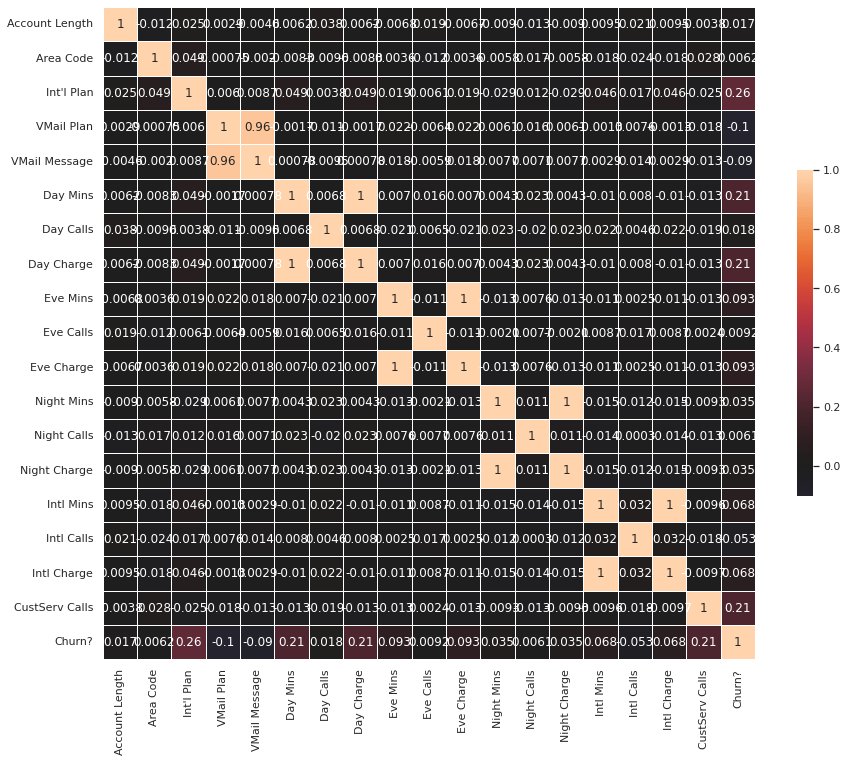

In [790]:
corr = data.corr()

f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

Присутствует сильно скоррелированные признаки. Уберем это.

Phone не дает нам никакой информации - там только уникальные значения.

In [791]:
# удаляем колонки
data_droped = data.drop(["Phone", 'VMail Message', 'Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)

<AxesSubplot:>

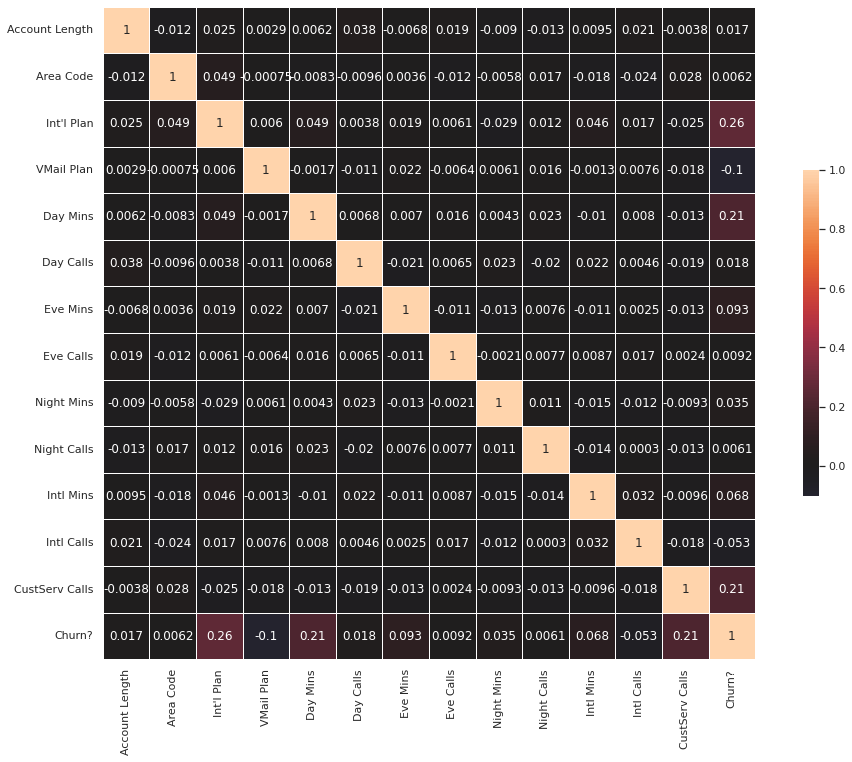

In [792]:
corr = data_droped.corr()

f, ax = plt.subplots(figsize=(17, 12))
sns.heatmap(corr, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

In [793]:
data_droped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Int'l Plan      3333 non-null   int64  
 4   VMail Plan      3333 non-null   int64  
 5   Day Mins        3333 non-null   float64
 6   Day Calls       3333 non-null   int64  
 7   Eve Mins        3333 non-null   float64
 8   Eve Calls       3333 non-null   int64  
 9   Night Mins      3333 non-null   float64
 10  Night Calls     3333 non-null   int64  
 11  Intl Mins       3333 non-null   float64
 12  Intl Calls      3333 non-null   int64  
 13  CustServ Calls  3333 non-null   int64  
 14  Churn?          3333 non-null   int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 390.7+ KB


Проверим связан ли Area Code с State

In [794]:
from sklearn.preprocessing import LabelEncoder

In [795]:
le_data = data_droped.copy()

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
le_data['State'] = labelencoder.fit_transform(le_data['State'])

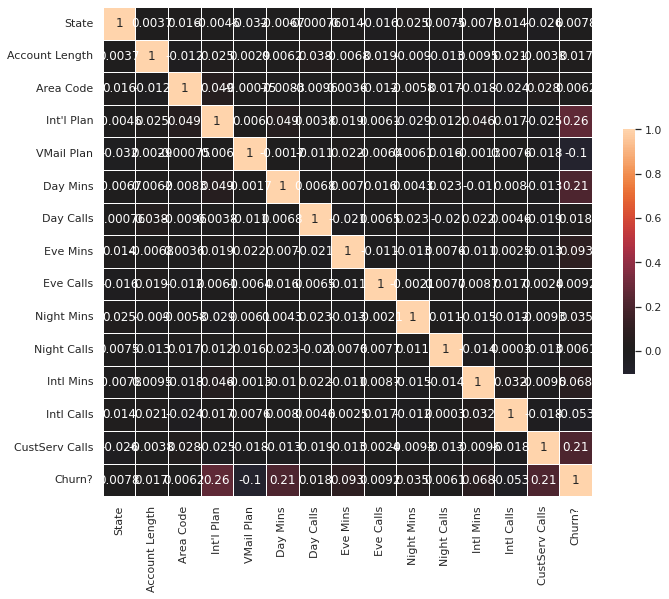

In [796]:
# не связан.

corr = le_data.corr()

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True);

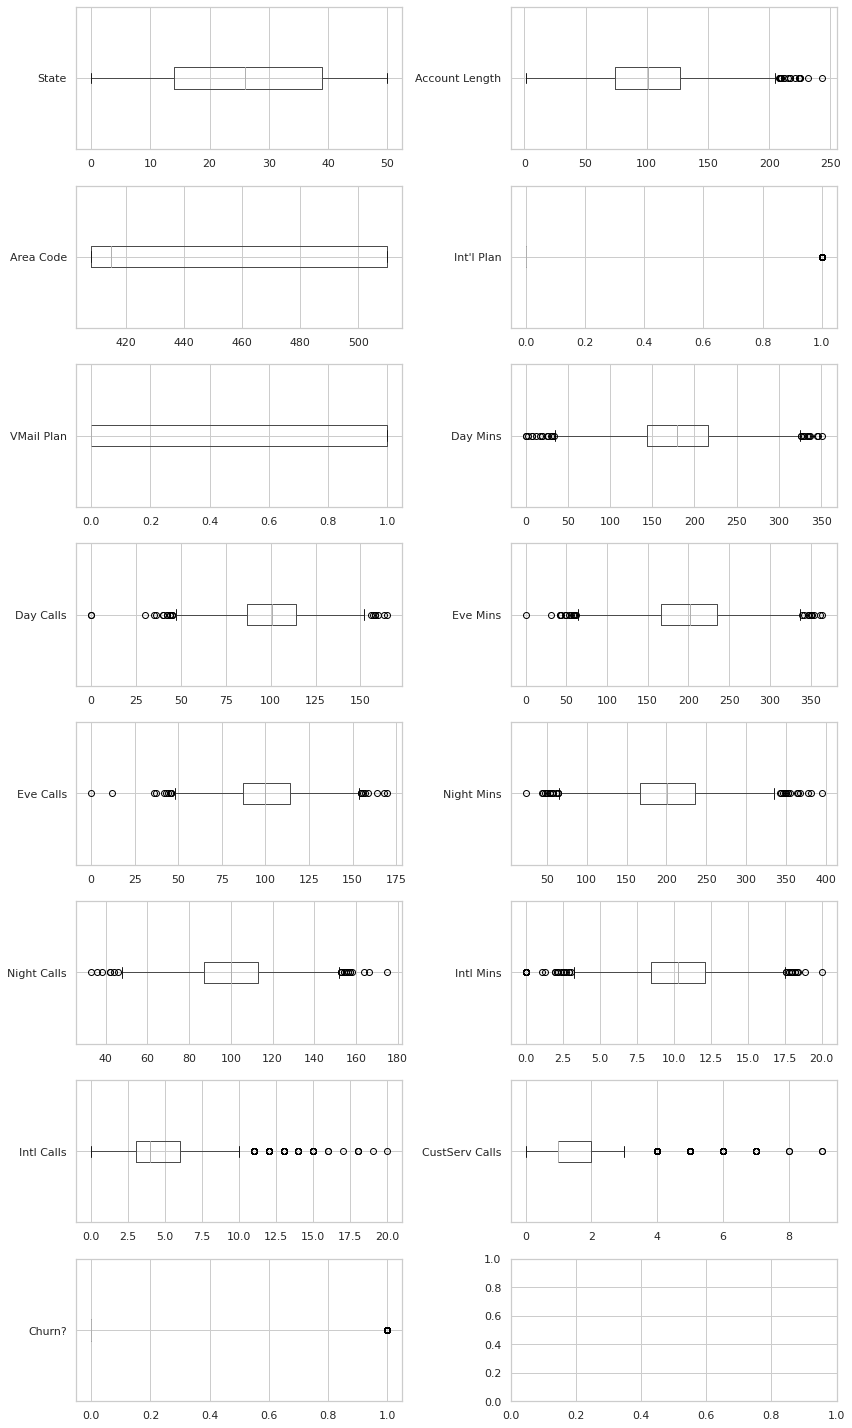

In [797]:
fig, axes = plt.subplots(8, 2, figsize=(12, 20))

for i, el in enumerate(list(le_data.columns.values)):
    le_data.boxplot(el, ax=axes.flatten()[i], vert=False)

plt.tight_layout()
plt.show()

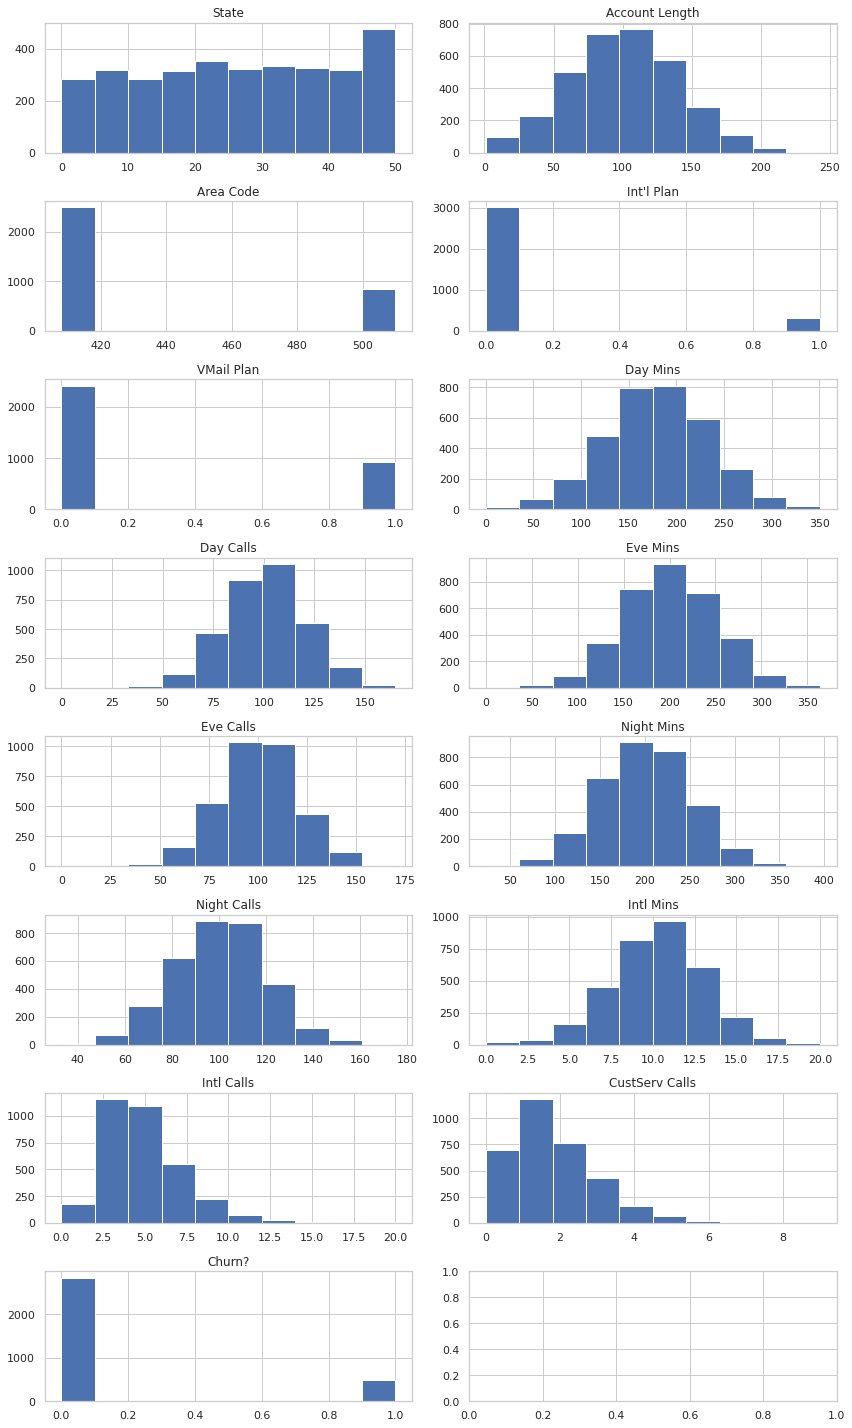

In [798]:
fig, axes = plt.subplots(8, 2, figsize=(12, 20))

for i, el in enumerate(list(le_data.columns.values)):
    le_data.hist(el, ax=axes.flatten()[i])

plt.tight_layout() 
plt.show()

#### 3.2. Prepare data

In [799]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [800]:
X = le_data.drop("Churn?", axis=1)
y = le_data["Churn?"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [801]:
y_train.value_counts()

0    2284
1     382
Name: Churn?, dtype: int64

In [802]:
new_data = pd.concat([X_train, y_train], axis=1)

In [803]:
from sklearn.utils import resample

df_0 = new_data[new_data["Churn?"]==0]
df_1 = new_data[new_data["Churn?"]==1]

upsampled_01 = resample(df_1, replace=True, n_samples=2284, random_state=123)

bal_X = pd.concat([df_0, upsampled_01])

X_train = bal_X.drop("Churn?", axis=1)
y_train = bal_X["Churn?"]

 
bal_X["Churn?"].value_counts()

0    2284
1    2284
Name: Churn?, dtype: int64

#### 3.3. Models

In [718]:
model_01 = xgboost.XGBClassifier(random_state=SEED)
model_02 = xgboost.XGBRFClassifier(random_state=SEED)

model_03 = lightgbm.LGBMClassifier(random_state=SEED)
model_04 = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)

model_05 = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)

In [719]:
model_01.fit(X_train, y_train)
cross_val_score(model_01, X_train, y_train, cv=3, scoring="f1").mean()

[21:37:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

0.9852829785533181

In [720]:
model_02.fit(X_train, y_train)
cross_val_score(model_02, X_train, y_train, cv=3, scoring="f1").mean()

[21:37:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

0.898971787678217

In [721]:
model_03.fit(X_train, y_train)
cross_val_score(model_03, X_train, y_train, cv=3, scoring="f1").mean()

0.9865598327915258

In [722]:
model_04.fit(X_train, y_train)
cross_val_score(model_04, X_train, y_train, cv=3, scoring="f1").mean()

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


0.8952605498794511

In [723]:
model_05.fit(X_train, y_train)
cross_val_score(model_05, X_train, y_train, cv=3, scoring="f1").mean()

0.9781152405763551

In [724]:
y_pred = model_01.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

accuracy_score:	0.9535
precision_score:0.9299
recall_score: 	0.8831
f1_score: 	0.9045


In [725]:
y_pred = model_02.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

accuracy_score:	0.949
precision_score:0.9008
recall_score: 	0.9008
f1_score: 	0.9008


In [726]:
y_pred = model_03.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

accuracy_score:	0.9535
precision_score:0.9262
recall_score: 	0.8872
f1_score: 	0.9053


In [727]:
y_pred = model_04.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

accuracy_score:	0.9385
precision_score:0.8774
recall_score: 	0.8865
f1_score: 	0.8818


In [728]:
y_pred = model_05.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

accuracy_score:	0.9565
precision_score:0.9226
recall_score: 	0.9052
f1_score: 	0.9136


Хороши третья и пятая модель. Но и все в целом не плохие.

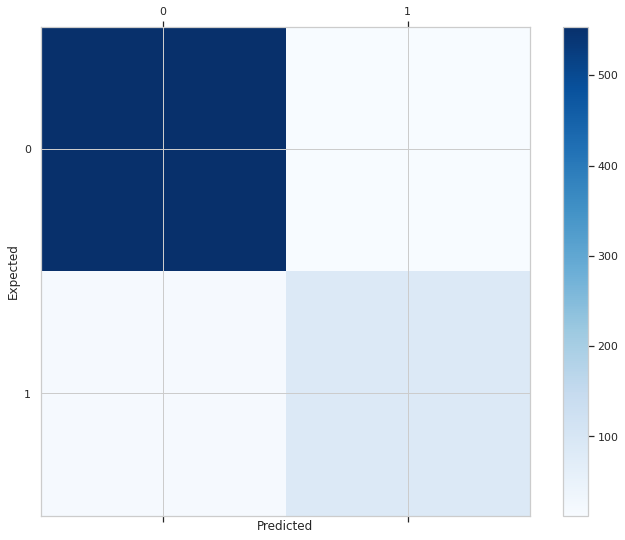

In [866]:
# y_pred_best

from sklearn.metrics import confusion_matrix

y_pred = model_05.predict(X_test)

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

from kaggle

In [804]:
import optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMPruningCallback
import 

In [872]:
model_03.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 111,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [893]:
def objective(trial, X_train, y_train):
    
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("lambda_l1", 10, 1010, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.001, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100, step=5),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 50, 300, step=50),
        #"lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        #"lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
        X_train_t, X_test_t = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_t, y_test_t = y_train[train_idx], y_train[test_idx]

        model = lightgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train_t,
            y_train_t,
            eval_set=[(X_test_t, y_test_t)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [895]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=100)

[I 2022-03-13 22:27:20,391] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=14.757973581850164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.757973581850164
[1]	valid_0's binary_logloss: 0.395426
[2]	valid_0's binary_logloss: 0.378475
[3]	valid_0's binary_logloss: 0.367318
[4]	valid_0's binary_logloss: 0.355495
[5]	valid_0's binary_logloss: 0.343262
[6]	valid_0's binary_logloss: 0.333002
[7]	valid_0's binary_logloss: 0.324353
[8]	valid_0's binary_logloss: 0.318537
[9]	valid_0's binary_logloss: 0.312631
[10]	valid_0's binary_logloss: 0.309455
[11]	valid_0's binary_logloss: 0.307228
[12]	valid_0's binary_logloss: 0.302068
[13]	valid_0's binary_logloss: 0.296306
[14]	valid_0's binary_logloss: 0.293342
[15]	valid_0's binary_logloss: 0.292118
[16]	valid_0's binary_logloss: 0.291402
[17]	valid_0's binary_logloss: 0.29091
[18]	valid_0's binary_logloss: 0.290189
[19]	valid_0

[I 2022-03-13 22:27:20,725] Trial 0 finished with value: 0.27812667647615646 and parameters: {'lambda_l1': 610, 'learning_rate': 0.10957174127149144, 'min_child_weight': 0.028382571522146502, 'num_leaves': 60, 'max_depth': 0, 'min_child_samples': 200, 'min_gain_to_split': 14.757973581850164, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.27812667647615646.


[119]	valid_0's binary_logloss: 0.304534
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=14.757973581850164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.757973581850164
[1]	valid_0's binary_logloss: 0.393375
[2]	valid_0's binary_logloss: 0.374494
[3]	valid_0's binary_logloss: 0.35953
[4]	valid_0's binary_logloss: 0.34667
[5]	valid_0's binary_logloss: 0.33546
[6]	valid_0's binary_logloss: 0.322836
[7]	valid_0's binary_logloss: 0.313663
[8]	valid_0's binary_logloss: 0.306925
[9]	valid_0's binary_logloss: 0.30024
[10]	valid_0's binary_logloss: 0.295967
[11]	valid_0's binary_logloss: 0.293406
[12]	valid_0's binary_logloss: 0.288563
[13]	valid_0's binary_logloss: 0.28368
[14]	valid_0's binary_logloss: 0.279727
[15]	valid_0's binary_logloss: 0.276394
[16]	valid_0's binary_logloss: 0.275005
[17]	valid_0's binary_logloss: 0.274038
[18]	valid_0's 

[34]	valid_0's binary_logloss: 0.318942
[35]	valid_0's binary_logloss: 0.318985
[36]	valid_0's binary_logloss: 0.317404
[37]	valid_0's binary_logloss: 0.317292
[38]	valid_0's binary_logloss: 0.31621
[39]	valid_0's binary_logloss: 0.313439
[40]	valid_0's binary_logloss: 0.312395
[41]	valid_0's binary_logloss: 0.311552
[42]	valid_0's binary_logloss: 0.311708
[43]	valid_0's binary_logloss: 0.3113
[44]	valid_0's binary_logloss: 0.311308
[45]	valid_0's binary_logloss: 0.310014
[46]	valid_0's binary_logloss: 0.308979
[47]	valid_0's binary_logloss: 0.307094
[48]	valid_0's binary_logloss: 0.306902
[49]	valid_0's binary_logloss: 0.306956
[50]	valid_0's binary_logloss: 0.306328
[51]	valid_0's binary_logloss: 0.305681
[52]	valid_0's binary_logloss: 0.305662
[53]	valid_0's binary_logloss: 0.305309
[54]	valid_0's binary_logloss: 0.305309
[55]	valid_0's binary_logloss: 0.305018
[56]	valid_0's binary_logloss: 0.304777
[57]	valid_0's binary_logloss: 0.304661
[58]	valid_0's binary_logloss: 0.30469
[59]

[I 2022-03-13 22:27:21,041] Trial 1 finished with value: 0.2823493465040893 and parameters: {'lambda_l1': 310, 'learning_rate': 0.0857514075449948, 'min_child_weight': 0.09675526461581482, 'num_leaves': 75, 'max_depth': 12, 'min_child_samples': 300, 'min_gain_to_split': 4.185701914980539, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.27812667647615646.



[150]	valid_0's binary_logloss: 0.284861
[151]	valid_0's binary_logloss: 0.284861
[152]	valid_0's binary_logloss: 0.284861
[153]	valid_0's binary_logloss: 0.284861
[154]	valid_0's binary_logloss: 0.284861
[155]	valid_0's binary_logloss: 0.284861
[156]	valid_0's binary_logloss: 0.284861
[157]	valid_0's binary_logloss: 0.284861
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=13.695410794382902, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.695410794382902
[1]	valid_0's binary_logloss: 0.347486
[2]	valid_0's binary_logloss: 0.310204
[3]	valid_0's binary_logloss: 0.301145
[4]	valid_0's binary_logloss: 0.281065
[5]	valid_0's binary_logloss: 0.270501
[6]	valid_0's binary_logloss: 0.263313
[7]	valid_0's binary_logloss: 0.260027
[8]	valid_0's binary_logloss: 0.2565
[9]	valid_0's binary_logloss: 0.254377
[10]	valid_0's binary_logloss: 0.254377
[11]

[I 2022-03-13 22:27:21,282] Trial 2 finished with value: 0.2481144776778424 and parameters: {'lambda_l1': 210, 'learning_rate': 0.218707713535632, 'min_child_weight': 0.19321233620880615, 'num_leaves': 40, 'max_depth': 8, 'min_child_samples': 50, 'min_gain_to_split': 13.695410794382902, 'feature_fraction': 0.7}. Best is trial 2 with value: 0.2481144776778424.



[62]	valid_0's binary_logloss: 0.244879
[63]	valid_0's binary_logloss: 0.244879
[64]	valid_0's binary_logloss: 0.244879
[65]	valid_0's binary_logloss: 0.244879
[66]	valid_0's binary_logloss: 0.244879
[67]	valid_0's binary_logloss: 0.244879
[68]	valid_0's binary_logloss: 0.244879
[69]	valid_0's binary_logloss: 0.244879
[70]	valid_0's binary_logloss: 0.244879
[71]	valid_0's binary_logloss: 0.244879
[72]	valid_0's binary_logloss: 0.244879
[73]	valid_0's binary_logloss: 0.244879
[74]	valid_0's binary_logloss: 0.244879
[75]	valid_0's binary_logloss: 0.244879
[76]	valid_0's binary_logloss: 0.244879
[77]	valid_0's binary_logloss: 0.244879
[78]	valid_0's binary_logloss: 0.244879
[79]	valid_0's binary_logloss: 0.244879
[80]	valid_0's binary_logloss: 0.244879
[81]	valid_0's binary_logloss: 0.244879
[82]	valid_0's binary_logloss: 0.244879
[83]	valid_0's binary_logloss: 0.244879
[84]	valid_0's binary_logloss: 0.244879
[85]	valid_0's binary_logloss: 0.244879
[86]	valid_0's binary_logloss: 0.244879

[I 2022-03-13 22:27:21,577] Trial 3 finished with value: 0.23988710230136098 and parameters: {'lambda_l1': 110, 'learning_rate': 0.11926281877868128, 'min_child_weight': 0.021674231798910877, 'num_leaves': 20, 'max_depth': 9, 'min_child_samples': 200, 'min_gain_to_split': 3.251148982578001, 'feature_fraction': 0.5}. Best is trial 3 with value: 0.23988710230136098.


[20]	valid_0's binary_logloss: 0.299407
[21]	valid_0's binary_logloss: 0.298926
[22]	valid_0's binary_logloss: 0.298169
[23]	valid_0's binary_logloss: 0.29824
[24]	valid_0's binary_logloss: 0.297607
[25]	valid_0's binary_logloss: 0.296729
[26]	valid_0's binary_logloss: 0.293331
[27]	valid_0's binary_logloss: 0.292675
[28]	valid_0's binary_logloss: 0.292415
[29]	valid_0's binary_logloss: 0.291222
[30]	valid_0's binary_logloss: 0.291341
[31]	valid_0's binary_logloss: 0.290935
[32]	valid_0's binary_logloss: 0.290629
[33]	valid_0's binary_logloss: 0.290245
[34]	valid_0's binary_logloss: 0.289852
[35]	valid_0's binary_logloss: 0.289763
[36]	valid_0's binary_logloss: 0.288686
[37]	valid_0's binary_logloss: 0.289243
[38]	valid_0's binary_logloss: 0.289135
[39]	valid_0's binary_logloss: 0.288057
[40]	valid_0's binary_logloss: 0.28826
[41]	valid_0's binary_logloss: 0.288283
[42]	valid_0's binary_logloss: 0.288164
[43]	valid_0's binary_logloss: 0.288133
[44]	valid_0's binary_logloss: 0.287338
[4

[14]	valid_0's binary_logloss: 0.286433
[15]	valid_0's binary_logloss: 0.284013
[16]	valid_0's binary_logloss: 0.278701
[17]	valid_0's binary_logloss: 0.274278
[18]	valid_0's binary_logloss: 0.270955
[19]	valid_0's binary_logloss: 0.268882
[20]	valid_0's binary_logloss: 0.266398
[21]	valid_0's binary_logloss: 0.26517
[22]	valid_0's binary_logloss: 0.261998
[23]	valid_0's binary_logloss: 0.260304
[24]	valid_0's binary_logloss: 0.25899
[25]	valid_0's binary_logloss: 0.257351
[26]	valid_0's binary_logloss: 0.255139
[27]	valid_0's binary_logloss: 0.254361
[28]	valid_0's binary_logloss: 0.253535
[29]	valid_0's binary_logloss: 0.252238
[30]	valid_0's binary_logloss: 0.251111
[31]	valid_0's binary_logloss: 0.25072
[32]	valid_0's binary_logloss: 0.249188
[33]	valid_0's binary_logloss: 0.248303
[34]	valid_0's binary_logloss: 0.247457
[35]	valid_0's binary_logloss: 0.247594
[36]	valid_0's binary_logloss: 0.247042
[37]	valid_0's binary_logloss: 0.246394
[38]	valid_0's binary_logloss: 0.245066
[39

[I 2022-03-13 22:27:21,945] Trial 4 finished with value: 0.21106848746230084 and parameters: {'lambda_l1': 110, 'learning_rate': 0.10235622857975377, 'min_child_weight': 0.1299813541863915, 'num_leaves': 60, 'max_depth': 3, 'min_child_samples': 100, 'min_gain_to_split': 2.836274385885693, 'feature_fraction': 0.7}. Best is trial 4 with value: 0.21106848746230084.



[110]	valid_0's binary_logloss: 0.249514
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=2.836274385885693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.836274385885693
[1]	valid_0's binary_logloss: 0.382203
[2]	valid_0's binary_logloss: 0.360154
[3]	valid_0's binary_logloss: 0.351443
[4]	valid_0's binary_logloss: 0.340352
[5]	valid_0's binary_logloss: 0.330715
[6]	valid_0's binary_logloss: 0.319537
[7]	valid_0's binary_logloss: 0.312283
[8]	valid_0's binary_logloss: 0.302994
[9]	valid_0's binary_logloss: 0.29707
[10]	valid_0's binary_logloss: 0.290212
[11]	valid_0's binary_logloss: 0.286018
[12]	valid_0's binary_logloss: 0.280195
[13]	valid_0's binary_logloss: 0.274635
[14]	valid_0's binary_logloss: 0.270473
[15]	valid_0's binary_logloss: 0.266785
[16]	valid_0's binary_logloss: 0.262187
[17]	valid_0's binary_logloss: 0.258034
[18]	valid_0

[130]	valid_0's binary_logloss: 0.303457
[131]	valid_0's binary_logloss: 0.303457
[132]	valid_0's binary_logloss: 0.303457
[133]	valid_0's binary_logloss: 0.303457
[134]	valid_0's binary_logloss: 0.303457
[135]	valid_0's binary_logloss: 0.303457
[136]	valid_0's binary_logloss: 0.303457
[137]	valid_0's binary_logloss: 0.303457
[138]	valid_0's binary_logloss: 0.303457
[139]	valid_0's binary_logloss: 0.303457
[140]	valid_0's binary_logloss: 0.303457
[141]	valid_0's binary_logloss: 0.303457
[142]	valid_0's binary_logloss: 0.303457
[143]	valid_0's binary_logloss: 0.303457
[144]	valid_0's binary_logloss: 0.303457
[145]	valid_0's binary_logloss: 0.303457
[146]	valid_0's binary_logloss: 0.303457
[147]	valid_0's binary_logloss: 0.303457
[148]	valid_0's binary_logloss: 0.303457
[149]	valid_0's binary_logloss: 0.303457
[150]	valid_0's binary_logloss: 0.303457
[151]	valid_0's binary_logloss: 0.303457
[152]	valid_0's binary_logloss: 0.303457
[153]	valid_0's binary_logloss: 0.303457
[154]	valid_0's 

[I 2022-03-13 22:27:22,329] Trial 5 finished with value: 0.30075705062132607 and parameters: {'lambda_l1': 710, 'learning_rate': 0.18030254769005433, 'min_child_weight': 0.12490260899345891, 'num_leaves': 40, 'max_depth': 11, 'min_child_samples': 300, 'min_gain_to_split': 5.250153918621439, 'feature_fraction': 0.2}. Best is trial 4 with value: 0.21106848746230084.


[153]	valid_0's binary_logloss: 0.329052
[154]	valid_0's binary_logloss: 0.329052
[155]	valid_0's binary_logloss: 0.329052
[156]	valid_0's binary_logloss: 0.329052
[157]	valid_0's binary_logloss: 0.329052
[158]	valid_0's binary_logloss: 0.329052
[159]	valid_0's binary_logloss: 0.329052
[160]	valid_0's binary_logloss: 0.329052
[161]	valid_0's binary_logloss: 0.329052
[162]	valid_0's binary_logloss: 0.329052
[163]	valid_0's binary_logloss: 0.329052
[164]	valid_0's binary_logloss: 0.329052
[165]	valid_0's binary_logloss: 0.329052
[166]	valid_0's binary_logloss: 0.329052
[167]	valid_0's binary_logloss: 0.329052
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=5.250153918621439, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.250153918621439
[1]	valid_0's binary_logloss: 0.408496
[2]	valid_0's binary_logloss: 0.404336
[3]	valid_0's binary_logloss: 0

[I 2022-03-13 22:27:22,594] Trial 6 finished with value: 0.2646800757414371 and parameters: {'lambda_l1': 910, 'learning_rate': 0.27247579614963663, 'min_child_weight': 0.1579093847704806, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 150, 'min_gain_to_split': 10.833823071699076, 'feature_fraction': 0.7}. Best is trial 4 with value: 0.21106848746230084.



[97]	valid_0's binary_logloss: 0.26828
[98]	valid_0's binary_logloss: 0.26828
[99]	valid_0's binary_logloss: 0.26828
[100]	valid_0's binary_logloss: 0.26828
[101]	valid_0's binary_logloss: 0.26828
[102]	valid_0's binary_logloss: 0.26828
[103]	valid_0's binary_logloss: 0.26828
[104]	valid_0's binary_logloss: 0.26828
[105]	valid_0's binary_logloss: 0.26828
[106]	valid_0's binary_logloss: 0.26828
[107]	valid_0's binary_logloss: 0.26828
[108]	valid_0's binary_logloss: 0.26828
[109]	valid_0's binary_logloss: 0.26828
[110]	valid_0's binary_logloss: 0.26828
[111]	valid_0's binary_logloss: 0.26828
[112]	valid_0's binary_logloss: 0.26828
[113]	valid_0's binary_logloss: 0.26828
[114]	valid_0's binary_logloss: 0.26828
[115]	valid_0's binary_logloss: 0.26828
[116]	valid_0's binary_logloss: 0.26828
[117]	valid_0's binary_logloss: 0.26828
[118]	valid_0's binary_logloss: 0.26828
[119]	valid_0's binary_logloss: 0.26828
[120]	valid_0's binary_logloss: 0.26828
[121]	valid_0's binary_logloss: 0.26828
[1

[5]	valid_0's binary_logloss: 0.398864
[6]	valid_0's binary_logloss: 0.398312
[7]	valid_0's binary_logloss: 0.394915
[8]	valid_0's binary_logloss: 0.396816
[9]	valid_0's binary_logloss: 0.395709
[10]	valid_0's binary_logloss: 0.396278
[11]	valid_0's binary_logloss: 0.383859
[12]	valid_0's binary_logloss: 0.35682
[13]	valid_0's binary_logloss: 0.355611
[14]	valid_0's binary_logloss: 0.356019
[15]	valid_0's binary_logloss: 0.355468
[16]	valid_0's binary_logloss: 0.355468
[17]	valid_0's binary_logloss: 0.35599
[18]	valid_0's binary_logloss: 0.355626
[19]	valid_0's binary_logloss: 0.355914
[20]	valid_0's binary_logloss: 0.341918
[21]	valid_0's binary_logloss: 0.341976
[22]	valid_0's binary_logloss: 0.341976
[23]	valid_0's binary_logloss: 0.333302
[24]	valid_0's binary_logloss: 0.330163
[25]	valid_0's binary_logloss: 0.330163
[26]	valid_0's binary_logloss: 0.328468
[27]	valid_0's binary_logloss: 0.328468
[28]	valid_0's binary_logloss: 0.318246
[29]	valid_0's binary_logloss: 0.318246
[30]	va

[I 2022-03-13 22:27:22,840] Trial 7 finished with value: 0.298130882635014 and parameters: {'lambda_l1': 110, 'learning_rate': 0.27240265611850234, 'min_child_weight': 0.16925857384549506, 'num_leaves': 35, 'max_depth': 8, 'min_child_samples': 300, 'min_gain_to_split': 4.392425002218182, 'feature_fraction': 0.2}. Best is trial 4 with value: 0.21106848746230084.



[41]	valid_0's binary_logloss: 0.294851
[42]	valid_0's binary_logloss: 0.294851
[43]	valid_0's binary_logloss: 0.294851
[44]	valid_0's binary_logloss: 0.294677
[45]	valid_0's binary_logloss: 0.294677
[46]	valid_0's binary_logloss: 0.294254
[47]	valid_0's binary_logloss: 0.294254
[48]	valid_0's binary_logloss: 0.293016
[49]	valid_0's binary_logloss: 0.293016
[50]	valid_0's binary_logloss: 0.292584
[51]	valid_0's binary_logloss: 0.292584
[52]	valid_0's binary_logloss: 0.292584
[53]	valid_0's binary_logloss: 0.292584
[54]	valid_0's binary_logloss: 0.291907
[55]	valid_0's binary_logloss: 0.291907
[56]	valid_0's binary_logloss: 0.291047
[57]	valid_0's binary_logloss: 0.290514
[58]	valid_0's binary_logloss: 0.290514
[59]	valid_0's binary_logloss: 0.290514
[60]	valid_0's binary_logloss: 0.29052
[61]	valid_0's binary_logloss: 0.29052
[62]	valid_0's binary_logloss: 0.29052
[63]	valid_0's binary_logloss: 0.29052
[64]	valid_0's binary_logloss: 0.29052
[65]	valid_0's binary_logloss: 0.29052
[66]	

[I 2022-03-13 22:27:23,116] Trial 8 finished with value: 0.29568533790075324 and parameters: {'lambda_l1': 510, 'learning_rate': 0.25519151894296965, 'min_child_weight': 0.15162261455276205, 'num_leaves': 70, 'max_depth': 6, 'min_child_samples': 300, 'min_gain_to_split': 3.636742734341088, 'feature_fraction': 0.2}. Best is trial 4 with value: 0.21106848746230084.



[94]	valid_0's binary_logloss: 0.328349
[95]	valid_0's binary_logloss: 0.328349
[96]	valid_0's binary_logloss: 0.328349
[97]	valid_0's binary_logloss: 0.328349
[98]	valid_0's binary_logloss: 0.328349
[99]	valid_0's binary_logloss: 0.328349
[100]	valid_0's binary_logloss: 0.328349
[101]	valid_0's binary_logloss: 0.328349
[102]	valid_0's binary_logloss: 0.328349
[103]	valid_0's binary_logloss: 0.328349
[104]	valid_0's binary_logloss: 0.328349
[105]	valid_0's binary_logloss: 0.328349
[106]	valid_0's binary_logloss: 0.328349
[107]	valid_0's binary_logloss: 0.328349
[108]	valid_0's binary_logloss: 0.328349
[109]	valid_0's binary_logloss: 0.328349
[110]	valid_0's binary_logloss: 0.328349
[111]	valid_0's binary_logloss: 0.328349
[112]	valid_0's binary_logloss: 0.328349
[113]	valid_0's binary_logloss: 0.328349
[114]	valid_0's binary_logloss: 0.328349
[115]	valid_0's binary_logloss: 0.328349
[116]	valid_0's binary_logloss: 0.328349
[117]	valid_0's binary_logloss: 0.328349
[118]	valid_0's binar

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=12.979952611269931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.979952611269931
[1]	valid_0's binary_logloss: 0.409702
[2]	valid_0's binary_logloss: 0.392426
[3]	valid_0's binary_logloss: 0.391513
[4]	valid_0's binary_logloss: 0.387658
[5]	valid_0's binary_logloss: 0.384445
[6]	valid_0's binary_logloss: 0.374967
[7]	valid_0's binary_logloss: 0.3672
[8]	valid_0's binary_logloss: 0.360295
[9]	valid_0's binary_logloss: 0.356729
[10]	valid_0's binary_logloss: 0.354575
[11]	valid_0's binary_logloss: 0.352201
[12]	valid_0's binary_logloss: 0.350662
[13]	valid_0's binary_logloss: 0.343684
[14]	valid_0's binary_logloss: 0.339153
[15]	valid_0's binary_logloss: 0.334299
[16]	valid_0's binary_logloss: 0.326658
[17]	valid_0's binary_logloss: 0.323016
[18]	valid_0's binary_logloss: 0.315183
[19]	valid_0'

[I 2022-03-13 22:27:23,534] Trial 9 finished with value: 0.2639442428296152 and parameters: {'lambda_l1': 610, 'learning_rate': 0.04716707359333305, 'min_child_weight': 0.04771038691683057, 'num_leaves': 80, 'max_depth': 7, 'min_child_samples': 50, 'min_gain_to_split': 12.979952611269931, 'feature_fraction': 0.5}. Best is trial 4 with value: 0.21106848746230084.



[16]	valid_0's binary_logloss: 0.313814
[17]	valid_0's binary_logloss: 0.310276
[18]	valid_0's binary_logloss: 0.303302
[19]	valid_0's binary_logloss: 0.299608
[20]	valid_0's binary_logloss: 0.296029
[21]	valid_0's binary_logloss: 0.294839
[22]	valid_0's binary_logloss: 0.28977
[23]	valid_0's binary_logloss: 0.287319
[24]	valid_0's binary_logloss: 0.28491
[25]	valid_0's binary_logloss: 0.283829
[26]	valid_0's binary_logloss: 0.282508
[27]	valid_0's binary_logloss: 0.279071
[28]	valid_0's binary_logloss: 0.27841
[29]	valid_0's binary_logloss: 0.276785
[30]	valid_0's binary_logloss: 0.275418
[31]	valid_0's binary_logloss: 0.275076
[32]	valid_0's binary_logloss: 0.274858
[33]	valid_0's binary_logloss: 0.274355
[34]	valid_0's binary_logloss: 0.270938
[35]	valid_0's binary_logloss: 0.269656
[36]	valid_0's binary_logloss: 0.269656
[37]	valid_0's binary_logloss: 0.268759
[38]	valid_0's binary_logloss: 0.268051
[39]	valid_0's binary_logloss: 0.268051
[40]	valid_0's binary_logloss: 0.267021
[4

[I 2022-03-13 22:27:23,638] Trial 10 finished with value: 0.4010110081097798 and parameters: {'lambda_l1': 10, 'learning_rate': 0.012443952817779436, 'min_child_weight': 0.08993727221480097, 'num_leaves': 100, 'max_depth': 2, 'min_child_samples': 100, 'min_gain_to_split': 1.0190512381466688, 'feature_fraction': 0.9}. Best is trial 4 with value: 0.21106848746230084.


[6]	valid_0's binary_logloss: 0.396459
[7]	valid_0's binary_logloss: 0.394205
[8]	valid_0's binary_logloss: 0.391955
[9]	valid_0's binary_logloss: 0.389841
[10]	valid_0's binary_logloss: 0.388
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=1.0190512381466688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0190512381466688
[1]	valid_0's binary_logloss: 0.409681
[2]	valid_0's binary_logloss: 0.407074
[3]	valid_0's binary_logloss: 0.404587
[4]	valid_0's binary_logloss: 0.402212
[5]	valid_0's binary_logloss: 0.399942
[6]	valid_0's binary_logloss: 0.397768
[7]	valid_0's binary_logloss: 0.395684
[8]	valid_0's binary_logloss: 0.393685
[9]	valid_0's binary_logloss: 0.391765
[10]	valid_0's binary_logloss: 0.390084
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Wa

[204]	valid_0's binary_logloss: 0.227875
[205]	valid_0's binary_logloss: 0.227352
[206]	valid_0's binary_logloss: 0.226353
[207]	valid_0's binary_logloss: 0.226776
[208]	valid_0's binary_logloss: 0.226728
[209]	valid_0's binary_logloss: 0.226619
[210]	valid_0's binary_logloss: 0.226806
[211]	valid_0's binary_logloss: 0.226765
[212]	valid_0's binary_logloss: 0.22715
[213]	valid_0's binary_logloss: 0.227127
[214]	valid_0's binary_logloss: 0.226846
[215]	valid_0's binary_logloss: 0.226334
[216]	valid_0's binary_logloss: 0.226161
[217]	valid_0's binary_logloss: 0.226181
[218]	valid_0's binary_logloss: 0.226068
[219]	valid_0's binary_logloss: 0.225768
[220]	valid_0's binary_logloss: 0.225263
[221]	valid_0's binary_logloss: 0.224175
[222]	valid_0's binary_logloss: 0.224156
[223]	valid_0's binary_logloss: 0.224116
[224]	valid_0's binary_logloss: 0.223706
[225]	valid_0's binary_logloss: 0.223517
[226]	valid_0's binary_logloss: 0.223736
[227]	valid_0's binary_logloss: 0.22342
[228]	valid_0's bi

[200]	valid_0's binary_logloss: 0.1996
[201]	valid_0's binary_logloss: 0.199412
[202]	valid_0's binary_logloss: 0.199219
[203]	valid_0's binary_logloss: 0.198825
[204]	valid_0's binary_logloss: 0.199046
[205]	valid_0's binary_logloss: 0.198713
[206]	valid_0's binary_logloss: 0.198381
[207]	valid_0's binary_logloss: 0.198211
[208]	valid_0's binary_logloss: 0.198228
[209]	valid_0's binary_logloss: 0.198155
[210]	valid_0's binary_logloss: 0.198261
[211]	valid_0's binary_logloss: 0.198152
[212]	valid_0's binary_logloss: 0.198175
[213]	valid_0's binary_logloss: 0.198383
[214]	valid_0's binary_logloss: 0.198605
[215]	valid_0's binary_logloss: 0.197134
[216]	valid_0's binary_logloss: 0.197403
[217]	valid_0's binary_logloss: 0.197272
[218]	valid_0's binary_logloss: 0.197428
[219]	valid_0's binary_logloss: 0.197138
[220]	valid_0's binary_logloss: 0.196794
[221]	valid_0's binary_logloss: 0.195506
[222]	valid_0's binary_logloss: 0.195099
[223]	valid_0's binary_logloss: 0.195141
[224]	valid_0's bi

[287]	valid_0's binary_logloss: 0.245926
[288]	valid_0's binary_logloss: 0.245562
[289]	valid_0's binary_logloss: 0.245776
[290]	valid_0's binary_logloss: 0.245891
[291]	valid_0's binary_logloss: 0.24581
[292]	valid_0's binary_logloss: 0.24598
[293]	valid_0's binary_logloss: 0.246604
[294]	valid_0's binary_logloss: 0.246831
[295]	valid_0's binary_logloss: 0.246854
[296]	valid_0's binary_logloss: 0.246165
[297]	valid_0's binary_logloss: 0.246127
[298]	valid_0's binary_logloss: 0.246209
[299]	valid_0's binary_logloss: 0.246168
[300]	valid_0's binary_logloss: 0.245901
[301]	valid_0's binary_logloss: 0.245972
[302]	valid_0's binary_logloss: 0.245672
[303]	valid_0's binary_logloss: 0.245549
[304]	valid_0's binary_logloss: 0.246018
[305]	valid_0's binary_logloss: 0.246143
[306]	valid_0's binary_logloss: 0.246066
[307]	valid_0's binary_logloss: 0.245457
[308]	valid_0's binary_logloss: 0.245737
[309]	valid_0's binary_logloss: 0.245991
[310]	valid_0's binary_logloss: 0.246056
[311]	valid_0's bi

[354]	valid_0's binary_logloss: 0.186144
[355]	valid_0's binary_logloss: 0.186299
[356]	valid_0's binary_logloss: 0.186304
[357]	valid_0's binary_logloss: 0.186295
[358]	valid_0's binary_logloss: 0.1863
[359]	valid_0's binary_logloss: 0.186319
[360]	valid_0's binary_logloss: 0.186326
[361]	valid_0's binary_logloss: 0.186027
[362]	valid_0's binary_logloss: 0.185917
[363]	valid_0's binary_logloss: 0.18624
[364]	valid_0's binary_logloss: 0.18643
[365]	valid_0's binary_logloss: 0.186369
[366]	valid_0's binary_logloss: 0.186384
[367]	valid_0's binary_logloss: 0.186554
[368]	valid_0's binary_logloss: 0.186512
[369]	valid_0's binary_logloss: 0.186479
[370]	valid_0's binary_logloss: 0.186791
[371]	valid_0's binary_logloss: 0.186634
[372]	valid_0's binary_logloss: 0.186217
[373]	valid_0's binary_logloss: 0.186037
[374]	valid_0's binary_logloss: 0.186071
[375]	valid_0's binary_logloss: 0.186023
[376]	valid_0's binary_logloss: 0.18582
[377]	valid_0's binary_logloss: 0.185551
[378]	valid_0's binar

[I 2022-03-13 22:27:24,694] Trial 11 finished with value: 0.1056204759949296 and parameters: {'lambda_l1': 410, 'learning_rate': 0.12701343619562197, 'min_child_weight': 0.0018341422394133472, 'num_leaves': 20, 'max_depth': 4, 'min_child_samples': 200, 'min_gain_to_split': 0.020495516651954482, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.



[300]	valid_0's binary_logloss: 0.192858
[301]	valid_0's binary_logloss: 0.193
[302]	valid_0's binary_logloss: 0.19307
[303]	valid_0's binary_logloss: 0.193252
[304]	valid_0's binary_logloss: 0.193253
[305]	valid_0's binary_logloss: 0.193368
[306]	valid_0's binary_logloss: 0.193096
[307]	valid_0's binary_logloss: 0.193216
[308]	valid_0's binary_logloss: 0.193358
[309]	valid_0's binary_logloss: 0.193592
[310]	valid_0's binary_logloss: 0.193824
[311]	valid_0's binary_logloss: 0.194038
[312]	valid_0's binary_logloss: 0.193517
[313]	valid_0's binary_logloss: 0.193067
[314]	valid_0's binary_logloss: 0.193363
[315]	valid_0's binary_logloss: 0.193459
[316]	valid_0's binary_logloss: 0.193206
[317]	valid_0's binary_logloss: 0.19337
[318]	valid_0's binary_logloss: 0.193382
[319]	valid_0's binary_logloss: 0.193399
[320]	valid_0's binary_logloss: 0.193298
[321]	valid_0's binary_logloss: 0.193253
[322]	valid_0's binary_logloss: 0.193199
[323]	valid_0's binary_logloss: 0.193278
[324]	valid_0's bina

[202]	valid_0's binary_logloss: 0.224053
[203]	valid_0's binary_logloss: 0.224037
[204]	valid_0's binary_logloss: 0.224389
[205]	valid_0's binary_logloss: 0.224891
[206]	valid_0's binary_logloss: 0.224286
[207]	valid_0's binary_logloss: 0.223978
[208]	valid_0's binary_logloss: 0.224259
[209]	valid_0's binary_logloss: 0.224546
[210]	valid_0's binary_logloss: 0.224364
[211]	valid_0's binary_logloss: 0.224003
[212]	valid_0's binary_logloss: 0.224134
[213]	valid_0's binary_logloss: 0.22414
[214]	valid_0's binary_logloss: 0.224093
[215]	valid_0's binary_logloss: 0.223855
[216]	valid_0's binary_logloss: 0.224188
[217]	valid_0's binary_logloss: 0.224239
[218]	valid_0's binary_logloss: 0.224521
[219]	valid_0's binary_logloss: 0.224527
[220]	valid_0's binary_logloss: 0.224653
[221]	valid_0's binary_logloss: 0.224916
[222]	valid_0's binary_logloss: 0.224712
[223]	valid_0's binary_logloss: 0.224959
[224]	valid_0's binary_logloss: 0.224291
[225]	valid_0's binary_logloss: 0.224296
[226]	valid_0's b

[213]	valid_0's binary_logloss: 0.202173
[214]	valid_0's binary_logloss: 0.202375
[215]	valid_0's binary_logloss: 0.202387
[216]	valid_0's binary_logloss: 0.202134
[217]	valid_0's binary_logloss: 0.202027
[218]	valid_0's binary_logloss: 0.201971
[219]	valid_0's binary_logloss: 0.202222
[220]	valid_0's binary_logloss: 0.201969
[221]	valid_0's binary_logloss: 0.201691
[222]	valid_0's binary_logloss: 0.201582
[223]	valid_0's binary_logloss: 0.201465
[224]	valid_0's binary_logloss: 0.200872
[225]	valid_0's binary_logloss: 0.201048
[226]	valid_0's binary_logloss: 0.201282
[227]	valid_0's binary_logloss: 0.201186
[228]	valid_0's binary_logloss: 0.201294
[229]	valid_0's binary_logloss: 0.201143
[230]	valid_0's binary_logloss: 0.200694
[231]	valid_0's binary_logloss: 0.20079
[232]	valid_0's binary_logloss: 0.200481
[233]	valid_0's binary_logloss: 0.200476
[234]	valid_0's binary_logloss: 0.200386
[235]	valid_0's binary_logloss: 0.200174
[236]	valid_0's binary_logloss: 0.199645
[237]	valid_0's b

[43]	valid_0's binary_logloss: 0.23545
[44]	valid_0's binary_logloss: 0.235061
[45]	valid_0's binary_logloss: 0.232693
[46]	valid_0's binary_logloss: 0.232912
[47]	valid_0's binary_logloss: 0.231679
[48]	valid_0's binary_logloss: 0.231876
[49]	valid_0's binary_logloss: 0.232152
[50]	valid_0's binary_logloss: 0.230506
[51]	valid_0's binary_logloss: 0.230162
[52]	valid_0's binary_logloss: 0.23002
[53]	valid_0's binary_logloss: 0.229091
[54]	valid_0's binary_logloss: 0.228603
[55]	valid_0's binary_logloss: 0.228164
[56]	valid_0's binary_logloss: 0.227938
[57]	valid_0's binary_logloss: 0.226858
[58]	valid_0's binary_logloss: 0.226618
[59]	valid_0's binary_logloss: 0.226352
[60]	valid_0's binary_logloss: 0.226046
[61]	valid_0's binary_logloss: 0.225575
[62]	valid_0's binary_logloss: 0.225916
[63]	valid_0's binary_logloss: 0.225894
[64]	valid_0's binary_logloss: 0.225176
[65]	valid_0's binary_logloss: 0.224753
[66]	valid_0's binary_logloss: 0.223625
[67]	valid_0's binary_logloss: 0.222389
[6

[I 2022-03-13 22:27:25,734] Trial 12 finished with value: 0.12831604472510386 and parameters: {'lambda_l1': 410, 'learning_rate': 0.16469556020819598, 'min_child_weight': 0.08391549191305075, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 150, 'min_gain_to_split': 0.15438792939827448, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.



[96]	valid_0's binary_logloss: 0.214784
[97]	valid_0's binary_logloss: 0.215246
[98]	valid_0's binary_logloss: 0.214903
[99]	valid_0's binary_logloss: 0.21468
[100]	valid_0's binary_logloss: 0.214784
[101]	valid_0's binary_logloss: 0.214894
[102]	valid_0's binary_logloss: 0.214599
[103]	valid_0's binary_logloss: 0.214886
[104]	valid_0's binary_logloss: 0.214758
[105]	valid_0's binary_logloss: 0.214559
[106]	valid_0's binary_logloss: 0.2146
[107]	valid_0's binary_logloss: 0.214535
[108]	valid_0's binary_logloss: 0.214362
[109]	valid_0's binary_logloss: 0.214288
[110]	valid_0's binary_logloss: 0.213212
[111]	valid_0's binary_logloss: 0.213274
[112]	valid_0's binary_logloss: 0.213584
[113]	valid_0's binary_logloss: 0.213318
[114]	valid_0's binary_logloss: 0.213279
[115]	valid_0's binary_logloss: 0.213096
[116]	valid_0's binary_logloss: 0.213338
[117]	valid_0's binary_logloss: 0.213269
[118]	valid_0's binary_logloss: 0.21342
[119]	valid_0's binary_logloss: 0.21401
[120]	valid_0's binary_l

[179]	valid_0's binary_logloss: 0.22718
[180]	valid_0's binary_logloss: 0.227178
[181]	valid_0's binary_logloss: 0.227442
[182]	valid_0's binary_logloss: 0.227162
[183]	valid_0's binary_logloss: 0.227044
[184]	valid_0's binary_logloss: 0.22702
[185]	valid_0's binary_logloss: 0.226824
[186]	valid_0's binary_logloss: 0.226756
[187]	valid_0's binary_logloss: 0.227026
[188]	valid_0's binary_logloss: 0.226631
[189]	valid_0's binary_logloss: 0.226281
[190]	valid_0's binary_logloss: 0.226582
[191]	valid_0's binary_logloss: 0.226629
[192]	valid_0's binary_logloss: 0.226423
[193]	valid_0's binary_logloss: 0.226341
[194]	valid_0's binary_logloss: 0.226617
[195]	valid_0's binary_logloss: 0.226268
[196]	valid_0's binary_logloss: 0.226185
[197]	valid_0's binary_logloss: 0.226369
[198]	valid_0's binary_logloss: 0.226024
[199]	valid_0's binary_logloss: 0.226087
[200]	valid_0's binary_logloss: 0.226329
[201]	valid_0's binary_logloss: 0.22593
[202]	valid_0's binary_logloss: 0.225967
[203]	valid_0's bin

[262]	valid_0's binary_logloss: 0.207293
[263]	valid_0's binary_logloss: 0.207293
[264]	valid_0's binary_logloss: 0.207293
[265]	valid_0's binary_logloss: 0.207293
[266]	valid_0's binary_logloss: 0.207293
[267]	valid_0's binary_logloss: 0.207293
[268]	valid_0's binary_logloss: 0.207293
[269]	valid_0's binary_logloss: 0.207293
[270]	valid_0's binary_logloss: 0.207293
[271]	valid_0's binary_logloss: 0.207293
[272]	valid_0's binary_logloss: 0.207293
[273]	valid_0's binary_logloss: 0.207293
[274]	valid_0's binary_logloss: 0.207293
[275]	valid_0's binary_logloss: 0.207293
[276]	valid_0's binary_logloss: 0.207293
[277]	valid_0's binary_logloss: 0.207293
[278]	valid_0's binary_logloss: 0.207293
[279]	valid_0's binary_logloss: 0.207293
[280]	valid_0's binary_logloss: 0.207293
[281]	valid_0's binary_logloss: 0.207293
[282]	valid_0's binary_logloss: 0.207293
[283]	valid_0's binary_logloss: 0.207293
[284]	valid_0's binary_logloss: 0.207293
[285]	valid_0's binary_logloss: 0.207293
[286]	valid_0's 

[38]	valid_0's binary_logloss: 0.238485
[39]	valid_0's binary_logloss: 0.237769
[40]	valid_0's binary_logloss: 0.237516
[41]	valid_0's binary_logloss: 0.236934
[42]	valid_0's binary_logloss: 0.236058
[43]	valid_0's binary_logloss: 0.235478
[44]	valid_0's binary_logloss: 0.235208
[45]	valid_0's binary_logloss: 0.234446
[46]	valid_0's binary_logloss: 0.23469
[47]	valid_0's binary_logloss: 0.233418
[48]	valid_0's binary_logloss: 0.233326
[49]	valid_0's binary_logloss: 0.233187
[50]	valid_0's binary_logloss: 0.231672
[51]	valid_0's binary_logloss: 0.231247
[52]	valid_0's binary_logloss: 0.230157
[53]	valid_0's binary_logloss: 0.229553
[54]	valid_0's binary_logloss: 0.229272
[55]	valid_0's binary_logloss: 0.228105
[56]	valid_0's binary_logloss: 0.228039
[57]	valid_0's binary_logloss: 0.225544
[58]	valid_0's binary_logloss: 0.225402
[59]	valid_0's binary_logloss: 0.225355
[60]	valid_0's binary_logloss: 0.225047
[61]	valid_0's binary_logloss: 0.224446
[62]	valid_0's binary_logloss: 0.224022
[

[I 2022-03-13 22:27:26,530] Trial 13 finished with value: 0.14381188020876562 and parameters: {'lambda_l1': 410, 'learning_rate': 0.16862479626696042, 'min_child_weight': 0.05823261332185534, 'num_leaves': 50, 'max_depth': 3, 'min_child_samples': 150, 'min_gain_to_split': 0.20177241381183086, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.



[94]	valid_0's binary_logloss: 0.218912
[95]	valid_0's binary_logloss: 0.218844
[96]	valid_0's binary_logloss: 0.218734
[97]	valid_0's binary_logloss: 0.219225
[98]	valid_0's binary_logloss: 0.219008
[99]	valid_0's binary_logloss: 0.217625
[100]	valid_0's binary_logloss: 0.217574
[101]	valid_0's binary_logloss: 0.217541
[102]	valid_0's binary_logloss: 0.217357
[103]	valid_0's binary_logloss: 0.21745
[104]	valid_0's binary_logloss: 0.217193
[105]	valid_0's binary_logloss: 0.21745
[106]	valid_0's binary_logloss: 0.217138
[107]	valid_0's binary_logloss: 0.216724
[108]	valid_0's binary_logloss: 0.216926
[109]	valid_0's binary_logloss: 0.216721
[110]	valid_0's binary_logloss: 0.215343
[111]	valid_0's binary_logloss: 0.215329
[112]	valid_0's binary_logloss: 0.215101
[113]	valid_0's binary_logloss: 0.21488
[114]	valid_0's binary_logloss: 0.215047
[115]	valid_0's binary_logloss: 0.215242
[116]	valid_0's binary_logloss: 0.215637
[117]	valid_0's binary_logloss: 0.215241
[118]	valid_0's binary_l

[1]	valid_0's binary_logloss: 0.412996
[2]	valid_0's binary_logloss: 0.407427
[3]	valid_0's binary_logloss: 0.407105
[4]	valid_0's binary_logloss: 0.3899
[5]	valid_0's binary_logloss: 0.388447
[6]	valid_0's binary_logloss: 0.386213
[7]	valid_0's binary_logloss: 0.385055
[8]	valid_0's binary_logloss: 0.374488
[9]	valid_0's binary_logloss: 0.358694
[10]	valid_0's binary_logloss: 0.350842
[11]	valid_0's binary_logloss: 0.350381
[12]	valid_0's binary_logloss: 0.340391
[13]	valid_0's binary_logloss: 0.334864
[14]	valid_0's binary_logloss: 0.329913
[15]	valid_0's binary_logloss: 0.329657
[16]	valid_0's binary_logloss: 0.329657
[17]	valid_0's binary_logloss: 0.324723
[18]	valid_0's binary_logloss: 0.321325
[19]	valid_0's binary_logloss: 0.317872
[20]	valid_0's binary_logloss: 0.312467
[21]	valid_0's binary_logloss: 0.311905
[22]	valid_0's binary_logloss: 0.31191
[23]	valid_0's binary_logloss: 0.309848
[24]	valid_0's binary_logloss: 0.307118
[25]	valid_0's binary_logloss: 0.306283
[26]	valid_0

[I 2022-03-13 22:27:26,864] Trial 14 finished with value: 0.2915327752557476 and parameters: {'lambda_l1': 410, 'learning_rate': 0.2025116737739734, 'min_child_weight': 0.0030299471796549904, 'num_leaves': 95, 'max_depth': 0, 'min_child_samples': 250, 'min_gain_to_split': 8.12641875440366, 'feature_fraction': 0.30000000000000004}. Best is trial 11 with value: 0.1056204759949296.


[66]	valid_0's binary_logloss: 0.277587
[67]	valid_0's binary_logloss: 0.277587
[68]	valid_0's binary_logloss: 0.277587
[69]	valid_0's binary_logloss: 0.277587
[70]	valid_0's binary_logloss: 0.277587
[71]	valid_0's binary_logloss: 0.277587
[72]	valid_0's binary_logloss: 0.277587
[73]	valid_0's binary_logloss: 0.277587
[74]	valid_0's binary_logloss: 0.277587
[75]	valid_0's binary_logloss: 0.277587
[76]	valid_0's binary_logloss: 0.277587
[77]	valid_0's binary_logloss: 0.277587
[78]	valid_0's binary_logloss: 0.277587
[79]	valid_0's binary_logloss: 0.277587
[80]	valid_0's binary_logloss: 0.277587
[81]	valid_0's binary_logloss: 0.277587
[82]	valid_0's binary_logloss: 0.277587
[83]	valid_0's binary_logloss: 0.277587
[84]	valid_0's binary_logloss: 0.277587
[85]	valid_0's binary_logloss: 0.277587
[86]	valid_0's binary_logloss: 0.277587
[87]	valid_0's binary_logloss: 0.277587
[88]	valid_0's binary_logloss: 0.277587
[89]	valid_0's binary_logloss: 0.277587
[90]	valid_0's binary_logloss: 0.277587


[156]	valid_0's binary_logloss: 0.248254
[157]	valid_0's binary_logloss: 0.248254
[158]	valid_0's binary_logloss: 0.248254
[159]	valid_0's binary_logloss: 0.248254
[160]	valid_0's binary_logloss: 0.248254
[161]	valid_0's binary_logloss: 0.248254
[162]	valid_0's binary_logloss: 0.248254
[163]	valid_0's binary_logloss: 0.248254
[164]	valid_0's binary_logloss: 0.248254
[165]	valid_0's binary_logloss: 0.248254
[166]	valid_0's binary_logloss: 0.248254
[167]	valid_0's binary_logloss: 0.248254
[168]	valid_0's binary_logloss: 0.248254
[169]	valid_0's binary_logloss: 0.248254
[170]	valid_0's binary_logloss: 0.248254
[171]	valid_0's binary_logloss: 0.248254
[172]	valid_0's binary_logloss: 0.248254
[173]	valid_0's binary_logloss: 0.248254
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=1.5049527104739964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5

[I 2022-03-13 22:27:27,267] Trial 15 finished with value: 0.22263412627709153 and parameters: {'lambda_l1': 810, 'learning_rate': 0.14413416386385672, 'min_child_weight': 0.06730963068556044, 'num_leaves': 20, 'max_depth': 4, 'min_child_samples': 200, 'min_gain_to_split': 1.5049527104739964, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.



[132]	valid_0's binary_logloss: 0.229881
[133]	valid_0's binary_logloss: 0.229881
[134]	valid_0's binary_logloss: 0.229881
[135]	valid_0's binary_logloss: 0.229881
[136]	valid_0's binary_logloss: 0.229881
[137]	valid_0's binary_logloss: 0.229881
[138]	valid_0's binary_logloss: 0.229881
[139]	valid_0's binary_logloss: 0.229881
[140]	valid_0's binary_logloss: 0.229881
[141]	valid_0's binary_logloss: 0.229881
[142]	valid_0's binary_logloss: 0.229881
[143]	valid_0's binary_logloss: 0.229881
[144]	valid_0's binary_logloss: 0.229881
[145]	valid_0's binary_logloss: 0.229881
[146]	valid_0's binary_logloss: 0.229881
[147]	valid_0's binary_logloss: 0.229881
[148]	valid_0's binary_logloss: 0.229881
[149]	valid_0's binary_logloss: 0.229881
[150]	valid_0's binary_logloss: 0.229881
[151]	valid_0's binary_logloss: 0.229881
[152]	valid_0's binary_logloss: 0.229881
[153]	valid_0's binary_logloss: 0.229881
[154]	valid_0's binary_logloss: 0.229881
[155]	valid_0's binary_logloss: 0.229881
[156]	valid_0's

[I 2022-03-13 22:27:27,618] Trial 16 finished with value: 0.29816504091956075 and parameters: {'lambda_l1': 310, 'learning_rate': 0.14532078890543648, 'min_child_weight': 0.07651639385344577, 'num_leaves': 50, 'max_depth': 1, 'min_child_samples': 250, 'min_gain_to_split': 7.8988803752023315, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.


[119]	valid_0's binary_logloss: 0.318304
[120]	valid_0's binary_logloss: 0.318304
[121]	valid_0's binary_logloss: 0.318304
[122]	valid_0's binary_logloss: 0.318304
[123]	valid_0's binary_logloss: 0.318304
[124]	valid_0's binary_logloss: 0.318304
[125]	valid_0's binary_logloss: 0.318304
[126]	valid_0's binary_logloss: 0.318304
[127]	valid_0's binary_logloss: 0.318304
[128]	valid_0's binary_logloss: 0.318304
[129]	valid_0's binary_logloss: 0.318304
[130]	valid_0's binary_logloss: 0.318304
[131]	valid_0's binary_logloss: 0.318304
[132]	valid_0's binary_logloss: 0.318304
[133]	valid_0's binary_logloss: 0.318304
[134]	valid_0's binary_logloss: 0.318304
[135]	valid_0's binary_logloss: 0.318304
[136]	valid_0's binary_logloss: 0.318304
[137]	valid_0's binary_logloss: 0.318304
[138]	valid_0's binary_logloss: 0.318304
[139]	valid_0's binary_logloss: 0.318304
[140]	valid_0's binary_logloss: 0.318304
[141]	valid_0's binary_logloss: 0.318304
[142]	valid_0's binary_logloss: 0.318304
[143]	valid_0's 

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=6.284749290991679, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.284749290991679
[1]	valid_0's binary_logloss: 0.414169
[2]	valid_0's binary_logloss: 0.406274
[3]	valid_0's binary_logloss: 0.40598
[4]	valid_0's binary_logloss: 0.397713
[5]	valid_0's binary_logloss: 0.396152
[6]	valid_0's binary_logloss: 0.390119
[7]	valid_0's binary_logloss: 0.389198
[8]	valid_0's binary_logloss: 0.384887
[9]	valid_0's binary_logloss: 0.381215
[10]	valid_0's binary_logloss: 0.378779
[11]	valid_0's binary_logloss: 0.378758
[12]	valid_0's binary_logloss: 0.372055
[13]	valid_0's binary_logloss: 0.368462
[14]	valid_0's binary_logloss: 0.366567
[15]	valid_0's binary_logloss: 0.365813
[16]	valid_0's binary_logloss: 0.365482
[17]	valid_0's binary_logloss: 0.359734
[18]	valid_0's binary_

[14]	valid_0's binary_logloss: 0.370897
[15]	valid_0's binary_logloss: 0.370066
[16]	valid_0's binary_logloss: 0.369873
[17]	valid_0's binary_logloss: 0.364719
[18]	valid_0's binary_logloss: 0.362317
[19]	valid_0's binary_logloss: 0.360485
[20]	valid_0's binary_logloss: 0.357453
[21]	valid_0's binary_logloss: 0.356259
[22]	valid_0's binary_logloss: 0.356259
[23]	valid_0's binary_logloss: 0.353708
[24]	valid_0's binary_logloss: 0.350731
[25]	valid_0's binary_logloss: 0.348525
[26]	valid_0's binary_logloss: 0.347065
[27]	valid_0's binary_logloss: 0.344454
[28]	valid_0's binary_logloss: 0.342844
[29]	valid_0's binary_logloss: 0.341865
[30]	valid_0's binary_logloss: 0.340905
[31]	valid_0's binary_logloss: 0.340638
[32]	valid_0's binary_logloss: 0.340647
[33]	valid_0's binary_logloss: 0.340198
[34]	valid_0's binary_logloss: 0.33629
[35]	valid_0's binary_logloss: 0.336089
[36]	valid_0's binary_logloss: 0.33521
[37]	valid_0's binary_logloss: 0.335013
[38]	valid_0's binary_logloss: 0.331875
[3

[I 2022-03-13 22:27:28,173] Trial 17 finished with value: 0.27803252431214587 and parameters: {'lambda_l1': 1010, 'learning_rate': 0.06948802771732428, 'min_child_weight': 0.03323369756894667, 'num_leaves': 90, 'max_depth': -1, 'min_child_samples': 150, 'min_gain_to_split': 6.284749290991679, 'feature_fraction': 0.30000000000000004}. Best is trial 11 with value: 0.1056204759949296.


[15]	valid_0's binary_logloss: 0.357582
[16]	valid_0's binary_logloss: 0.357174
[17]	valid_0's binary_logloss: 0.350906
[18]	valid_0's binary_logloss: 0.347653
[19]	valid_0's binary_logloss: 0.345536
[20]	valid_0's binary_logloss: 0.341821
[21]	valid_0's binary_logloss: 0.340625
[22]	valid_0's binary_logloss: 0.340625
[23]	valid_0's binary_logloss: 0.337542
[24]	valid_0's binary_logloss: 0.333299
[25]	valid_0's binary_logloss: 0.330622
[26]	valid_0's binary_logloss: 0.328897
[27]	valid_0's binary_logloss: 0.325473
[28]	valid_0's binary_logloss: 0.32362
[29]	valid_0's binary_logloss: 0.322832
[30]	valid_0's binary_logloss: 0.321637
[31]	valid_0's binary_logloss: 0.32143
[32]	valid_0's binary_logloss: 0.32129
[33]	valid_0's binary_logloss: 0.321116
[34]	valid_0's binary_logloss: 0.31549
[35]	valid_0's binary_logloss: 0.315335
[36]	valid_0's binary_logloss: 0.313966
[37]	valid_0's binary_logloss: 0.313694
[38]	valid_0's binary_logloss: 0.309005
[39]	valid_0's binary_logloss: 0.308759
[40]

[96]	valid_0's binary_logloss: 0.236326
[97]	valid_0's binary_logloss: 0.236326
[98]	valid_0's binary_logloss: 0.236326
[99]	valid_0's binary_logloss: 0.236326
[100]	valid_0's binary_logloss: 0.236326
[101]	valid_0's binary_logloss: 0.236326
[102]	valid_0's binary_logloss: 0.236326
[103]	valid_0's binary_logloss: 0.236326
[104]	valid_0's binary_logloss: 0.236326
[105]	valid_0's binary_logloss: 0.236326
[106]	valid_0's binary_logloss: 0.236326
[107]	valid_0's binary_logloss: 0.236326
[108]	valid_0's binary_logloss: 0.236326
[109]	valid_0's binary_logloss: 0.236326
[110]	valid_0's binary_logloss: 0.236326
[111]	valid_0's binary_logloss: 0.236326
[112]	valid_0's binary_logloss: 0.236326
[113]	valid_0's binary_logloss: 0.236326
[114]	valid_0's binary_logloss: 0.236326
[115]	valid_0's binary_logloss: 0.236326
[116]	valid_0's binary_logloss: 0.236326
[117]	valid_0's binary_logloss: 0.236326
[118]	valid_0's binary_logloss: 0.236326
[119]	valid_0's binary_logloss: 0.236326
[120]	valid_0's bina

[I 2022-03-13 22:27:28,537] Trial 18 finished with value: 0.1868447163939842 and parameters: {'lambda_l1': 510, 'learning_rate': 0.21005181460606898, 'min_child_weight': 0.10883537217329961, 'num_leaves': 50, 'max_depth': 5, 'min_child_samples': 100, 'min_gain_to_split': 1.824334220823034, 'feature_fraction': 0.6000000000000001}. Best is trial 11 with value: 0.1056204759949296.


[50]	valid_0's binary_logloss: 0.213729
[51]	valid_0's binary_logloss: 0.213729
[52]	valid_0's binary_logloss: 0.213729
[53]	valid_0's binary_logloss: 0.213729
[54]	valid_0's binary_logloss: 0.213729
[55]	valid_0's binary_logloss: 0.213729
[56]	valid_0's binary_logloss: 0.213729
[57]	valid_0's binary_logloss: 0.213729
[58]	valid_0's binary_logloss: 0.213729
[59]	valid_0's binary_logloss: 0.213729
[60]	valid_0's binary_logloss: 0.213729
[61]	valid_0's binary_logloss: 0.213729
[62]	valid_0's binary_logloss: 0.213729
[63]	valid_0's binary_logloss: 0.213729
[64]	valid_0's binary_logloss: 0.213729
[65]	valid_0's binary_logloss: 0.213729
[66]	valid_0's binary_logloss: 0.213729
[67]	valid_0's binary_logloss: 0.213729
[68]	valid_0's binary_logloss: 0.213729
[69]	valid_0's binary_logloss: 0.213729
[70]	valid_0's binary_logloss: 0.213729
[71]	valid_0's binary_logloss: 0.213729
[72]	valid_0's binary_logloss: 0.213729
[73]	valid_0's binary_logloss: 0.213729
[74]	valid_0's binary_logloss: 0.213729


[40]	valid_0's binary_logloss: 0.296936
[41]	valid_0's binary_logloss: 0.296936
[42]	valid_0's binary_logloss: 0.296936
[43]	valid_0's binary_logloss: 0.296936
[44]	valid_0's binary_logloss: 0.296936
[45]	valid_0's binary_logloss: 0.296936
[46]	valid_0's binary_logloss: 0.296936
[47]	valid_0's binary_logloss: 0.296936
[48]	valid_0's binary_logloss: 0.296936
[49]	valid_0's binary_logloss: 0.296936
[50]	valid_0's binary_logloss: 0.296936
[51]	valid_0's binary_logloss: 0.296936
[52]	valid_0's binary_logloss: 0.296936
[53]	valid_0's binary_logloss: 0.296936
[54]	valid_0's binary_logloss: 0.296936
[55]	valid_0's binary_logloss: 0.296936
[56]	valid_0's binary_logloss: 0.296936
[57]	valid_0's binary_logloss: 0.296936
[58]	valid_0's binary_logloss: 0.296936
[59]	valid_0's binary_logloss: 0.296936
[60]	valid_0's binary_logloss: 0.296936
[61]	valid_0's binary_logloss: 0.296936
[62]	valid_0's binary_logloss: 0.296936
[63]	valid_0's binary_logloss: 0.296936
[64]	valid_0's binary_logloss: 0.296936


[122]	valid_0's binary_logloss: 0.317181
[123]	valid_0's binary_logloss: 0.317181
[124]	valid_0's binary_logloss: 0.317181
[125]	valid_0's binary_logloss: 0.317181
[126]	valid_0's binary_logloss: 0.317181
[127]	valid_0's binary_logloss: 0.317181
[128]	valid_0's binary_logloss: 0.317181
[129]	valid_0's binary_logloss: 0.317181
[130]	valid_0's binary_logloss: 0.317181
[131]	valid_0's binary_logloss: 0.317181
[132]	valid_0's binary_logloss: 0.317181
[133]	valid_0's binary_logloss: 0.317181
[134]	valid_0's binary_logloss: 0.317181
[135]	valid_0's binary_logloss: 0.317181
[136]	valid_0's binary_logloss: 0.317181
[137]	valid_0's binary_logloss: 0.317181
[138]	valid_0's binary_logloss: 0.317181
[139]	valid_0's binary_logloss: 0.317181
[140]	valid_0's binary_logloss: 0.317181
[141]	valid_0's binary_logloss: 0.317181
[142]	valid_0's binary_logloss: 0.317181
[143]	valid_0's binary_logloss: 0.317181
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ign

[I 2022-03-13 22:27:29,224] Trial 19 finished with value: 0.2981180716649325 and parameters: {'lambda_l1': 310, 'learning_rate': 0.24092431611306894, 'min_child_weight': 0.0018894931511889285, 'num_leaves': 25, 'max_depth': 2, 'min_child_samples': 250, 'min_gain_to_split': 10.572866515494768, 'feature_fraction': 0.30000000000000004}. Best is trial 11 with value: 0.1056204759949296.



[75]	valid_0's binary_logloss: 0.283641
[76]	valid_0's binary_logloss: 0.283641
[77]	valid_0's binary_logloss: 0.283641
[78]	valid_0's binary_logloss: 0.283641
[79]	valid_0's binary_logloss: 0.283641
[80]	valid_0's binary_logloss: 0.283641
[81]	valid_0's binary_logloss: 0.283641
[82]	valid_0's binary_logloss: 0.283641
[83]	valid_0's binary_logloss: 0.283641
[84]	valid_0's binary_logloss: 0.283641
[85]	valid_0's binary_logloss: 0.283641
[86]	valid_0's binary_logloss: 0.283641
[87]	valid_0's binary_logloss: 0.283641
[88]	valid_0's binary_logloss: 0.283641
[89]	valid_0's binary_logloss: 0.283641
[90]	valid_0's binary_logloss: 0.283641
[91]	valid_0's binary_logloss: 0.283641
[92]	valid_0's binary_logloss: 0.283641
[93]	valid_0's binary_logloss: 0.283641
[94]	valid_0's binary_logloss: 0.283641
[95]	valid_0's binary_logloss: 0.283641
[96]	valid_0's binary_logloss: 0.283641
[97]	valid_0's binary_logloss: 0.283641
[98]	valid_0's binary_logloss: 0.283641
[99]	valid_0's binary_logloss: 0.283641

[56]	valid_0's binary_logloss: 0.244082
[57]	valid_0's binary_logloss: 0.242901
[58]	valid_0's binary_logloss: 0.242482
[59]	valid_0's binary_logloss: 0.242292
[60]	valid_0's binary_logloss: 0.242245
[61]	valid_0's binary_logloss: 0.240813
[62]	valid_0's binary_logloss: 0.240207
[63]	valid_0's binary_logloss: 0.24036
[64]	valid_0's binary_logloss: 0.239807
[65]	valid_0's binary_logloss: 0.23934
[66]	valid_0's binary_logloss: 0.236829
[67]	valid_0's binary_logloss: 0.236518
[68]	valid_0's binary_logloss: 0.236334
[69]	valid_0's binary_logloss: 0.23644
[70]	valid_0's binary_logloss: 0.236688
[71]	valid_0's binary_logloss: 0.236741
[72]	valid_0's binary_logloss: 0.23681
[73]	valid_0's binary_logloss: 0.236684
[74]	valid_0's binary_logloss: 0.236226
[75]	valid_0's binary_logloss: 0.236679
[76]	valid_0's binary_logloss: 0.236745
[77]	valid_0's binary_logloss: 0.236473
[78]	valid_0's binary_logloss: 0.237182
[79]	valid_0's binary_logloss: 0.236931
[80]	valid_0's binary_logloss: 0.237241
[81]

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.4552233467921001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4552233467921001
[1]	valid_0's binary_logloss: 0.402051
[2]	valid_0's binary_logloss: 0.37486
[3]	valid_0's binary_logloss: 0.372454
[4]	valid_0's binary_logloss: 0.364723
[5]	valid_0's binary_logloss: 0.358775
[6]	valid_0's binary_logloss: 0.346531
[7]	valid_0's binary_logloss: 0.336264
[8]	valid_0's binary_logloss: 0.3299
[9]	valid_0's binary_logloss: 0.32409
[10]	valid_0's binary_logloss: 0.321648
[11]	valid_0's binary_logloss: 0.321938
[12]	valid_0's binary_logloss: 0.320459
[13]	valid_0's binary_logloss: 0.316022
[14]	valid_0's binary_logloss: 0.311128
[15]	valid_0's binary_logloss: 0.309326
[16]	valid_0's binary_logloss: 0.303669
[17]	valid_0's binary_logloss: 0.301519
[18]	valid_0's binary_logloss: 0.296903
[19]	valid_0's 

[I 2022-03-13 22:27:29,824] Trial 20 finished with value: 0.16244427258613464 and parameters: {'lambda_l1': 710, 'learning_rate': 0.1334921775094694, 'min_child_weight': 0.04115292053380987, 'num_leaves': 65, 'max_depth': 4, 'min_child_samples': 150, 'min_gain_to_split': 0.4552233467921001, 'feature_fraction': 0.5}. Best is trial 11 with value: 0.1056204759949296.



[207]	valid_0's binary_logloss: 0.198019
[208]	valid_0's binary_logloss: 0.198019
[209]	valid_0's binary_logloss: 0.198019
[210]	valid_0's binary_logloss: 0.198019
[211]	valid_0's binary_logloss: 0.198019
[212]	valid_0's binary_logloss: 0.198019
[213]	valid_0's binary_logloss: 0.198019
[214]	valid_0's binary_logloss: 0.198019
[215]	valid_0's binary_logloss: 0.198019
[216]	valid_0's binary_logloss: 0.198019
[217]	valid_0's binary_logloss: 0.198019
[218]	valid_0's binary_logloss: 0.198019
[219]	valid_0's binary_logloss: 0.198019
[220]	valid_0's binary_logloss: 0.198019
[221]	valid_0's binary_logloss: 0.198019
[222]	valid_0's binary_logloss: 0.198019
[223]	valid_0's binary_logloss: 0.198019
[224]	valid_0's binary_logloss: 0.198019
[225]	valid_0's binary_logloss: 0.198019
[226]	valid_0's binary_logloss: 0.198019
[227]	valid_0's binary_logloss: 0.198019
[228]	valid_0's binary_logloss: 0.198019
[229]	valid_0's binary_logloss: 0.198019
[LightGBM] [Warning] feature_fraction is set=0.5, colsam

[172]	valid_0's binary_logloss: 0.229966
[173]	valid_0's binary_logloss: 0.229513
[174]	valid_0's binary_logloss: 0.229054
[175]	valid_0's binary_logloss: 0.228166
[176]	valid_0's binary_logloss: 0.228412
[177]	valid_0's binary_logloss: 0.226138
[178]	valid_0's binary_logloss: 0.22599
[179]	valid_0's binary_logloss: 0.226501
[180]	valid_0's binary_logloss: 0.226384
[181]	valid_0's binary_logloss: 0.225926
[182]	valid_0's binary_logloss: 0.225612
[183]	valid_0's binary_logloss: 0.225647
[184]	valid_0's binary_logloss: 0.22573
[185]	valid_0's binary_logloss: 0.225772
[186]	valid_0's binary_logloss: 0.225648
[187]	valid_0's binary_logloss: 0.225901
[188]	valid_0's binary_logloss: 0.226617
[189]	valid_0's binary_logloss: 0.226037
[190]	valid_0's binary_logloss: 0.226408
[191]	valid_0's binary_logloss: 0.226567
[192]	valid_0's binary_logloss: 0.227052
[193]	valid_0's binary_logloss: 0.227091
[194]	valid_0's binary_logloss: 0.227312
[195]	valid_0's binary_logloss: 0.227656
[196]	valid_0's bi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.11757825792252673, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11757825792252673
[1]	valid_0's binary_logloss: 0.412044
[2]	valid_0's binary_logloss: 0.375178
[3]	valid_0's binary_logloss: 0.371924
[4]	valid_0's binary_logloss: 0.361449
[5]	valid_0's binary_logloss: 0.354914
[6]	valid_0's binary_logloss: 0.339192
[7]	valid_0's binary_logloss: 0.329496
[8]	valid_0's binary_logloss: 0.324234
[9]	valid_0's binary_logloss: 0.319026
[10]	valid_0's binary_logloss: 0.317786
[11]	valid_0's binary_logloss: 0.317044
[12]	valid_0's binary_logloss: 0.316383
[13]	valid_0's binary_logloss: 0.312203
[14]	valid_0's binary_logloss: 0.308618
[15]	valid_0's binary_logloss: 0.307275
[16]	valid_0's binary_logloss: 0.302117
[17]	valid_0's binary_logloss: 0.301245
[18]	valid_0's binary_logloss: 0.296987
[19]	vali

[111]	valid_0's binary_logloss: 0.210779
[112]	valid_0's binary_logloss: 0.210533
[113]	valid_0's binary_logloss: 0.209879
[114]	valid_0's binary_logloss: 0.209518
[115]	valid_0's binary_logloss: 0.209175
[116]	valid_0's binary_logloss: 0.209393
[117]	valid_0's binary_logloss: 0.209602
[118]	valid_0's binary_logloss: 0.209877
[119]	valid_0's binary_logloss: 0.209783
[120]	valid_0's binary_logloss: 0.209106
[121]	valid_0's binary_logloss: 0.209029
[122]	valid_0's binary_logloss: 0.207505
[123]	valid_0's binary_logloss: 0.207467
[124]	valid_0's binary_logloss: 0.206482
[125]	valid_0's binary_logloss: 0.206604
[126]	valid_0's binary_logloss: 0.20658
[127]	valid_0's binary_logloss: 0.20644
[128]	valid_0's binary_logloss: 0.206222
[129]	valid_0's binary_logloss: 0.205885
[130]	valid_0's binary_logloss: 0.206094
[131]	valid_0's binary_logloss: 0.205756
[132]	valid_0's binary_logloss: 0.205645
[133]	valid_0's binary_logloss: 0.205312
[134]	valid_0's binary_logloss: 0.204684
[135]	valid_0's bi

[I 2022-03-13 22:27:30,651] Trial 21 finished with value: 0.126130297648288 and parameters: {'lambda_l1': 410, 'learning_rate': 0.17564369087895124, 'min_child_weight': 0.05896111842606032, 'num_leaves': 50, 'max_depth': 3, 'min_child_samples': 150, 'min_gain_to_split': 0.11757825792252673, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.


[140]	valid_0's binary_logloss: 0.210422
[141]	valid_0's binary_logloss: 0.209897
[142]	valid_0's binary_logloss: 0.209816
[143]	valid_0's binary_logloss: 0.208433
[144]	valid_0's binary_logloss: 0.207901
[145]	valid_0's binary_logloss: 0.207779
[146]	valid_0's binary_logloss: 0.208358
[147]	valid_0's binary_logloss: 0.208544
[148]	valid_0's binary_logloss: 0.208704
[149]	valid_0's binary_logloss: 0.20848
[150]	valid_0's binary_logloss: 0.208449
[151]	valid_0's binary_logloss: 0.207333
[152]	valid_0's binary_logloss: 0.206924
[153]	valid_0's binary_logloss: 0.205866
[154]	valid_0's binary_logloss: 0.205486
[155]	valid_0's binary_logloss: 0.205794
[156]	valid_0's binary_logloss: 0.205474
[157]	valid_0's binary_logloss: 0.205843
[158]	valid_0's binary_logloss: 0.205738
[159]	valid_0's binary_logloss: 0.205828
[160]	valid_0's binary_logloss: 0.205369
[161]	valid_0's binary_logloss: 0.205468
[162]	valid_0's binary_logloss: 0.205548
[163]	valid_0's binary_logloss: 0.205271
[164]	valid_0's b

[153]	valid_0's binary_logloss: 0.233956
[154]	valid_0's binary_logloss: 0.233331
[155]	valid_0's binary_logloss: 0.23368
[156]	valid_0's binary_logloss: 0.233614
[157]	valid_0's binary_logloss: 0.233888
[158]	valid_0's binary_logloss: 0.233298
[159]	valid_0's binary_logloss: 0.232047
[160]	valid_0's binary_logloss: 0.232376
[161]	valid_0's binary_logloss: 0.232336
[162]	valid_0's binary_logloss: 0.230868
[163]	valid_0's binary_logloss: 0.230798
[164]	valid_0's binary_logloss: 0.229659
[165]	valid_0's binary_logloss: 0.230142
[166]	valid_0's binary_logloss: 0.230216
[167]	valid_0's binary_logloss: 0.230631
[168]	valid_0's binary_logloss: 0.229946
[169]	valid_0's binary_logloss: 0.230211
[170]	valid_0's binary_logloss: 0.230035
[171]	valid_0's binary_logloss: 0.230234
[172]	valid_0's binary_logloss: 0.230163
[173]	valid_0's binary_logloss: 0.229634
[174]	valid_0's binary_logloss: 0.229218
[175]	valid_0's binary_logloss: 0.229419
[176]	valid_0's binary_logloss: 0.229647
[177]	valid_0's b

[358]	valid_0's binary_logloss: 0.188828
[359]	valid_0's binary_logloss: 0.188421
[360]	valid_0's binary_logloss: 0.18872
[361]	valid_0's binary_logloss: 0.188703
[362]	valid_0's binary_logloss: 0.188427
[363]	valid_0's binary_logloss: 0.188776
[364]	valid_0's binary_logloss: 0.189083
[365]	valid_0's binary_logloss: 0.188902
[366]	valid_0's binary_logloss: 0.188709
[367]	valid_0's binary_logloss: 0.188697
[368]	valid_0's binary_logloss: 0.188465
[369]	valid_0's binary_logloss: 0.188043
[370]	valid_0's binary_logloss: 0.18807
[371]	valid_0's binary_logloss: 0.188057
[372]	valid_0's binary_logloss: 0.187688
[373]	valid_0's binary_logloss: 0.187814
[374]	valid_0's binary_logloss: 0.187872
[375]	valid_0's binary_logloss: 0.187957
[376]	valid_0's binary_logloss: 0.188205
[377]	valid_0's binary_logloss: 0.188489
[378]	valid_0's binary_logloss: 0.188619
[379]	valid_0's binary_logloss: 0.188564
[380]	valid_0's binary_logloss: 0.188316
[381]	valid_0's binary_logloss: 0.18839
[382]	valid_0's bin

[335]	valid_0's binary_logloss: 0.236066
[336]	valid_0's binary_logloss: 0.236391
[337]	valid_0's binary_logloss: 0.236451
[338]	valid_0's binary_logloss: 0.23657
[339]	valid_0's binary_logloss: 0.237315
[340]	valid_0's binary_logloss: 0.237582
[341]	valid_0's binary_logloss: 0.237717
[342]	valid_0's binary_logloss: 0.237929
[343]	valid_0's binary_logloss: 0.238242
[344]	valid_0's binary_logloss: 0.238185
[345]	valid_0's binary_logloss: 0.238018
[346]	valid_0's binary_logloss: 0.238076
[347]	valid_0's binary_logloss: 0.23817
[348]	valid_0's binary_logloss: 0.236863
[349]	valid_0's binary_logloss: 0.236556
[350]	valid_0's binary_logloss: 0.236523
[351]	valid_0's binary_logloss: 0.236419
[352]	valid_0's binary_logloss: 0.236346
[353]	valid_0's binary_logloss: 0.236178
[354]	valid_0's binary_logloss: 0.236282
[355]	valid_0's binary_logloss: 0.236096
[356]	valid_0's binary_logloss: 0.236468
[357]	valid_0's binary_logloss: 0.236506
[358]	valid_0's binary_logloss: 0.236414
[359]	valid_0's bi

[I 2022-03-13 22:27:31,515] Trial 22 finished with value: 0.11673095425603344 and parameters: {'lambda_l1': 410, 'learning_rate': 0.1690011583828846, 'min_child_weight': 0.0734694023962605, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 200, 'min_gain_to_split': 0.015139318219137318, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.015139318219137318, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015139318219137318
[1]	valid_0's binary_logloss: 0.408375
[2]	valid_0's binary_logloss: 0.378284
[3]	valid_0's binary_logloss: 0.375383
[4]	valid_0's binary_logloss: 0.359542
[5]	valid_0's binary_logloss: 0.350253
[6]	valid_0's binary_logloss: 0.331915
[7]	valid_0's binary_logloss: 0.319841
[8]	valid_0's binary_logloss: 0.309391
[9]	valid_0's binary_logloss: 0.302655
[10]	valid_0's binary_logloss: 0.299817
[11]	valid_0's binary_logloss: 0.298332
[12]	valid_0's binary_logloss: 0.296491
[13]	valid_0's binary_logloss: 0.292449
[14]	valid_0's binary_logloss: 0.28654
[15]	valid_0's binary_logloss: 0.283737
[16]	valid_0's binary_logloss: 0.27623
[17]	valid_0's binary_logloss: 0.273483
[18]	valid_0's binary_logloss: 0.267583
[19]	vali

[67]	valid_0's binary_logloss: 0.275781
[68]	valid_0's binary_logloss: 0.275781
[69]	valid_0's binary_logloss: 0.275781
[70]	valid_0's binary_logloss: 0.272628
[71]	valid_0's binary_logloss: 0.272628
[72]	valid_0's binary_logloss: 0.272628
[73]	valid_0's binary_logloss: 0.272628
[74]	valid_0's binary_logloss: 0.272628
[75]	valid_0's binary_logloss: 0.272352
[76]	valid_0's binary_logloss: 0.272352
[77]	valid_0's binary_logloss: 0.272352
[78]	valid_0's binary_logloss: 0.272352
[79]	valid_0's binary_logloss: 0.272352
[80]	valid_0's binary_logloss: 0.272352
[81]	valid_0's binary_logloss: 0.272352
[82]	valid_0's binary_logloss: 0.272759
[83]	valid_0's binary_logloss: 0.272759
[84]	valid_0's binary_logloss: 0.273119
[85]	valid_0's binary_logloss: 0.273308
[86]	valid_0's binary_logloss: 0.273308
[87]	valid_0's binary_logloss: 0.273308
[88]	valid_0's binary_logloss: 0.273308
[89]	valid_0's binary_logloss: 0.273308
[90]	valid_0's binary_logloss: 0.273308
[91]	valid_0's binary_logloss: 0.273308


[I 2022-03-13 22:27:31,829] Trial 23 finished with value: 0.2599929774496192 and parameters: {'lambda_l1': 510, 'learning_rate': 0.19475890779049787, 'min_child_weight': 0.056752952069492726, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 200, 'min_gain_to_split': 2.447464175988969, 'feature_fraction': 0.30000000000000004}. Best is trial 11 with value: 0.1056204759949296.



[2]	valid_0's binary_logloss: 0.390176
[3]	valid_0's binary_logloss: 0.389084
[4]	valid_0's binary_logloss: 0.368154
[5]	valid_0's binary_logloss: 0.363946
[6]	valid_0's binary_logloss: 0.353355
[7]	valid_0's binary_logloss: 0.351147
[8]	valid_0's binary_logloss: 0.346015
[9]	valid_0's binary_logloss: 0.333773
[10]	valid_0's binary_logloss: 0.32826
[11]	valid_0's binary_logloss: 0.327389
[12]	valid_0's binary_logloss: 0.316754
[13]	valid_0's binary_logloss: 0.312736
[14]	valid_0's binary_logloss: 0.309798
[15]	valid_0's binary_logloss: 0.3087
[16]	valid_0's binary_logloss: 0.30815
[17]	valid_0's binary_logloss: 0.30116
[18]	valid_0's binary_logloss: 0.29829
[19]	valid_0's binary_logloss: 0.296462
[20]	valid_0's binary_logloss: 0.292948
[21]	valid_0's binary_logloss: 0.290927
[22]	valid_0's binary_logloss: 0.290727
[23]	valid_0's binary_logloss: 0.288232
[24]	valid_0's binary_logloss: 0.283649
[25]	valid_0's binary_logloss: 0.282401
[26]	valid_0's binary_logloss: 0.281219
[27]	valid_0'

[1]	valid_0's binary_logloss: 0.412127
[2]	valid_0's binary_logloss: 0.392113
[3]	valid_0's binary_logloss: 0.389075
[4]	valid_0's binary_logloss: 0.382952
[5]	valid_0's binary_logloss: 0.370684
[6]	valid_0's binary_logloss: 0.356225
[7]	valid_0's binary_logloss: 0.342035
[8]	valid_0's binary_logloss: 0.33439
[9]	valid_0's binary_logloss: 0.331043
[10]	valid_0's binary_logloss: 0.329712
[11]	valid_0's binary_logloss: 0.330008
[12]	valid_0's binary_logloss: 0.329602
[13]	valid_0's binary_logloss: 0.323514
[14]	valid_0's binary_logloss: 0.317637
[15]	valid_0's binary_logloss: 0.315453
[16]	valid_0's binary_logloss: 0.31067
[17]	valid_0's binary_logloss: 0.30804
[18]	valid_0's binary_logloss: 0.303357
[19]	valid_0's binary_logloss: 0.300773
[20]	valid_0's binary_logloss: 0.295187
[21]	valid_0's binary_logloss: 0.294676
[22]	valid_0's binary_logloss: 0.291475
[23]	valid_0's binary_logloss: 0.291525
[24]	valid_0's binary_logloss: 0.289965
[25]	valid_0's binary_logloss: 0.289281
[26]	valid_0

[I 2022-03-13 22:27:32,271] Trial 24 finished with value: 0.24537072045248043 and parameters: {'lambda_l1': 210, 'learning_rate': 0.17861617619076225, 'min_child_weight': 0.015337371115540597, 'num_leaves': 30, 'max_depth': 4, 'min_child_samples': 250, 'min_gain_to_split': 2.445833472010781, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.


[87]	valid_0's binary_logloss: 0.24575
[88]	valid_0's binary_logloss: 0.24575
[89]	valid_0's binary_logloss: 0.24575
[90]	valid_0's binary_logloss: 0.24575
[91]	valid_0's binary_logloss: 0.24575
[92]	valid_0's binary_logloss: 0.24575
[93]	valid_0's binary_logloss: 0.24575
[94]	valid_0's binary_logloss: 0.24575
[95]	valid_0's binary_logloss: 0.24575
[96]	valid_0's binary_logloss: 0.24575
[97]	valid_0's binary_logloss: 0.24575
[98]	valid_0's binary_logloss: 0.24575
[99]	valid_0's binary_logloss: 0.24575
[100]	valid_0's binary_logloss: 0.24575
[101]	valid_0's binary_logloss: 0.24575
[102]	valid_0's binary_logloss: 0.24575
[103]	valid_0's binary_logloss: 0.24575
[104]	valid_0's binary_logloss: 0.24575
[105]	valid_0's binary_logloss: 0.24575
[106]	valid_0's binary_logloss: 0.24575
[107]	valid_0's binary_logloss: 0.24575
[108]	valid_0's binary_logloss: 0.24575
[109]	valid_0's binary_logloss: 0.24575
[110]	valid_0's binary_logloss: 0.24575
[111]	valid_0's binary_logloss: 0.24575
[112]	valid_0

[I 2022-03-13 22:27:32,751] Trial 25 finished with value: 0.2697054361586954 and parameters: {'lambda_l1': 610, 'learning_rate': 0.23165194186435967, 'min_child_weight': 0.11269356451265869, 'num_leaves': 45, 'max_depth': 1, 'min_child_samples': 200, 'min_gain_to_split': 1.4141222121450265, 'feature_fraction': 0.5}. Best is trial 11 with value: 0.1056204759949296.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=1.4141222121450265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4141222121450265
[1]	valid_0's binary_logloss: 0.393273
[2]	valid_0's binary_logloss: 0.368791
[3]	valid_0's binary_logloss: 0.367571
[4]	valid_0's binary_logloss: 0.360661
[5]	valid_0's binary_logloss: 0.357127
[6]	valid_0's binary_logloss: 0.346927
[7]	valid_0's binary_logloss: 0.331739
[8]	valid_0's binary_logloss: 0.325676
[9]	valid_0's binary_logloss: 0.320457
[10]	valid_0's binary_logloss: 0.317922
[11]	valid_0's binary_logloss: 0.316815
[12]	valid_0's binary_logloss: 0.314774
[13]	valid_0's binary_logloss: 0.308404
[14]	valid_0's binary_logloss: 0.305105
[15]	valid_0's binary_logloss: 0.302867
[16]	valid_0's binary_logloss: 0.299838
[17]	valid_0's binary_logloss: 0.298069
[18]	valid_0's binary_logloss: 0.295919
[19]	valid_

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=6.263225399845202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.263225399845202
[1]	valid_0's binary_logloss: 0.402855
[2]	valid_0's binary_logloss: 0.386313
[3]	valid_0's binary_logloss: 0.379231
[4]	valid_0's binary_logloss: 0.361657
[5]	valid_0's binary_logloss: 0.351132
[6]	valid_0's binary_logloss: 0.339904
[7]	valid_0's binary_logloss: 0.329209
[8]	valid_0's binary_logloss: 0.326303
[9]	valid_0's binary_logloss: 0.319975
[10]	valid_0's binary_logloss: 0.318031
[11]	valid_0's binary_logloss: 0.313888
[12]	valid_0's binary_logloss: 0.313125
[13]	valid_0's binary_logloss: 0.306412
[14]	valid_0's binary_logloss: 0.301106
[15]	valid_0's binary_logloss: 0.295603
[16]	valid_0's binary_logloss: 0.288059
[17]	valid_0's binary_logloss: 0.284158
[18]	valid_0's binary_l

[I 2022-03-13 22:27:33,053] Trial 26 finished with value: 0.24370502201430172 and parameters: {'lambda_l1': 410, 'learning_rate': 0.12592923349127494, 'min_child_weight': 0.07494446581877856, 'num_leaves': 30, 'max_depth': 2, 'min_child_samples': 100, 'min_gain_to_split': 6.263225399845202, 'feature_fraction': 0.6000000000000001}. Best is trial 11 with value: 0.1056204759949296.


[81]	valid_0's binary_logloss: 0.241667
[82]	valid_0's binary_logloss: 0.241667
[83]	valid_0's binary_logloss: 0.241667
[84]	valid_0's binary_logloss: 0.241667
[85]	valid_0's binary_logloss: 0.241667
[86]	valid_0's binary_logloss: 0.241667
[87]	valid_0's binary_logloss: 0.241667
[88]	valid_0's binary_logloss: 0.241667
[89]	valid_0's binary_logloss: 0.241667
[90]	valid_0's binary_logloss: 0.241667
[91]	valid_0's binary_logloss: 0.241667
[92]	valid_0's binary_logloss: 0.241667
[93]	valid_0's binary_logloss: 0.241667
[94]	valid_0's binary_logloss: 0.241667
[95]	valid_0's binary_logloss: 0.241667
[96]	valid_0's binary_logloss: 0.241667
[97]	valid_0's binary_logloss: 0.241667
[98]	valid_0's binary_logloss: 0.241667
[99]	valid_0's binary_logloss: 0.241667
[100]	valid_0's binary_logloss: 0.241667
[101]	valid_0's binary_logloss: 0.241667
[102]	valid_0's binary_logloss: 0.241667
[103]	valid_0's binary_logloss: 0.241667
[104]	valid_0's binary_logloss: 0.241667
[105]	valid_0's binary_logloss: 0.2

[108]	valid_0's binary_logloss: 0.303135
[109]	valid_0's binary_logloss: 0.30407
[110]	valid_0's binary_logloss: 0.302575
[111]	valid_0's binary_logloss: 0.303314
[112]	valid_0's binary_logloss: 0.304254
[113]	valid_0's binary_logloss: 0.304593
[114]	valid_0's binary_logloss: 0.305043
[115]	valid_0's binary_logloss: 0.306015
[116]	valid_0's binary_logloss: 0.306771
[117]	valid_0's binary_logloss: 0.307904
[118]	valid_0's binary_logloss: 0.306242
[119]	valid_0's binary_logloss: 0.306693
[120]	valid_0's binary_logloss: 0.306136
[121]	valid_0's binary_logloss: 0.30554
[122]	valid_0's binary_logloss: 0.304937
[123]	valid_0's binary_logloss: 0.305426
[124]	valid_0's binary_logloss: 0.305792
[125]	valid_0's binary_logloss: 0.306227
[126]	valid_0's binary_logloss: 0.306699
[127]	valid_0's binary_logloss: 0.306487
[128]	valid_0's binary_logloss: 0.306186
[129]	valid_0's binary_logloss: 0.306223
[130]	valid_0's binary_logloss: 0.307027
[131]	valid_0's binary_logloss: 0.306601
[132]	valid_0's bi

[I 2022-03-13 22:27:34,038] Trial 27 finished with value: 0.1787546310880693 and parameters: {'lambda_l1': 210, 'learning_rate': 0.29507547763799047, 'min_child_weight': 0.05142499898331347, 'num_leaves': 85, 'max_depth': 5, 'min_child_samples': 200, 'min_gain_to_split': 0.12815790996409232, 'feature_fraction': 0.30000000000000004}. Best is trial 11 with value: 0.1056204759949296.


[190]	valid_0's binary_logloss: 0.249609
[191]	valid_0's binary_logloss: 0.249427
[192]	valid_0's binary_logloss: 0.248727
[193]	valid_0's binary_logloss: 0.248796
[194]	valid_0's binary_logloss: 0.249009
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=9.034947724689307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.034947724689307
[1]	valid_0's binary_logloss: 0.413089
[2]	valid_0's binary_logloss: 0.398076
[3]	valid_0's binary_logloss: 0.397654
[4]	valid_0's binary_logloss: 0.393346
[5]	valid_0's binary_logloss: 0.390444
[6]	valid_0's binary_logloss: 0.380303
[7]	valid_0's binary_logloss: 0.373803
[8]	valid_0's binary_logloss: 0.363882
[9]	valid_0's binary_logloss: 0.356028
[10]	valid_0's binary_logloss: 0.351075
[11]	valid_0's binary_logloss: 0.347552
[12]	valid_0's binary_logloss: 0.344873
[13]	valid_0's binary_logloss: 0.341654
[14]	val

[I 2022-03-13 22:27:34,366] Trial 28 finished with value: 0.2999370344403379 and parameters: {'lambda_l1': 510, 'learning_rate': 0.15651516194175963, 'min_child_weight': 0.06654143666316939, 'num_leaves': 65, 'max_depth': 1, 'min_child_samples': 250, 'min_gain_to_split': 9.034947724689307, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=9.034947724689307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.034947724689307
[1]	valid_0's binary_logloss: 0.408952
[2]	valid_0's binary_logloss: 0.407968
[3]	valid_0's binary_logloss: 0.405808
[4]	valid_0's binary_logloss: 0.396312
[5]	valid_0's binary_logloss: 0.390833
[6]	valid_0's binary_logloss: 0.375402
[7]	valid_0's binary_logloss: 0.371884
[8]	valid_0's binary_logloss: 0.361214
[9]	valid_0's binary_logloss: 0.359665
[10]	valid_0's binary_logloss: 0.353569
[11]	valid_0's binary_logloss: 0.351101
[12]	valid_0's binary_logloss: 0.344174
[13]	valid_0's binary_logloss: 0.343228
[14]	valid_0's binary_logloss: 0.341485
[15]	valid_0's binary_logloss: 0.340086
[16]	valid_0's binary_logloss: 0.33906
[17]	valid_0's binary_logloss: 0.33796
[18]	valid_0's binary_logloss: 0.334799
[19]	valid_0's 

[51]	valid_0's binary_logloss: 0.261329
[52]	valid_0's binary_logloss: 0.260847
[53]	valid_0's binary_logloss: 0.260627
[54]	valid_0's binary_logloss: 0.260872
[55]	valid_0's binary_logloss: 0.260826
[56]	valid_0's binary_logloss: 0.260638
[57]	valid_0's binary_logloss: 0.259654
[58]	valid_0's binary_logloss: 0.259635
[59]	valid_0's binary_logloss: 0.259861
[60]	valid_0's binary_logloss: 0.259997
[61]	valid_0's binary_logloss: 0.259734
[62]	valid_0's binary_logloss: 0.25941
[63]	valid_0's binary_logloss: 0.259548
[64]	valid_0's binary_logloss: 0.258579
[65]	valid_0's binary_logloss: 0.258748
[66]	valid_0's binary_logloss: 0.258639
[67]	valid_0's binary_logloss: 0.25907
[68]	valid_0's binary_logloss: 0.259017
[69]	valid_0's binary_logloss: 0.25909
[70]	valid_0's binary_logloss: 0.258865
[71]	valid_0's binary_logloss: 0.259159
[72]	valid_0's binary_logloss: 0.259159
[73]	valid_0's binary_logloss: 0.259067
[74]	valid_0's binary_logloss: 0.25913
[75]	valid_0's binary_logloss: 0.25913
[76]	

[7]	valid_0's binary_logloss: 0.341356
[8]	valid_0's binary_logloss: 0.333026
[9]	valid_0's binary_logloss: 0.32768
[10]	valid_0's binary_logloss: 0.324525
[11]	valid_0's binary_logloss: 0.320296
[12]	valid_0's binary_logloss: 0.317478
[13]	valid_0's binary_logloss: 0.311014
[14]	valid_0's binary_logloss: 0.304469
[15]	valid_0's binary_logloss: 0.299478
[16]	valid_0's binary_logloss: 0.291974
[17]	valid_0's binary_logloss: 0.288237
[18]	valid_0's binary_logloss: 0.282722
[19]	valid_0's binary_logloss: 0.280238
[20]	valid_0's binary_logloss: 0.275946
[21]	valid_0's binary_logloss: 0.27468
[22]	valid_0's binary_logloss: 0.269337
[23]	valid_0's binary_logloss: 0.268675
[24]	valid_0's binary_logloss: 0.267016
[25]	valid_0's binary_logloss: 0.266553
[26]	valid_0's binary_logloss: 0.26351
[27]	valid_0's binary_logloss: 0.262122
[28]	valid_0's binary_logloss: 0.261414
[29]	valid_0's binary_logloss: 0.259385
[30]	valid_0's binary_logloss: 0.258055
[31]	valid_0's binary_logloss: 0.257634
[32]	v

[I 2022-03-13 22:27:34,922] Trial 29 finished with value: 0.22645975564061285 and parameters: {'lambda_l1': 710, 'learning_rate': 0.09893861582907906, 'min_child_weight': 0.03335121204955295, 'num_leaves': 60, 'max_depth': -1, 'min_child_samples': 200, 'min_gain_to_split': 1.8489490601385006, 'feature_fraction': 0.5}. Best is trial 11 with value: 0.1056204759949296.



[153]	valid_0's binary_logloss: 0.231615
[154]	valid_0's binary_logloss: 0.231615
[155]	valid_0's binary_logloss: 0.231615
[156]	valid_0's binary_logloss: 0.231615
[157]	valid_0's binary_logloss: 0.231615
[158]	valid_0's binary_logloss: 0.231615
[159]	valid_0's binary_logloss: 0.231615
[160]	valid_0's binary_logloss: 0.231615
[161]	valid_0's binary_logloss: 0.231615
[162]	valid_0's binary_logloss: 0.231615
[163]	valid_0's binary_logloss: 0.231615
[164]	valid_0's binary_logloss: 0.231615
[165]	valid_0's binary_logloss: 0.231615
[166]	valid_0's binary_logloss: 0.231615
[167]	valid_0's binary_logloss: 0.231615
[168]	valid_0's binary_logloss: 0.231615
[169]	valid_0's binary_logloss: 0.231615
[170]	valid_0's binary_logloss: 0.231615
[171]	valid_0's binary_logloss: 0.231615
[172]	valid_0's binary_logloss: 0.231615
[173]	valid_0's binary_logloss: 0.231615
[174]	valid_0's binary_logloss: 0.231615
[175]	valid_0's binary_logloss: 0.231615
[176]	valid_0's binary_logloss: 0.231615
[177]	valid_0's

[86]	valid_0's binary_logloss: 0.283556
[87]	valid_0's binary_logloss: 0.283556
[88]	valid_0's binary_logloss: 0.283556
[89]	valid_0's binary_logloss: 0.283556
[90]	valid_0's binary_logloss: 0.283556
[91]	valid_0's binary_logloss: 0.283556
[92]	valid_0's binary_logloss: 0.283556
[93]	valid_0's binary_logloss: 0.283556
[94]	valid_0's binary_logloss: 0.283556
[95]	valid_0's binary_logloss: 0.283556
[96]	valid_0's binary_logloss: 0.283556
[97]	valid_0's binary_logloss: 0.283556
[98]	valid_0's binary_logloss: 0.283556
[99]	valid_0's binary_logloss: 0.283556
[100]	valid_0's binary_logloss: 0.283556
[101]	valid_0's binary_logloss: 0.283556
[102]	valid_0's binary_logloss: 0.283556
[103]	valid_0's binary_logloss: 0.283556
[104]	valid_0's binary_logloss: 0.283556
[105]	valid_0's binary_logloss: 0.283556
[106]	valid_0's binary_logloss: 0.283556
[107]	valid_0's binary_logloss: 0.283556
[108]	valid_0's binary_logloss: 0.283556
[109]	valid_0's binary_logloss: 0.283556
[110]	valid_0's binary_logloss

[I 2022-03-13 22:27:35,356] Trial 30 finished with value: 0.27466981548432406 and parameters: {'lambda_l1': 310, 'learning_rate': 0.1916651149907727, 'min_child_weight': 0.015305919076084612, 'num_leaves': 45, 'max_depth': 4, 'min_child_samples': 150, 'min_gain_to_split': 5.4312383478326645, 'feature_fraction': 0.30000000000000004}. Best is trial 11 with value: 0.1056204759949296.



[33]	valid_0's binary_logloss: 0.277954
[34]	valid_0's binary_logloss: 0.272107
[35]	valid_0's binary_logloss: 0.271804
[36]	valid_0's binary_logloss: 0.271092
[37]	valid_0's binary_logloss: 0.271092
[38]	valid_0's binary_logloss: 0.269793
[39]	valid_0's binary_logloss: 0.269282
[40]	valid_0's binary_logloss: 0.269371
[41]	valid_0's binary_logloss: 0.268753
[42]	valid_0's binary_logloss: 0.268753
[43]	valid_0's binary_logloss: 0.268332
[44]	valid_0's binary_logloss: 0.268332
[45]	valid_0's binary_logloss: 0.268332
[46]	valid_0's binary_logloss: 0.268332
[47]	valid_0's binary_logloss: 0.268332
[48]	valid_0's binary_logloss: 0.268332
[49]	valid_0's binary_logloss: 0.268332
[50]	valid_0's binary_logloss: 0.268332
[51]	valid_0's binary_logloss: 0.26746
[52]	valid_0's binary_logloss: 0.26746
[53]	valid_0's binary_logloss: 0.265627
[54]	valid_0's binary_logloss: 0.265169
[55]	valid_0's binary_logloss: 0.264308
[56]	valid_0's binary_logloss: 0.264308
[57]	valid_0's binary_logloss: 0.264308
[

[260]	valid_0's binary_logloss: 0.226283
[261]	valid_0's binary_logloss: 0.226337
[262]	valid_0's binary_logloss: 0.226656
[263]	valid_0's binary_logloss: 0.226619
[264]	valid_0's binary_logloss: 0.226408
[265]	valid_0's binary_logloss: 0.226384
[266]	valid_0's binary_logloss: 0.226324
[267]	valid_0's binary_logloss: 0.226795
[268]	valid_0's binary_logloss: 0.226667
[269]	valid_0's binary_logloss: 0.226482
[270]	valid_0's binary_logloss: 0.22669
[271]	valid_0's binary_logloss: 0.226793
[272]	valid_0's binary_logloss: 0.226706
[273]	valid_0's binary_logloss: 0.226633
[274]	valid_0's binary_logloss: 0.226772
[275]	valid_0's binary_logloss: 0.226963
[276]	valid_0's binary_logloss: 0.226835
[277]	valid_0's binary_logloss: 0.226269
[278]	valid_0's binary_logloss: 0.225688
[279]	valid_0's binary_logloss: 0.225589
[280]	valid_0's binary_logloss: 0.225487
[281]	valid_0's binary_logloss: 0.225324
[282]	valid_0's binary_logloss: 0.224916
[283]	valid_0's binary_logloss: 0.2251
[284]	valid_0's bin

[185]	valid_0's binary_logloss: 0.207419
[186]	valid_0's binary_logloss: 0.207554
[187]	valid_0's binary_logloss: 0.207615
[188]	valid_0's binary_logloss: 0.206816
[189]	valid_0's binary_logloss: 0.207019
[190]	valid_0's binary_logloss: 0.207177
[191]	valid_0's binary_logloss: 0.206644
[192]	valid_0's binary_logloss: 0.205704
[193]	valid_0's binary_logloss: 0.205206
[194]	valid_0's binary_logloss: 0.205622
[195]	valid_0's binary_logloss: 0.20533
[196]	valid_0's binary_logloss: 0.205455
[197]	valid_0's binary_logloss: 0.205447
[198]	valid_0's binary_logloss: 0.204801
[199]	valid_0's binary_logloss: 0.20471
[200]	valid_0's binary_logloss: 0.20472
[201]	valid_0's binary_logloss: 0.204801
[202]	valid_0's binary_logloss: 0.204539
[203]	valid_0's binary_logloss: 0.203828
[204]	valid_0's binary_logloss: 0.204119
[205]	valid_0's binary_logloss: 0.200391
[206]	valid_0's binary_logloss: 0.200388
[207]	valid_0's binary_logloss: 0.200278
[208]	valid_0's binary_logloss: 0.199793
[209]	valid_0's bin

[323]	valid_0's binary_logloss: 0.24468
[324]	valid_0's binary_logloss: 0.244581
[325]	valid_0's binary_logloss: 0.244296
[326]	valid_0's binary_logloss: 0.244395
[327]	valid_0's binary_logloss: 0.244671
[328]	valid_0's binary_logloss: 0.244342
[329]	valid_0's binary_logloss: 0.244388
[330]	valid_0's binary_logloss: 0.244126
[331]	valid_0's binary_logloss: 0.24416
[332]	valid_0's binary_logloss: 0.244246
[333]	valid_0's binary_logloss: 0.244769
[334]	valid_0's binary_logloss: 0.24529
[335]	valid_0's binary_logloss: 0.245404
[336]	valid_0's binary_logloss: 0.245329
[337]	valid_0's binary_logloss: 0.245133
[338]	valid_0's binary_logloss: 0.245097
[339]	valid_0's binary_logloss: 0.244643
[340]	valid_0's binary_logloss: 0.244969
[341]	valid_0's binary_logloss: 0.244728
[342]	valid_0's binary_logloss: 0.245145
[343]	valid_0's binary_logloss: 0.245462
[344]	valid_0's binary_logloss: 0.24537
[345]	valid_0's binary_logloss: 0.245568
[346]	valid_0's binary_logloss: 0.245765
[347]	valid_0's bina

[302]	valid_0's binary_logloss: 0.18946
[303]	valid_0's binary_logloss: 0.189457
[304]	valid_0's binary_logloss: 0.18991
[305]	valid_0's binary_logloss: 0.189864
[306]	valid_0's binary_logloss: 0.190074
[307]	valid_0's binary_logloss: 0.190142
[308]	valid_0's binary_logloss: 0.19027
[309]	valid_0's binary_logloss: 0.190528
[310]	valid_0's binary_logloss: 0.190847
[311]	valid_0's binary_logloss: 0.190805
[312]	valid_0's binary_logloss: 0.190592
[313]	valid_0's binary_logloss: 0.190619
[314]	valid_0's binary_logloss: 0.190802
[315]	valid_0's binary_logloss: 0.191171
[316]	valid_0's binary_logloss: 0.191412
[317]	valid_0's binary_logloss: 0.191582
[318]	valid_0's binary_logloss: 0.191466
[319]	valid_0's binary_logloss: 0.191511
[320]	valid_0's binary_logloss: 0.191549
[321]	valid_0's binary_logloss: 0.191402
[322]	valid_0's binary_logloss: 0.191319
[323]	valid_0's binary_logloss: 0.191257
[324]	valid_0's binary_logloss: 0.191321
[325]	valid_0's binary_logloss: 0.191271
[326]	valid_0's bin

[I 2022-03-13 22:27:36,387] Trial 31 finished with value: 0.11606028640053774 and parameters: {'lambda_l1': 410, 'learning_rate': 0.15692800270514923, 'min_child_weight': 0.0846321733485423, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 150, 'min_gain_to_split': 0.06327493153886671, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.



[248]	valid_0's binary_logloss: 0.200387
[249]	valid_0's binary_logloss: 0.200783
[250]	valid_0's binary_logloss: 0.201102
[251]	valid_0's binary_logloss: 0.201095
[252]	valid_0's binary_logloss: 0.201142
[253]	valid_0's binary_logloss: 0.200755
[254]	valid_0's binary_logloss: 0.200881
[255]	valid_0's binary_logloss: 0.200028
[256]	valid_0's binary_logloss: 0.199872
[257]	valid_0's binary_logloss: 0.199874
[258]	valid_0's binary_logloss: 0.200007
[259]	valid_0's binary_logloss: 0.20025
[260]	valid_0's binary_logloss: 0.199768
[261]	valid_0's binary_logloss: 0.199204
[262]	valid_0's binary_logloss: 0.1995
[263]	valid_0's binary_logloss: 0.199953
[264]	valid_0's binary_logloss: 0.199751
[265]	valid_0's binary_logloss: 0.200192
[266]	valid_0's binary_logloss: 0.20054
[267]	valid_0's binary_logloss: 0.200859
[268]	valid_0's binary_logloss: 0.200976
[269]	valid_0's binary_logloss: 0.200871
[270]	valid_0's binary_logloss: 0.200578
[271]	valid_0's binary_logloss: 0.201031
[272]	valid_0's bin

[141]	valid_0's binary_logloss: 0.245749
[142]	valid_0's binary_logloss: 0.245749
[143]	valid_0's binary_logloss: 0.245749
[144]	valid_0's binary_logloss: 0.245749
[145]	valid_0's binary_logloss: 0.245749
[146]	valid_0's binary_logloss: 0.245749
[147]	valid_0's binary_logloss: 0.245749
[148]	valid_0's binary_logloss: 0.245749
[149]	valid_0's binary_logloss: 0.245749
[150]	valid_0's binary_logloss: 0.245749
[151]	valid_0's binary_logloss: 0.245749
[152]	valid_0's binary_logloss: 0.245749
[153]	valid_0's binary_logloss: 0.245749
[154]	valid_0's binary_logloss: 0.245749
[155]	valid_0's binary_logloss: 0.245749
[156]	valid_0's binary_logloss: 0.245749
[157]	valid_0's binary_logloss: 0.245749
[158]	valid_0's binary_logloss: 0.245749
[159]	valid_0's binary_logloss: 0.245749
[160]	valid_0's binary_logloss: 0.245749
[161]	valid_0's binary_logloss: 0.245749
[162]	valid_0's binary_logloss: 0.245749
[163]	valid_0's binary_logloss: 0.245749
[164]	valid_0's binary_logloss: 0.245749
[165]	valid_0's 

[I 2022-03-13 22:27:36,803] Trial 32 finished with value: 0.21192421726224367 and parameters: {'lambda_l1': 610, 'learning_rate': 0.14071953897518397, 'min_child_weight': 0.0948856178851762, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 150, 'min_gain_to_split': 1.0456723540641522, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.


[43]	valid_0's binary_logloss: 0.24465
[44]	valid_0's binary_logloss: 0.24492
[45]	valid_0's binary_logloss: 0.244259
[46]	valid_0's binary_logloss: 0.244128
[47]	valid_0's binary_logloss: 0.243008
[48]	valid_0's binary_logloss: 0.243394
[49]	valid_0's binary_logloss: 0.243005
[50]	valid_0's binary_logloss: 0.240769
[51]	valid_0's binary_logloss: 0.23991
[52]	valid_0's binary_logloss: 0.239466
[53]	valid_0's binary_logloss: 0.237785
[54]	valid_0's binary_logloss: 0.237245
[55]	valid_0's binary_logloss: 0.236207
[56]	valid_0's binary_logloss: 0.235741
[57]	valid_0's binary_logloss: 0.2343
[58]	valid_0's binary_logloss: 0.234266
[59]	valid_0's binary_logloss: 0.23387
[60]	valid_0's binary_logloss: 0.233612
[61]	valid_0's binary_logloss: 0.233353
[62]	valid_0's binary_logloss: 0.233592
[63]	valid_0's binary_logloss: 0.233385
[64]	valid_0's binary_logloss: 0.233185
[65]	valid_0's binary_logloss: 0.232937
[66]	valid_0's binary_logloss: 0.232677
[67]	valid_0's binary_logloss: 0.232695
[68]	v

[131]	valid_0's binary_logloss: 0.252382
[132]	valid_0's binary_logloss: 0.252342
[133]	valid_0's binary_logloss: 0.251862
[134]	valid_0's binary_logloss: 0.251835
[135]	valid_0's binary_logloss: 0.251926
[136]	valid_0's binary_logloss: 0.251994
[137]	valid_0's binary_logloss: 0.252118
[138]	valid_0's binary_logloss: 0.25219
[139]	valid_0's binary_logloss: 0.252298
[140]	valid_0's binary_logloss: 0.251684
[141]	valid_0's binary_logloss: 0.251435
[142]	valid_0's binary_logloss: 0.251184
[143]	valid_0's binary_logloss: 0.251327
[144]	valid_0's binary_logloss: 0.251425
[145]	valid_0's binary_logloss: 0.251313
[146]	valid_0's binary_logloss: 0.250744
[147]	valid_0's binary_logloss: 0.25084
[148]	valid_0's binary_logloss: 0.250901
[149]	valid_0's binary_logloss: 0.250856
[150]	valid_0's binary_logloss: 0.250993
[151]	valid_0's binary_logloss: 0.25072
[152]	valid_0's binary_logloss: 0.250679
[153]	valid_0's binary_logloss: 0.250781
[154]	valid_0's binary_logloss: 0.250889
[155]	valid_0's bin

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.8469105378616679, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8469105378616679
[1]	valid_0's binary_logloss: 0.404223
[2]	valid_0's binary_logloss: 0.389405
[3]	valid_0's binary_logloss: 0.382709
[4]	valid_0's binary_logloss: 0.372287
[5]	valid_0's binary_logloss: 0.364394
[6]	valid_0's binary_logloss: 0.359843
[7]	valid_0's binary_logloss: 0.353611
[8]	valid_0's binary_logloss: 0.348461
[9]	valid_0's binary_logloss: 0.342783
[10]	valid_0's binary_logloss: 0.340813
[11]	valid_0's binary_logloss: 0.336859
[12]	valid_0's binary_logloss: 0.336409
[13]	valid_0's binary_logloss: 0.333077
[14]	valid_0's binary_logloss: 0.329472
[15]	valid_0's binary_logloss: 0.327466
[16]	valid_0's binary_logloss: 0.325126
[17]	valid_0's binary_logloss: 0.323374
[18]	valid_0's binary

[I 2022-03-13 22:27:37,420] Trial 33 finished with value: 0.2091489560979391 and parameters: {'lambda_l1': 410, 'learning_rate': 0.11313417896285605, 'min_child_weight': 0.10230869021165936, 'num_leaves': 70, 'max_depth': 2, 'min_child_samples': 200, 'min_gain_to_split': 0.8469105378616679, 'feature_fraction': 0.6000000000000001}. Best is trial 11 with value: 0.1056204759949296.


[177]	valid_0's binary_logloss: 0.225425
[178]	valid_0's binary_logloss: 0.225425
[179]	valid_0's binary_logloss: 0.225425
[180]	valid_0's binary_logloss: 0.225425
[181]	valid_0's binary_logloss: 0.225425
[182]	valid_0's binary_logloss: 0.225425
[183]	valid_0's binary_logloss: 0.225425
[184]	valid_0's binary_logloss: 0.225425
[185]	valid_0's binary_logloss: 0.225425
[186]	valid_0's binary_logloss: 0.225425
[187]	valid_0's binary_logloss: 0.225425
[188]	valid_0's binary_logloss: 0.225425
[189]	valid_0's binary_logloss: 0.225425
[190]	valid_0's binary_logloss: 0.225425
[191]	valid_0's binary_logloss: 0.225425
[192]	valid_0's binary_logloss: 0.225425
[193]	valid_0's binary_logloss: 0.225425
[194]	valid_0's binary_logloss: 0.225425
[195]	valid_0's binary_logloss: 0.225425
[196]	valid_0's binary_logloss: 0.225425
[197]	valid_0's binary_logloss: 0.225425
[198]	valid_0's binary_logloss: 0.225425
[199]	valid_0's binary_logloss: 0.225425
[200]	valid_0's binary_logloss: 0.225425
[201]	valid_0's 

[1]	valid_0's binary_logloss: 0.405494
[2]	valid_0's binary_logloss: 0.384666
[3]	valid_0's binary_logloss: 0.38321
[4]	valid_0's binary_logloss: 0.377652
[5]	valid_0's binary_logloss: 0.373816
[6]	valid_0's binary_logloss: 0.362325
[7]	valid_0's binary_logloss: 0.352521
[8]	valid_0's binary_logloss: 0.345512
[9]	valid_0's binary_logloss: 0.341288
[10]	valid_0's binary_logloss: 0.338666
[11]	valid_0's binary_logloss: 0.335486
[12]	valid_0's binary_logloss: 0.333126
[13]	valid_0's binary_logloss: 0.325251
[14]	valid_0's binary_logloss: 0.319491
[15]	valid_0's binary_logloss: 0.314344
[16]	valid_0's binary_logloss: 0.304263
[17]	valid_0's binary_logloss: 0.299325
[18]	valid_0's binary_logloss: 0.288829
[19]	valid_0's binary_logloss: 0.284967
[20]	valid_0's binary_logloss: 0.281445
[21]	valid_0's binary_logloss: 0.280031
[22]	valid_0's binary_logloss: 0.274386
[23]	valid_0's binary_logloss: 0.272526
[24]	valid_0's binary_logloss: 0.270279
[25]	valid_0's binary_logloss: 0.268936
[26]	valid

[I 2022-03-13 22:27:37,969] Trial 34 finished with value: 0.22771818196292143 and parameters: {'lambda_l1': 310, 'learning_rate': 0.0855739177322782, 'min_child_weight': 0.12784424035530273, 'num_leaves': 55, 'max_depth': 0, 'min_child_samples': 100, 'min_gain_to_split': 3.932732956731933, 'feature_fraction': 0.5}. Best is trial 11 with value: 0.1056204759949296.


[1]	valid_0's binary_logloss: 0.40328
[2]	valid_0's binary_logloss: 0.373815
[3]	valid_0's binary_logloss: 0.37249
[4]	valid_0's binary_logloss: 0.365456
[5]	valid_0's binary_logloss: 0.359787
[6]	valid_0's binary_logloss: 0.347361
[7]	valid_0's binary_logloss: 0.337393
[8]	valid_0's binary_logloss: 0.328578
[9]	valid_0's binary_logloss: 0.323846
[10]	valid_0's binary_logloss: 0.319343
[11]	valid_0's binary_logloss: 0.316579
[12]	valid_0's binary_logloss: 0.313345
[13]	valid_0's binary_logloss: 0.30653
[14]	valid_0's binary_logloss: 0.301051
[15]	valid_0's binary_logloss: 0.295776
[16]	valid_0's binary_logloss: 0.286845
[17]	valid_0's binary_logloss: 0.283133
[18]	valid_0's binary_logloss: 0.275411
[19]	valid_0's binary_logloss: 0.272546
[20]	valid_0's binary_logloss: 0.268465
[21]	valid_0's binary_logloss: 0.267274
[22]	valid_0's binary_logloss: 0.261401
[23]	valid_0's binary_logloss: 0.260229
[24]	valid_0's binary_logloss: 0.258223
[25]	valid_0's binary_logloss: 0.257469
[26]	valid_0

[17]	valid_0's binary_logloss: 0.27836
[18]	valid_0's binary_logloss: 0.272486
[19]	valid_0's binary_logloss: 0.270043
[20]	valid_0's binary_logloss: 0.266484
[21]	valid_0's binary_logloss: 0.266079
[22]	valid_0's binary_logloss: 0.26295
[23]	valid_0's binary_logloss: 0.262781
[24]	valid_0's binary_logloss: 0.262447
[25]	valid_0's binary_logloss: 0.261807
[26]	valid_0's binary_logloss: 0.259804
[27]	valid_0's binary_logloss: 0.259022
[28]	valid_0's binary_logloss: 0.25911
[29]	valid_0's binary_logloss: 0.257798
[30]	valid_0's binary_logloss: 0.256289
[31]	valid_0's binary_logloss: 0.2561
[32]	valid_0's binary_logloss: 0.256222
[33]	valid_0's binary_logloss: 0.256263
[34]	valid_0's binary_logloss: 0.255391
[35]	valid_0's binary_logloss: 0.254565
[36]	valid_0's binary_logloss: 0.254886
[37]	valid_0's binary_logloss: 0.254259
[38]	valid_0's binary_logloss: 0.253914
[39]	valid_0's binary_logloss: 0.254765
[40]	valid_0's binary_logloss: 0.254192
[41]	valid_0's binary_logloss: 0.254101
[42]	

[I 2022-03-13 22:27:38,318] Trial 35 finished with value: 0.22790287777476745 and parameters: {'lambda_l1': 510, 'learning_rate': 0.1573996760270169, 'min_child_weight': 0.08226684162439031, 'num_leaves': 35, 'max_depth': 4, 'min_child_samples': 150, 'min_gain_to_split': 2.5886353877406503, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.


[20]	valid_0's binary_logloss: 0.253608
[21]	valid_0's binary_logloss: 0.252133
[22]	valid_0's binary_logloss: 0.249718
[23]	valid_0's binary_logloss: 0.248364
[24]	valid_0's binary_logloss: 0.247358
[25]	valid_0's binary_logloss: 0.246635
[26]	valid_0's binary_logloss: 0.245505
[27]	valid_0's binary_logloss: 0.244806
[28]	valid_0's binary_logloss: 0.244522
[29]	valid_0's binary_logloss: 0.243338
[30]	valid_0's binary_logloss: 0.242287
[31]	valid_0's binary_logloss: 0.241948
[32]	valid_0's binary_logloss: 0.241586
[33]	valid_0's binary_logloss: 0.241586
[34]	valid_0's binary_logloss: 0.240608
[35]	valid_0's binary_logloss: 0.239428
[36]	valid_0's binary_logloss: 0.239428
[37]	valid_0's binary_logloss: 0.239176
[38]	valid_0's binary_logloss: 0.238462
[39]	valid_0's binary_logloss: 0.238462
[40]	valid_0's binary_logloss: 0.238697
[41]	valid_0's binary_logloss: 0.238348
[42]	valid_0's binary_logloss: 0.23747
[43]	valid_0's binary_logloss: 0.237059
[44]	valid_0's binary_logloss: 0.236741
[

[I 2022-03-13 22:27:38,562] Trial 36 finished with value: 0.23061188101079746 and parameters: {'lambda_l1': 210, 'learning_rate': 0.17092721887152526, 'min_child_weight': 0.06594671405796498, 'num_leaves': 45, 'max_depth': 7, 'min_child_samples': 200, 'min_gain_to_split': 2.9072538253617917, 'feature_fraction': 0.5}. Best is trial 11 with value: 0.1056204759949296.


[117]	valid_0's binary_logloss: 0.246056
[118]	valid_0's binary_logloss: 0.246056
[119]	valid_0's binary_logloss: 0.246056
[120]	valid_0's binary_logloss: 0.246056
[121]	valid_0's binary_logloss: 0.246056
[122]	valid_0's binary_logloss: 0.246056
[123]	valid_0's binary_logloss: 0.246056
[124]	valid_0's binary_logloss: 0.246056
[125]	valid_0's binary_logloss: 0.246056
[126]	valid_0's binary_logloss: 0.246056
[127]	valid_0's binary_logloss: 0.246056
[128]	valid_0's binary_logloss: 0.246056
[129]	valid_0's binary_logloss: 0.246056
[130]	valid_0's binary_logloss: 0.246056
[131]	valid_0's binary_logloss: 0.246056
[132]	valid_0's binary_logloss: 0.246056
[133]	valid_0's binary_logloss: 0.246056
[134]	valid_0's binary_logloss: 0.246056
[135]	valid_0's binary_logloss: 0.246056
[136]	valid_0's binary_logloss: 0.246056
[137]	valid_0's binary_logloss: 0.246056
[138]	valid_0's binary_logloss: 0.246056
[139]	valid_0's binary_logloss: 0.246056
[140]	valid_0's binary_logloss: 0.246056
[141]	valid_0's 

[64]	valid_0's binary_logloss: 0.275983
[65]	valid_0's binary_logloss: 0.275253
[66]	valid_0's binary_logloss: 0.275075
[67]	valid_0's binary_logloss: 0.27488
[68]	valid_0's binary_logloss: 0.275887
[69]	valid_0's binary_logloss: 0.276732
[70]	valid_0's binary_logloss: 0.273014
[71]	valid_0's binary_logloss: 0.272984
[72]	valid_0's binary_logloss: 0.273613
[73]	valid_0's binary_logloss: 0.274152
[74]	valid_0's binary_logloss: 0.273743
[75]	valid_0's binary_logloss: 0.275852
[76]	valid_0's binary_logloss: 0.273298
[77]	valid_0's binary_logloss: 0.273579
[78]	valid_0's binary_logloss: 0.272893
[79]	valid_0's binary_logloss: 0.272971
[80]	valid_0's binary_logloss: 0.273249
[81]	valid_0's binary_logloss: 0.273077
[82]	valid_0's binary_logloss: 0.273687
[83]	valid_0's binary_logloss: 0.274028
[84]	valid_0's binary_logloss: 0.275285
[85]	valid_0's binary_logloss: 0.276048
[86]	valid_0's binary_logloss: 0.276592
[87]	valid_0's binary_logloss: 0.276229
[88]	valid_0's binary_logloss: 0.276278
[

[I 2022-03-13 22:27:39,043] Trial 37 finished with value: 0.1266452960270684 and parameters: {'lambda_l1': 410, 'learning_rate': 0.2174754045533947, 'min_child_weight': 0.041243618737263774, 'num_leaves': 20, 'max_depth': 11, 'min_child_samples': 50, 'min_gain_to_split': 0.10104943435078408, 'feature_fraction': 0.30000000000000004}. Best is trial 11 with value: 0.1056204759949296.


[96]	valid_0's binary_logloss: 0.298879
[97]	valid_0's binary_logloss: 0.298919
[98]	valid_0's binary_logloss: 0.299937
[99]	valid_0's binary_logloss: 0.300103
[100]	valid_0's binary_logloss: 0.301146
[101]	valid_0's binary_logloss: 0.301235
[102]	valid_0's binary_logloss: 0.302589
[103]	valid_0's binary_logloss: 0.303521
[104]	valid_0's binary_logloss: 0.303691
[105]	valid_0's binary_logloss: 0.303138
[106]	valid_0's binary_logloss: 0.302164
[107]	valid_0's binary_logloss: 0.302271
[108]	valid_0's binary_logloss: 0.301402
[109]	valid_0's binary_logloss: 0.301409
[110]	valid_0's binary_logloss: 0.301478
[111]	valid_0's binary_logloss: 0.30233
[112]	valid_0's binary_logloss: 0.302553
[113]	valid_0's binary_logloss: 0.30225
[114]	valid_0's binary_logloss: 0.302847
[115]	valid_0's binary_logloss: 0.30174
[116]	valid_0's binary_logloss: 0.303228
[117]	valid_0's binary_logloss: 0.304401
[118]	valid_0's binary_logloss: 0.30481
[119]	valid_0's binary_logloss: 0.305382
[120]	valid_0's binary_l

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=4.627321462114374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.627321462114374
[1]	valid_0's binary_logloss: 0.413197
[2]	valid_0's binary_logloss: 0.394497
[3]	valid_0's binary_logloss: 0.383018
[4]	valid_0's binary_logloss: 0.364221
[5]	valid_0's binary_logloss: 0.358668
[6]	valid_0's binary_logloss: 0.348567
[7]	valid_0's binary_logloss: 0.346755
[8]	valid_0's binary_logloss: 0.336498
[9]	valid_0's binary_logloss: 0.336498
[10]	valid_0's binary_logloss: 0.331909
[11]	valid_0's binary_logloss: 0.329418
[12]	valid_0's binary_logloss: 0.327066
[13]	valid_0's binary_logloss: 0.326886
[14]	valid_0's binary_logloss: 0.319156
[15]	valid_0's binary_logloss: 0.319004
[16]	valid_0's binary_logloss: 0.318923
[17]	valid_0's binary_logloss: 0.317837
[18]	valid_0's binary_logloss: 0.313871
[19]	valid_0'

[I 2022-03-13 22:27:39,319] Trial 38 finished with value: 0.2644389030315625 and parameters: {'lambda_l1': 210, 'learning_rate': 0.12565831822187692, 'min_child_weight': 0.1158913977844063, 'num_leaves': 35, 'max_depth': 3, 'min_child_samples': 200, 'min_gain_to_split': 4.627321462114374, 'feature_fraction': 0.2}. Best is trial 11 with value: 0.1056204759949296.


[21]	valid_0's binary_logloss: 0.292852
[22]	valid_0's binary_logloss: 0.29094
[23]	valid_0's binary_logloss: 0.288937
[24]	valid_0's binary_logloss: 0.285042
[25]	valid_0's binary_logloss: 0.283714
[26]	valid_0's binary_logloss: 0.282451
[27]	valid_0's binary_logloss: 0.281277
[28]	valid_0's binary_logloss: 0.280419
[29]	valid_0's binary_logloss: 0.279564
[30]	valid_0's binary_logloss: 0.277485
[31]	valid_0's binary_logloss: 0.276235
[32]	valid_0's binary_logloss: 0.27481
[33]	valid_0's binary_logloss: 0.274527
[34]	valid_0's binary_logloss: 0.273755
[35]	valid_0's binary_logloss: 0.273164
[36]	valid_0's binary_logloss: 0.27239
[37]	valid_0's binary_logloss: 0.27239
[38]	valid_0's binary_logloss: 0.271925
[39]	valid_0's binary_logloss: 0.270837
[40]	valid_0's binary_logloss: 0.269837
[41]	valid_0's binary_logloss: 0.269058
[42]	valid_0's binary_logloss: 0.267805
[43]	valid_0's binary_logloss: 0.267474
[44]	valid_0's binary_logloss: 0.267474
[45]	valid_0's binary_logloss: 0.267474
[46]

[I 2022-03-13 22:27:39,567] Trial 39 finished with value: 0.2747315957756997 and parameters: {'lambda_l1': 310, 'learning_rate': 0.18728449896175212, 'min_child_weight': 0.024209832907069264, 'num_leaves': 65, 'max_depth': 6, 'min_child_samples': 100, 'min_gain_to_split': 14.583496113794348, 'feature_fraction': 0.6000000000000001}. Best is trial 11 with value: 0.1056204759949296.


[2]	valid_0's binary_logloss: 0.346316
[3]	valid_0's binary_logloss: 0.335436
[4]	valid_0's binary_logloss: 0.319285
[5]	valid_0's binary_logloss: 0.307342
[6]	valid_0's binary_logloss: 0.293766
[7]	valid_0's binary_logloss: 0.286217
[8]	valid_0's binary_logloss: 0.281129
[9]	valid_0's binary_logloss: 0.273904
[10]	valid_0's binary_logloss: 0.272505
[11]	valid_0's binary_logloss: 0.272505
[12]	valid_0's binary_logloss: 0.272505
[13]	valid_0's binary_logloss: 0.269676
[14]	valid_0's binary_logloss: 0.267094
[15]	valid_0's binary_logloss: 0.267094
[16]	valid_0's binary_logloss: 0.267133
[17]	valid_0's binary_logloss: 0.267133
[18]	valid_0's binary_logloss: 0.266102
[19]	valid_0's binary_logloss: 0.266102
[20]	valid_0's binary_logloss: 0.266102
[21]	valid_0's binary_logloss: 0.266102
[22]	valid_0's binary_logloss: 0.266102
[23]	valid_0's binary_logloss: 0.266102
[24]	valid_0's binary_logloss: 0.266102
[25]	valid_0's binary_logloss: 0.266102
[26]	valid_0's binary_logloss: 0.266102
[27]	val

[I 2022-03-13 22:27:39,834] Trial 40 finished with value: 0.2090165602198712 and parameters: {'lambda_l1': 110, 'learning_rate': 0.07475458148115224, 'min_child_weight': 0.14157253310370985, 'num_leaves': 40, 'max_depth': 5, 'min_child_samples': 150, 'min_gain_to_split': 2.096802248386585, 'feature_fraction': 0.7}. Best is trial 11 with value: 0.1056204759949296.


[90]	valid_0's binary_logloss: 0.231587
[91]	valid_0's binary_logloss: 0.231587
[92]	valid_0's binary_logloss: 0.231587
[93]	valid_0's binary_logloss: 0.231587
[94]	valid_0's binary_logloss: 0.231587
[95]	valid_0's binary_logloss: 0.231587
[96]	valid_0's binary_logloss: 0.231587
[97]	valid_0's binary_logloss: 0.231587
[98]	valid_0's binary_logloss: 0.231587
[99]	valid_0's binary_logloss: 0.231587
[100]	valid_0's binary_logloss: 0.231587
[101]	valid_0's binary_logloss: 0.231587
[102]	valid_0's binary_logloss: 0.231587
[103]	valid_0's binary_logloss: 0.231587
[104]	valid_0's binary_logloss: 0.231587
[105]	valid_0's binary_logloss: 0.231587
[106]	valid_0's binary_logloss: 0.231587
[107]	valid_0's binary_logloss: 0.231587
[108]	valid_0's binary_logloss: 0.231587
[109]	valid_0's binary_logloss: 0.231587
[110]	valid_0's binary_logloss: 0.231587
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_

[37]	valid_0's binary_logloss: 0.269224
[38]	valid_0's binary_logloss: 0.263001
[39]	valid_0's binary_logloss: 0.263001
[40]	valid_0's binary_logloss: 0.263112
[41]	valid_0's binary_logloss: 0.262957
[42]	valid_0's binary_logloss: 0.263153
[43]	valid_0's binary_logloss: 0.263122
[44]	valid_0's binary_logloss: 0.263851
[45]	valid_0's binary_logloss: 0.263414
[46]	valid_0's binary_logloss: 0.263414
[47]	valid_0's binary_logloss: 0.263414
[48]	valid_0's binary_logloss: 0.263414
[49]	valid_0's binary_logloss: 0.259744
[50]	valid_0's binary_logloss: 0.257386
[51]	valid_0's binary_logloss: 0.256859
[52]	valid_0's binary_logloss: 0.256658
[53]	valid_0's binary_logloss: 0.254898
[54]	valid_0's binary_logloss: 0.254311
[55]	valid_0's binary_logloss: 0.254311
[56]	valid_0's binary_logloss: 0.254311
[57]	valid_0's binary_logloss: 0.254491
[58]	valid_0's binary_logloss: 0.254491
[59]	valid_0's binary_logloss: 0.254723
[60]	valid_0's binary_logloss: 0.25371
[61]	valid_0's binary_logloss: 0.253783
[

[I 2022-03-13 22:27:40,156] Trial 41 finished with value: 0.17308207688445224 and parameters: {'lambda_l1': 410, 'learning_rate': 0.22053138306575443, 'min_child_weight': 0.04287117142394702, 'num_leaves': 20, 'max_depth': 12, 'min_child_samples': 50, 'min_gain_to_split': 0.945204218836134, 'feature_fraction': 0.30000000000000004}. Best is trial 11 with value: 0.1056204759949296.


[138]	valid_0's binary_logloss: 0.24074
[139]	valid_0's binary_logloss: 0.24074
[140]	valid_0's binary_logloss: 0.24074
[141]	valid_0's binary_logloss: 0.24074
[142]	valid_0's binary_logloss: 0.24074
[143]	valid_0's binary_logloss: 0.24074
[144]	valid_0's binary_logloss: 0.24074
[145]	valid_0's binary_logloss: 0.24074
[146]	valid_0's binary_logloss: 0.24074
[147]	valid_0's binary_logloss: 0.24074
[148]	valid_0's binary_logloss: 0.24074
[149]	valid_0's binary_logloss: 0.24074
[150]	valid_0's binary_logloss: 0.24074
[151]	valid_0's binary_logloss: 0.24074
[152]	valid_0's binary_logloss: 0.24074
[153]	valid_0's binary_logloss: 0.24074
[154]	valid_0's binary_logloss: 0.24074
[155]	valid_0's binary_logloss: 0.24074
[156]	valid_0's binary_logloss: 0.24074
[157]	valid_0's binary_logloss: 0.24074
[158]	valid_0's binary_logloss: 0.24074
[159]	valid_0's binary_logloss: 0.24074
[160]	valid_0's binary_logloss: 0.24074
[161]	valid_0's binary_logloss: 0.24074
[162]	valid_0's binary_logloss: 0.24074


[I 2022-03-13 22:27:40,397] Trial 42 finished with value: 0.218112721376933 and parameters: {'lambda_l1': 510, 'learning_rate': 0.2176718489692389, 'min_child_weight': 0.03889247199884874, 'num_leaves': 25, 'max_depth': 10, 'min_child_samples': 50, 'min_gain_to_split': 3.347071772718655, 'feature_fraction': 0.2}. Best is trial 11 with value: 0.1056204759949296.


[79]	valid_0's binary_logloss: 0.254998
[80]	valid_0's binary_logloss: 0.254998
[81]	valid_0's binary_logloss: 0.254998
[82]	valid_0's binary_logloss: 0.254998
[83]	valid_0's binary_logloss: 0.254998
[84]	valid_0's binary_logloss: 0.254998
[85]	valid_0's binary_logloss: 0.254998
[86]	valid_0's binary_logloss: 0.254998
[87]	valid_0's binary_logloss: 0.254998
[88]	valid_0's binary_logloss: 0.254998
[89]	valid_0's binary_logloss: 0.254998
[90]	valid_0's binary_logloss: 0.254998
[91]	valid_0's binary_logloss: 0.254998
[92]	valid_0's binary_logloss: 0.254998
[93]	valid_0's binary_logloss: 0.254998
[94]	valid_0's binary_logloss: 0.254998
[95]	valid_0's binary_logloss: 0.254998
[96]	valid_0's binary_logloss: 0.254998
[97]	valid_0's binary_logloss: 0.254998
[98]	valid_0's binary_logloss: 0.254998
[99]	valid_0's binary_logloss: 0.254998
[100]	valid_0's binary_logloss: 0.254998
[101]	valid_0's binary_logloss: 0.254998
[102]	valid_0's binary_logloss: 0.254998
[103]	valid_0's binary_logloss: 0.254

[216]	valid_0's binary_logloss: 0.258414
[217]	valid_0's binary_logloss: 0.258414
[218]	valid_0's binary_logloss: 0.258414
[219]	valid_0's binary_logloss: 0.258414
[220]	valid_0's binary_logloss: 0.258414
[221]	valid_0's binary_logloss: 0.258414
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=0.6890972141920114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6890972141920114
[1]	valid_0's binary_logloss: 0.414078
[2]	valid_0's binary_logloss: 0.397961
[3]	valid_0's binary_logloss: 0.397186
[4]	valid_0's binary_logloss: 0.378404
[5]	valid_0's binary_logloss: 0.376142
[6]	valid_0's binary_logloss: 0.369237
[7]	valid_0's binary_logloss: 0.367202
[8]	valid_0's binary_logloss: 0.36238
[9]	valid_0's binary_logloss: 0.350949
[10]	valid_0's binary_logloss: 0.343773
[11]	valid_0's binary_logloss: 0.343468
[12]	valid_0's

[I 2022-03-13 22:27:40,822] Trial 43 finished with value: 0.15733565183452675 and parameters: {'lambda_l1': 410, 'learning_rate': 0.176106499656692, 'min_child_weight': 0.19965659980623143, 'num_leaves': 25, 'max_depth': 9, 'min_child_samples': 50, 'min_gain_to_split': 0.6890972141920114, 'feature_fraction': 0.30000000000000004}. Best is trial 11 with value: 0.1056204759949296.


[110]	valid_0's binary_logloss: 0.234219
[111]	valid_0's binary_logloss: 0.234219
[112]	valid_0's binary_logloss: 0.234154
[113]	valid_0's binary_logloss: 0.234029
[114]	valid_0's binary_logloss: 0.233929
[115]	valid_0's binary_logloss: 0.233929
[116]	valid_0's binary_logloss: 0.233929
[117]	valid_0's binary_logloss: 0.233929
[118]	valid_0's binary_logloss: 0.233929
[119]	valid_0's binary_logloss: 0.233929
[120]	valid_0's binary_logloss: 0.233929
[121]	valid_0's binary_logloss: 0.233929
[122]	valid_0's binary_logloss: 0.233929
[123]	valid_0's binary_logloss: 0.233929
[124]	valid_0's binary_logloss: 0.233929
[125]	valid_0's binary_logloss: 0.233929
[126]	valid_0's binary_logloss: 0.233739
[127]	valid_0's binary_logloss: 0.233739
[128]	valid_0's binary_logloss: 0.233739
[129]	valid_0's binary_logloss: 0.233739
[130]	valid_0's binary_logloss: 0.233739
[131]	valid_0's binary_logloss: 0.233739
[132]	valid_0's binary_logloss: 0.233739
[133]	valid_0's binary_logloss: 0.233547
[134]	valid_0's 

[105]	valid_0's binary_logloss: 0.25693
[106]	valid_0's binary_logloss: 0.258549
[107]	valid_0's binary_logloss: 0.259723
[108]	valid_0's binary_logloss: 0.257736
[109]	valid_0's binary_logloss: 0.256634
[110]	valid_0's binary_logloss: 0.256651
[111]	valid_0's binary_logloss: 0.258071
[112]	valid_0's binary_logloss: 0.259019
[113]	valid_0's binary_logloss: 0.258593
[114]	valid_0's binary_logloss: 0.25885
[115]	valid_0's binary_logloss: 0.259589
[116]	valid_0's binary_logloss: 0.260325
[117]	valid_0's binary_logloss: 0.260836
[118]	valid_0's binary_logloss: 0.260627
[119]	valid_0's binary_logloss: 0.260598
[120]	valid_0's binary_logloss: 0.260621
[121]	valid_0's binary_logloss: 0.261084
[122]	valid_0's binary_logloss: 0.262654
[123]	valid_0's binary_logloss: 0.26317
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.0035155729365266217, min_split_gain=0.0 will be igno

[69]	valid_0's binary_logloss: 0.246071
[70]	valid_0's binary_logloss: 0.24611
[71]	valid_0's binary_logloss: 0.245014
[72]	valid_0's binary_logloss: 0.24658
[73]	valid_0's binary_logloss: 0.247132
[74]	valid_0's binary_logloss: 0.248067
[75]	valid_0's binary_logloss: 0.248228
[76]	valid_0's binary_logloss: 0.248537
[77]	valid_0's binary_logloss: 0.250817
[78]	valid_0's binary_logloss: 0.251057
[79]	valid_0's binary_logloss: 0.252024
[80]	valid_0's binary_logloss: 0.252872
[81]	valid_0's binary_logloss: 0.25419
[82]	valid_0's binary_logloss: 0.254835
[83]	valid_0's binary_logloss: 0.256992
[84]	valid_0's binary_logloss: 0.25778
[85]	valid_0's binary_logloss: 0.257882
[86]	valid_0's binary_logloss: 0.258595
[87]	valid_0's binary_logloss: 0.260858
[88]	valid_0's binary_logloss: 0.260582
[89]	valid_0's binary_logloss: 0.260536
[90]	valid_0's binary_logloss: 0.261165
[91]	valid_0's binary_logloss: 0.259947
[92]	valid_0's binary_logloss: 0.259381
[93]	valid_0's binary_logloss: 0.259516
[94]

[I 2022-03-13 22:27:41,384] Trial 44 finished with value: 0.1199633911586028 and parameters: {'lambda_l1': 410, 'learning_rate': 0.25483020067042583, 'min_child_weight': 0.05568111193917302, 'num_leaves': 20, 'max_depth': 7, 'min_child_samples': 100, 'min_gain_to_split': 0.0035155729365266217, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.


[117]	valid_0's binary_logloss: 0.222562
[118]	valid_0's binary_logloss: 0.224193
[119]	valid_0's binary_logloss: 0.22503
[120]	valid_0's binary_logloss: 0.224648
[121]	valid_0's binary_logloss: 0.224603
[122]	valid_0's binary_logloss: 0.225176
[123]	valid_0's binary_logloss: 0.226021
[124]	valid_0's binary_logloss: 0.224984
[125]	valid_0's binary_logloss: 0.225359
[126]	valid_0's binary_logloss: 0.225508
[127]	valid_0's binary_logloss: 0.224425
[128]	valid_0's binary_logloss: 0.22469
[129]	valid_0's binary_logloss: 0.225987
[130]	valid_0's binary_logloss: 0.226116
[131]	valid_0's binary_logloss: 0.226919
[132]	valid_0's binary_logloss: 0.227928
[133]	valid_0's binary_logloss: 0.228002
[134]	valid_0's binary_logloss: 0.228004
[135]	valid_0's binary_logloss: 0.227666
[136]	valid_0's binary_logloss: 0.229115
[137]	valid_0's binary_logloss: 0.229082
[138]	valid_0's binary_logloss: 0.230492
[139]	valid_0's binary_logloss: 0.23106
[140]	valid_0's binary_logloss: 0.231553
[141]	valid_0's bin

[5]	valid_0's binary_logloss: 0.326571
[6]	valid_0's binary_logloss: 0.309019
[7]	valid_0's binary_logloss: 0.294997
[8]	valid_0's binary_logloss: 0.286989
[9]	valid_0's binary_logloss: 0.282009
[10]	valid_0's binary_logloss: 0.282333
[11]	valid_0's binary_logloss: 0.280117
[12]	valid_0's binary_logloss: 0.280087
[13]	valid_0's binary_logloss: 0.276134
[14]	valid_0's binary_logloss: 0.273062
[15]	valid_0's binary_logloss: 0.270069
[16]	valid_0's binary_logloss: 0.266743
[17]	valid_0's binary_logloss: 0.26407
[18]	valid_0's binary_logloss: 0.25455
[19]	valid_0's binary_logloss: 0.250239
[20]	valid_0's binary_logloss: 0.248566
[21]	valid_0's binary_logloss: 0.248375
[22]	valid_0's binary_logloss: 0.245603
[23]	valid_0's binary_logloss: 0.245817
[24]	valid_0's binary_logloss: 0.245523
[25]	valid_0's binary_logloss: 0.246758
[26]	valid_0's binary_logloss: 0.247091
[27]	valid_0's binary_logloss: 0.246075
[28]	valid_0's binary_logloss: 0.246176
[29]	valid_0's binary_logloss: 0.245377
[30]	va

[I 2022-03-13 22:27:41,778] Trial 45 finished with value: 0.1869400382703323 and parameters: {'lambda_l1': 310, 'learning_rate': 0.24936620435456097, 'min_child_weight': 0.08923565459365779, 'num_leaves': 75, 'max_depth': 8, 'min_child_samples': 100, 'min_gain_to_split': 1.5576181767284627, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.



[38]	valid_0's binary_logloss: 0.222827
[39]	valid_0's binary_logloss: 0.222827
[40]	valid_0's binary_logloss: 0.222968
[41]	valid_0's binary_logloss: 0.222968
[42]	valid_0's binary_logloss: 0.222968
[43]	valid_0's binary_logloss: 0.222968
[44]	valid_0's binary_logloss: 0.222968
[45]	valid_0's binary_logloss: 0.222968
[46]	valid_0's binary_logloss: 0.222968
[47]	valid_0's binary_logloss: 0.222968
[48]	valid_0's binary_logloss: 0.222968
[49]	valid_0's binary_logloss: 0.222968
[50]	valid_0's binary_logloss: 0.222968
[51]	valid_0's binary_logloss: 0.222968
[52]	valid_0's binary_logloss: 0.222968
[53]	valid_0's binary_logloss: 0.222968
[54]	valid_0's binary_logloss: 0.222968
[55]	valid_0's binary_logloss: 0.222968
[56]	valid_0's binary_logloss: 0.222968
[57]	valid_0's binary_logloss: 0.222968
[58]	valid_0's binary_logloss: 0.222968
[59]	valid_0's binary_logloss: 0.222968
[60]	valid_0's binary_logloss: 0.222968
[61]	valid_0's binary_logloss: 0.222968
[62]	valid_0's binary_logloss: 0.222968

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=1.039470147629168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.039470147629168
[1]	valid_0's binary_logloss: 0.391161
[2]	valid_0's binary_logloss: 0.345139
[3]	valid_0's binary_logloss: 0.340102
[4]	valid_0's binary_logloss: 0.330492
[5]	valid_0's binary_logloss: 0.325318
[6]	valid_0's binary_logloss: 0.311258
[7]	valid_0's binary_logloss: 0.30257
[8]	valid_0's binary_logloss: 0.29974
[9]	valid_0's binary_logloss: 0.294206
[10]	valid_0's binary_logloss: 0.286494
[11]	valid_0's binary_logloss: 0.281346
[12]	valid_0's binary_logloss: 0.280675
[13]	valid_0's binary_logloss: 0.27677
[14]	valid_0's binary_logloss: 0.274184
[15]	valid_0's binary_logloss: 0.275236
[16]	valid_0's binary_logloss: 0.27337
[17]	valid_0's binary_logloss: 0.272098
[18]	valid_0's binary_logloss: 0.266581
[19]	valid_0's bi

[I 2022-03-13 22:27:42,158] Trial 46 finished with value: 0.18192208454733422 and parameters: {'lambda_l1': 610, 'learning_rate': 0.2936434250200253, 'min_child_weight': 0.05425839687177557, 'num_leaves': 55, 'max_depth': 7, 'min_child_samples': 150, 'min_gain_to_split': 1.039470147629168, 'feature_fraction': 0.5}. Best is trial 11 with value: 0.1056204759949296.



[100]	valid_0's binary_logloss: 0.222394
[101]	valid_0's binary_logloss: 0.222394
[102]	valid_0's binary_logloss: 0.222394
[103]	valid_0's binary_logloss: 0.222394
[104]	valid_0's binary_logloss: 0.222394
[105]	valid_0's binary_logloss: 0.222394
[106]	valid_0's binary_logloss: 0.222394
[107]	valid_0's binary_logloss: 0.222394
[108]	valid_0's binary_logloss: 0.222394
[109]	valid_0's binary_logloss: 0.222394
[110]	valid_0's binary_logloss: 0.222394
[111]	valid_0's binary_logloss: 0.222394
[112]	valid_0's binary_logloss: 0.222394
[113]	valid_0's binary_logloss: 0.222394
[114]	valid_0's binary_logloss: 0.222394
[115]	valid_0's binary_logloss: 0.222394
[116]	valid_0's binary_logloss: 0.222394
[117]	valid_0's binary_logloss: 0.222394
[118]	valid_0's binary_logloss: 0.222394
[119]	valid_0's binary_logloss: 0.222394
[120]	valid_0's binary_logloss: 0.222394
[121]	valid_0's binary_logloss: 0.222394
[122]	valid_0's binary_logloss: 0.222394
[123]	valid_0's binary_logloss: 0.222394
[124]	valid_0's

[220]	valid_0's binary_logloss: 0.176992
[221]	valid_0's binary_logloss: 0.176992
[222]	valid_0's binary_logloss: 0.176992
[223]	valid_0's binary_logloss: 0.176992
[224]	valid_0's binary_logloss: 0.176992
[225]	valid_0's binary_logloss: 0.176992
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.19801853828594826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19801853828594826
[1]	valid_0's binary_logloss: 0.376535
[2]	valid_0's binary_logloss: 0.339018
[3]	valid_0's binary_logloss: 0.32555
[4]	valid_0's binary_logloss: 0.314387
[5]	valid_0's binary_logloss: 0.312059
[6]	valid_0's binary_logloss: 0.304231
[7]	valid_0's binary_logloss: 0.302299
[8]	valid_0's binary_logloss: 0.297509
[9]	valid_0's binary_logloss: 0.289521
[10]	valid_0's binary_logloss: 0.285155
[11]	valid_0's binary_logloss: 0.279411
[12]	valid_0's binary_logloss: 0.277403
[13]

[I 2022-03-13 22:27:43,030] Trial 47 finished with value: 0.12501550885782603 and parameters: {'lambda_l1': 510, 'learning_rate': 0.2625228906259408, 'min_child_weight': 0.07271597049374798, 'num_leaves': 35, 'max_depth': 3, 'min_child_samples': 200, 'min_gain_to_split': 0.19801853828594826, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[99]	valid_0's binary_logloss: 0.175759
[100]	valid_0's binary_logloss: 0.175856
[101]	valid_0's binary_logloss: 0.175473
[102]	valid_0's binary_logloss: 0.174399
[103]	valid_0's binary_logloss: 0.174391
[104]	valid_0's binary_logloss: 0.174587
[105]	valid_0's binary_logloss: 0.174054
[106]	valid_0's binary_logloss: 0.174296
[107]	valid_0's binary_logloss: 0.174557
[108]	valid_0's binary_logloss: 0.174755
[109]	valid_0's binary_logloss: 0.173586
[110]	valid_0's binary_logloss: 0.174251
[111]	valid_0's binary_logloss: 0.175252
[112]	valid_0's binary_logloss: 0.175325
[113]	valid_0's binary_logloss: 0.175009
[114]	valid_0's binary_logloss: 0.174742
[115]	valid_0's binary_logloss: 0.173306
[116]	valid_0's binary_logloss: 0.173365
[117]	valid_0's binary_logloss: 0.173516
[118]	valid_0's binary_logloss: 0.173499
[119]	valid_0's binary_logloss: 0.172821
[120]	valid_0's binary_logloss: 0.173235
[121]	valid_0's binary_logloss: 0.173332
[122]	valid_0's binary_logloss: 0.174142
[123]	valid_0's 

[1]	valid_0's binary_logloss: 0.363906
[2]	valid_0's binary_logloss: 0.331806
[3]	valid_0's binary_logloss: 0.314137
[4]	valid_0's binary_logloss: 0.300201
[5]	valid_0's binary_logloss: 0.288704
[6]	valid_0's binary_logloss: 0.276353
[7]	valid_0's binary_logloss: 0.268699
[8]	valid_0's binary_logloss: 0.265006
[9]	valid_0's binary_logloss: 0.257983
[10]	valid_0's binary_logloss: 0.255085
[11]	valid_0's binary_logloss: 0.250146
[12]	valid_0's binary_logloss: 0.249545
[13]	valid_0's binary_logloss: 0.248951
[14]	valid_0's binary_logloss: 0.246225
[15]	valid_0's binary_logloss: 0.24643
[16]	valid_0's binary_logloss: 0.242537
[17]	valid_0's binary_logloss: 0.240173
[18]	valid_0's binary_logloss: 0.240406
[19]	valid_0's binary_logloss: 0.240357
[20]	valid_0's binary_logloss: 0.240357
[21]	valid_0's binary_logloss: 0.240357
[22]	valid_0's binary_logloss: 0.240357
[23]	valid_0's binary_logloss: 0.240357
[24]	valid_0's binary_logloss: 0.240357
[25]	valid_0's binary_logloss: 0.240357
[26]	valid

[I 2022-03-13 22:27:43,399] Trial 48 finished with value: 0.20819702676407034 and parameters: {'lambda_l1': 510, 'learning_rate': 0.27062562737456275, 'min_child_weight': 0.07517902981343355, 'num_leaves': 35, 'max_depth': 5, 'min_child_samples': 200, 'min_gain_to_split': 2.9893620682186404, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.


[2]	valid_0's binary_logloss: 0.317764
[3]	valid_0's binary_logloss: 0.298659
[4]	valid_0's binary_logloss: 0.286342
[5]	valid_0's binary_logloss: 0.270949
[6]	valid_0's binary_logloss: 0.262673
[7]	valid_0's binary_logloss: 0.254002
[8]	valid_0's binary_logloss: 0.246405
[9]	valid_0's binary_logloss: 0.240404
[10]	valid_0's binary_logloss: 0.236441
[11]	valid_0's binary_logloss: 0.231405
[12]	valid_0's binary_logloss: 0.226384
[13]	valid_0's binary_logloss: 0.224351
[14]	valid_0's binary_logloss: 0.222394
[15]	valid_0's binary_logloss: 0.218785
[16]	valid_0's binary_logloss: 0.217583
[17]	valid_0's binary_logloss: 0.217356
[18]	valid_0's binary_logloss: 0.216626
[19]	valid_0's binary_logloss: 0.215892
[20]	valid_0's binary_logloss: 0.215892
[21]	valid_0's binary_logloss: 0.215892
[22]	valid_0's binary_logloss: 0.215892
[23]	valid_0's binary_logloss: 0.215892
[24]	valid_0's binary_logloss: 0.215892
[25]	valid_0's binary_logloss: 0.215892
[26]	valid_0's binary_logloss: 0.215892
[27]	val

[97]	valid_0's binary_logloss: 0.249053
[98]	valid_0's binary_logloss: 0.249053
[99]	valid_0's binary_logloss: 0.249053
[100]	valid_0's binary_logloss: 0.249053
[101]	valid_0's binary_logloss: 0.249053
[102]	valid_0's binary_logloss: 0.249053
[103]	valid_0's binary_logloss: 0.249053
[104]	valid_0's binary_logloss: 0.249053
[105]	valid_0's binary_logloss: 0.249053
[106]	valid_0's binary_logloss: 0.249053
[107]	valid_0's binary_logloss: 0.249053
[108]	valid_0's binary_logloss: 0.249053
[109]	valid_0's binary_logloss: 0.249053
[110]	valid_0's binary_logloss: 0.249053
[111]	valid_0's binary_logloss: 0.249053
[112]	valid_0's binary_logloss: 0.249053
[113]	valid_0's binary_logloss: 0.249053
[114]	valid_0's binary_logloss: 0.249053
[115]	valid_0's binary_logloss: 0.249053
[116]	valid_0's binary_logloss: 0.249053
[117]	valid_0's binary_logloss: 0.249053
[118]	valid_0's binary_logloss: 0.249053
[119]	valid_0's binary_logloss: 0.249053
[120]	valid_0's binary_logloss: 0.249053
[121]	valid_0's bin

[I 2022-03-13 22:27:43,772] Trial 49 finished with value: 0.23390547606056833 and parameters: {'lambda_l1': 710, 'learning_rate': 0.2606695798783781, 'min_child_weight': 0.17400995780331646, 'num_leaves': 25, 'max_depth': 7, 'min_child_samples': 250, 'min_gain_to_split': 1.5420074253897338, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.


[49]	valid_0's binary_logloss: 0.245191
[50]	valid_0's binary_logloss: 0.245191
[51]	valid_0's binary_logloss: 0.245191
[52]	valid_0's binary_logloss: 0.245191
[53]	valid_0's binary_logloss: 0.245191
[54]	valid_0's binary_logloss: 0.245191
[55]	valid_0's binary_logloss: 0.245191
[56]	valid_0's binary_logloss: 0.245191
[57]	valid_0's binary_logloss: 0.245191
[58]	valid_0's binary_logloss: 0.245191
[59]	valid_0's binary_logloss: 0.245191
[60]	valid_0's binary_logloss: 0.245191
[61]	valid_0's binary_logloss: 0.245191
[62]	valid_0's binary_logloss: 0.245191
[63]	valid_0's binary_logloss: 0.245191
[64]	valid_0's binary_logloss: 0.245191
[65]	valid_0's binary_logloss: 0.245191
[66]	valid_0's binary_logloss: 0.245191
[67]	valid_0's binary_logloss: 0.245191
[68]	valid_0's binary_logloss: 0.245191
[69]	valid_0's binary_logloss: 0.245191
[70]	valid_0's binary_logloss: 0.245191
[71]	valid_0's binary_logloss: 0.245191
[72]	valid_0's binary_logloss: 0.245191
[73]	valid_0's binary_logloss: 0.245191


[I 2022-03-13 22:27:44,025] Trial 50 finished with value: 0.2728714050077147 and parameters: {'lambda_l1': 610, 'learning_rate': 0.2828313278258929, 'min_child_weight': 0.09425394434354073, 'num_leaves': 30, 'max_depth': 2, 'min_child_samples': 200, 'min_gain_to_split': 12.244001025277196, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.1056204759949296.



[73]	valid_0's binary_logloss: 0.270096
[74]	valid_0's binary_logloss: 0.270096
[75]	valid_0's binary_logloss: 0.270096
[76]	valid_0's binary_logloss: 0.270096
[77]	valid_0's binary_logloss: 0.270096
[78]	valid_0's binary_logloss: 0.270096
[79]	valid_0's binary_logloss: 0.270096
[80]	valid_0's binary_logloss: 0.270096
[81]	valid_0's binary_logloss: 0.270096
[82]	valid_0's binary_logloss: 0.270096
[83]	valid_0's binary_logloss: 0.270096
[84]	valid_0's binary_logloss: 0.270096
[85]	valid_0's binary_logloss: 0.270096
[86]	valid_0's binary_logloss: 0.270096
[87]	valid_0's binary_logloss: 0.270096
[88]	valid_0's binary_logloss: 0.270096
[89]	valid_0's binary_logloss: 0.270096
[90]	valid_0's binary_logloss: 0.270096
[91]	valid_0's binary_logloss: 0.270096
[92]	valid_0's binary_logloss: 0.270096
[93]	valid_0's binary_logloss: 0.270096
[94]	valid_0's binary_logloss: 0.270096
[95]	valid_0's binary_logloss: 0.270096
[96]	valid_0's binary_logloss: 0.270096
[97]	valid_0's binary_logloss: 0.270096

[257]	valid_0's binary_logloss: 0.207945
[258]	valid_0's binary_logloss: 0.207795
[259]	valid_0's binary_logloss: 0.208112
[260]	valid_0's binary_logloss: 0.207985
[261]	valid_0's binary_logloss: 0.207899
[262]	valid_0's binary_logloss: 0.207929
[263]	valid_0's binary_logloss: 0.207716
[264]	valid_0's binary_logloss: 0.207736
[265]	valid_0's binary_logloss: 0.207795
[266]	valid_0's binary_logloss: 0.207778
[267]	valid_0's binary_logloss: 0.20818
[268]	valid_0's binary_logloss: 0.208169
[269]	valid_0's binary_logloss: 0.208089
[270]	valid_0's binary_logloss: 0.20778
[271]	valid_0's binary_logloss: 0.207731
[272]	valid_0's binary_logloss: 0.208018
[273]	valid_0's binary_logloss: 0.207931
[274]	valid_0's binary_logloss: 0.207778
[275]	valid_0's binary_logloss: 0.207928
[276]	valid_0's binary_logloss: 0.207453
[277]	valid_0's binary_logloss: 0.20745
[278]	valid_0's binary_logloss: 0.207604
[279]	valid_0's binary_logloss: 0.207828
[280]	valid_0's binary_logloss: 0.207777
[281]	valid_0's bin

[370]	valid_0's binary_logloss: 0.173118
[371]	valid_0's binary_logloss: 0.172908
[372]	valid_0's binary_logloss: 0.173041
[373]	valid_0's binary_logloss: 0.17329
[374]	valid_0's binary_logloss: 0.173206
[375]	valid_0's binary_logloss: 0.17332
[376]	valid_0's binary_logloss: 0.173122
[377]	valid_0's binary_logloss: 0.173169
[378]	valid_0's binary_logloss: 0.17307
[379]	valid_0's binary_logloss: 0.172958
[380]	valid_0's binary_logloss: 0.173577
[381]	valid_0's binary_logloss: 0.173549
[382]	valid_0's binary_logloss: 0.173493
[383]	valid_0's binary_logloss: 0.173736
[384]	valid_0's binary_logloss: 0.173851
[385]	valid_0's binary_logloss: 0.173717
[386]	valid_0's binary_logloss: 0.173577
[387]	valid_0's binary_logloss: 0.173422
[388]	valid_0's binary_logloss: 0.173235
[389]	valid_0's binary_logloss: 0.173459
[390]	valid_0's binary_logloss: 0.17343
[391]	valid_0's binary_logloss: 0.1733
[392]	valid_0's binary_logloss: 0.173194
[393]	valid_0's binary_logloss: 0.173055
[394]	valid_0's binary

[271]	valid_0's binary_logloss: 0.215898
[272]	valid_0's binary_logloss: 0.215997
[273]	valid_0's binary_logloss: 0.215964
[274]	valid_0's binary_logloss: 0.215849
[275]	valid_0's binary_logloss: 0.2153
[276]	valid_0's binary_logloss: 0.215477
[277]	valid_0's binary_logloss: 0.215645
[278]	valid_0's binary_logloss: 0.215865
[279]	valid_0's binary_logloss: 0.215898
[280]	valid_0's binary_logloss: 0.215998
[281]	valid_0's binary_logloss: 0.216116
[282]	valid_0's binary_logloss: 0.216002
[283]	valid_0's binary_logloss: 0.21621
[284]	valid_0's binary_logloss: 0.216164
[285]	valid_0's binary_logloss: 0.216426
[286]	valid_0's binary_logloss: 0.216328
[287]	valid_0's binary_logloss: 0.216432
[288]	valid_0's binary_logloss: 0.216011
[289]	valid_0's binary_logloss: 0.21599
[290]	valid_0's binary_logloss: 0.216103
[291]	valid_0's binary_logloss: 0.21607
[292]	valid_0's binary_logloss: 0.216055
[293]	valid_0's binary_logloss: 0.215876
[294]	valid_0's binary_logloss: 0.215843
[295]	valid_0's binar

[105]	valid_0's binary_logloss: 0.200224
[106]	valid_0's binary_logloss: 0.199993
[107]	valid_0's binary_logloss: 0.19968
[108]	valid_0's binary_logloss: 0.19805
[109]	valid_0's binary_logloss: 0.197924
[110]	valid_0's binary_logloss: 0.197871
[111]	valid_0's binary_logloss: 0.197431
[112]	valid_0's binary_logloss: 0.197218
[113]	valid_0's binary_logloss: 0.197007
[114]	valid_0's binary_logloss: 0.19677
[115]	valid_0's binary_logloss: 0.196983
[116]	valid_0's binary_logloss: 0.196413
[117]	valid_0's binary_logloss: 0.196004
[118]	valid_0's binary_logloss: 0.195951
[119]	valid_0's binary_logloss: 0.195711
[120]	valid_0's binary_logloss: 0.195806
[121]	valid_0's binary_logloss: 0.195304
[122]	valid_0's binary_logloss: 0.195448
[123]	valid_0's binary_logloss: 0.194416
[124]	valid_0's binary_logloss: 0.193841
[125]	valid_0's binary_logloss: 0.193638
[126]	valid_0's binary_logloss: 0.193417
[127]	valid_0's binary_logloss: 0.192983
[128]	valid_0's binary_logloss: 0.192822
[129]	valid_0's bin

[128]	valid_0's binary_logloss: 0.198304
[129]	valid_0's binary_logloss: 0.198279
[130]	valid_0's binary_logloss: 0.197811
[131]	valid_0's binary_logloss: 0.197829
[132]	valid_0's binary_logloss: 0.197827
[133]	valid_0's binary_logloss: 0.19741
[134]	valid_0's binary_logloss: 0.197624
[135]	valid_0's binary_logloss: 0.197515
[136]	valid_0's binary_logloss: 0.196447
[137]	valid_0's binary_logloss: 0.196229
[138]	valid_0's binary_logloss: 0.195802
[139]	valid_0's binary_logloss: 0.195906
[140]	valid_0's binary_logloss: 0.196125
[141]	valid_0's binary_logloss: 0.196034
[142]	valid_0's binary_logloss: 0.196155
[143]	valid_0's binary_logloss: 0.195449
[144]	valid_0's binary_logloss: 0.194636
[145]	valid_0's binary_logloss: 0.194843
[146]	valid_0's binary_logloss: 0.195211
[147]	valid_0's binary_logloss: 0.194913
[148]	valid_0's binary_logloss: 0.194774
[149]	valid_0's binary_logloss: 0.194619
[150]	valid_0's binary_logloss: 0.194539
[151]	valid_0's binary_logloss: 0.19269
[152]	valid_0's bi

[I 2022-03-13 22:27:45,260] Trial 51 finished with value: 0.11580002421111749 and parameters: {'lambda_l1': 410, 'learning_rate': 0.10755498622567064, 'min_child_weight': 0.06260988473920223, 'num_leaves': 50, 'max_depth': 3, 'min_child_samples': 150, 'min_gain_to_split': 0.06430885826286441, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.1056204759949296.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.7347416421070161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7347416421070161
[1]	valid_0's binary_logloss: 0.405727
[2]	valid_0's binary_logloss: 0.3944
[3]	valid_0's binary_logloss: 0.388604
[4]	valid_0's binary_logloss: 0.382613
[5]	valid_0's binary_logloss: 0.375526
[6]	valid_0's binary_logloss: 0.368004
[7]	valid_0's binary_logloss: 0.360998
[8]	valid_0's binary_logloss: 0.355614
[9]	valid_0's binary_logloss: 0.350047
[10]	valid_0's binary_logloss: 0.347165
[11]	valid_0's binary_logloss: 0.34409
[12]	valid_0's binary_logloss: 0.339044
[13]	valid_0's binary_logloss: 0.334444
[14]	valid_0's binary_logloss: 0.329801
[15]	valid_0's binary_logloss: 0.327861
[16]	valid_0's binary_logloss: 0.323842
[17]	valid_0's binary_logloss: 0.320196
[18]	valid_0's binary_logloss: 0.316812
[19]	valid_0's

[53]	valid_0's binary_logloss: 0.266706
[54]	valid_0's binary_logloss: 0.265765
[55]	valid_0's binary_logloss: 0.26505
[56]	valid_0's binary_logloss: 0.264285
[57]	valid_0's binary_logloss: 0.263765
[58]	valid_0's binary_logloss: 0.262929
[59]	valid_0's binary_logloss: 0.262068
[60]	valid_0's binary_logloss: 0.261665
[61]	valid_0's binary_logloss: 0.26152
[62]	valid_0's binary_logloss: 0.260714
[63]	valid_0's binary_logloss: 0.259667
[64]	valid_0's binary_logloss: 0.259241
[65]	valid_0's binary_logloss: 0.259058
[66]	valid_0's binary_logloss: 0.258231
[67]	valid_0's binary_logloss: 0.257454
[68]	valid_0's binary_logloss: 0.257321
[69]	valid_0's binary_logloss: 0.256968
[70]	valid_0's binary_logloss: 0.256163
[71]	valid_0's binary_logloss: 0.255454
[72]	valid_0's binary_logloss: 0.254766
[73]	valid_0's binary_logloss: 0.25456
[74]	valid_0's binary_logloss: 0.254502
[75]	valid_0's binary_logloss: 0.253853
[76]	valid_0's binary_logloss: 0.253519
[77]	valid_0's binary_logloss: 0.252805
[78

[441]	valid_0's binary_logloss: 0.198222
[442]	valid_0's binary_logloss: 0.198222
[443]	valid_0's binary_logloss: 0.198222
[444]	valid_0's binary_logloss: 0.198222
[445]	valid_0's binary_logloss: 0.198222
[446]	valid_0's binary_logloss: 0.198222
[447]	valid_0's binary_logloss: 0.198222
[448]	valid_0's binary_logloss: 0.198222
[449]	valid_0's binary_logloss: 0.198222
[450]	valid_0's binary_logloss: 0.198222
[451]	valid_0's binary_logloss: 0.198222
[452]	valid_0's binary_logloss: 0.198222
[453]	valid_0's binary_logloss: 0.198222
[454]	valid_0's binary_logloss: 0.198222
[455]	valid_0's binary_logloss: 0.198222
[456]	valid_0's binary_logloss: 0.198222
[457]	valid_0's binary_logloss: 0.198222
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.7347416421070161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7347416421070161
[1]	valid_0's binary_logl

[323]	valid_0's binary_logloss: 0.231816
[324]	valid_0's binary_logloss: 0.231734
[325]	valid_0's binary_logloss: 0.23125
[326]	valid_0's binary_logloss: 0.231239
[327]	valid_0's binary_logloss: 0.231115
[328]	valid_0's binary_logloss: 0.231147
[329]	valid_0's binary_logloss: 0.231101
[330]	valid_0's binary_logloss: 0.231036
[331]	valid_0's binary_logloss: 0.230589
[332]	valid_0's binary_logloss: 0.23058
[333]	valid_0's binary_logloss: 0.230527
[334]	valid_0's binary_logloss: 0.230468
[335]	valid_0's binary_logloss: 0.230426
[336]	valid_0's binary_logloss: 0.230503
[337]	valid_0's binary_logloss: 0.230027
[338]	valid_0's binary_logloss: 0.229974
[339]	valid_0's binary_logloss: 0.229919
[340]	valid_0's binary_logloss: 0.22978
[341]	valid_0's binary_logloss: 0.229772
[342]	valid_0's binary_logloss: 0.229814
[343]	valid_0's binary_logloss: 0.229846
[344]	valid_0's binary_logloss: 0.229838
[345]	valid_0's binary_logloss: 0.229871
[346]	valid_0's binary_logloss: 0.229885
[347]	valid_0's bin

[227]	valid_0's binary_logloss: 0.198393
[228]	valid_0's binary_logloss: 0.198263
[229]	valid_0's binary_logloss: 0.197906
[230]	valid_0's binary_logloss: 0.19781
[231]	valid_0's binary_logloss: 0.197748
[232]	valid_0's binary_logloss: 0.197554
[233]	valid_0's binary_logloss: 0.197493
[234]	valid_0's binary_logloss: 0.197172
[235]	valid_0's binary_logloss: 0.197149
[236]	valid_0's binary_logloss: 0.197151
[237]	valid_0's binary_logloss: 0.197103
[238]	valid_0's binary_logloss: 0.19694
[239]	valid_0's binary_logloss: 0.196844
[240]	valid_0's binary_logloss: 0.196629
[241]	valid_0's binary_logloss: 0.196648
[242]	valid_0's binary_logloss: 0.196428
[243]	valid_0's binary_logloss: 0.196176
[244]	valid_0's binary_logloss: 0.196082
[245]	valid_0's binary_logloss: 0.195912
[246]	valid_0's binary_logloss: 0.195869
[247]	valid_0's binary_logloss: 0.195773
[248]	valid_0's binary_logloss: 0.195984
[249]	valid_0's binary_logloss: 0.195871
[250]	valid_0's binary_logloss: 0.195817
[251]	valid_0's bi

[I 2022-03-13 22:27:46,663] Trial 52 finished with value: 0.16910878952490288 and parameters: {'lambda_l1': 510, 'learning_rate': 0.04927891507519544, 'min_child_weight': 0.1024039737205367, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 200, 'min_gain_to_split': 0.7347416421070161, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.1056204759949296.



[240]	valid_0's binary_logloss: 0.206443
[241]	valid_0's binary_logloss: 0.206262
[242]	valid_0's binary_logloss: 0.206118
[243]	valid_0's binary_logloss: 0.206203
[244]	valid_0's binary_logloss: 0.206063
[245]	valid_0's binary_logloss: 0.205883
[246]	valid_0's binary_logloss: 0.205625
[247]	valid_0's binary_logloss: 0.205571
[248]	valid_0's binary_logloss: 0.205235
[249]	valid_0's binary_logloss: 0.205214
[250]	valid_0's binary_logloss: 0.205031
[251]	valid_0's binary_logloss: 0.205025
[252]	valid_0's binary_logloss: 0.204978
[253]	valid_0's binary_logloss: 0.20484
[254]	valid_0's binary_logloss: 0.20463
[255]	valid_0's binary_logloss: 0.204632
[256]	valid_0's binary_logloss: 0.204544
[257]	valid_0's binary_logloss: 0.204411
[258]	valid_0's binary_logloss: 0.204291
[259]	valid_0's binary_logloss: 0.204425
[260]	valid_0's binary_logloss: 0.203664
[261]	valid_0's binary_logloss: 0.203581
[262]	valid_0's binary_logloss: 0.203448
[263]	valid_0's binary_logloss: 0.203426
[264]	valid_0's b

[191]	valid_0's binary_logloss: 0.208729
[192]	valid_0's binary_logloss: 0.208745
[193]	valid_0's binary_logloss: 0.208975
[194]	valid_0's binary_logloss: 0.208851
[195]	valid_0's binary_logloss: 0.208835
[196]	valid_0's binary_logloss: 0.20884
[197]	valid_0's binary_logloss: 0.209017
[198]	valid_0's binary_logloss: 0.209097
[199]	valid_0's binary_logloss: 0.208837
[200]	valid_0's binary_logloss: 0.209632
[201]	valid_0's binary_logloss: 0.209872
[202]	valid_0's binary_logloss: 0.209931
[203]	valid_0's binary_logloss: 0.210045
[204]	valid_0's binary_logloss: 0.210552
[205]	valid_0's binary_logloss: 0.209897
[206]	valid_0's binary_logloss: 0.210162
[207]	valid_0's binary_logloss: 0.21049
[208]	valid_0's binary_logloss: 0.210335
[209]	valid_0's binary_logloss: 0.210115
[210]	valid_0's binary_logloss: 0.210434
[211]	valid_0's binary_logloss: 0.210776
[212]	valid_0's binary_logloss: 0.21085
[213]	valid_0's binary_logloss: 0.21073
[214]	valid_0's binary_logloss: 0.210257
[215]	valid_0's bina

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.05846681196354628, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05846681196354628
[1]	valid_0's binary_logloss: 0.388823
[2]	valid_0's binary_logloss: 0.371453
[3]	valid_0's binary_logloss: 0.357606
[4]	valid_0's binary_logloss: 0.348156
[5]	valid_0's binary_logloss: 0.34121
[6]	valid_0's binary_logloss: 0.332384
[7]	valid_0's binary_logloss: 0.325186
[8]	valid_0's binary_logloss: 0.321613
[9]	valid_0's binary_logloss: 0.319503
[10]	valid_0's binary_logloss: 0.316381
[11]	valid_0's binary_logloss: 0.314136
[12]	valid_0's binary_logloss: 0.310018
[13]	valid_0's binary_logloss: 0.302924
[14]	valid_0's binary_logloss: 0.297141
[15]	valid_0's binary_logloss: 0.294505
[16]	valid_0's binary_logloss: 0.293694
[17]	valid_0's binary_logloss: 0.291215
[18]	valid_0's binary_logloss: 0.286622
[19]	valid

[188]	valid_0's binary_logloss: 0.173642
[189]	valid_0's binary_logloss: 0.173591
[190]	valid_0's binary_logloss: 0.173219
[191]	valid_0's binary_logloss: 0.173235
[192]	valid_0's binary_logloss: 0.173198
[193]	valid_0's binary_logloss: 0.173135
[194]	valid_0's binary_logloss: 0.1729
[195]	valid_0's binary_logloss: 0.173356
[196]	valid_0's binary_logloss: 0.173027
[197]	valid_0's binary_logloss: 0.173187
[198]	valid_0's binary_logloss: 0.173458
[199]	valid_0's binary_logloss: 0.173736
[200]	valid_0's binary_logloss: 0.172968
[201]	valid_0's binary_logloss: 0.172926
[202]	valid_0's binary_logloss: 0.173022
[203]	valid_0's binary_logloss: 0.172906
[204]	valid_0's binary_logloss: 0.173212
[205]	valid_0's binary_logloss: 0.172621
[206]	valid_0's binary_logloss: 0.172157
[207]	valid_0's binary_logloss: 0.171638
[208]	valid_0's binary_logloss: 0.171602
[209]	valid_0's binary_logloss: 0.17173
[210]	valid_0's binary_logloss: 0.171738
[211]	valid_0's binary_logloss: 0.171994
[212]	valid_0's bin

[I 2022-03-13 22:27:47,478] Trial 53 finished with value: 0.11282312344977621 and parameters: {'lambda_l1': 310, 'learning_rate': 0.10872790213003934, 'min_child_weight': 0.08321414553987544, 'num_leaves': 40, 'max_depth': 4, 'min_child_samples': 150, 'min_gain_to_split': 0.05846681196354628, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[290]	valid_0's binary_logloss: 0.175453
[291]	valid_0's binary_logloss: 0.175422
[292]	valid_0's binary_logloss: 0.17541
[293]	valid_0's binary_logloss: 0.175139
[294]	valid_0's binary_logloss: 0.17522
[295]	valid_0's binary_logloss: 0.175645
[296]	valid_0's binary_logloss: 0.175269
[297]	valid_0's binary_logloss: 0.175057
[298]	valid_0's binary_logloss: 0.174932
[299]	valid_0's binary_logloss: 0.175161
[300]	valid_0's binary_logloss: 0.174822
[301]	valid_0's binary_logloss: 0.174937
[302]	valid_0's binary_logloss: 0.174769
[303]	valid_0's binary_logloss: 0.175089
[304]	valid_0's binary_logloss: 0.175204
[305]	valid_0's binary_logloss: 0.174978
[306]	valid_0's binary_logloss: 0.175212
[307]	valid_0's binary_logloss: 0.174936
[308]	valid_0's binary_logloss: 0.175228
[309]	valid_0's binary_logloss: 0.175783
[310]	valid_0's binary_logloss: 0.175471
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warn

[221]	valid_0's binary_logloss: 0.216793
[222]	valid_0's binary_logloss: 0.217144
[223]	valid_0's binary_logloss: 0.217626
[224]	valid_0's binary_logloss: 0.217945
[225]	valid_0's binary_logloss: 0.2181
[226]	valid_0's binary_logloss: 0.218078
[227]	valid_0's binary_logloss: 0.21789
[228]	valid_0's binary_logloss: 0.217864
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.038364905496503766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.038364905496503766
[1]	valid_0's binary_logloss: 0.387999
[2]	valid_0's binary_logloss: 0.369091
[3]	valid_0's binary_logloss: 0.354648
[4]	valid_0's binary_logloss: 0.343244
[5]	valid_0's binary_logloss: 0.332284
[6]	valid_0's binary_logloss: 0.32543
[7]	valid_0's binary_logloss: 0.312802
[8]	valid_0's binary_logloss: 0.306599
[9]	valid_0's binary_logloss: 0.297027
[10]	valid_0's binary_logloss: 0.293906
[11

[371]	valid_0's binary_logloss: 0.173749
[372]	valid_0's binary_logloss: 0.173688
[373]	valid_0's binary_logloss: 0.173301
[374]	valid_0's binary_logloss: 0.173081
[375]	valid_0's binary_logloss: 0.17322
[376]	valid_0's binary_logloss: 0.173269
[377]	valid_0's binary_logloss: 0.173138
[378]	valid_0's binary_logloss: 0.173339
[379]	valid_0's binary_logloss: 0.173984
[380]	valid_0's binary_logloss: 0.174191
[381]	valid_0's binary_logloss: 0.174227
[382]	valid_0's binary_logloss: 0.17426
[383]	valid_0's binary_logloss: 0.174146
[384]	valid_0's binary_logloss: 0.174249
[385]	valid_0's binary_logloss: 0.174343
[386]	valid_0's binary_logloss: 0.174321
[387]	valid_0's binary_logloss: 0.174275
[388]	valid_0's binary_logloss: 0.174351
[389]	valid_0's binary_logloss: 0.174225
[390]	valid_0's binary_logloss: 0.174431
[391]	valid_0's binary_logloss: 0.174234
[392]	valid_0's binary_logloss: 0.174139
[393]	valid_0's binary_logloss: 0.17432
[394]	valid_0's binary_logloss: 0.174273
[395]	valid_0's bin

[44]	valid_0's binary_logloss: 0.203661
[45]	valid_0's binary_logloss: 0.20262
[46]	valid_0's binary_logloss: 0.202431
[47]	valid_0's binary_logloss: 0.200192
[48]	valid_0's binary_logloss: 0.199483
[49]	valid_0's binary_logloss: 0.197647
[50]	valid_0's binary_logloss: 0.197368
[51]	valid_0's binary_logloss: 0.19718
[52]	valid_0's binary_logloss: 0.196876
[53]	valid_0's binary_logloss: 0.196592
[54]	valid_0's binary_logloss: 0.196028
[55]	valid_0's binary_logloss: 0.195348
[56]	valid_0's binary_logloss: 0.195547
[57]	valid_0's binary_logloss: 0.19498
[58]	valid_0's binary_logloss: 0.194558
[59]	valid_0's binary_logloss: 0.194349
[60]	valid_0's binary_logloss: 0.193906
[61]	valid_0's binary_logloss: 0.193614
[62]	valid_0's binary_logloss: 0.193834
[63]	valid_0's binary_logloss: 0.193114
[64]	valid_0's binary_logloss: 0.193108
[65]	valid_0's binary_logloss: 0.192591
[66]	valid_0's binary_logloss: 0.192411
[67]	valid_0's binary_logloss: 0.191894
[68]	valid_0's binary_logloss: 0.191537
[69

[I 2022-03-13 22:27:48,357] Trial 54 finished with value: 0.10800247802695354 and parameters: {'lambda_l1': 410, 'learning_rate': 0.10071840157334003, 'min_child_weight': 0.0824098083733569, 'num_leaves': 40, 'max_depth': 4, 'min_child_samples': 100, 'min_gain_to_split': 0.038364905496503766, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[168]	valid_0's binary_logloss: 0.178399
[169]	valid_0's binary_logloss: 0.178494
[170]	valid_0's binary_logloss: 0.178088
[171]	valid_0's binary_logloss: 0.178157
[172]	valid_0's binary_logloss: 0.178271
[173]	valid_0's binary_logloss: 0.178503
[174]	valid_0's binary_logloss: 0.177906
[175]	valid_0's binary_logloss: 0.177883
[176]	valid_0's binary_logloss: 0.178279
[177]	valid_0's binary_logloss: 0.178152
[178]	valid_0's binary_logloss: 0.177697
[179]	valid_0's binary_logloss: 0.177697
[180]	valid_0's binary_logloss: 0.178212
[181]	valid_0's binary_logloss: 0.178038
[182]	valid_0's binary_logloss: 0.178263
[183]	valid_0's binary_logloss: 0.178304
[184]	valid_0's binary_logloss: 0.178353
[185]	valid_0's binary_logloss: 0.178334
[186]	valid_0's binary_logloss: 0.178644
[187]	valid_0's binary_logloss: 0.178477
[188]	valid_0's binary_logloss: 0.178431
[189]	valid_0's binary_logloss: 0.178579
[190]	valid_0's binary_logloss: 0.178556
[191]	valid_0's binary_logloss: 0.178532
[192]	valid_0's

[95]	valid_0's binary_logloss: 0.240117
[96]	valid_0's binary_logloss: 0.240117
[97]	valid_0's binary_logloss: 0.240117
[98]	valid_0's binary_logloss: 0.240117
[99]	valid_0's binary_logloss: 0.240117
[100]	valid_0's binary_logloss: 0.240117
[101]	valid_0's binary_logloss: 0.240117
[102]	valid_0's binary_logloss: 0.240117
[103]	valid_0's binary_logloss: 0.240117
[104]	valid_0's binary_logloss: 0.240117
[105]	valid_0's binary_logloss: 0.240117
[106]	valid_0's binary_logloss: 0.240117
[107]	valid_0's binary_logloss: 0.240117
[108]	valid_0's binary_logloss: 0.240117
[109]	valid_0's binary_logloss: 0.240117
[110]	valid_0's binary_logloss: 0.240117
[111]	valid_0's binary_logloss: 0.240117
[112]	valid_0's binary_logloss: 0.240117
[113]	valid_0's binary_logloss: 0.240117
[114]	valid_0's binary_logloss: 0.240117
[115]	valid_0's binary_logloss: 0.240117
[116]	valid_0's binary_logloss: 0.240117
[117]	valid_0's binary_logloss: 0.240117
[118]	valid_0's binary_logloss: 0.240117
[119]	valid_0's binar

[I 2022-03-13 22:27:48,918] Trial 55 finished with value: 0.1972391387748273 and parameters: {'lambda_l1': 310, 'learning_rate': 0.09675864002939712, 'min_child_weight': 0.08441651364997395, 'num_leaves': 50, 'max_depth': 4, 'min_child_samples': 150, 'min_gain_to_split': 2.0321252441109365, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.


[102]	valid_0's binary_logloss: 0.252547
[103]	valid_0's binary_logloss: 0.252547
[104]	valid_0's binary_logloss: 0.252547
[105]	valid_0's binary_logloss: 0.252547
[106]	valid_0's binary_logloss: 0.252547
[107]	valid_0's binary_logloss: 0.252547
[108]	valid_0's binary_logloss: 0.252547
[109]	valid_0's binary_logloss: 0.252547
[110]	valid_0's binary_logloss: 0.252547
[111]	valid_0's binary_logloss: 0.252547
[112]	valid_0's binary_logloss: 0.252547
[113]	valid_0's binary_logloss: 0.252547
[114]	valid_0's binary_logloss: 0.252547
[115]	valid_0's binary_logloss: 0.252547
[116]	valid_0's binary_logloss: 0.252547
[117]	valid_0's binary_logloss: 0.252547
[118]	valid_0's binary_logloss: 0.252547
[119]	valid_0's binary_logloss: 0.252547
[120]	valid_0's binary_logloss: 0.252547
[121]	valid_0's binary_logloss: 0.252547
[122]	valid_0's binary_logloss: 0.252547
[123]	valid_0's binary_logloss: 0.252547
[124]	valid_0's binary_logloss: 0.252547
[125]	valid_0's binary_logloss: 0.252547
[126]	valid_0's 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=1.3031587167386889, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3031587167386889
[1]	valid_0's binary_logloss: 0.389343
[2]	valid_0's binary_logloss: 0.368847
[3]	valid_0's binary_logloss: 0.359366
[4]	valid_0's binary_logloss: 0.349723
[5]	valid_0's binary_logloss: 0.338714
[6]	valid_0's binary_logloss: 0.328596
[7]	valid_0's binary_logloss: 0.320072
[8]	valid_0's binary_logloss: 0.314069
[9]	valid_0's binary_logloss: 0.308124
[10]	valid_0's binary_logloss: 0.305515
[11]	valid_0's binary_logloss: 0.30336
[12]	valid_0's binary_logloss: 0.297713
[13]	valid_0's binary_logloss: 0.292274
[14]	valid_0's binary_logloss: 0.288195
[15]	valid_0's binary_logloss: 0.285528
[16]	valid_0's binary_logloss: 0.282116
[17]	valid_0's binary_logloss: 0.280084
[18]	valid_0's binary_logloss: 0.276981
[19]	valid_0

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=1.3031587167386889, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3031587167386889
[1]	valid_0's binary_logloss: 0.392247
[2]	valid_0's binary_logloss: 0.373524
[3]	valid_0's binary_logloss: 0.364818
[4]	valid_0's binary_logloss: 0.355854
[5]	valid_0's binary_logloss: 0.346913
[6]	valid_0's binary_logloss: 0.338833
[7]	valid_0's binary_logloss: 0.332572
[8]	valid_0's binary_logloss: 0.326175
[9]	valid_0's binary_logloss: 0.322124
[10]	valid_0's binary_logloss: 0.318582
[11]	valid_0's binary_logloss: 0.315164
[12]	valid_0's binary_logloss: 0.311501
[13]	valid_0's binary_logloss: 0.30567
[14]	valid_0's binary_logloss: 0.303917
[15]	valid_0's binary_logloss: 0.29972
[16]	valid_0's binary_logloss: 0.297096
[17]	valid_0's binary_logloss: 0.294691
[18]	valid_0's binary_logloss: 0.290185
[19]	valid_0'

[I 2022-03-13 22:27:49,650] Trial 56 finished with value: 0.18355523467055573 and parameters: {'lambda_l1': 310, 'learning_rate': 0.10541959276064483, 'min_child_weight': 0.12094118913004065, 'num_leaves': 40, 'max_depth': 4, 'min_child_samples': 150, 'min_gain_to_split': 1.3031587167386889, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.1056204759949296.


[55]	valid_0's binary_logloss: 0.221527
[56]	valid_0's binary_logloss: 0.220633
[57]	valid_0's binary_logloss: 0.219255
[58]	valid_0's binary_logloss: 0.218516
[59]	valid_0's binary_logloss: 0.218358
[60]	valid_0's binary_logloss: 0.218232
[61]	valid_0's binary_logloss: 0.217102
[62]	valid_0's binary_logloss: 0.216271
[63]	valid_0's binary_logloss: 0.215422
[64]	valid_0's binary_logloss: 0.215268
[65]	valid_0's binary_logloss: 0.214268
[66]	valid_0's binary_logloss: 0.214134
[67]	valid_0's binary_logloss: 0.214126
[68]	valid_0's binary_logloss: 0.214093
[69]	valid_0's binary_logloss: 0.213878
[70]	valid_0's binary_logloss: 0.212892
[71]	valid_0's binary_logloss: 0.212775
[72]	valid_0's binary_logloss: 0.212434
[73]	valid_0's binary_logloss: 0.21214
[74]	valid_0's binary_logloss: 0.211731
[75]	valid_0's binary_logloss: 0.211528
[76]	valid_0's binary_logloss: 0.21139
[77]	valid_0's binary_logloss: 0.21146
[78]	valid_0's binary_logloss: 0.211412
[79]	valid_0's binary_logloss: 0.211388
[80

[39]	valid_0's binary_logloss: 0.207718
[40]	valid_0's binary_logloss: 0.207172
[41]	valid_0's binary_logloss: 0.206687
[42]	valid_0's binary_logloss: 0.206357
[43]	valid_0's binary_logloss: 0.206146
[44]	valid_0's binary_logloss: 0.20559
[45]	valid_0's binary_logloss: 0.204144
[46]	valid_0's binary_logloss: 0.203331
[47]	valid_0's binary_logloss: 0.202362
[48]	valid_0's binary_logloss: 0.202252
[49]	valid_0's binary_logloss: 0.202544
[50]	valid_0's binary_logloss: 0.201384
[51]	valid_0's binary_logloss: 0.200528
[52]	valid_0's binary_logloss: 0.199748
[53]	valid_0's binary_logloss: 0.199229
[54]	valid_0's binary_logloss: 0.198548
[55]	valid_0's binary_logloss: 0.198351
[56]	valid_0's binary_logloss: 0.198216
[57]	valid_0's binary_logloss: 0.196986
[58]	valid_0's binary_logloss: 0.196399
[59]	valid_0's binary_logloss: 0.196575
[60]	valid_0's binary_logloss: 0.196023
[61]	valid_0's binary_logloss: 0.195992
[62]	valid_0's binary_logloss: 0.195341
[63]	valid_0's binary_logloss: 0.194303
[

[I 2022-03-13 22:27:50,123] Trial 57 finished with value: 0.141180828737615 and parameters: {'lambda_l1': 110, 'learning_rate': 0.11385130786595175, 'min_child_weight': 0.08261222435813956, 'num_leaves': 55, 'max_depth': 5, 'min_child_samples': 100, 'min_gain_to_split': 0.638707898876257, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.


[87]	valid_0's binary_logloss: 0.185363
[88]	valid_0's binary_logloss: 0.185222
[89]	valid_0's binary_logloss: 0.185132
[90]	valid_0's binary_logloss: 0.185132
[91]	valid_0's binary_logloss: 0.185132
[92]	valid_0's binary_logloss: 0.185404
[93]	valid_0's binary_logloss: 0.185103
[94]	valid_0's binary_logloss: 0.185103
[95]	valid_0's binary_logloss: 0.185103
[96]	valid_0's binary_logloss: 0.185103
[97]	valid_0's binary_logloss: 0.185103
[98]	valid_0's binary_logloss: 0.185103
[99]	valid_0's binary_logloss: 0.185103
[100]	valid_0's binary_logloss: 0.185103
[101]	valid_0's binary_logloss: 0.185103
[102]	valid_0's binary_logloss: 0.185103
[103]	valid_0's binary_logloss: 0.185103
[104]	valid_0's binary_logloss: 0.185103
[105]	valid_0's binary_logloss: 0.185103
[106]	valid_0's binary_logloss: 0.185103
[107]	valid_0's binary_logloss: 0.185103
[108]	valid_0's binary_logloss: 0.185103
[109]	valid_0's binary_logloss: 0.185103
[110]	valid_0's binary_logloss: 0.185103
[LightGBM] [Warning] feature_

[60]	valid_0's binary_logloss: 0.315272
[61]	valid_0's binary_logloss: 0.314721
[62]	valid_0's binary_logloss: 0.313949
[63]	valid_0's binary_logloss: 0.31338
[64]	valid_0's binary_logloss: 0.312625
[65]	valid_0's binary_logloss: 0.312666
[66]	valid_0's binary_logloss: 0.312163
[67]	valid_0's binary_logloss: 0.312009
[68]	valid_0's binary_logloss: 0.311479
[69]	valid_0's binary_logloss: 0.311079
[70]	valid_0's binary_logloss: 0.310575
[71]	valid_0's binary_logloss: 0.309961
[72]	valid_0's binary_logloss: 0.309502
[73]	valid_0's binary_logloss: 0.309023
[74]	valid_0's binary_logloss: 0.309098
[75]	valid_0's binary_logloss: 0.30897
[76]	valid_0's binary_logloss: 0.308154
[77]	valid_0's binary_logloss: 0.307708
[78]	valid_0's binary_logloss: 0.307311
[79]	valid_0's binary_logloss: 0.306682
[80]	valid_0's binary_logloss: 0.305814
[81]	valid_0's binary_logloss: 0.305394
[82]	valid_0's binary_logloss: 0.305289
[83]	valid_0's binary_logloss: 0.304874
[84]	valid_0's binary_logloss: 0.304954
[8

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.2048648619775832, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2048648619775832
[1]	valid_0's binary_logloss: 0.409791
[2]	valid_0's binary_logloss: 0.40436
[3]	valid_0's binary_logloss: 0.400724
[4]	valid_0's binary_logloss: 0.396535
[5]	valid_0's binary_logloss: 0.393205
[6]	valid_0's binary_logloss: 0.389736
[7]	valid_0's binary_logloss: 0.387517
[8]	valid_0's binary_logloss: 0.384181
[9]	valid_0's binary_logloss: 0.381441
[10]	valid_0's binary_logloss: 0.379182
[11]	valid_0's binary_logloss: 0.377342
[12]	valid_0's binary_logloss: 0.374615
[13]	valid_0's binary_logloss: 0.37243
[14]	valid_0's binary_logloss: 0.370195
[15]	valid_0's binary_logloss: 0.368904
[16]	valid_0's binary_logloss: 0.367113
[17]	valid_0's binary_logloss: 0.365247
[18]	valid_0's binary_logloss: 0.363705
[19]	valid_0'

[I 2022-03-13 22:27:50,723] Trial 58 finished with value: 0.2832381221474982 and parameters: {'lambda_l1': 210, 'learning_rate': 0.06189014040309598, 'min_child_weight': 0.10524482101768856, 'num_leaves': 45, 'max_depth': 1, 'min_child_samples': 150, 'min_gain_to_split': 2.2048648619775832, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.1056204759949296.



[2]	valid_0's binary_logloss: 0.399501
[3]	valid_0's binary_logloss: 0.394599
[4]	valid_0's binary_logloss: 0.389538
[5]	valid_0's binary_logloss: 0.385045
[6]	valid_0's binary_logloss: 0.381316
[7]	valid_0's binary_logloss: 0.378099
[8]	valid_0's binary_logloss: 0.373948
[9]	valid_0's binary_logloss: 0.370956
[10]	valid_0's binary_logloss: 0.367751
[11]	valid_0's binary_logloss: 0.365308
[12]	valid_0's binary_logloss: 0.361841
[13]	valid_0's binary_logloss: 0.359125
[14]	valid_0's binary_logloss: 0.356186
[15]	valid_0's binary_logloss: 0.354176
[16]	valid_0's binary_logloss: 0.352164
[17]	valid_0's binary_logloss: 0.349637
[18]	valid_0's binary_logloss: 0.347406
[19]	valid_0's binary_logloss: 0.345723
[20]	valid_0's binary_logloss: 0.344199
[21]	valid_0's binary_logloss: 0.341993
[22]	valid_0's binary_logloss: 0.340566
[23]	valid_0's binary_logloss: 0.338774
[24]	valid_0's binary_logloss: 0.336851
[25]	valid_0's binary_logloss: 0.335639
[26]	valid_0's binary_logloss: 0.334447
[27]	va

[121]	valid_0's binary_logloss: 0.254839
[122]	valid_0's binary_logloss: 0.255059
[123]	valid_0's binary_logloss: 0.255284
[124]	valid_0's binary_logloss: 0.255171
[125]	valid_0's binary_logloss: 0.254935
[126]	valid_0's binary_logloss: 0.254876
[127]	valid_0's binary_logloss: 0.255055
[128]	valid_0's binary_logloss: 0.255279
[129]	valid_0's binary_logloss: 0.254736
[130]	valid_0's binary_logloss: 0.254775
[131]	valid_0's binary_logloss: 0.254283
[132]	valid_0's binary_logloss: 0.252828
[133]	valid_0's binary_logloss: 0.25272
[134]	valid_0's binary_logloss: 0.252635
[135]	valid_0's binary_logloss: 0.252579
[136]	valid_0's binary_logloss: 0.252689
[137]	valid_0's binary_logloss: 0.252484
[138]	valid_0's binary_logloss: 0.252268
[139]	valid_0's binary_logloss: 0.252196
[140]	valid_0's binary_logloss: 0.251706
[141]	valid_0's binary_logloss: 0.251787
[142]	valid_0's binary_logloss: 0.250727
[143]	valid_0's binary_logloss: 0.250547
[144]	valid_0's binary_logloss: 0.250531
[145]	valid_0's b

[233]	valid_0's binary_logloss: 0.223941
[234]	valid_0's binary_logloss: 0.223948
[235]	valid_0's binary_logloss: 0.223572
[236]	valid_0's binary_logloss: 0.223254
[237]	valid_0's binary_logloss: 0.223405
[238]	valid_0's binary_logloss: 0.223307
[239]	valid_0's binary_logloss: 0.221628
[240]	valid_0's binary_logloss: 0.221586
[241]	valid_0's binary_logloss: 0.220908
[242]	valid_0's binary_logloss: 0.220851
[243]	valid_0's binary_logloss: 0.220634
[244]	valid_0's binary_logloss: 0.220651
[245]	valid_0's binary_logloss: 0.220888
[246]	valid_0's binary_logloss: 0.220743
[247]	valid_0's binary_logloss: 0.22057
[248]	valid_0's binary_logloss: 0.219484
[249]	valid_0's binary_logloss: 0.219359
[250]	valid_0's binary_logloss: 0.219305
[251]	valid_0's binary_logloss: 0.219363
[252]	valid_0's binary_logloss: 0.219449
[253]	valid_0's binary_logloss: 0.21961
[254]	valid_0's binary_logloss: 0.219789
[255]	valid_0's binary_logloss: 0.21979
[256]	valid_0's binary_logloss: 0.21979
[257]	valid_0's bina

[241]	valid_0's binary_logloss: 0.250927
[242]	valid_0's binary_logloss: 0.250594
[243]	valid_0's binary_logloss: 0.250689
[244]	valid_0's binary_logloss: 0.250783
[245]	valid_0's binary_logloss: 0.250404
[246]	valid_0's binary_logloss: 0.250228
[247]	valid_0's binary_logloss: 0.250053
[248]	valid_0's binary_logloss: 0.249896
[249]	valid_0's binary_logloss: 0.249715
[250]	valid_0's binary_logloss: 0.249793
[251]	valid_0's binary_logloss: 0.249736
[252]	valid_0's binary_logloss: 0.249453
[253]	valid_0's binary_logloss: 0.249409
[254]	valid_0's binary_logloss: 0.249082
[255]	valid_0's binary_logloss: 0.248921
[256]	valid_0's binary_logloss: 0.248808
[257]	valid_0's binary_logloss: 0.248536
[258]	valid_0's binary_logloss: 0.248406
[259]	valid_0's binary_logloss: 0.248362
[260]	valid_0's binary_logloss: 0.248169
[261]	valid_0's binary_logloss: 0.248217
[262]	valid_0's binary_logloss: 0.248185
[263]	valid_0's binary_logloss: 0.248314
[264]	valid_0's binary_logloss: 0.248344
[265]	valid_0's 

[92]	valid_0's binary_logloss: 0.238182
[93]	valid_0's binary_logloss: 0.238051
[94]	valid_0's binary_logloss: 0.238055
[95]	valid_0's binary_logloss: 0.2378
[96]	valid_0's binary_logloss: 0.237589
[97]	valid_0's binary_logloss: 0.237374
[98]	valid_0's binary_logloss: 0.237261
[99]	valid_0's binary_logloss: 0.236715
[100]	valid_0's binary_logloss: 0.236349
[101]	valid_0's binary_logloss: 0.236255
[102]	valid_0's binary_logloss: 0.236
[103]	valid_0's binary_logloss: 0.235803
[104]	valid_0's binary_logloss: 0.235996
[105]	valid_0's binary_logloss: 0.236069
[106]	valid_0's binary_logloss: 0.235871
[107]	valid_0's binary_logloss: 0.235167
[108]	valid_0's binary_logloss: 0.235202
[109]	valid_0's binary_logloss: 0.235005
[110]	valid_0's binary_logloss: 0.234746
[111]	valid_0's binary_logloss: 0.23443
[112]	valid_0's binary_logloss: 0.234052
[113]	valid_0's binary_logloss: 0.233853
[114]	valid_0's binary_logloss: 0.233657
[115]	valid_0's binary_logloss: 0.233188
[116]	valid_0's binary_logloss

[385]	valid_0's binary_logloss: 0.200624
[386]	valid_0's binary_logloss: 0.200624
[387]	valid_0's binary_logloss: 0.200624
[388]	valid_0's binary_logloss: 0.200624
[389]	valid_0's binary_logloss: 0.200624
[390]	valid_0's binary_logloss: 0.200624
[391]	valid_0's binary_logloss: 0.200624
[392]	valid_0's binary_logloss: 0.200624
[393]	valid_0's binary_logloss: 0.200624
[394]	valid_0's binary_logloss: 0.200624
[395]	valid_0's binary_logloss: 0.200624
[396]	valid_0's binary_logloss: 0.200624
[397]	valid_0's binary_logloss: 0.200624
[398]	valid_0's binary_logloss: 0.200624
[399]	valid_0's binary_logloss: 0.200624
[400]	valid_0's binary_logloss: 0.200624
[401]	valid_0's binary_logloss: 0.200624
[402]	valid_0's binary_logloss: 0.200624
[403]	valid_0's binary_logloss: 0.200624
[404]	valid_0's binary_logloss: 0.200624
[405]	valid_0's binary_logloss: 0.200624
[406]	valid_0's binary_logloss: 0.200624
[407]	valid_0's binary_logloss: 0.200624
[408]	valid_0's binary_logloss: 0.200624
[409]	valid_0's 

[I 2022-03-13 22:27:52,194] Trial 59 finished with value: 0.17843825907692074 and parameters: {'lambda_l1': 410, 'learning_rate': 0.0874714366218043, 'min_child_weight': 0.06329480410529842, 'num_leaves': 60, 'max_depth': 2, 'min_child_samples': 150, 'min_gain_to_split': 0.5741589997903498, 'feature_fraction': 0.7}. Best is trial 11 with value: 0.1056204759949296.



[267]	valid_0's binary_logloss: 0.209495
[268]	valid_0's binary_logloss: 0.209327
[269]	valid_0's binary_logloss: 0.209272
[270]	valid_0's binary_logloss: 0.209371
[271]	valid_0's binary_logloss: 0.209362
[272]	valid_0's binary_logloss: 0.209253
[273]	valid_0's binary_logloss: 0.209239
[274]	valid_0's binary_logloss: 0.209047
[275]	valid_0's binary_logloss: 0.208947
[276]	valid_0's binary_logloss: 0.208892
[277]	valid_0's binary_logloss: 0.208813
[278]	valid_0's binary_logloss: 0.208641
[279]	valid_0's binary_logloss: 0.208334
[280]	valid_0's binary_logloss: 0.208156
[281]	valid_0's binary_logloss: 0.208105
[282]	valid_0's binary_logloss: 0.208102
[283]	valid_0's binary_logloss: 0.208206
[284]	valid_0's binary_logloss: 0.208117
[285]	valid_0's binary_logloss: 0.207987
[286]	valid_0's binary_logloss: 0.20811
[287]	valid_0's binary_logloss: 0.208021
[288]	valid_0's binary_logloss: 0.20793
[289]	valid_0's binary_logloss: 0.207761
[290]	valid_0's binary_logloss: 0.207659
[291]	valid_0's b

[24]	valid_0's binary_logloss: 0.241658
[25]	valid_0's binary_logloss: 0.240761
[26]	valid_0's binary_logloss: 0.239027
[27]	valid_0's binary_logloss: 0.238966
[28]	valid_0's binary_logloss: 0.235518
[29]	valid_0's binary_logloss: 0.234975
[30]	valid_0's binary_logloss: 0.23368
[31]	valid_0's binary_logloss: 0.233382
[32]	valid_0's binary_logloss: 0.232779
[33]	valid_0's binary_logloss: 0.233173
[34]	valid_0's binary_logloss: 0.232998
[35]	valid_0's binary_logloss: 0.231664
[36]	valid_0's binary_logloss: 0.231553
[37]	valid_0's binary_logloss: 0.231089
[38]	valid_0's binary_logloss: 0.230693
[39]	valid_0's binary_logloss: 0.229822
[40]	valid_0's binary_logloss: 0.229878
[41]	valid_0's binary_logloss: 0.229878
[42]	valid_0's binary_logloss: 0.229878
[43]	valid_0's binary_logloss: 0.229878
[44]	valid_0's binary_logloss: 0.229878
[45]	valid_0's binary_logloss: 0.229878
[46]	valid_0's binary_logloss: 0.229878
[47]	valid_0's binary_logloss: 0.229878
[48]	valid_0's binary_logloss: 0.229878
[

[I 2022-03-13 22:27:52,812] Trial 60 finished with value: 0.16329246120118313 and parameters: {'lambda_l1': 310, 'learning_rate': 0.1323505376739762, 'min_child_weight': 0.08734218314610834, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 100, 'min_gain_to_split': 1.3062079222887286, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.


[52]	valid_0's binary_logloss: 0.198804
[53]	valid_0's binary_logloss: 0.198804
[54]	valid_0's binary_logloss: 0.198804
[55]	valid_0's binary_logloss: 0.198804
[56]	valid_0's binary_logloss: 0.198804
[57]	valid_0's binary_logloss: 0.198804
[58]	valid_0's binary_logloss: 0.198804
[59]	valid_0's binary_logloss: 0.198804
[60]	valid_0's binary_logloss: 0.198804
[61]	valid_0's binary_logloss: 0.198804
[62]	valid_0's binary_logloss: 0.198804
[63]	valid_0's binary_logloss: 0.198804
[64]	valid_0's binary_logloss: 0.198804
[65]	valid_0's binary_logloss: 0.198804
[66]	valid_0's binary_logloss: 0.198804
[67]	valid_0's binary_logloss: 0.198804
[68]	valid_0's binary_logloss: 0.198804
[69]	valid_0's binary_logloss: 0.198804
[70]	valid_0's binary_logloss: 0.198804
[71]	valid_0's binary_logloss: 0.198804
[72]	valid_0's binary_logloss: 0.198804
[73]	valid_0's binary_logloss: 0.198804
[74]	valid_0's binary_logloss: 0.198804
[75]	valid_0's binary_logloss: 0.198804
[76]	valid_0's binary_logloss: 0.198804


[169]	valid_0's binary_logloss: 0.215915
[170]	valid_0's binary_logloss: 0.215977
[171]	valid_0's binary_logloss: 0.215813
[172]	valid_0's binary_logloss: 0.215289
[173]	valid_0's binary_logloss: 0.215233
[174]	valid_0's binary_logloss: 0.215021
[175]	valid_0's binary_logloss: 0.214977
[176]	valid_0's binary_logloss: 0.214655
[177]	valid_0's binary_logloss: 0.21474
[178]	valid_0's binary_logloss: 0.214997
[179]	valid_0's binary_logloss: 0.215104
[180]	valid_0's binary_logloss: 0.215062
[181]	valid_0's binary_logloss: 0.214978
[182]	valid_0's binary_logloss: 0.215038
[183]	valid_0's binary_logloss: 0.21502
[184]	valid_0's binary_logloss: 0.214549
[185]	valid_0's binary_logloss: 0.214969
[186]	valid_0's binary_logloss: 0.21529
[187]	valid_0's binary_logloss: 0.215365
[188]	valid_0's binary_logloss: 0.215141
[189]	valid_0's binary_logloss: 0.215238
[190]	valid_0's binary_logloss: 0.215604
[191]	valid_0's binary_logloss: 0.215658
[192]	valid_0's binary_logloss: 0.215115
[193]	valid_0's bin

[226]	valid_0's binary_logloss: 0.175426
[227]	valid_0's binary_logloss: 0.174903
[228]	valid_0's binary_logloss: 0.174341
[229]	valid_0's binary_logloss: 0.174568
[230]	valid_0's binary_logloss: 0.173258
[231]	valid_0's binary_logloss: 0.172447
[232]	valid_0's binary_logloss: 0.171949
[233]	valid_0's binary_logloss: 0.172301
[234]	valid_0's binary_logloss: 0.172153
[235]	valid_0's binary_logloss: 0.171265
[236]	valid_0's binary_logloss: 0.17115
[237]	valid_0's binary_logloss: 0.171194
[238]	valid_0's binary_logloss: 0.17175
[239]	valid_0's binary_logloss: 0.17168
[240]	valid_0's binary_logloss: 0.17152
[241]	valid_0's binary_logloss: 0.171394
[242]	valid_0's binary_logloss: 0.17141
[243]	valid_0's binary_logloss: 0.171333
[244]	valid_0's binary_logloss: 0.171526
[245]	valid_0's binary_logloss: 0.171445
[246]	valid_0's binary_logloss: 0.172171
[247]	valid_0's binary_logloss: 0.171838
[248]	valid_0's binary_logloss: 0.171663
[249]	valid_0's binary_logloss: 0.171767
[250]	valid_0's binar

[126]	valid_0's binary_logloss: 0.211918
[127]	valid_0's binary_logloss: 0.2121
[128]	valid_0's binary_logloss: 0.212261
[129]	valid_0's binary_logloss: 0.21222
[130]	valid_0's binary_logloss: 0.212795
[131]	valid_0's binary_logloss: 0.211436
[132]	valid_0's binary_logloss: 0.211422
[133]	valid_0's binary_logloss: 0.210906
[134]	valid_0's binary_logloss: 0.210779
[135]	valid_0's binary_logloss: 0.210814
[136]	valid_0's binary_logloss: 0.210652
[137]	valid_0's binary_logloss: 0.210763
[138]	valid_0's binary_logloss: 0.210294
[139]	valid_0's binary_logloss: 0.21074
[140]	valid_0's binary_logloss: 0.210912
[141]	valid_0's binary_logloss: 0.211142
[142]	valid_0's binary_logloss: 0.211407
[143]	valid_0's binary_logloss: 0.211472
[144]	valid_0's binary_logloss: 0.211739
[145]	valid_0's binary_logloss: 0.211917
[146]	valid_0's binary_logloss: 0.211765
[147]	valid_0's binary_logloss: 0.211848
[148]	valid_0's binary_logloss: 0.211745
[149]	valid_0's binary_logloss: 0.211724
[150]	valid_0's bina

[140]	valid_0's binary_logloss: 0.178054
[141]	valid_0's binary_logloss: 0.177941
[142]	valid_0's binary_logloss: 0.176879
[143]	valid_0's binary_logloss: 0.176705
[144]	valid_0's binary_logloss: 0.176841
[145]	valid_0's binary_logloss: 0.17703
[146]	valid_0's binary_logloss: 0.177639
[147]	valid_0's binary_logloss: 0.177554
[148]	valid_0's binary_logloss: 0.1775
[149]	valid_0's binary_logloss: 0.17754
[150]	valid_0's binary_logloss: 0.177442
[151]	valid_0's binary_logloss: 0.177544
[152]	valid_0's binary_logloss: 0.177871
[153]	valid_0's binary_logloss: 0.178188
[154]	valid_0's binary_logloss: 0.178258
[155]	valid_0's binary_logloss: 0.177609
[156]	valid_0's binary_logloss: 0.177655
[157]	valid_0's binary_logloss: 0.177309
[158]	valid_0's binary_logloss: 0.177283
[159]	valid_0's binary_logloss: 0.177458
[160]	valid_0's binary_logloss: 0.177392
[161]	valid_0's binary_logloss: 0.177389
[162]	valid_0's binary_logloss: 0.177714
[163]	valid_0's binary_logloss: 0.177798
[164]	valid_0's bina

[98]	valid_0's binary_logloss: 0.184616
[99]	valid_0's binary_logloss: 0.183864
[100]	valid_0's binary_logloss: 0.183762
[101]	valid_0's binary_logloss: 0.183737
[102]	valid_0's binary_logloss: 0.183462
[103]	valid_0's binary_logloss: 0.183154
[104]	valid_0's binary_logloss: 0.18251
[105]	valid_0's binary_logloss: 0.18252
[106]	valid_0's binary_logloss: 0.182981
[107]	valid_0's binary_logloss: 0.181239
[108]	valid_0's binary_logloss: 0.179943
[109]	valid_0's binary_logloss: 0.179326
[110]	valid_0's binary_logloss: 0.180062
[111]	valid_0's binary_logloss: 0.179858
[112]	valid_0's binary_logloss: 0.179945
[113]	valid_0's binary_logloss: 0.180821
[114]	valid_0's binary_logloss: 0.180983
[115]	valid_0's binary_logloss: 0.180665
[116]	valid_0's binary_logloss: 0.181449
[117]	valid_0's binary_logloss: 0.18106
[118]	valid_0's binary_logloss: 0.180762
[119]	valid_0's binary_logloss: 0.180001
[120]	valid_0's binary_logloss: 0.179451
[121]	valid_0's binary_logloss: 0.179094
[122]	valid_0's binar

[I 2022-03-13 22:27:54,150] Trial 61 finished with value: 0.11769511496181399 and parameters: {'lambda_l1': 410, 'learning_rate': 0.1495450709765999, 'min_child_weight': 0.07930137259291148, 'num_leaves': 50, 'max_depth': 3, 'min_child_samples': 100, 'min_gain_to_split': 0.008775784168607956, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[234]	valid_0's binary_logloss: 0.175937
[235]	valid_0's binary_logloss: 0.175764
[236]	valid_0's binary_logloss: 0.175744
[237]	valid_0's binary_logloss: 0.176686
[238]	valid_0's binary_logloss: 0.176599
[239]	valid_0's binary_logloss: 0.176951
[240]	valid_0's binary_logloss: 0.176909
[241]	valid_0's binary_logloss: 0.176885
[242]	valid_0's binary_logloss: 0.177054
[243]	valid_0's binary_logloss: 0.1772
[244]	valid_0's binary_logloss: 0.177555
[245]	valid_0's binary_logloss: 0.17721
[246]	valid_0's binary_logloss: 0.177311
[247]	valid_0's binary_logloss: 0.177559
[248]	valid_0's binary_logloss: 0.177151
[249]	valid_0's binary_logloss: 0.177099
[250]	valid_0's binary_logloss: 0.177034
[251]	valid_0's binary_logloss: 0.177154
[252]	valid_0's binary_logloss: 0.177145
[253]	valid_0's binary_logloss: 0.177103
[254]	valid_0's binary_logloss: 0.177137
[255]	valid_0's binary_logloss: 0.177644
[256]	valid_0's binary_logloss: 0.177642
[257]	valid_0's binary_logloss: 0.177835
[258]	valid_0's bi

[34]	valid_0's binary_logloss: 0.211787
[35]	valid_0's binary_logloss: 0.211004
[36]	valid_0's binary_logloss: 0.210133
[37]	valid_0's binary_logloss: 0.209932
[38]	valid_0's binary_logloss: 0.209493
[39]	valid_0's binary_logloss: 0.208976
[40]	valid_0's binary_logloss: 0.208182
[41]	valid_0's binary_logloss: 0.206861
[42]	valid_0's binary_logloss: 0.207411
[43]	valid_0's binary_logloss: 0.206324
[44]	valid_0's binary_logloss: 0.204627
[45]	valid_0's binary_logloss: 0.203823
[46]	valid_0's binary_logloss: 0.204254
[47]	valid_0's binary_logloss: 0.203
[48]	valid_0's binary_logloss: 0.200409
[49]	valid_0's binary_logloss: 0.199242
[50]	valid_0's binary_logloss: 0.199211
[51]	valid_0's binary_logloss: 0.199345
[52]	valid_0's binary_logloss: 0.199229
[53]	valid_0's binary_logloss: 0.199402
[54]	valid_0's binary_logloss: 0.199215
[55]	valid_0's binary_logloss: 0.199077
[56]	valid_0's binary_logloss: 0.199522
[57]	valid_0's binary_logloss: 0.199633
[58]	valid_0's binary_logloss: 0.198873
[59

[273]	valid_0's binary_logloss: 0.175538
[274]	valid_0's binary_logloss: 0.175643
[275]	valid_0's binary_logloss: 0.175789
[276]	valid_0's binary_logloss: 0.175987
[277]	valid_0's binary_logloss: 0.175701
[278]	valid_0's binary_logloss: 0.175921
[279]	valid_0's binary_logloss: 0.176097
[280]	valid_0's binary_logloss: 0.176113
[281]	valid_0's binary_logloss: 0.175469
[282]	valid_0's binary_logloss: 0.175517
[283]	valid_0's binary_logloss: 0.175231
[284]	valid_0's binary_logloss: 0.175211
[285]	valid_0's binary_logloss: 0.17505
[286]	valid_0's binary_logloss: 0.174949
[287]	valid_0's binary_logloss: 0.17495
[288]	valid_0's binary_logloss: 0.175272
[289]	valid_0's binary_logloss: 0.175278
[290]	valid_0's binary_logloss: 0.174746
[291]	valid_0's binary_logloss: 0.175025
[292]	valid_0's binary_logloss: 0.175154
[293]	valid_0's binary_logloss: 0.175407
[294]	valid_0's binary_logloss: 0.175025
[295]	valid_0's binary_logloss: 0.175101
[296]	valid_0's binary_logloss: 0.175144
[297]	valid_0's bi

[24]	valid_0's binary_logloss: 0.215586
[25]	valid_0's binary_logloss: 0.213607
[26]	valid_0's binary_logloss: 0.211368
[27]	valid_0's binary_logloss: 0.211023
[28]	valid_0's binary_logloss: 0.209597
[29]	valid_0's binary_logloss: 0.209303
[30]	valid_0's binary_logloss: 0.208827
[31]	valid_0's binary_logloss: 0.207511
[32]	valid_0's binary_logloss: 0.207155
[33]	valid_0's binary_logloss: 0.206558
[34]	valid_0's binary_logloss: 0.203696
[35]	valid_0's binary_logloss: 0.203432
[36]	valid_0's binary_logloss: 0.203687
[37]	valid_0's binary_logloss: 0.203258
[38]	valid_0's binary_logloss: 0.203065
[39]	valid_0's binary_logloss: 0.201085
[40]	valid_0's binary_logloss: 0.200041
[41]	valid_0's binary_logloss: 0.199175
[42]	valid_0's binary_logloss: 0.198892
[43]	valid_0's binary_logloss: 0.197846
[44]	valid_0's binary_logloss: 0.195208
[45]	valid_0's binary_logloss: 0.194457
[46]	valid_0's binary_logloss: 0.194528
[47]	valid_0's binary_logloss: 0.19371
[48]	valid_0's binary_logloss: 0.19151
[4

[270]	valid_0's binary_logloss: 0.177797
[271]	valid_0's binary_logloss: 0.17809
[272]	valid_0's binary_logloss: 0.178178
[273]	valid_0's binary_logloss: 0.177618
[274]	valid_0's binary_logloss: 0.178143
[275]	valid_0's binary_logloss: 0.177259
[276]	valid_0's binary_logloss: 0.176563
[277]	valid_0's binary_logloss: 0.176106
[278]	valid_0's binary_logloss: 0.175949
[279]	valid_0's binary_logloss: 0.175877
[280]	valid_0's binary_logloss: 0.176023
[281]	valid_0's binary_logloss: 0.176114
[282]	valid_0's binary_logloss: 0.17616
[283]	valid_0's binary_logloss: 0.176418
[284]	valid_0's binary_logloss: 0.176421
[285]	valid_0's binary_logloss: 0.176316
[286]	valid_0's binary_logloss: 0.175925
[287]	valid_0's binary_logloss: 0.175889
[288]	valid_0's binary_logloss: 0.175856
[289]	valid_0's binary_logloss: 0.176216
[290]	valid_0's binary_logloss: 0.176174
[291]	valid_0's binary_logloss: 0.176362
[292]	valid_0's binary_logloss: 0.176342
[293]	valid_0's binary_logloss: 0.17613
[294]	valid_0's bin

[I 2022-03-13 22:27:55,502] Trial 62 finished with value: 0.11680643758699363 and parameters: {'lambda_l1': 410, 'learning_rate': 0.147563460820117, 'min_child_weight': 0.07636876465851455, 'num_leaves': 50, 'max_depth': 3, 'min_child_samples': 100, 'min_gain_to_split': 0.040431501921964735, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[130]	valid_0's binary_logloss: 0.175058
[131]	valid_0's binary_logloss: 0.174726
[132]	valid_0's binary_logloss: 0.17508
[133]	valid_0's binary_logloss: 0.175201
[134]	valid_0's binary_logloss: 0.174988
[135]	valid_0's binary_logloss: 0.174926
[136]	valid_0's binary_logloss: 0.174992
[137]	valid_0's binary_logloss: 0.174647
[138]	valid_0's binary_logloss: 0.17512
[139]	valid_0's binary_logloss: 0.17527
[140]	valid_0's binary_logloss: 0.175306
[141]	valid_0's binary_logloss: 0.175801
[142]	valid_0's binary_logloss: 0.175214
[143]	valid_0's binary_logloss: 0.175223
[144]	valid_0's binary_logloss: 0.174986
[145]	valid_0's binary_logloss: 0.175
[146]	valid_0's binary_logloss: 0.175241
[147]	valid_0's binary_logloss: 0.175612
[148]	valid_0's binary_logloss: 0.175063
[149]	valid_0's binary_logloss: 0.175328
[150]	valid_0's binary_logloss: 0.175815
[151]	valid_0's binary_logloss: 0.175424
[152]	valid_0's binary_logloss: 0.175024
[153]	valid_0's binary_logloss: 0.175316
[154]	valid_0's binar

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.47478134109162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47478134109162
[1]	valid_0's binary_logloss: 0.383628
[2]	valid_0's binary_logloss: 0.362693
[3]	valid_0's binary_logloss: 0.348006
[4]	valid_0's binary_logloss: 0.335738
[5]	valid_0's binary_logloss: 0.324825
[6]	valid_0's binary_logloss: 0.317253
[7]	valid_0's binary_logloss: 0.31141
[8]	valid_0's binary_logloss: 0.305893
[9]	valid_0's binary_logloss: 0.298937
[10]	valid_0's binary_logloss: 0.296367
[11]	valid_0's binary_logloss: 0.290907
[12]	valid_0's binary_logloss: 0.287769
[13]	valid_0's binary_logloss: 0.28165
[14]	valid_0's binary_logloss: 0.277735
[15]	valid_0's binary_logloss: 0.275569
[16]	valid_0's binary_logloss: 0.273849
[17]	valid_0's binary_logloss: 0.267907
[18]	valid_0's binary_logloss: 0.265618
[19]	valid_0's bi

[65]	valid_0's binary_logloss: 0.205898
[66]	valid_0's binary_logloss: 0.205336
[67]	valid_0's binary_logloss: 0.20486
[68]	valid_0's binary_logloss: 0.20372
[69]	valid_0's binary_logloss: 0.203296
[70]	valid_0's binary_logloss: 0.202617
[71]	valid_0's binary_logloss: 0.202105
[72]	valid_0's binary_logloss: 0.200881
[73]	valid_0's binary_logloss: 0.200405
[74]	valid_0's binary_logloss: 0.200265
[75]	valid_0's binary_logloss: 0.20017
[76]	valid_0's binary_logloss: 0.199926
[77]	valid_0's binary_logloss: 0.199281
[78]	valid_0's binary_logloss: 0.199051
[79]	valid_0's binary_logloss: 0.198593
[80]	valid_0's binary_logloss: 0.197894
[81]	valid_0's binary_logloss: 0.197655
[82]	valid_0's binary_logloss: 0.197037
[83]	valid_0's binary_logloss: 0.196834
[84]	valid_0's binary_logloss: 0.196382
[85]	valid_0's binary_logloss: 0.19635
[86]	valid_0's binary_logloss: 0.194634
[87]	valid_0's binary_logloss: 0.193785
[88]	valid_0's binary_logloss: 0.193954
[89]	valid_0's binary_logloss: 0.193385
[90]

[115]	valid_0's binary_logloss: 0.222094
[116]	valid_0's binary_logloss: 0.222157
[117]	valid_0's binary_logloss: 0.222115
[118]	valid_0's binary_logloss: 0.220885
[119]	valid_0's binary_logloss: 0.220979
[120]	valid_0's binary_logloss: 0.22103
[121]	valid_0's binary_logloss: 0.220881
[122]	valid_0's binary_logloss: 0.220936
[123]	valid_0's binary_logloss: 0.220107
[124]	valid_0's binary_logloss: 0.220426
[125]	valid_0's binary_logloss: 0.220539
[126]	valid_0's binary_logloss: 0.219645
[127]	valid_0's binary_logloss: 0.219632
[128]	valid_0's binary_logloss: 0.218769
[129]	valid_0's binary_logloss: 0.218801
[130]	valid_0's binary_logloss: 0.219075
[131]	valid_0's binary_logloss: 0.218987
[132]	valid_0's binary_logloss: 0.218916
[133]	valid_0's binary_logloss: 0.218964
[134]	valid_0's binary_logloss: 0.219067
[135]	valid_0's binary_logloss: 0.2192
[136]	valid_0's binary_logloss: 0.219041
[137]	valid_0's binary_logloss: 0.219076
[138]	valid_0's binary_logloss: 0.218952
[139]	valid_0's bin

[I 2022-03-13 22:27:56,333] Trial 63 finished with value: 0.13908578352352977 and parameters: {'lambda_l1': 410, 'learning_rate': 0.12097954876542721, 'min_child_weight': 0.0981933235076335, 'num_leaves': 40, 'max_depth': 4, 'min_child_samples': 150, 'min_gain_to_split': 0.47478134109162, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.


[127]	valid_0's binary_logloss: 0.180564
[128]	valid_0's binary_logloss: 0.180709
[129]	valid_0's binary_logloss: 0.180709
[130]	valid_0's binary_logloss: 0.18059
[131]	valid_0's binary_logloss: 0.180759
[132]	valid_0's binary_logloss: 0.180513
[133]	valid_0's binary_logloss: 0.180513
[134]	valid_0's binary_logloss: 0.180513
[135]	valid_0's binary_logloss: 0.180513
[136]	valid_0's binary_logloss: 0.180513
[137]	valid_0's binary_logloss: 0.180513
[138]	valid_0's binary_logloss: 0.180513
[139]	valid_0's binary_logloss: 0.180513
[140]	valid_0's binary_logloss: 0.180513
[141]	valid_0's binary_logloss: 0.180513
[142]	valid_0's binary_logloss: 0.180513
[143]	valid_0's binary_logloss: 0.180513
[144]	valid_0's binary_logloss: 0.180513
[145]	valid_0's binary_logloss: 0.180513
[146]	valid_0's binary_logloss: 0.180513
[147]	valid_0's binary_logloss: 0.180513
[148]	valid_0's binary_logloss: 0.180513
[149]	valid_0's binary_logloss: 0.180513
[150]	valid_0's binary_logloss: 0.180513
[151]	valid_0's b

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=1.7271619186901808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7271619186901808
[1]	valid_0's binary_logloss: 0.381706
[2]	valid_0's binary_logloss: 0.355819
[3]	valid_0's binary_logloss: 0.344989
[4]	valid_0's binary_logloss: 0.334404
[5]	valid_0's binary_logloss: 0.323037
[6]	valid_0's binary_logloss: 0.312216
[7]	valid_0's binary_logloss: 0.305132
[8]	valid_0's binary_logloss: 0.298733
[9]	valid_0's binary_logloss: 0.293585
[10]	valid_0's binary_logloss: 0.28839
[11]	valid_0's binary_logloss: 0.285862
[12]	valid_0's binary_logloss: 0.281155
[13]	valid_0's binary_logloss: 0.276031
[14]	valid_0's binary_logloss: 0.271417
[15]	valid_0's binary_logloss: 0.268044
[16]	valid_0's binary_logloss: 0.264684
[17]	valid_0's binary_logloss: 0.262404
[18]	valid_0's binary_logloss: 0.257603
[19]	valid_0

[I 2022-03-13 22:27:56,781] Trial 64 finished with value: 0.19113921688523222 and parameters: {'lambda_l1': 310, 'learning_rate': 0.13726230942964399, 'min_child_weight': 0.0722781697491851, 'num_leaves': 60, 'max_depth': 5, 'min_child_samples': 150, 'min_gain_to_split': 1.7271619186901808, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.1056204759949296.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=1.7271619186901808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7271619186901808
[1]	valid_0's binary_logloss: 0.375842
[2]	valid_0's binary_logloss: 0.349858
[3]	valid_0's binary_logloss: 0.338448
[4]	valid_0's binary_logloss: 0.326834
[5]	valid_0's binary_logloss: 0.314407
[6]	valid_0's binary_logloss: 0.30281
[7]	valid_0's binary_logloss: 0.294494
[8]	valid_0's binary_logloss: 0.288059
[9]	valid_0's binary_logloss: 0.282011
[10]	valid_0's binary_logloss: 0.274838
[11]	valid_0's binary_logloss: 0.27226
[12]	valid_0's binary_logloss: 0.266834
[13]	valid_0's binary_logloss: 0.262341
[14]	valid_0's binary_logloss: 0.25725
[15]	valid_0's binary_logloss: 0.25388
[16]	valid_0's binary_logloss: 0.249533
[17]	valid_0's binary_logloss: 0.246125
[18]	valid_0's binary_logloss: 0.241856
[19]	valid_0's 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=1.2144515998180432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2144515998180432
[1]	valid_0's binary_logloss: 0.370737
[2]	valid_0's binary_logloss: 0.339911
[3]	valid_0's binary_logloss: 0.322534
[4]	valid_0's binary_logloss: 0.311058
[5]	valid_0's binary_logloss: 0.296236
[6]	valid_0's binary_logloss: 0.284392
[7]	valid_0's binary_logloss: 0.279091
[8]	valid_0's binary_logloss: 0.269661
[9]	valid_0's binary_logloss: 0.26621
[10]	valid_0's binary_logloss: 0.261488
[11]	valid_0's binary_logloss: 0.259472
[12]	valid_0's binary_logloss: 0.256449
[13]	valid_0's binary_logloss: 0.251809
[14]	valid_0's binary_logloss: 0.249199
[15]	valid_0's binary_logloss: 0.246029
[16]	valid_0's binary_logloss: 0.245351
[17]	valid_0's binary_logloss: 0.245177
[18]	valid_0's binary_logloss: 0.24339
[19]	valid_0'

[I 2022-03-13 22:27:57,134] Trial 65 finished with value: 0.16773987690169595 and parameters: {'lambda_l1': 510, 'learning_rate': 0.16465235893195912, 'min_child_weight': 0.09210986881852808, 'num_leaves': 50, 'max_depth': 4, 'min_child_samples': 100, 'min_gain_to_split': 1.2144515998180432, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[76]	valid_0's binary_logloss: 0.195351
[77]	valid_0's binary_logloss: 0.195351
[78]	valid_0's binary_logloss: 0.195351
[79]	valid_0's binary_logloss: 0.195351
[80]	valid_0's binary_logloss: 0.195351
[81]	valid_0's binary_logloss: 0.195351
[82]	valid_0's binary_logloss: 0.195351
[83]	valid_0's binary_logloss: 0.195351
[84]	valid_0's binary_logloss: 0.195351
[85]	valid_0's binary_logloss: 0.195351
[86]	valid_0's binary_logloss: 0.195351
[87]	valid_0's binary_logloss: 0.195351
[88]	valid_0's binary_logloss: 0.195351
[89]	valid_0's binary_logloss: 0.195351
[90]	valid_0's binary_logloss: 0.195351
[91]	valid_0's binary_logloss: 0.195351
[92]	valid_0's binary_logloss: 0.195351
[93]	valid_0's binary_logloss: 0.195351
[94]	valid_0's binary_logloss: 0.195351
[95]	valid_0's binary_logloss: 0.195351
[96]	valid_0's binary_logloss: 0.195351
[97]	valid_0's binary_logloss: 0.195351
[98]	valid_0's binary_logloss: 0.195351
[99]	valid_0's binary_logloss: 0.195351
[100]	valid_0's binary_logloss: 0.19535

[87]	valid_0's binary_logloss: 0.275532
[88]	valid_0's binary_logloss: 0.275532
[89]	valid_0's binary_logloss: 0.275532
[90]	valid_0's binary_logloss: 0.275532
[91]	valid_0's binary_logloss: 0.275532
[92]	valid_0's binary_logloss: 0.275532
[93]	valid_0's binary_logloss: 0.275532
[94]	valid_0's binary_logloss: 0.275532
[95]	valid_0's binary_logloss: 0.275532
[96]	valid_0's binary_logloss: 0.275532
[97]	valid_0's binary_logloss: 0.275532
[98]	valid_0's binary_logloss: 0.275532
[99]	valid_0's binary_logloss: 0.275532
[100]	valid_0's binary_logloss: 0.275532
[101]	valid_0's binary_logloss: 0.275532
[102]	valid_0's binary_logloss: 0.275532
[103]	valid_0's binary_logloss: 0.275532
[104]	valid_0's binary_logloss: 0.275532
[105]	valid_0's binary_logloss: 0.275532
[106]	valid_0's binary_logloss: 0.275532
[107]	valid_0's binary_logloss: 0.275532
[108]	valid_0's binary_logloss: 0.275532
[109]	valid_0's binary_logloss: 0.275532
[110]	valid_0's binary_logloss: 0.275532
[111]	valid_0's binary_loglos

[I 2022-03-13 22:27:57,576] Trial 66 finished with value: 0.25874408239481544 and parameters: {'lambda_l1': 410, 'learning_rate': 0.08736807918058165, 'min_child_weight': 0.060973072545168344, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 150, 'min_gain_to_split': 9.485399557162728, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.1056204759949296.



[43]	valid_0's binary_logloss: 0.254841
[44]	valid_0's binary_logloss: 0.254841
[45]	valid_0's binary_logloss: 0.254841
[46]	valid_0's binary_logloss: 0.254841
[47]	valid_0's binary_logloss: 0.254841
[48]	valid_0's binary_logloss: 0.254841
[49]	valid_0's binary_logloss: 0.254841
[50]	valid_0's binary_logloss: 0.254841
[51]	valid_0's binary_logloss: 0.254841
[52]	valid_0's binary_logloss: 0.254841
[53]	valid_0's binary_logloss: 0.254841
[54]	valid_0's binary_logloss: 0.254841
[55]	valid_0's binary_logloss: 0.254841
[56]	valid_0's binary_logloss: 0.254841
[57]	valid_0's binary_logloss: 0.254841
[58]	valid_0's binary_logloss: 0.254841
[59]	valid_0's binary_logloss: 0.254841
[60]	valid_0's binary_logloss: 0.254841
[61]	valid_0's binary_logloss: 0.254841
[62]	valid_0's binary_logloss: 0.254841
[63]	valid_0's binary_logloss: 0.254841
[64]	valid_0's binary_logloss: 0.254841
[65]	valid_0's binary_logloss: 0.254841
[66]	valid_0's binary_logloss: 0.254841
[67]	valid_0's binary_logloss: 0.254841

[89]	valid_0's binary_logloss: 0.249814
[90]	valid_0's binary_logloss: 0.248325
[91]	valid_0's binary_logloss: 0.248344
[92]	valid_0's binary_logloss: 0.248374
[93]	valid_0's binary_logloss: 0.247526
[94]	valid_0's binary_logloss: 0.247231
[95]	valid_0's binary_logloss: 0.247439
[96]	valid_0's binary_logloss: 0.246815
[97]	valid_0's binary_logloss: 0.247011
[98]	valid_0's binary_logloss: 0.247546
[99]	valid_0's binary_logloss: 0.24717
[100]	valid_0's binary_logloss: 0.246658
[101]	valid_0's binary_logloss: 0.245591
[102]	valid_0's binary_logloss: 0.2457
[103]	valid_0's binary_logloss: 0.245475
[104]	valid_0's binary_logloss: 0.245681
[105]	valid_0's binary_logloss: 0.245815
[106]	valid_0's binary_logloss: 0.245911
[107]	valid_0's binary_logloss: 0.245558
[108]	valid_0's binary_logloss: 0.245505
[109]	valid_0's binary_logloss: 0.245238
[110]	valid_0's binary_logloss: 0.244485
[111]	valid_0's binary_logloss: 0.244166
[112]	valid_0's binary_logloss: 0.243488
[113]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.398964
[2]	valid_0's binary_logloss: 0.380903
[3]	valid_0's binary_logloss: 0.376379
[4]	valid_0's binary_logloss: 0.362522
[5]	valid_0's binary_logloss: 0.35422
[6]	valid_0's binary_logloss: 0.347421
[7]	valid_0's binary_logloss: 0.343304
[8]	valid_0's binary_logloss: 0.338584
[9]	valid_0's binary_logloss: 0.336201
[10]	valid_0's binary_logloss: 0.331002
[11]	valid_0's binary_logloss: 0.325242
[12]	valid_0's binary_logloss: 0.322637
[13]	valid_0's binary_logloss: 0.319719
[14]	valid_0's binary_logloss: 0.317371
[15]	valid_0's binary_logloss: 0.31668
[16]	valid_0's binary_logloss: 0.31564
[17]	valid_0's binary_logloss: 0.312586
[18]	valid_0's binary_logloss: 0.309373
[19]	valid_0's binary_logloss: 0.308206
[20]	valid_0's binary_logloss: 0.305088
[21]	valid_0's binary_logloss: 0.303696
[22]	valid_0's binary_logloss: 0.301961
[23]	valid_0's binary_logloss: 0.301554
[24]	valid_0's binary_logloss: 0.300287
[25]	valid_0's binary_logloss: 0.299544
[26]	valid_0

[I 2022-03-13 22:27:58,158] Trial 67 finished with value: 0.20517940441406846 and parameters: {'lambda_l1': 310, 'learning_rate': 0.14961907468190935, 'min_child_weight': 0.06973600672531209, 'num_leaves': 50, 'max_depth': 2, 'min_child_samples': 200, 'min_gain_to_split': 0.9356681955965763, 'feature_fraction': 0.7}. Best is trial 11 with value: 0.1056204759949296.



[65]	valid_0's binary_logloss: 0.233827
[66]	valid_0's binary_logloss: 0.230301
[67]	valid_0's binary_logloss: 0.2303
[68]	valid_0's binary_logloss: 0.23024
[69]	valid_0's binary_logloss: 0.22763
[70]	valid_0's binary_logloss: 0.22728
[71]	valid_0's binary_logloss: 0.226818
[72]	valid_0's binary_logloss: 0.227166
[73]	valid_0's binary_logloss: 0.226805
[74]	valid_0's binary_logloss: 0.226382
[75]	valid_0's binary_logloss: 0.226236
[76]	valid_0's binary_logloss: 0.226075
[77]	valid_0's binary_logloss: 0.225242
[78]	valid_0's binary_logloss: 0.224978
[79]	valid_0's binary_logloss: 0.224645
[80]	valid_0's binary_logloss: 0.22412
[81]	valid_0's binary_logloss: 0.224071
[82]	valid_0's binary_logloss: 0.223708
[83]	valid_0's binary_logloss: 0.223512
[84]	valid_0's binary_logloss: 0.223242
[85]	valid_0's binary_logloss: 0.223652
[86]	valid_0's binary_logloss: 0.223288
[87]	valid_0's binary_logloss: 0.22296
[88]	valid_0's binary_logloss: 0.222756
[89]	valid_0's binary_logloss: 0.22243
[90]	va

[172]	valid_0's binary_logloss: 0.2144
[173]	valid_0's binary_logloss: 0.2144
[174]	valid_0's binary_logloss: 0.2144
[175]	valid_0's binary_logloss: 0.2144
[176]	valid_0's binary_logloss: 0.2144
[177]	valid_0's binary_logloss: 0.2144
[178]	valid_0's binary_logloss: 0.2144
[179]	valid_0's binary_logloss: 0.2144
[180]	valid_0's binary_logloss: 0.2144
[181]	valid_0's binary_logloss: 0.2144
[182]	valid_0's binary_logloss: 0.2144
[183]	valid_0's binary_logloss: 0.2144
[184]	valid_0's binary_logloss: 0.2144
[185]	valid_0's binary_logloss: 0.2144
[186]	valid_0's binary_logloss: 0.2144
[187]	valid_0's binary_logloss: 0.2144
[188]	valid_0's binary_logloss: 0.2144
[189]	valid_0's binary_logloss: 0.2144
[190]	valid_0's binary_logloss: 0.2144
[191]	valid_0's binary_logloss: 0.2144
[192]	valid_0's binary_logloss: 0.2144
[193]	valid_0's binary_logloss: 0.2144
[194]	valid_0's binary_logloss: 0.2144
[195]	valid_0's binary_logloss: 0.2144
[196]	valid_0's binary_logloss: 0.2144
[197]	valid_0's binary_lo

[104]	valid_0's binary_logloss: 0.21497
[105]	valid_0's binary_logloss: 0.215222
[106]	valid_0's binary_logloss: 0.214977
[107]	valid_0's binary_logloss: 0.214851
[108]	valid_0's binary_logloss: 0.215097
[109]	valid_0's binary_logloss: 0.214863
[110]	valid_0's binary_logloss: 0.214291
[111]	valid_0's binary_logloss: 0.214062
[112]	valid_0's binary_logloss: 0.214014
[113]	valid_0's binary_logloss: 0.214151
[114]	valid_0's binary_logloss: 0.214079
[115]	valid_0's binary_logloss: 0.214279
[116]	valid_0's binary_logloss: 0.214548
[117]	valid_0's binary_logloss: 0.214446
[118]	valid_0's binary_logloss: 0.213988
[119]	valid_0's binary_logloss: 0.214022
[120]	valid_0's binary_logloss: 0.214014
[121]	valid_0's binary_logloss: 0.213725
[122]	valid_0's binary_logloss: 0.213707
[123]	valid_0's binary_logloss: 0.213726
[124]	valid_0's binary_logloss: 0.213771
[125]	valid_0's binary_logloss: 0.213819
[126]	valid_0's binary_logloss: 0.213819
[127]	valid_0's binary_logloss: 0.213819
[128]	valid_0's b

[I 2022-03-13 22:27:59,081] Trial 68 finished with value: 0.13820395537463634 and parameters: {'lambda_l1': 410, 'learning_rate': 0.1075413962100778, 'min_child_weight': 0.1369639745220925, 'num_leaves': 55, 'max_depth': 4, 'min_child_samples': 100, 'min_gain_to_split': 0.4643703957748867, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.


[6]	valid_0's binary_logloss: 0.307308
[7]	valid_0's binary_logloss: 0.294409
[8]	valid_0's binary_logloss: 0.287254
[9]	valid_0's binary_logloss: 0.281481
[10]	valid_0's binary_logloss: 0.277696
[11]	valid_0's binary_logloss: 0.273744
[12]	valid_0's binary_logloss: 0.26898
[13]	valid_0's binary_logloss: 0.263751
[14]	valid_0's binary_logloss: 0.256469
[15]	valid_0's binary_logloss: 0.252216
[16]	valid_0's binary_logloss: 0.249099
[17]	valid_0's binary_logloss: 0.246086
[18]	valid_0's binary_logloss: 0.243105
[19]	valid_0's binary_logloss: 0.241054
[20]	valid_0's binary_logloss: 0.238771
[21]	valid_0's binary_logloss: 0.237336
[22]	valid_0's binary_logloss: 0.234974
[23]	valid_0's binary_logloss: 0.233197
[24]	valid_0's binary_logloss: 0.231272
[25]	valid_0's binary_logloss: 0.228512
[26]	valid_0's binary_logloss: 0.224227
[27]	valid_0's binary_logloss: 0.222469
[28]	valid_0's binary_logloss: 0.221336
[29]	valid_0's binary_logloss: 0.219894
[30]	valid_0's binary_logloss: 0.218575
[31]	

[22]	valid_0's binary_logloss: 0.263715
[23]	valid_0's binary_logloss: 0.262817
[24]	valid_0's binary_logloss: 0.260796
[25]	valid_0's binary_logloss: 0.26035
[26]	valid_0's binary_logloss: 0.259576
[27]	valid_0's binary_logloss: 0.25807
[28]	valid_0's binary_logloss: 0.256503
[29]	valid_0's binary_logloss: 0.254469
[30]	valid_0's binary_logloss: 0.253544
[31]	valid_0's binary_logloss: 0.252318
[32]	valid_0's binary_logloss: 0.251286
[33]	valid_0's binary_logloss: 0.251485
[34]	valid_0's binary_logloss: 0.251902
[35]	valid_0's binary_logloss: 0.251313
[36]	valid_0's binary_logloss: 0.249775
[37]	valid_0's binary_logloss: 0.248352
[38]	valid_0's binary_logloss: 0.247739
[39]	valid_0's binary_logloss: 0.246518
[40]	valid_0's binary_logloss: 0.246223
[41]	valid_0's binary_logloss: 0.24636
[42]	valid_0's binary_logloss: 0.247062
[43]	valid_0's binary_logloss: 0.246601
[44]	valid_0's binary_logloss: 0.24586
[45]	valid_0's binary_logloss: 0.24558
[46]	valid_0's binary_logloss: 0.244516
[47]	

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.01486861749263554, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01486861749263554
[1]	valid_0's binary_logloss: 0.39628
[2]	valid_0's binary_logloss: 0.37658
[3]	valid_0's binary_logloss: 0.35731
[4]	valid_0's binary_logloss: 0.339572
[5]	valid_0's binary_logloss: 0.330838
[6]	valid_0's binary_logloss: 0.325308
[7]	valid_0's binary_logloss: 0.322014
[8]	valid_0's binary_logloss: 0.319245
[9]	valid_0's binary_logloss: 0.312791
[10]	valid_0's binary_logloss: 0.309377
[11]	valid_0's binary_logloss: 0.30814
[12]	valid_0's binary_logloss: 0.306035
[13]	valid_0's binary_logloss: 0.301683
[14]	valid_0's binary_logloss: 0.299788
[15]	valid_0's binary_logloss: 0.295654
[16]	valid_0's binary_logloss: 0.291947
[17]	valid_0's binary_logloss: 0.288748
[18]	valid_0's binary_logloss: 0.286482
[19]	valid_0'

[I 2022-03-13 22:27:59,700] Trial 69 finished with value: 0.14436128171116552 and parameters: {'lambda_l1': 210, 'learning_rate': 0.16097733446869855, 'min_child_weight': 0.049071703580626305, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 250, 'min_gain_to_split': 0.01486861749263554, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[166]	valid_0's binary_logloss: 0.249511
[167]	valid_0's binary_logloss: 0.249473
[168]	valid_0's binary_logloss: 0.249654
[169]	valid_0's binary_logloss: 0.249743
[170]	valid_0's binary_logloss: 0.249918
[171]	valid_0's binary_logloss: 0.250179
[172]	valid_0's binary_logloss: 0.250506
[173]	valid_0's binary_logloss: 0.250562
[174]	valid_0's binary_logloss: 0.250611
[175]	valid_0's binary_logloss: 0.250721
[176]	valid_0's binary_logloss: 0.250201
[177]	valid_0's binary_logloss: 0.250618
[178]	valid_0's binary_logloss: 0.250366
[179]	valid_0's binary_logloss: 0.250374
[180]	valid_0's binary_logloss: 0.250122
[181]	valid_0's binary_logloss: 0.250401
[182]	valid_0's binary_logloss: 0.250178
[183]	valid_0's binary_logloss: 0.250234
[184]	valid_0's binary_logloss: 0.25029
[185]	valid_0's binary_logloss: 0.250483
[186]	valid_0's binary_logloss: 0.25061
[187]	valid_0's binary_logloss: 0.25032
[188]	valid_0's binary_logloss: 0.25048
[189]	valid_0's binary_logloss: 0.250562
[190]	valid_0's bin

[25]	valid_0's binary_logloss: 0.263263
[26]	valid_0's binary_logloss: 0.262264
[27]	valid_0's binary_logloss: 0.261905
[28]	valid_0's binary_logloss: 0.261229
[29]	valid_0's binary_logloss: 0.259753
[30]	valid_0's binary_logloss: 0.258319
[31]	valid_0's binary_logloss: 0.257918
[32]	valid_0's binary_logloss: 0.257383
[33]	valid_0's binary_logloss: 0.25671
[34]	valid_0's binary_logloss: 0.255843
[35]	valid_0's binary_logloss: 0.254745
[36]	valid_0's binary_logloss: 0.254334
[37]	valid_0's binary_logloss: 0.254205
[38]	valid_0's binary_logloss: 0.252518
[39]	valid_0's binary_logloss: 0.251225
[40]	valid_0's binary_logloss: 0.249187
[41]	valid_0's binary_logloss: 0.249282
[42]	valid_0's binary_logloss: 0.247988
[43]	valid_0's binary_logloss: 0.246363
[44]	valid_0's binary_logloss: 0.244625
[45]	valid_0's binary_logloss: 0.244467
[46]	valid_0's binary_logloss: 0.244504
[47]	valid_0's binary_logloss: 0.243249
[48]	valid_0's binary_logloss: 0.24226
[49]	valid_0's binary_logloss: 0.241578
[5

[I 2022-03-13 22:28:00,116] Trial 70 finished with value: 0.21075104599265426 and parameters: {'lambda_l1': 510, 'learning_rate': 0.1302086217686142, 'min_child_weight': 0.01264221885205941, 'num_leaves': 30, 'max_depth': 2, 'min_child_samples': 100, 'min_gain_to_split': 2.426246319253448, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.1056204759949296.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.426246319253448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.426246319253448
[1]	valid_0's binary_logloss: 0.383018
[2]	valid_0's binary_logloss: 0.363649
[3]	valid_0's binary_logloss: 0.347322
[4]	valid_0's binary_logloss: 0.335922
[5]	valid_0's binary_logloss: 0.321945
[6]	valid_0's binary_logloss: 0.312607
[7]	valid_0's binary_logloss: 0.303194
[8]	valid_0's binary_logloss: 0.295079
[9]	valid_0's binary_logloss: 0.288697
[10]	valid_0's binary_logloss: 0.284947
[11]	valid_0's binary_logloss: 0.280811
[12]	valid_0's binary_logloss: 0.278569
[13]	valid_0's binary_logloss: 0.272834
[14]	valid_0's binary_logloss: 0.2706
[15]	valid_0's binary_logloss: 0.26858
[16]	valid_0's binary_logloss: 0.266499
[17]	valid_0's binary_logloss: 0.264531
[18]	valid_0's binary_logloss: 0.261533
[19]	valid_0's b

[4]	valid_0's binary_logloss: 0.317903
[5]	valid_0's binary_logloss: 0.304884
[6]	valid_0's binary_logloss: 0.296992
[7]	valid_0's binary_logloss: 0.292117
[8]	valid_0's binary_logloss: 0.284753
[9]	valid_0's binary_logloss: 0.281085
[10]	valid_0's binary_logloss: 0.277662
[11]	valid_0's binary_logloss: 0.275611
[12]	valid_0's binary_logloss: 0.271722
[13]	valid_0's binary_logloss: 0.267207
[14]	valid_0's binary_logloss: 0.265061
[15]	valid_0's binary_logloss: 0.263461
[16]	valid_0's binary_logloss: 0.262365
[17]	valid_0's binary_logloss: 0.261058
[18]	valid_0's binary_logloss: 0.258047
[19]	valid_0's binary_logloss: 0.258242
[20]	valid_0's binary_logloss: 0.255407
[21]	valid_0's binary_logloss: 0.253439
[22]	valid_0's binary_logloss: 0.2495
[23]	valid_0's binary_logloss: 0.246333
[24]	valid_0's binary_logloss: 0.247005
[25]	valid_0's binary_logloss: 0.246658
[26]	valid_0's binary_logloss: 0.244378
[27]	valid_0's binary_logloss: 0.243366
[28]	valid_0's binary_logloss: 0.242739
[29]	val

[50]	valid_0's binary_logloss: 0.228753
[51]	valid_0's binary_logloss: 0.229413
[52]	valid_0's binary_logloss: 0.228507
[53]	valid_0's binary_logloss: 0.228307
[54]	valid_0's binary_logloss: 0.22717
[55]	valid_0's binary_logloss: 0.226517
[56]	valid_0's binary_logloss: 0.226158
[57]	valid_0's binary_logloss: 0.225621
[58]	valid_0's binary_logloss: 0.224992
[59]	valid_0's binary_logloss: 0.225069
[60]	valid_0's binary_logloss: 0.224129
[61]	valid_0's binary_logloss: 0.224216
[62]	valid_0's binary_logloss: 0.224261
[63]	valid_0's binary_logloss: 0.222802
[64]	valid_0's binary_logloss: 0.2224
[65]	valid_0's binary_logloss: 0.222457
[66]	valid_0's binary_logloss: 0.222783
[67]	valid_0's binary_logloss: 0.222674
[68]	valid_0's binary_logloss: 0.222011
[69]	valid_0's binary_logloss: 0.222317
[70]	valid_0's binary_logloss: 0.222319
[71]	valid_0's binary_logloss: 0.222003
[72]	valid_0's binary_logloss: 0.221876
[73]	valid_0's binary_logloss: 0.221903
[74]	valid_0's binary_logloss: 0.220951
[75

[I 2022-03-13 22:28:00,757] Trial 71 finished with value: 0.13675712910181473 and parameters: {'lambda_l1': 410, 'learning_rate': 0.14720454048524195, 'min_child_weight': 0.08176389439652737, 'num_leaves': 50, 'max_depth': 3, 'min_child_samples': 100, 'min_gain_to_split': 0.39267609475424275, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[216]	valid_0's binary_logloss: 0.18468
[217]	valid_0's binary_logloss: 0.18468
[218]	valid_0's binary_logloss: 0.18468
[219]	valid_0's binary_logloss: 0.18468
[220]	valid_0's binary_logloss: 0.18468
[221]	valid_0's binary_logloss: 0.18468
[222]	valid_0's binary_logloss: 0.18468
[223]	valid_0's binary_logloss: 0.18468
[224]	valid_0's binary_logloss: 0.18468
[225]	valid_0's binary_logloss: 0.18468
[226]	valid_0's binary_logloss: 0.18468
[227]	valid_0's binary_logloss: 0.18468
[228]	valid_0's binary_logloss: 0.18468
[229]	valid_0's binary_logloss: 0.18468
[230]	valid_0's binary_logloss: 0.18468
[231]	valid_0's binary_logloss: 0.18468
[232]	valid_0's binary_logloss: 0.18468
[233]	valid_0's binary_logloss: 0.18468
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.39267609475424275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39267609475424275

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.043684725968654144, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.043684725968654144
[1]	valid_0's binary_logloss: 0.384322
[2]	valid_0's binary_logloss: 0.364915
[3]	valid_0's binary_logloss: 0.343955
[4]	valid_0's binary_logloss: 0.331782
[5]	valid_0's binary_logloss: 0.318514
[6]	valid_0's binary_logloss: 0.307597
[7]	valid_0's binary_logloss: 0.300731
[8]	valid_0's binary_logloss: 0.292961
[9]	valid_0's binary_logloss: 0.289134
[10]	valid_0's binary_logloss: 0.286319
[11]	valid_0's binary_logloss: 0.28269
[12]	valid_0's binary_logloss: 0.27867
[13]	valid_0's binary_logloss: 0.274253
[14]	valid_0's binary_logloss: 0.271834
[15]	valid_0's binary_logloss: 0.269237
[16]	valid_0's binary_logloss: 0.267237
[17]	valid_0's binary_logloss: 0.265807
[18]	valid_0's binary_logloss: 0.263755
[19]	vali

[107]	valid_0's binary_logloss: 0.18472
[108]	valid_0's binary_logloss: 0.184954
[109]	valid_0's binary_logloss: 0.184374
[110]	valid_0's binary_logloss: 0.184128
[111]	valid_0's binary_logloss: 0.184134
[112]	valid_0's binary_logloss: 0.184494
[113]	valid_0's binary_logloss: 0.184461
[114]	valid_0's binary_logloss: 0.184145
[115]	valid_0's binary_logloss: 0.184149
[116]	valid_0's binary_logloss: 0.184184
[117]	valid_0's binary_logloss: 0.18341
[118]	valid_0's binary_logloss: 0.183276
[119]	valid_0's binary_logloss: 0.183404
[120]	valid_0's binary_logloss: 0.183105
[121]	valid_0's binary_logloss: 0.183213
[122]	valid_0's binary_logloss: 0.183274
[123]	valid_0's binary_logloss: 0.183627
[124]	valid_0's binary_logloss: 0.184238
[125]	valid_0's binary_logloss: 0.184155
[126]	valid_0's binary_logloss: 0.183968
[127]	valid_0's binary_logloss: 0.183847
[128]	valid_0's binary_logloss: 0.183819
[129]	valid_0's binary_logloss: 0.183843
[130]	valid_0's binary_logloss: 0.184211
[131]	valid_0's bi

[75]	valid_0's binary_logloss: 0.224084
[76]	valid_0's binary_logloss: 0.223586
[77]	valid_0's binary_logloss: 0.223177
[78]	valid_0's binary_logloss: 0.223125
[79]	valid_0's binary_logloss: 0.223207
[80]	valid_0's binary_logloss: 0.22407
[81]	valid_0's binary_logloss: 0.223554
[82]	valid_0's binary_logloss: 0.223758
[83]	valid_0's binary_logloss: 0.22285
[84]	valid_0's binary_logloss: 0.222329
[85]	valid_0's binary_logloss: 0.22273
[86]	valid_0's binary_logloss: 0.22293
[87]	valid_0's binary_logloss: 0.222959
[88]	valid_0's binary_logloss: 0.222989
[89]	valid_0's binary_logloss: 0.222725
[90]	valid_0's binary_logloss: 0.221417
[91]	valid_0's binary_logloss: 0.221202
[92]	valid_0's binary_logloss: 0.221087
[93]	valid_0's binary_logloss: 0.220839
[94]	valid_0's binary_logloss: 0.22053
[95]	valid_0's binary_logloss: 0.220292
[96]	valid_0's binary_logloss: 0.219428
[97]	valid_0's binary_logloss: 0.219489
[98]	valid_0's binary_logloss: 0.219507
[99]	valid_0's binary_logloss: 0.219421
[100]

[206]	valid_0's binary_logloss: 0.177906
[207]	valid_0's binary_logloss: 0.177902
[208]	valid_0's binary_logloss: 0.177835
[209]	valid_0's binary_logloss: 0.17813
[210]	valid_0's binary_logloss: 0.178263
[211]	valid_0's binary_logloss: 0.178293
[212]	valid_0's binary_logloss: 0.178174
[213]	valid_0's binary_logloss: 0.178253
[214]	valid_0's binary_logloss: 0.178213
[215]	valid_0's binary_logloss: 0.177874
[216]	valid_0's binary_logloss: 0.178518
[217]	valid_0's binary_logloss: 0.178575
[218]	valid_0's binary_logloss: 0.177949
[219]	valid_0's binary_logloss: 0.177747
[220]	valid_0's binary_logloss: 0.177488
[221]	valid_0's binary_logloss: 0.177401
[222]	valid_0's binary_logloss: 0.17733
[223]	valid_0's binary_logloss: 0.177226
[224]	valid_0's binary_logloss: 0.177293
[225]	valid_0's binary_logloss: 0.177319
[226]	valid_0's binary_logloss: 0.177323
[227]	valid_0's binary_logloss: 0.177157
[228]	valid_0's binary_logloss: 0.177068
[229]	valid_0's binary_logloss: 0.176894
[230]	valid_0's bi

[I 2022-03-13 22:28:01,777] Trial 72 finished with value: 0.1111271543542863 and parameters: {'lambda_l1': 410, 'learning_rate': 0.1206467434632364, 'min_child_weight': 0.08102922065771738, 'num_leaves': 50, 'max_depth': 3, 'min_child_samples': 100, 'min_gain_to_split': 0.043684725968654144, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[179]	valid_0's binary_logloss: 0.179737
[180]	valid_0's binary_logloss: 0.179925
[181]	valid_0's binary_logloss: 0.179636
[182]	valid_0's binary_logloss: 0.179185
[183]	valid_0's binary_logloss: 0.179217
[184]	valid_0's binary_logloss: 0.179293
[185]	valid_0's binary_logloss: 0.179443
[186]	valid_0's binary_logloss: 0.179139
[187]	valid_0's binary_logloss: 0.179092
[188]	valid_0's binary_logloss: 0.179069
[189]	valid_0's binary_logloss: 0.178822
[190]	valid_0's binary_logloss: 0.178637
[191]	valid_0's binary_logloss: 0.178603
[192]	valid_0's binary_logloss: 0.178373
[193]	valid_0's binary_logloss: 0.178102
[194]	valid_0's binary_logloss: 0.177241
[195]	valid_0's binary_logloss: 0.177557
[196]	valid_0's binary_logloss: 0.177447
[197]	valid_0's binary_logloss: 0.177345
[198]	valid_0's binary_logloss: 0.177935
[199]	valid_0's binary_logloss: 0.177626
[200]	valid_0's binary_logloss: 0.177487
[201]	valid_0's binary_logloss: 0.177499
[202]	valid_0's binary_logloss: 0.177636
[203]	valid_0's

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=1.699407787297291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.699407787297291
[1]	valid_0's binary_logloss: 0.402266
[2]	valid_0's binary_logloss: 0.391087
[3]	valid_0's binary_logloss: 0.385843
[4]	valid_0's binary_logloss: 0.377795
[5]	valid_0's binary_logloss: 0.370927
[6]	valid_0's binary_logloss: 0.367672
[7]	valid_0's binary_logloss: 0.361879
[8]	valid_0's binary_logloss: 0.3571
[9]	valid_0's binary_logloss: 0.35254
[10]	valid_0's binary_logloss: 0.350438
[11]	valid_0's binary_logloss: 0.346899
[12]	valid_0's binary_logloss: 0.343229
[13]	valid_0's binary_logloss: 0.341795
[14]	valid_0's binary_logloss: 0.337741
[15]	valid_0's binary_logloss: 0.334966
[16]	valid_0's binary_logloss: 0.332466
[17]	valid_0's binary_logloss: 0.331475
[18]	valid_0's binary_logloss: 0.329297
[19]	valid_0's b

[266]	valid_0's binary_logloss: 0.282103
[267]	valid_0's binary_logloss: 0.282103
[268]	valid_0's binary_logloss: 0.282103
[269]	valid_0's binary_logloss: 0.282103
[270]	valid_0's binary_logloss: 0.282103
[271]	valid_0's binary_logloss: 0.282103
[272]	valid_0's binary_logloss: 0.282103
[273]	valid_0's binary_logloss: 0.282103
[274]	valid_0's binary_logloss: 0.282103
[275]	valid_0's binary_logloss: 0.282103
[276]	valid_0's binary_logloss: 0.282103
[277]	valid_0's binary_logloss: 0.282103
[278]	valid_0's binary_logloss: 0.282103
[279]	valid_0's binary_logloss: 0.282103
[280]	valid_0's binary_logloss: 0.282103
[281]	valid_0's binary_logloss: 0.282103
[282]	valid_0's binary_logloss: 0.282103
[283]	valid_0's binary_logloss: 0.282103
[284]	valid_0's binary_logloss: 0.282103
[285]	valid_0's binary_logloss: 0.282103
[286]	valid_0's binary_logloss: 0.282103
[287]	valid_0's binary_logloss: 0.282103
[288]	valid_0's binary_logloss: 0.282103
[289]	valid_0's binary_logloss: 0.282103
[290]	valid_0's 

[101]	valid_0's binary_logloss: 0.274166
[102]	valid_0's binary_logloss: 0.273892
[103]	valid_0's binary_logloss: 0.273735
[104]	valid_0's binary_logloss: 0.273546
[105]	valid_0's binary_logloss: 0.273386
[106]	valid_0's binary_logloss: 0.27316
[107]	valid_0's binary_logloss: 0.272813
[108]	valid_0's binary_logloss: 0.272634
[109]	valid_0's binary_logloss: 0.272309
[110]	valid_0's binary_logloss: 0.272248
[111]	valid_0's binary_logloss: 0.271878
[112]	valid_0's binary_logloss: 0.271815
[113]	valid_0's binary_logloss: 0.271955
[114]	valid_0's binary_logloss: 0.271924
[115]	valid_0's binary_logloss: 0.271683
[116]	valid_0's binary_logloss: 0.271931
[117]	valid_0's binary_logloss: 0.271822
[118]	valid_0's binary_logloss: 0.271835
[119]	valid_0's binary_logloss: 0.271773
[120]	valid_0's binary_logloss: 0.271512
[121]	valid_0's binary_logloss: 0.271347
[122]	valid_0's binary_logloss: 0.271158
[123]	valid_0's binary_logloss: 0.271027
[124]	valid_0's binary_logloss: 0.270882
[125]	valid_0's b

[I 2022-03-13 22:28:02,468] Trial 73 finished with value: 0.26934227678805145 and parameters: {'lambda_l1': 310, 'learning_rate': 0.12101274250259975, 'min_child_weight': 0.07726385239756292, 'num_leaves': 55, 'max_depth': 1, 'min_child_samples': 50, 'min_gain_to_split': 1.699407787297291, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=1.0051472715285446, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0051472715285446
[1]	valid_0's binary_logloss: 0.384412
[2]	valid_0's binary_logloss: 0.363766
[3]	valid_0's binary_logloss: 0.349171
[4]	valid_0's binary_logloss: 0.336924
[5]	valid_0's binary_logloss: 0.326036
[6]	valid_0's binary_logloss: 0.318398
[7]	valid_0's binary_logloss: 0.312375
[8]	valid_0's binary_logloss: 0.305736
[9]	valid_0's binary_logloss: 0.29898
[10]	valid_0's binary_logloss: 0.296044
[11]	valid_0's binary_logloss: 0.292531
[12]	valid_0's binary_logloss: 0.289371
[13]	valid_0's binary_logloss: 0.28298
[14]	valid_0's binary_logloss: 0.279198
[15]	valid_0's binary_logloss: 0.277579
[16]	valid_0's binary_logloss: 0.275325
[17]	valid_0's binary_logloss: 0.269408
[18]	valid_0's binary_logloss: 0.267527
[19]	valid_0'

[I 2022-03-13 22:28:02,905] Trial 74 finished with value: 0.16854033477184865 and parameters: {'lambda_l1': 410, 'learning_rate': 0.11768846755953283, 'min_child_weight': 0.11078865374754893, 'num_leaves': 60, 'max_depth': 4, 'min_child_samples': 150, 'min_gain_to_split': 1.0051472715285446, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[173]	valid_0's binary_logloss: 0.235271
[174]	valid_0's binary_logloss: 0.235271
[175]	valid_0's binary_logloss: 0.235271
[176]	valid_0's binary_logloss: 0.235271
[177]	valid_0's binary_logloss: 0.235271
[178]	valid_0's binary_logloss: 0.235271
[179]	valid_0's binary_logloss: 0.235271
[180]	valid_0's binary_logloss: 0.235271
[181]	valid_0's binary_logloss: 0.235271
[182]	valid_0's binary_logloss: 0.235271
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=1.0051472715285446, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0051472715285446
[1]	valid_0's binary_logloss: 0.376916
[2]	valid_0's binary_logloss: 0.355791
[3]	valid_0's binary_logloss: 0.339955
[4]	valid_0's binary_logloss: 0.326945
[5]	valid_0's binary_logloss: 0.316084
[6]	valid_0's binary_logloss: 0.308589
[7]	valid_0's binary_logloss: 0.302906
[8]	valid_0's binary_logloss: 0.293802

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.5307674136141468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5307674136141468
[1]	valid_0's binary_logloss: 0.391371
[2]	valid_0's binary_logloss: 0.371085
[3]	valid_0's binary_logloss: 0.360778
[4]	valid_0's binary_logloss: 0.351227
[5]	valid_0's binary_logloss: 0.339863
[6]	valid_0's binary_logloss: 0.3309
[7]	valid_0's binary_logloss: 0.31922
[8]	valid_0's binary_logloss: 0.311558
[9]	valid_0's binary_logloss: 0.304694
[10]	valid_0's binary_logloss: 0.300133
[11]	valid_0's binary_logloss: 0.296525
[12]	valid_0's binary_logloss: 0.291136
[13]	valid_0's binary_logloss: 0.287884
[14]	valid_0's binary_logloss: 0.282799
[15]	valid_0's binary_logloss: 0.281341
[16]	valid_0's binary_logloss: 0.277993
[17]	valid_0's binary_logloss: 0.276431
[18]	valid_0's binary_logloss: 0.272188
[19]	valid_0's

[211]	valid_0's binary_logloss: 0.196361
[212]	valid_0's binary_logloss: 0.196361
[213]	valid_0's binary_logloss: 0.196361
[214]	valid_0's binary_logloss: 0.196361
[215]	valid_0's binary_logloss: 0.196361
[216]	valid_0's binary_logloss: 0.196361
[217]	valid_0's binary_logloss: 0.196361
[218]	valid_0's binary_logloss: 0.196361
[219]	valid_0's binary_logloss: 0.196361
[220]	valid_0's binary_logloss: 0.196361
[221]	valid_0's binary_logloss: 0.196361
[222]	valid_0's binary_logloss: 0.196361
[223]	valid_0's binary_logloss: 0.196361
[224]	valid_0's binary_logloss: 0.196361
[225]	valid_0's binary_logloss: 0.196361
[226]	valid_0's binary_logloss: 0.196361
[227]	valid_0's binary_logloss: 0.196361
[228]	valid_0's binary_logloss: 0.196361
[229]	valid_0's binary_logloss: 0.196361
[230]	valid_0's binary_logloss: 0.196361
[231]	valid_0's binary_logloss: 0.196361
[232]	valid_0's binary_logloss: 0.196361
[233]	valid_0's binary_logloss: 0.196361
[234]	valid_0's binary_logloss: 0.196361
[235]	valid_0's 

[117]	valid_0's binary_logloss: 0.191321
[118]	valid_0's binary_logloss: 0.190912
[119]	valid_0's binary_logloss: 0.191128
[120]	valid_0's binary_logloss: 0.190998
[121]	valid_0's binary_logloss: 0.190511
[122]	valid_0's binary_logloss: 0.190672
[123]	valid_0's binary_logloss: 0.190805
[124]	valid_0's binary_logloss: 0.190316
[125]	valid_0's binary_logloss: 0.18999
[126]	valid_0's binary_logloss: 0.190026
[127]	valid_0's binary_logloss: 0.189454
[128]	valid_0's binary_logloss: 0.189331
[129]	valid_0's binary_logloss: 0.188942
[130]	valid_0's binary_logloss: 0.18894
[131]	valid_0's binary_logloss: 0.188436
[132]	valid_0's binary_logloss: 0.188428
[133]	valid_0's binary_logloss: 0.188202
[134]	valid_0's binary_logloss: 0.187606
[135]	valid_0's binary_logloss: 0.187675
[136]	valid_0's binary_logloss: 0.187323
[137]	valid_0's binary_logloss: 0.187129
[138]	valid_0's binary_logloss: 0.186908
[139]	valid_0's binary_logloss: 0.186759
[140]	valid_0's binary_logloss: 0.186747
[141]	valid_0's bi

[I 2022-03-13 22:28:04,501] Trial 75 finished with value: 0.15652862244724514 and parameters: {'lambda_l1': 510, 'learning_rate': 0.09994620374560237, 'min_child_weight': 0.06822689480872077, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 100, 'min_gain_to_split': 0.5307674136141468, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.1056204759949296.


[198]	valid_0's binary_logloss: 0.185978
[199]	valid_0's binary_logloss: 0.185978
[200]	valid_0's binary_logloss: 0.185978
[201]	valid_0's binary_logloss: 0.185978
[202]	valid_0's binary_logloss: 0.185978
[203]	valid_0's binary_logloss: 0.185978
[204]	valid_0's binary_logloss: 0.185978
[205]	valid_0's binary_logloss: 0.185978
[206]	valid_0's binary_logloss: 0.185978
[207]	valid_0's binary_logloss: 0.185978
[208]	valid_0's binary_logloss: 0.185978
[209]	valid_0's binary_logloss: 0.185978
[210]	valid_0's binary_logloss: 0.185978
[211]	valid_0's binary_logloss: 0.185978
[212]	valid_0's binary_logloss: 0.185978
[213]	valid_0's binary_logloss: 0.185978
[214]	valid_0's binary_logloss: 0.185978
[215]	valid_0's binary_logloss: 0.185978
[216]	valid_0's binary_logloss: 0.185978
[217]	valid_0's binary_logloss: 0.185978
[218]	valid_0's binary_logloss: 0.185978
[219]	valid_0's binary_logloss: 0.185978
[220]	valid_0's binary_logloss: 0.185978
[221]	valid_0's binary_logloss: 0.185978
[222]	valid_0's 

[5]	valid_0's binary_logloss: 0.403146
[6]	valid_0's binary_logloss: 0.400369
[7]	valid_0's binary_logloss: 0.397725
[8]	valid_0's binary_logloss: 0.395196
[9]	valid_0's binary_logloss: 0.392695
[10]	valid_0's binary_logloss: 0.390935
[11]	valid_0's binary_logloss: 0.389323
[12]	valid_0's binary_logloss: 0.387062
[13]	valid_0's binary_logloss: 0.384893
[14]	valid_0's binary_logloss: 0.382811
[15]	valid_0's binary_logloss: 0.381241
[16]	valid_0's binary_logloss: 0.379265
[17]	valid_0's binary_logloss: 0.377359
[18]	valid_0's binary_logloss: 0.376004
[19]	valid_0's binary_logloss: 0.374634
[20]	valid_0's binary_logloss: 0.373265
[21]	valid_0's binary_logloss: 0.371496
[22]	valid_0's binary_logloss: 0.369789
[23]	valid_0's binary_logloss: 0.368596
[24]	valid_0's binary_logloss: 0.367397
[25]	valid_0's binary_logloss: 0.36626
[26]	valid_0's binary_logloss: 0.364685
[27]	valid_0's binary_logloss: 0.364159
[28]	valid_0's binary_logloss: 0.363113
[29]	valid_0's binary_logloss: 0.362109
[30]	v

[177]	valid_0's binary_logloss: 0.284968
[178]	valid_0's binary_logloss: 0.284682
[179]	valid_0's binary_logloss: 0.284612
[180]	valid_0's binary_logloss: 0.284358
[181]	valid_0's binary_logloss: 0.284174
[182]	valid_0's binary_logloss: 0.284072
[183]	valid_0's binary_logloss: 0.283804
[184]	valid_0's binary_logloss: 0.283499
[185]	valid_0's binary_logloss: 0.283272
[186]	valid_0's binary_logloss: 0.283013
[187]	valid_0's binary_logloss: 0.282836
[188]	valid_0's binary_logloss: 0.282772
[189]	valid_0's binary_logloss: 0.282555
[190]	valid_0's binary_logloss: 0.282362
[191]	valid_0's binary_logloss: 0.282107
[192]	valid_0's binary_logloss: 0.281858
[193]	valid_0's binary_logloss: 0.281571
[194]	valid_0's binary_logloss: 0.281328
[195]	valid_0's binary_logloss: 0.281052
[196]	valid_0's binary_logloss: 0.28081
[197]	valid_0's binary_logloss: 0.280614
[198]	valid_0's binary_logloss: 0.280426
[199]	valid_0's binary_logloss: 0.280369
[200]	valid_0's binary_logloss: 0.280302
[201]	valid_0's b

[284]	valid_0's binary_logloss: 0.296388
[285]	valid_0's binary_logloss: 0.296346
[286]	valid_0's binary_logloss: 0.296348
[287]	valid_0's binary_logloss: 0.296335
[288]	valid_0's binary_logloss: 0.296237
[289]	valid_0's binary_logloss: 0.296193
[290]	valid_0's binary_logloss: 0.296151
[291]	valid_0's binary_logloss: 0.296021
[292]	valid_0's binary_logloss: 0.295887
[293]	valid_0's binary_logloss: 0.295866
[294]	valid_0's binary_logloss: 0.295739
[295]	valid_0's binary_logloss: 0.295699
[296]	valid_0's binary_logloss: 0.295603
[297]	valid_0's binary_logloss: 0.295565
[298]	valid_0's binary_logloss: 0.295435
[299]	valid_0's binary_logloss: 0.295447
[300]	valid_0's binary_logloss: 0.295354
[301]	valid_0's binary_logloss: 0.295316
[302]	valid_0's binary_logloss: 0.295329
[303]	valid_0's binary_logloss: 0.295202
[304]	valid_0's binary_logloss: 0.295184
[305]	valid_0's binary_logloss: 0.295021
[306]	valid_0's binary_logloss: 0.294986
[307]	valid_0's binary_logloss: 0.294862
[308]	valid_0's 

[226]	valid_0's binary_logloss: 0.267983
[227]	valid_0's binary_logloss: 0.26774
[228]	valid_0's binary_logloss: 0.267584
[229]	valid_0's binary_logloss: 0.267489
[230]	valid_0's binary_logloss: 0.267359
[231]	valid_0's binary_logloss: 0.267198
[232]	valid_0's binary_logloss: 0.267048
[233]	valid_0's binary_logloss: 0.266921
[234]	valid_0's binary_logloss: 0.266841
[235]	valid_0's binary_logloss: 0.266752
[236]	valid_0's binary_logloss: 0.266563
[237]	valid_0's binary_logloss: 0.266417
[238]	valid_0's binary_logloss: 0.266263
[239]	valid_0's binary_logloss: 0.266122
[240]	valid_0's binary_logloss: 0.266
[241]	valid_0's binary_logloss: 0.265864
[242]	valid_0's binary_logloss: 0.265722
[243]	valid_0's binary_logloss: 0.265597
[244]	valid_0's binary_logloss: 0.265479
[245]	valid_0's binary_logloss: 0.265225
[246]	valid_0's binary_logloss: 0.264987
[247]	valid_0's binary_logloss: 0.26488
[248]	valid_0's binary_logloss: 0.264761
[249]	valid_0's binary_logloss: 0.264622
[250]	valid_0's binar

[I 2022-03-13 22:28:05,550] Trial 76 finished with value: 0.26028165953459875 and parameters: {'lambda_l1': 1010, 'learning_rate': 0.015116221721735407, 'min_child_weight': 0.0883499595491719, 'num_leaves': 40, 'max_depth': 2, 'min_child_samples': 200, 'min_gain_to_split': 6.826192861387974, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.1056204759949296.



[9]	valid_0's binary_logloss: 0.389682
[10]	valid_0's binary_logloss: 0.387735
[11]	valid_0's binary_logloss: 0.38588
[12]	valid_0's binary_logloss: 0.383753
[13]	valid_0's binary_logloss: 0.381463
[14]	valid_0's binary_logloss: 0.379513
[15]	valid_0's binary_logloss: 0.377758
[16]	valid_0's binary_logloss: 0.375675
[17]	valid_0's binary_logloss: 0.373909
[18]	valid_0's binary_logloss: 0.372384
[19]	valid_0's binary_logloss: 0.370473
[20]	valid_0's binary_logloss: 0.369037
[21]	valid_0's binary_logloss: 0.367558
[22]	valid_0's binary_logloss: 0.365777
[23]	valid_0's binary_logloss: 0.364451
[24]	valid_0's binary_logloss: 0.362263
[25]	valid_0's binary_logloss: 0.360926
[26]	valid_0's binary_logloss: 0.358858
[27]	valid_0's binary_logloss: 0.358092
[28]	valid_0's binary_logloss: 0.356858
[29]	valid_0's binary_logloss: 0.355669
[30]	valid_0's binary_logloss: 0.354396
[31]	valid_0's binary_logloss: 0.352471
[32]	valid_0's binary_logloss: 0.351686
[33]	valid_0's binary_logloss: 0.350599
[

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.7145577992354791, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7145577992354791
[1]	valid_0's binary_logloss: 0.405309
[2]	valid_0's binary_logloss: 0.383126
[3]	valid_0's binary_logloss: 0.382047
[4]	valid_0's binary_logloss: 0.374254
[5]	valid_0's binary_logloss: 0.36816
[6]	valid_0's binary_logloss: 0.355208
[7]	valid_0's binary_logloss: 0.344784
[8]	valid_0's binary_logloss: 0.336659
[9]	valid_0's binary_logloss: 0.328175
[10]	valid_0's binary_logloss: 0.323994
[11]	valid_0's binary_logloss: 0.319867
[12]	valid_0's binary_logloss: 0.316877
[13]	valid_0's binary_logloss: 0.311873
[14]	valid_0's binary_logloss: 0.30782
[15]	valid_0's binary_logloss: 0.303838
[16]	valid_0's binary_logloss: 0.29876
[17]	valid_0's binary_logloss: 0.295449
[18]	valid_0's binary_logloss: 0.290995
[19]	valid_0's

[187]	valid_0's binary_logloss: 0.210599
[188]	valid_0's binary_logloss: 0.210599
[189]	valid_0's binary_logloss: 0.210599
[190]	valid_0's binary_logloss: 0.210599
[191]	valid_0's binary_logloss: 0.210599
[192]	valid_0's binary_logloss: 0.210599
[193]	valid_0's binary_logloss: 0.210599
[194]	valid_0's binary_logloss: 0.210599
[195]	valid_0's binary_logloss: 0.210599
[196]	valid_0's binary_logloss: 0.210599
[197]	valid_0's binary_logloss: 0.210599
[198]	valid_0's binary_logloss: 0.210599
[199]	valid_0's binary_logloss: 0.210599
[200]	valid_0's binary_logloss: 0.210599
[201]	valid_0's binary_logloss: 0.210599
[202]	valid_0's binary_logloss: 0.210599
[203]	valid_0's binary_logloss: 0.210599
[204]	valid_0's binary_logloss: 0.210599
[205]	valid_0's binary_logloss: 0.210599
[206]	valid_0's binary_logloss: 0.210599
[207]	valid_0's binary_logloss: 0.210599
[208]	valid_0's binary_logloss: 0.210599
[209]	valid_0's binary_logloss: 0.210599
[210]	valid_0's binary_logloss: 0.210599
[211]	valid_0's 

[92]	valid_0's binary_logloss: 0.219055
[93]	valid_0's binary_logloss: 0.218699
[94]	valid_0's binary_logloss: 0.217879
[95]	valid_0's binary_logloss: 0.216805
[96]	valid_0's binary_logloss: 0.216465
[97]	valid_0's binary_logloss: 0.215198
[98]	valid_0's binary_logloss: 0.214807
[99]	valid_0's binary_logloss: 0.214778
[100]	valid_0's binary_logloss: 0.215074
[101]	valid_0's binary_logloss: 0.214902
[102]	valid_0's binary_logloss: 0.214093
[103]	valid_0's binary_logloss: 0.213476
[104]	valid_0's binary_logloss: 0.212321
[105]	valid_0's binary_logloss: 0.212136
[106]	valid_0's binary_logloss: 0.212117
[107]	valid_0's binary_logloss: 0.212067
[108]	valid_0's binary_logloss: 0.211989
[109]	valid_0's binary_logloss: 0.212034
[110]	valid_0's binary_logloss: 0.210973
[111]	valid_0's binary_logloss: 0.210776
[112]	valid_0's binary_logloss: 0.210515
[113]	valid_0's binary_logloss: 0.210711
[114]	valid_0's binary_logloss: 0.210612
[115]	valid_0's binary_logloss: 0.20986
[116]	valid_0's binary_lo

[I 2022-03-13 22:28:06,945] Trial 77 finished with value: 0.17793219190031265 and parameters: {'lambda_l1': 410, 'learning_rate': 0.09337718048452134, 'min_child_weight': 0.09548629863808701, 'num_leaves': 50, 'max_depth': 3, 'min_child_samples': 100, 'min_gain_to_split': 0.7145577992354791, 'feature_fraction': 0.5}. Best is trial 11 with value: 0.1056204759949296.


[1]	valid_0's binary_logloss: 0.400947
[2]	valid_0's binary_logloss: 0.378652
[3]	valid_0's binary_logloss: 0.376123
[4]	valid_0's binary_logloss: 0.368354
[5]	valid_0's binary_logloss: 0.362557
[6]	valid_0's binary_logloss: 0.349811
[7]	valid_0's binary_logloss: 0.34009
[8]	valid_0's binary_logloss: 0.331474
[9]	valid_0's binary_logloss: 0.32485
[10]	valid_0's binary_logloss: 0.321378
[11]	valid_0's binary_logloss: 0.317374
[12]	valid_0's binary_logloss: 0.31447
[13]	valid_0's binary_logloss: 0.30895
[14]	valid_0's binary_logloss: 0.303872
[15]	valid_0's binary_logloss: 0.299929
[16]	valid_0's binary_logloss: 0.293758
[17]	valid_0's binary_logloss: 0.289938
[18]	valid_0's binary_logloss: 0.284872
[19]	valid_0's binary_logloss: 0.282299
[20]	valid_0's binary_logloss: 0.280074
[21]	valid_0's binary_logloss: 0.279011
[22]	valid_0's binary_logloss: 0.276566
[23]	valid_0's binary_logloss: 0.275175
[24]	valid_0's binary_logloss: 0.273693
[25]	valid_0's binary_logloss: 0.272795
[26]	valid_0'

[5]	valid_0's binary_logloss: 0.377907
[6]	valid_0's binary_logloss: 0.373579
[7]	valid_0's binary_logloss: 0.369776
[8]	valid_0's binary_logloss: 0.366924
[9]	valid_0's binary_logloss: 0.363714
[10]	valid_0's binary_logloss: 0.361625
[11]	valid_0's binary_logloss: 0.360097
[12]	valid_0's binary_logloss: 0.357621
[13]	valid_0's binary_logloss: 0.355429
[14]	valid_0's binary_logloss: 0.349816
[15]	valid_0's binary_logloss: 0.34621
[16]	valid_0's binary_logloss: 0.34156
[17]	valid_0's binary_logloss: 0.337555
[18]	valid_0's binary_logloss: 0.334748
[19]	valid_0's binary_logloss: 0.331323
[20]	valid_0's binary_logloss: 0.329263
[21]	valid_0's binary_logloss: 0.325285
[22]	valid_0's binary_logloss: 0.323046
[23]	valid_0's binary_logloss: 0.319966
[24]	valid_0's binary_logloss: 0.318774
[25]	valid_0's binary_logloss: 0.317051
[26]	valid_0's binary_logloss: 0.314445
[27]	valid_0's binary_logloss: 0.313225
[28]	valid_0's binary_logloss: 0.311057
[29]	valid_0's binary_logloss: 0.309734
[30]	va

[I 2022-03-13 22:28:07,464] Trial 78 finished with value: 0.23218012619127215 and parameters: {'lambda_l1': 410, 'learning_rate': 0.07363814129947144, 'min_child_weight': 0.060947261055948256, 'num_leaves': 65, 'max_depth': 0, 'min_child_samples': 300, 'min_gain_to_split': 1.2853627358724906, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.


[1]	valid_0's binary_logloss: 0.40181
[2]	valid_0's binary_logloss: 0.392697
[3]	valid_0's binary_logloss: 0.385436
[4]	valid_0's binary_logloss: 0.378677
[5]	valid_0's binary_logloss: 0.372642
[6]	valid_0's binary_logloss: 0.367788
[7]	valid_0's binary_logloss: 0.363141
[8]	valid_0's binary_logloss: 0.359188
[9]	valid_0's binary_logloss: 0.354784
[10]	valid_0's binary_logloss: 0.350855
[11]	valid_0's binary_logloss: 0.347829
[12]	valid_0's binary_logloss: 0.34447
[13]	valid_0's binary_logloss: 0.338557
[14]	valid_0's binary_logloss: 0.333564
[15]	valid_0's binary_logloss: 0.330816
[16]	valid_0's binary_logloss: 0.326661
[17]	valid_0's binary_logloss: 0.323084
[18]	valid_0's binary_logloss: 0.321162
[19]	valid_0's binary_logloss: 0.316885
[20]	valid_0's binary_logloss: 0.31401
[21]	valid_0's binary_logloss: 0.311512
[22]	valid_0's binary_logloss: 0.309313
[23]	valid_0's binary_logloss: 0.306271
[24]	valid_0's binary_logloss: 0.304487
[25]	valid_0's binary_logloss: 0.301856
[26]	valid_0

[31]	valid_0's binary_logloss: 0.255469
[32]	valid_0's binary_logloss: 0.255797
[33]	valid_0's binary_logloss: 0.255745
[34]	valid_0's binary_logloss: 0.254305
[35]	valid_0's binary_logloss: 0.253529
[36]	valid_0's binary_logloss: 0.252787
[37]	valid_0's binary_logloss: 0.252806
[38]	valid_0's binary_logloss: 0.252316
[39]	valid_0's binary_logloss: 0.252249
[40]	valid_0's binary_logloss: 0.250681
[41]	valid_0's binary_logloss: 0.250036
[42]	valid_0's binary_logloss: 0.249869
[43]	valid_0's binary_logloss: 0.249412
[44]	valid_0's binary_logloss: 0.250094
[45]	valid_0's binary_logloss: 0.249888
[46]	valid_0's binary_logloss: 0.249335
[47]	valid_0's binary_logloss: 0.248897
[48]	valid_0's binary_logloss: 0.249805
[49]	valid_0's binary_logloss: 0.249953
[50]	valid_0's binary_logloss: 0.248537
[51]	valid_0's binary_logloss: 0.247811
[52]	valid_0's binary_logloss: 0.247772
[53]	valid_0's binary_logloss: 0.247948
[54]	valid_0's binary_logloss: 0.247781
[55]	valid_0's binary_logloss: 0.247445


[88]	valid_0's binary_logloss: 0.262387
[89]	valid_0's binary_logloss: 0.263461
[90]	valid_0's binary_logloss: 0.26374
[91]	valid_0's binary_logloss: 0.262325
[92]	valid_0's binary_logloss: 0.26219
[93]	valid_0's binary_logloss: 0.261928
[94]	valid_0's binary_logloss: 0.261309
[95]	valid_0's binary_logloss: 0.260894
[96]	valid_0's binary_logloss: 0.259605
[97]	valid_0's binary_logloss: 0.259665
[98]	valid_0's binary_logloss: 0.259433
[99]	valid_0's binary_logloss: 0.259316
[100]	valid_0's binary_logloss: 0.259678
[101]	valid_0's binary_logloss: 0.260238
[102]	valid_0's binary_logloss: 0.260099
[103]	valid_0's binary_logloss: 0.260378
[104]	valid_0's binary_logloss: 0.260547
[105]	valid_0's binary_logloss: 0.260654
[106]	valid_0's binary_logloss: 0.260683
[107]	valid_0's binary_logloss: 0.260702
[108]	valid_0's binary_logloss: 0.26081
[109]	valid_0's binary_logloss: 0.260748
[110]	valid_0's binary_logloss: 0.260748
[111]	valid_0's binary_logloss: 0.260905
[112]	valid_0's binary_logloss:

[I 2022-03-13 22:28:07,994] Trial 79 finished with value: 0.17124645007912048 and parameters: {'lambda_l1': 310, 'learning_rate': 0.18386655473419922, 'min_child_weight': 0.07831269492967269, 'num_leaves': 35, 'max_depth': 4, 'min_child_samples': 150, 'min_gain_to_split': 0.32558243058272474, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.



[128]	valid_0's binary_logloss: 0.224394
[129]	valid_0's binary_logloss: 0.224394
[130]	valid_0's binary_logloss: 0.224394
[131]	valid_0's binary_logloss: 0.224394
[132]	valid_0's binary_logloss: 0.224394
[133]	valid_0's binary_logloss: 0.224394
[134]	valid_0's binary_logloss: 0.224394
[135]	valid_0's binary_logloss: 0.224394
[136]	valid_0's binary_logloss: 0.224394
[137]	valid_0's binary_logloss: 0.224394
[138]	valid_0's binary_logloss: 0.224394
[139]	valid_0's binary_logloss: 0.224394
[140]	valid_0's binary_logloss: 0.224394
[141]	valid_0's binary_logloss: 0.224394
[142]	valid_0's binary_logloss: 0.224394
[143]	valid_0's binary_logloss: 0.224394
[144]	valid_0's binary_logloss: 0.224394
[145]	valid_0's binary_logloss: 0.224394
[146]	valid_0's binary_logloss: 0.224394
[147]	valid_0's binary_logloss: 0.224394
[148]	valid_0's binary_logloss: 0.224394
[149]	valid_0's binary_logloss: 0.224394
[150]	valid_0's binary_logloss: 0.224394
[151]	valid_0's binary_logloss: 0.224394
[152]	valid_0's

[I 2022-03-13 22:28:08,343] Trial 80 finished with value: 0.20023504239952997 and parameters: {'lambda_l1': 910, 'learning_rate': 0.1360336260233016, 'min_child_weight': 0.03006937730904743, 'num_leaves': 60, 'max_depth': 5, 'min_child_samples': 200, 'min_gain_to_split': 1.8828461567590369, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.1056204759949296.


[163]	valid_0's binary_logloss: 0.223615
[164]	valid_0's binary_logloss: 0.223615
[165]	valid_0's binary_logloss: 0.223615
[166]	valid_0's binary_logloss: 0.223615
[167]	valid_0's binary_logloss: 0.223615
[168]	valid_0's binary_logloss: 0.223615
[169]	valid_0's binary_logloss: 0.223615
[170]	valid_0's binary_logloss: 0.223615
[171]	valid_0's binary_logloss: 0.223615
[172]	valid_0's binary_logloss: 0.223615
[173]	valid_0's binary_logloss: 0.223615
[174]	valid_0's binary_logloss: 0.223615
[175]	valid_0's binary_logloss: 0.223615
[176]	valid_0's binary_logloss: 0.223615
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=1.8828461567590369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8828461567590369
[1]	valid_0's binary_logloss: 0.394301
[2]	valid_0's binary_logloss: 0.375133
[3]	valid_0's binary_logloss: 0.362828
[4]	valid_0's binary_logloss: 0

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.02313479627367329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02313479627367329
[1]	valid_0's binary_logloss: 0.377079
[2]	valid_0's binary_logloss: 0.353094
[3]	valid_0's binary_logloss: 0.333828
[4]	valid_0's binary_logloss: 0.315835
[5]	valid_0's binary_logloss: 0.304656
[6]	valid_0's binary_logloss: 0.294042
[7]	valid_0's binary_logloss: 0.288525
[8]	valid_0's binary_logloss: 0.28114
[9]	valid_0's binary_logloss: 0.277619
[10]	valid_0's binary_logloss: 0.274599
[11]	valid_0's binary_logloss: 0.272072
[12]	valid_0's binary_logloss: 0.268827
[13]	valid_0's binary_logloss: 0.265052
[14]	valid_0's binary_logloss: 0.259939
[15]	valid_0's binary_logloss: 0.257488
[16]	valid_0's binary_logloss: 0.257454
[17]	valid_0's binary_logloss: 0.254112
[18]	valid_0's binary_logloss: 0.252501
[19]	valid

[187]	valid_0's binary_logloss: 0.174891
[188]	valid_0's binary_logloss: 0.174689
[189]	valid_0's binary_logloss: 0.174939
[190]	valid_0's binary_logloss: 0.174875
[191]	valid_0's binary_logloss: 0.174796
[192]	valid_0's binary_logloss: 0.174505
[193]	valid_0's binary_logloss: 0.174581
[194]	valid_0's binary_logloss: 0.17427
[195]	valid_0's binary_logloss: 0.174181
[196]	valid_0's binary_logloss: 0.175033
[197]	valid_0's binary_logloss: 0.175276
[198]	valid_0's binary_logloss: 0.175131
[199]	valid_0's binary_logloss: 0.174654
[200]	valid_0's binary_logloss: 0.175088
[201]	valid_0's binary_logloss: 0.174958
[202]	valid_0's binary_logloss: 0.174766
[203]	valid_0's binary_logloss: 0.174788
[204]	valid_0's binary_logloss: 0.173845
[205]	valid_0's binary_logloss: 0.174537
[206]	valid_0's binary_logloss: 0.174386
[207]	valid_0's binary_logloss: 0.17429
[208]	valid_0's binary_logloss: 0.174163
[209]	valid_0's binary_logloss: 0.174186
[210]	valid_0's binary_logloss: 0.174629
[211]	valid_0's bi

[158]	valid_0's binary_logloss: 0.220073
[159]	valid_0's binary_logloss: 0.22008
[160]	valid_0's binary_logloss: 0.219559
[161]	valid_0's binary_logloss: 0.21959
[162]	valid_0's binary_logloss: 0.219894
[163]	valid_0's binary_logloss: 0.219972
[164]	valid_0's binary_logloss: 0.220022
[165]	valid_0's binary_logloss: 0.21995
[166]	valid_0's binary_logloss: 0.220381
[167]	valid_0's binary_logloss: 0.220302
[168]	valid_0's binary_logloss: 0.220602
[169]	valid_0's binary_logloss: 0.220326
[170]	valid_0's binary_logloss: 0.220826
[171]	valid_0's binary_logloss: 0.220919
[172]	valid_0's binary_logloss: 0.220956
[173]	valid_0's binary_logloss: 0.220901
[174]	valid_0's binary_logloss: 0.221048
[175]	valid_0's binary_logloss: 0.221241
[176]	valid_0's binary_logloss: 0.221174
[177]	valid_0's binary_logloss: 0.221099
[178]	valid_0's binary_logloss: 0.22086
[179]	valid_0's binary_logloss: 0.22094
[180]	valid_0's binary_logloss: 0.221063
[181]	valid_0's binary_logloss: 0.221418
[182]	valid_0's binar

[I 2022-03-13 22:28:09,181] Trial 81 finished with value: 0.11601073096777208 and parameters: {'lambda_l1': 410, 'learning_rate': 0.15265979921433928, 'min_child_weight': 0.08022093584165071, 'num_leaves': 50, 'max_depth': 3, 'min_child_samples': 100, 'min_gain_to_split': 0.02313479627367329, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.02313479627367329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02313479627367329
[1]	valid_0's binary_logloss: 0.371775
[2]	valid_0's binary_logloss: 0.343399
[3]	valid_0's binary_logloss: 0.320996
[4]	valid_0's binary_logloss: 0.30981
[5]	valid_0's binary_logloss: 0.294167
[6]	valid_0's binary_logloss: 0.279469
[7]	valid_0's binary_logloss: 0.273974
[8]	valid_0's binary_logloss: 0.264915
[9]	valid_0's binary_logloss: 0.25744
[10]	valid_0's binary_logloss: 0.25325
[11]	valid_0's binary_logloss: 0.250241
[12]	valid_0's binary_logloss: 0.2444
[13]	valid_0's binary_logloss: 0.242416
[14]	valid_0's binary_logloss: 0.237673
[15]	valid_0's binary_logloss: 0.235839
[16]	valid_0's binary_logloss: 0.232787
[17]	valid_0's binary_logloss: 0.230444
[18]	valid_0's binary_logloss: 0.228663
[19]	valid_0's

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.8382803646930083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8382803646930083
[1]	valid_0's binary_logloss: 0.400351
[2]	valid_0's binary_logloss: 0.387456
[3]	valid_0's binary_logloss: 0.381452
[4]	valid_0's binary_logloss: 0.372935
[5]	valid_0's binary_logloss: 0.36564
[6]	valid_0's binary_logloss: 0.362206
[7]	valid_0's binary_logloss: 0.356117
[8]	valid_0's binary_logloss: 0.351253
[9]	valid_0's binary_logloss: 0.346661
[10]	valid_0's binary_logloss: 0.344596
[11]	valid_0's binary_logloss: 0.341116
[12]	valid_0's binary_logloss: 0.336175
[13]	valid_0's binary_logloss: 0.33483
[14]	valid_0's binary_logloss: 0.331962
[15]	valid_0's binary_logloss: 0.329286
[16]	valid_0's binary_logloss: 0.326064
[17]	valid_0's binary_logloss: 0.32519
[18]	valid_0's binary_logloss: 0.323141
[19]	valid_0's

[366]	valid_0's binary_logloss: 0.27943
[367]	valid_0's binary_logloss: 0.27943
[368]	valid_0's binary_logloss: 0.27943
[369]	valid_0's binary_logloss: 0.27943
[370]	valid_0's binary_logloss: 0.27943
[371]	valid_0's binary_logloss: 0.27943
[372]	valid_0's binary_logloss: 0.27943
[373]	valid_0's binary_logloss: 0.27943
[374]	valid_0's binary_logloss: 0.27943
[375]	valid_0's binary_logloss: 0.27943
[376]	valid_0's binary_logloss: 0.27943
[377]	valid_0's binary_logloss: 0.27943
[378]	valid_0's binary_logloss: 0.27943
[379]	valid_0's binary_logloss: 0.27943
[380]	valid_0's binary_logloss: 0.27943
[381]	valid_0's binary_logloss: 0.27943
[382]	valid_0's binary_logloss: 0.27943
[383]	valid_0's binary_logloss: 0.27943
[384]	valid_0's binary_logloss: 0.27943
[385]	valid_0's binary_logloss: 0.27943
[386]	valid_0's binary_logloss: 0.27943
[387]	valid_0's binary_logloss: 0.27943
[388]	valid_0's binary_logloss: 0.27943
[389]	valid_0's binary_logloss: 0.27943
[390]	valid_0's binary_logloss: 0.27943


[187]	valid_0's binary_logloss: 0.264326
[188]	valid_0's binary_logloss: 0.264233
[189]	valid_0's binary_logloss: 0.264043
[190]	valid_0's binary_logloss: 0.264278
[191]	valid_0's binary_logloss: 0.264443
[192]	valid_0's binary_logloss: 0.264504
[193]	valid_0's binary_logloss: 0.264604
[194]	valid_0's binary_logloss: 0.264661
[195]	valid_0's binary_logloss: 0.26454
[196]	valid_0's binary_logloss: 0.264855
[197]	valid_0's binary_logloss: 0.264795
[198]	valid_0's binary_logloss: 0.264625
[199]	valid_0's binary_logloss: 0.264795
[200]	valid_0's binary_logloss: 0.26496
[201]	valid_0's binary_logloss: 0.265001
[202]	valid_0's binary_logloss: 0.265042
[203]	valid_0's binary_logloss: 0.264985
[204]	valid_0's binary_logloss: 0.264958
[205]	valid_0's binary_logloss: 0.264887
[206]	valid_0's binary_logloss: 0.264826
[207]	valid_0's binary_logloss: 0.264579
[208]	valid_0's binary_logloss: 0.264503
[209]	valid_0's binary_logloss: 0.264505
[210]	valid_0's binary_logloss: 0.26442
[211]	valid_0's bin

[I 2022-03-13 22:28:09,900] Trial 82 finished with value: 0.26527692087371857 and parameters: {'lambda_l1': 510, 'learning_rate': 0.1413427604816839, 'min_child_weight': 0.0884686731303933, 'num_leaves': 55, 'max_depth': 1, 'min_child_samples': 100, 'min_gain_to_split': 0.8382803646930083, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[359]	valid_0's binary_logloss: 0.258646
[360]	valid_0's binary_logloss: 0.258646
[361]	valid_0's binary_logloss: 0.258646
[362]	valid_0's binary_logloss: 0.258646
[363]	valid_0's binary_logloss: 0.258646
[364]	valid_0's binary_logloss: 0.258646
[365]	valid_0's binary_logloss: 0.258646
[366]	valid_0's binary_logloss: 0.258646
[367]	valid_0's binary_logloss: 0.258646
[368]	valid_0's binary_logloss: 0.258646
[369]	valid_0's binary_logloss: 0.258646
[370]	valid_0's binary_logloss: 0.258646
[371]	valid_0's binary_logloss: 0.258646
[372]	valid_0's binary_logloss: 0.258646
[373]	valid_0's binary_logloss: 0.258646
[374]	valid_0's binary_logloss: 0.258646
[375]	valid_0's binary_logloss: 0.258646
[376]	valid_0's binary_logloss: 0.258646
[377]	valid_0's binary_logloss: 0.258646
[378]	valid_0's binary_logloss: 0.258646
[379]	valid_0's binary_logloss: 0.258646
[380]	valid_0's binary_logloss: 0.258646
[381]	valid_0's binary_logloss: 0.258646
[382]	valid_0's binary_logloss: 0.258646
[383]	valid_0's

[268]	valid_0's binary_logloss: 0.202961
[269]	valid_0's binary_logloss: 0.202961
[270]	valid_0's binary_logloss: 0.202961
[271]	valid_0's binary_logloss: 0.202961
[272]	valid_0's binary_logloss: 0.202961
[273]	valid_0's binary_logloss: 0.202961
[274]	valid_0's binary_logloss: 0.202961
[275]	valid_0's binary_logloss: 0.202961
[276]	valid_0's binary_logloss: 0.202961
[277]	valid_0's binary_logloss: 0.202961
[278]	valid_0's binary_logloss: 0.202961
[279]	valid_0's binary_logloss: 0.202961
[280]	valid_0's binary_logloss: 0.202961
[281]	valid_0's binary_logloss: 0.202961
[282]	valid_0's binary_logloss: 0.202961
[283]	valid_0's binary_logloss: 0.202961
[284]	valid_0's binary_logloss: 0.202961
[285]	valid_0's binary_logloss: 0.202961
[286]	valid_0's binary_logloss: 0.202961
[287]	valid_0's binary_logloss: 0.202961
[288]	valid_0's binary_logloss: 0.202961
[289]	valid_0's binary_logloss: 0.202961
[290]	valid_0's binary_logloss: 0.202961
[291]	valid_0's binary_logloss: 0.202961
[292]	valid_0's 

[42]	valid_0's binary_logloss: 0.232645
[43]	valid_0's binary_logloss: 0.230545
[44]	valid_0's binary_logloss: 0.230375
[45]	valid_0's binary_logloss: 0.23049
[46]	valid_0's binary_logloss: 0.229886
[47]	valid_0's binary_logloss: 0.2285
[48]	valid_0's binary_logloss: 0.22794
[49]	valid_0's binary_logloss: 0.227449
[50]	valid_0's binary_logloss: 0.226014
[51]	valid_0's binary_logloss: 0.225832
[52]	valid_0's binary_logloss: 0.2244
[53]	valid_0's binary_logloss: 0.224225
[54]	valid_0's binary_logloss: 0.224158
[55]	valid_0's binary_logloss: 0.22396
[56]	valid_0's binary_logloss: 0.224163
[57]	valid_0's binary_logloss: 0.223147
[58]	valid_0's binary_logloss: 0.222769
[59]	valid_0's binary_logloss: 0.222573
[60]	valid_0's binary_logloss: 0.222039
[61]	valid_0's binary_logloss: 0.220128
[62]	valid_0's binary_logloss: 0.219822
[63]	valid_0's binary_logloss: 0.219969
[64]	valid_0's binary_logloss: 0.219731
[65]	valid_0's binary_logloss: 0.21999
[66]	valid_0's binary_logloss: 0.220123
[67]	val

[197]	valid_0's binary_logloss: 0.180356
[198]	valid_0's binary_logloss: 0.180303
[199]	valid_0's binary_logloss: 0.180152
[200]	valid_0's binary_logloss: 0.179629
[201]	valid_0's binary_logloss: 0.179625
[202]	valid_0's binary_logloss: 0.179735
[203]	valid_0's binary_logloss: 0.179541
[204]	valid_0's binary_logloss: 0.179803
[205]	valid_0's binary_logloss: 0.179798
[206]	valid_0's binary_logloss: 0.180303
[207]	valid_0's binary_logloss: 0.180388
[208]	valid_0's binary_logloss: 0.179793
[209]	valid_0's binary_logloss: 0.179908
[210]	valid_0's binary_logloss: 0.179913
[211]	valid_0's binary_logloss: 0.179985
[212]	valid_0's binary_logloss: 0.180341
[213]	valid_0's binary_logloss: 0.180217
[214]	valid_0's binary_logloss: 0.18025
[215]	valid_0's binary_logloss: 0.180374
[216]	valid_0's binary_logloss: 0.180144
[217]	valid_0's binary_logloss: 0.180207
[218]	valid_0's binary_logloss: 0.180346
[219]	valid_0's binary_logloss: 0.180528
[220]	valid_0's binary_logloss: 0.180744
[221]	valid_0's b

[I 2022-03-13 22:28:10,741] Trial 83 finished with value: 0.13257423898137183 and parameters: {'lambda_l1': 410, 'learning_rate': 0.15219749428207496, 'min_child_weight': 0.07125786542877761, 'num_leaves': 45, 'max_depth': 2, 'min_child_samples': 50, 'min_gain_to_split': 0.31483181089555895, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[170]	valid_0's binary_logloss: 0.17456
[171]	valid_0's binary_logloss: 0.174509
[172]	valid_0's binary_logloss: 0.174919
[173]	valid_0's binary_logloss: 0.174162
[174]	valid_0's binary_logloss: 0.173524
[175]	valid_0's binary_logloss: 0.173399
[176]	valid_0's binary_logloss: 0.172932
[177]	valid_0's binary_logloss: 0.172877
[178]	valid_0's binary_logloss: 0.173367
[179]	valid_0's binary_logloss: 0.173263
[180]	valid_0's binary_logloss: 0.173397
[181]	valid_0's binary_logloss: 0.173356
[182]	valid_0's binary_logloss: 0.17327
[183]	valid_0's binary_logloss: 0.173212
[184]	valid_0's binary_logloss: 0.173097
[185]	valid_0's binary_logloss: 0.173407
[186]	valid_0's binary_logloss: 0.172866
[187]	valid_0's binary_logloss: 0.172505
[188]	valid_0's binary_logloss: 0.171734
[189]	valid_0's binary_logloss: 0.171902
[190]	valid_0's binary_logloss: 0.172025
[191]	valid_0's binary_logloss: 0.171409
[192]	valid_0's binary_logloss: 0.170772
[193]	valid_0's binary_logloss: 0.170738
[194]	valid_0's b

[21]	valid_0's binary_logloss: 0.226012
[22]	valid_0's binary_logloss: 0.22597
[23]	valid_0's binary_logloss: 0.223821
[24]	valid_0's binary_logloss: 0.222686
[25]	valid_0's binary_logloss: 0.219558
[26]	valid_0's binary_logloss: 0.21895
[27]	valid_0's binary_logloss: 0.218921
[28]	valid_0's binary_logloss: 0.217062
[29]	valid_0's binary_logloss: 0.214164
[30]	valid_0's binary_logloss: 0.213536
[31]	valid_0's binary_logloss: 0.2111
[32]	valid_0's binary_logloss: 0.211284
[33]	valid_0's binary_logloss: 0.210698
[34]	valid_0's binary_logloss: 0.211648
[35]	valid_0's binary_logloss: 0.208966
[36]	valid_0's binary_logloss: 0.208765
[37]	valid_0's binary_logloss: 0.207534
[38]	valid_0's binary_logloss: 0.207287
[39]	valid_0's binary_logloss: 0.206599
[40]	valid_0's binary_logloss: 0.20253
[41]	valid_0's binary_logloss: 0.201688
[42]	valid_0's binary_logloss: 0.201505
[43]	valid_0's binary_logloss: 0.201239
[44]	valid_0's binary_logloss: 0.201459
[45]	valid_0's binary_logloss: 0.201139
[46]	

[I 2022-03-13 22:28:11,194] Trial 84 finished with value: 0.17056533250898526 and parameters: {'lambda_l1': 310, 'learning_rate': 0.1696720190918307, 'min_child_weight': 0.08475352697525448, 'num_leaves': 50, 'max_depth': 4, 'min_child_samples': 100, 'min_gain_to_split': 1.2051591534023711, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.


[1]	valid_0's binary_logloss: 0.351888
[2]	valid_0's binary_logloss: 0.325323
[3]	valid_0's binary_logloss: 0.30149
[4]	valid_0's binary_logloss: 0.289263
[5]	valid_0's binary_logloss: 0.272374
[6]	valid_0's binary_logloss: 0.263013
[7]	valid_0's binary_logloss: 0.254725
[8]	valid_0's binary_logloss: 0.247788
[9]	valid_0's binary_logloss: 0.243064
[10]	valid_0's binary_logloss: 0.239818
[11]	valid_0's binary_logloss: 0.236011
[12]	valid_0's binary_logloss: 0.232158
[13]	valid_0's binary_logloss: 0.226495
[14]	valid_0's binary_logloss: 0.22377
[15]	valid_0's binary_logloss: 0.221397
[16]	valid_0's binary_logloss: 0.219365
[17]	valid_0's binary_logloss: 0.218514
[18]	valid_0's binary_logloss: 0.215974
[19]	valid_0's binary_logloss: 0.213636
[20]	valid_0's binary_logloss: 0.211354
[21]	valid_0's binary_logloss: 0.210625
[22]	valid_0's binary_logloss: 0.208906
[23]	valid_0's binary_logloss: 0.206975
[24]	valid_0's binary_logloss: 0.20601
[25]	valid_0's binary_logloss: 0.20532
[26]	valid_0'

[83]	valid_0's binary_logloss: 0.219461
[84]	valid_0's binary_logloss: 0.219519
[85]	valid_0's binary_logloss: 0.21869
[86]	valid_0's binary_logloss: 0.21771
[87]	valid_0's binary_logloss: 0.21765
[88]	valid_0's binary_logloss: 0.216929
[89]	valid_0's binary_logloss: 0.217581
[90]	valid_0's binary_logloss: 0.217447
[91]	valid_0's binary_logloss: 0.21779
[92]	valid_0's binary_logloss: 0.217352
[93]	valid_0's binary_logloss: 0.217683
[94]	valid_0's binary_logloss: 0.217277
[95]	valid_0's binary_logloss: 0.217149
[96]	valid_0's binary_logloss: 0.217316
[97]	valid_0's binary_logloss: 0.216709
[98]	valid_0's binary_logloss: 0.216444
[99]	valid_0's binary_logloss: 0.216054
[100]	valid_0's binary_logloss: 0.216042
[101]	valid_0's binary_logloss: 0.215447
[102]	valid_0's binary_logloss: 0.215241
[103]	valid_0's binary_logloss: 0.215327
[104]	valid_0's binary_logloss: 0.215095
[105]	valid_0's binary_logloss: 0.215478
[106]	valid_0's binary_logloss: 0.215093
[107]	valid_0's binary_logloss: 0.214

[346]	valid_0's binary_logloss: 0.172676
[347]	valid_0's binary_logloss: 0.172854
[348]	valid_0's binary_logloss: 0.172928
[349]	valid_0's binary_logloss: 0.17292
[350]	valid_0's binary_logloss: 0.172634
[351]	valid_0's binary_logloss: 0.171666
[352]	valid_0's binary_logloss: 0.171177
[353]	valid_0's binary_logloss: 0.171195
[354]	valid_0's binary_logloss: 0.171241
[355]	valid_0's binary_logloss: 0.170041
[356]	valid_0's binary_logloss: 0.169935
[357]	valid_0's binary_logloss: 0.169978
[358]	valid_0's binary_logloss: 0.16994
[359]	valid_0's binary_logloss: 0.169799
[360]	valid_0's binary_logloss: 0.169706
[361]	valid_0's binary_logloss: 0.169831
[362]	valid_0's binary_logloss: 0.169572
[363]	valid_0's binary_logloss: 0.169367
[364]	valid_0's binary_logloss: 0.169453
[365]	valid_0's binary_logloss: 0.1696
[366]	valid_0's binary_logloss: 0.169971
[367]	valid_0's binary_logloss: 0.170016
[368]	valid_0's binary_logloss: 0.170147
[369]	valid_0's binary_logloss: 0.17012
[370]	valid_0's binar

[175]	valid_0's binary_logloss: 0.216579
[176]	valid_0's binary_logloss: 0.216683
[177]	valid_0's binary_logloss: 0.21687
[178]	valid_0's binary_logloss: 0.216695
[179]	valid_0's binary_logloss: 0.216754
[180]	valid_0's binary_logloss: 0.216832
[181]	valid_0's binary_logloss: 0.216796
[182]	valid_0's binary_logloss: 0.216775
[183]	valid_0's binary_logloss: 0.216797
[184]	valid_0's binary_logloss: 0.217131
[185]	valid_0's binary_logloss: 0.217061
[186]	valid_0's binary_logloss: 0.217109
[187]	valid_0's binary_logloss: 0.217121
[188]	valid_0's binary_logloss: 0.217135
[189]	valid_0's binary_logloss: 0.217171
[190]	valid_0's binary_logloss: 0.217118
[191]	valid_0's binary_logloss: 0.217173
[192]	valid_0's binary_logloss: 0.217502
[193]	valid_0's binary_logloss: 0.21756
[194]	valid_0's binary_logloss: 0.217965
[195]	valid_0's binary_logloss: 0.217831
[196]	valid_0's binary_logloss: 0.217795
[197]	valid_0's binary_logloss: 0.2178
[198]	valid_0's binary_logloss: 0.21801
[199]	valid_0's binar

[187]	valid_0's binary_logloss: 0.182365
[188]	valid_0's binary_logloss: 0.181853
[189]	valid_0's binary_logloss: 0.181955
[190]	valid_0's binary_logloss: 0.181736
[191]	valid_0's binary_logloss: 0.181734
[192]	valid_0's binary_logloss: 0.182
[193]	valid_0's binary_logloss: 0.181814
[194]	valid_0's binary_logloss: 0.18181
[195]	valid_0's binary_logloss: 0.181793
[196]	valid_0's binary_logloss: 0.182553
[197]	valid_0's binary_logloss: 0.182319
[198]	valid_0's binary_logloss: 0.182413
[199]	valid_0's binary_logloss: 0.182252
[200]	valid_0's binary_logloss: 0.181856
[201]	valid_0's binary_logloss: 0.181734
[202]	valid_0's binary_logloss: 0.181568
[203]	valid_0's binary_logloss: 0.181901
[204]	valid_0's binary_logloss: 0.181949
[205]	valid_0's binary_logloss: 0.181909
[206]	valid_0's binary_logloss: 0.182043
[207]	valid_0's binary_logloss: 0.180975
[208]	valid_0's binary_logloss: 0.181261
[209]	valid_0's binary_logloss: 0.181562
[210]	valid_0's binary_logloss: 0.181382
[211]	valid_0's bina

[398]	valid_0's binary_logloss: 0.176943
[399]	valid_0's binary_logloss: 0.176752
[400]	valid_0's binary_logloss: 0.176403
[401]	valid_0's binary_logloss: 0.176062
[402]	valid_0's binary_logloss: 0.175841
[403]	valid_0's binary_logloss: 0.175909
[404]	valid_0's binary_logloss: 0.176314
[405]	valid_0's binary_logloss: 0.176465
[406]	valid_0's binary_logloss: 0.17661
[407]	valid_0's binary_logloss: 0.176726
[408]	valid_0's binary_logloss: 0.176778
[409]	valid_0's binary_logloss: 0.176494
[410]	valid_0's binary_logloss: 0.176414
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.03724772608979258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03724772608979258
[1]	valid_0's binary_logloss: 0.378138
[2]	valid_0's binary_logloss: 0.352306
[3]	valid_0's binary_logloss: 0.337483
[4]	valid_0's binary_logloss: 0.317576
[5]	valid_0's binary_logloss: 0.

[I 2022-03-13 22:28:13,028] Trial 85 finished with value: 0.117667932352246 and parameters: {'lambda_l1': 410, 'learning_rate': 0.12665331802280513, 'min_child_weight': 0.10641739045793132, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 100, 'min_gain_to_split': 0.03724772608979258, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.


[191]	valid_0's binary_logloss: 0.172634
[192]	valid_0's binary_logloss: 0.172323
[193]	valid_0's binary_logloss: 0.172164
[194]	valid_0's binary_logloss: 0.171886
[195]	valid_0's binary_logloss: 0.171992
[196]	valid_0's binary_logloss: 0.171296
[197]	valid_0's binary_logloss: 0.171056
[198]	valid_0's binary_logloss: 0.170561
[199]	valid_0's binary_logloss: 0.170141
[200]	valid_0's binary_logloss: 0.169871
[201]	valid_0's binary_logloss: 0.170016
[202]	valid_0's binary_logloss: 0.169385
[203]	valid_0's binary_logloss: 0.169461
[204]	valid_0's binary_logloss: 0.169512
[205]	valid_0's binary_logloss: 0.168765
[206]	valid_0's binary_logloss: 0.169101
[207]	valid_0's binary_logloss: 0.168826
[208]	valid_0's binary_logloss: 0.168899
[209]	valid_0's binary_logloss: 0.168696
[210]	valid_0's binary_logloss: 0.168671
[211]	valid_0's binary_logloss: 0.169119
[212]	valid_0's binary_logloss: 0.169254
[213]	valid_0's binary_logloss: 0.168849
[214]	valid_0's binary_logloss: 0.168907
[215]	valid_0's 

[213]	valid_0's binary_logloss: 0.239705
[214]	valid_0's binary_logloss: 0.239705
[215]	valid_0's binary_logloss: 0.239705
[216]	valid_0's binary_logloss: 0.239705
[217]	valid_0's binary_logloss: 0.239705
[218]	valid_0's binary_logloss: 0.239705
[219]	valid_0's binary_logloss: 0.239705
[220]	valid_0's binary_logloss: 0.239705
[221]	valid_0's binary_logloss: 0.239705
[222]	valid_0's binary_logloss: 0.239705
[223]	valid_0's binary_logloss: 0.239705
[224]	valid_0's binary_logloss: 0.239705
[225]	valid_0's binary_logloss: 0.239705
[226]	valid_0's binary_logloss: 0.239705
[227]	valid_0's binary_logloss: 0.239705
[228]	valid_0's binary_logloss: 0.239705
[229]	valid_0's binary_logloss: 0.239705
[230]	valid_0's binary_logloss: 0.239705
[231]	valid_0's binary_logloss: 0.239705
[232]	valid_0's binary_logloss: 0.239705
[233]	valid_0's binary_logloss: 0.239705
[234]	valid_0's binary_logloss: 0.239705
[235]	valid_0's binary_logloss: 0.239705
[236]	valid_0's binary_logloss: 0.239705
[237]	valid_0's 

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.4541028370230597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4541028370230597
[1]	valid_0's binary_logloss: 0.412501
[2]	valid_0's binary_logloss: 0.386324
[3]	valid_0's binary_logloss: 0.384211
[4]	valid_0's binary_logloss: 0.375325
[5]	valid_0's binary_logloss: 0.368658
[6]	valid_0's binary_logloss: 0.356375
[7]	valid_0's binary_logloss: 0.346654
[8]	valid_0's binary_logloss: 0.339908
[9]	valid_0's binary_logloss: 0.336645
[10]	valid_0's binary_logloss: 0.334661
[11]	valid_0's binary_logloss: 0.331348
[12]	valid_0's binary_logloss: 0.329974
[13]	valid_0's binary_logloss: 0.325618
[14]	valid_0's binary_logloss: 0.321318
[15]	valid_0's binary_logloss: 0.319019
[16]	valid_0's binary_logloss: 0.314547
[17]	valid_0's binary_logloss: 0.312009
[18]	valid_0's binary_logloss: 0.308156
[19]	valid_

[24]	valid_0's binary_logloss: 0.267244
[25]	valid_0's binary_logloss: 0.266862
[26]	valid_0's binary_logloss: 0.264684
[27]	valid_0's binary_logloss: 0.263017
[28]	valid_0's binary_logloss: 0.262504
[29]	valid_0's binary_logloss: 0.260532
[30]	valid_0's binary_logloss: 0.259228
[31]	valid_0's binary_logloss: 0.259088
[32]	valid_0's binary_logloss: 0.258386
[33]	valid_0's binary_logloss: 0.258213
[34]	valid_0's binary_logloss: 0.257233
[35]	valid_0's binary_logloss: 0.256024
[36]	valid_0's binary_logloss: 0.255949
[37]	valid_0's binary_logloss: 0.255301
[38]	valid_0's binary_logloss: 0.253795
[39]	valid_0's binary_logloss: 0.253452
[40]	valid_0's binary_logloss: 0.252677
[41]	valid_0's binary_logloss: 0.252599
[42]	valid_0's binary_logloss: 0.25172
[43]	valid_0's binary_logloss: 0.25111
[44]	valid_0's binary_logloss: 0.250328
[45]	valid_0's binary_logloss: 0.249265
[46]	valid_0's binary_logloss: 0.248565
[47]	valid_0's binary_logloss: 0.247613
[48]	valid_0's binary_logloss: 0.248086
[4

[I 2022-03-13 22:28:14,022] Trial 86 finished with value: 0.17481806243856685 and parameters: {'lambda_l1': 510, 'learning_rate': 0.11031947335486446, 'min_child_weight': 0.06515077594888857, 'num_leaves': 40, 'max_depth': 4, 'min_child_samples': 150, 'min_gain_to_split': 0.4541028370230597, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.



[81]	valid_0's binary_logloss: 0.229404
[82]	valid_0's binary_logloss: 0.229232
[83]	valid_0's binary_logloss: 0.228696
[84]	valid_0's binary_logloss: 0.228055
[85]	valid_0's binary_logloss: 0.228393
[86]	valid_0's binary_logloss: 0.22798
[87]	valid_0's binary_logloss: 0.226868
[88]	valid_0's binary_logloss: 0.227219
[89]	valid_0's binary_logloss: 0.227199
[90]	valid_0's binary_logloss: 0.226331
[91]	valid_0's binary_logloss: 0.22491
[92]	valid_0's binary_logloss: 0.224614
[93]	valid_0's binary_logloss: 0.22462
[94]	valid_0's binary_logloss: 0.224426
[95]	valid_0's binary_logloss: 0.224244
[96]	valid_0's binary_logloss: 0.2242
[97]	valid_0's binary_logloss: 0.224018
[98]	valid_0's binary_logloss: 0.223989
[99]	valid_0's binary_logloss: 0.223656
[100]	valid_0's binary_logloss: 0.223376
[101]	valid_0's binary_logloss: 0.22297
[102]	valid_0's binary_logloss: 0.222869
[103]	valid_0's binary_logloss: 0.222965
[104]	valid_0's binary_logloss: 0.221597
[105]	valid_0's binary_logloss: 0.221581

[191]	valid_0's binary_logloss: 0.223431
[192]	valid_0's binary_logloss: 0.223431
[193]	valid_0's binary_logloss: 0.223431
[194]	valid_0's binary_logloss: 0.223431
[195]	valid_0's binary_logloss: 0.223431
[196]	valid_0's binary_logloss: 0.223431
[197]	valid_0's binary_logloss: 0.223431
[198]	valid_0's binary_logloss: 0.223431
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.8925567198279942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8925567198279942
[1]	valid_0's binary_logloss: 0.394145
[2]	valid_0's binary_logloss: 0.372927
[3]	valid_0's binary_logloss: 0.358704
[4]	valid_0's binary_logloss: 0.347491
[5]	valid_0's binary_logloss: 0.332771
[6]	valid_0's binary_logloss: 0.328706
[7]	valid_0's binary_logloss: 0.32508
[8]	valid_0's binary_logloss: 0.320311
[9]	valid_0's binary_logloss: 0.318621
[10]	valid_0's binary_logloss: 0.311951
[11]

[I 2022-03-13 22:28:14,777] Trial 87 finished with value: 0.20038787345760448 and parameters: {'lambda_l1': 410, 'learning_rate': 0.20440711065309203, 'min_child_weight': 0.07597752706536343, 'num_leaves': 50, 'max_depth': 2, 'min_child_samples': 200, 'min_gain_to_split': 0.8925567198279942, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.1056204759949296.



[175]	valid_0's binary_logloss: 0.219037
[176]	valid_0's binary_logloss: 0.219037
[177]	valid_0's binary_logloss: 0.219037
[178]	valid_0's binary_logloss: 0.219037
[179]	valid_0's binary_logloss: 0.219037
[180]	valid_0's binary_logloss: 0.219037
[181]	valid_0's binary_logloss: 0.219037
[182]	valid_0's binary_logloss: 0.219037
[183]	valid_0's binary_logloss: 0.219037
[184]	valid_0's binary_logloss: 0.219037
[185]	valid_0's binary_logloss: 0.219037
[186]	valid_0's binary_logloss: 0.219037
[187]	valid_0's binary_logloss: 0.219037
[188]	valid_0's binary_logloss: 0.219037
[189]	valid_0's binary_logloss: 0.219037
[190]	valid_0's binary_logloss: 0.219037
[191]	valid_0's binary_logloss: 0.219037
[192]	valid_0's binary_logloss: 0.219037
[193]	valid_0's binary_logloss: 0.219037
[194]	valid_0's binary_logloss: 0.219037
[195]	valid_0's binary_logloss: 0.219037
[196]	valid_0's binary_logloss: 0.219037
[197]	valid_0's binary_logloss: 0.219037
[198]	valid_0's binary_logloss: 0.219037
[199]	valid_0's

[37]	valid_0's binary_logloss: 0.198617
[38]	valid_0's binary_logloss: 0.198617
[39]	valid_0's binary_logloss: 0.198617
[40]	valid_0's binary_logloss: 0.198617
[41]	valid_0's binary_logloss: 0.198617
[42]	valid_0's binary_logloss: 0.198617
[43]	valid_0's binary_logloss: 0.198617
[44]	valid_0's binary_logloss: 0.198617
[45]	valid_0's binary_logloss: 0.198617
[46]	valid_0's binary_logloss: 0.198617
[47]	valid_0's binary_logloss: 0.198617
[48]	valid_0's binary_logloss: 0.198617
[49]	valid_0's binary_logloss: 0.198617
[50]	valid_0's binary_logloss: 0.198617
[51]	valid_0's binary_logloss: 0.198617
[52]	valid_0's binary_logloss: 0.198617
[53]	valid_0's binary_logloss: 0.198617
[54]	valid_0's binary_logloss: 0.198617
[55]	valid_0's binary_logloss: 0.198617
[56]	valid_0's binary_logloss: 0.198617
[57]	valid_0's binary_logloss: 0.198617
[58]	valid_0's binary_logloss: 0.198617
[59]	valid_0's binary_logloss: 0.198617
[60]	valid_0's binary_logloss: 0.198617
[61]	valid_0's binary_logloss: 0.198617


[I 2022-03-13 22:28:15,419] Trial 88 finished with value: 0.13640376723140435 and parameters: {'lambda_l1': 310, 'learning_rate': 0.160757265776468, 'min_child_weight': 0.04517047856225666, 'num_leaves': 100, 'max_depth': 5, 'min_child_samples': 50, 'min_gain_to_split': 1.4709606661751955, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.


[122]	valid_0's binary_logloss: 0.163494
[123]	valid_0's binary_logloss: 0.163494
[124]	valid_0's binary_logloss: 0.163494
[125]	valid_0's binary_logloss: 0.163494
[126]	valid_0's binary_logloss: 0.163494
[127]	valid_0's binary_logloss: 0.163494
[128]	valid_0's binary_logloss: 0.163494
[129]	valid_0's binary_logloss: 0.163494
[130]	valid_0's binary_logloss: 0.163494
[131]	valid_0's binary_logloss: 0.163494
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.020790944801658752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020790944801658752
[1]	valid_0's binary_logloss: 0.413246
[2]	valid_0's binary_logloss: 0.3935
[3]	valid_0's binary_logloss: 0.39237
[4]	valid_0's binary_logloss: 0.385034
[5]	valid_0's binary_logloss: 0.379233
[6]	valid_0's binary_logloss: 0.367536
[7]	valid_0's binary_logloss: 0.359363
[8]	valid_0's binary_logloss: 0.349983

[223]	valid_0's binary_logloss: 0.235893
[224]	valid_0's binary_logloss: 0.235428
[225]	valid_0's binary_logloss: 0.235286
[226]	valid_0's binary_logloss: 0.235387
[227]	valid_0's binary_logloss: 0.235366
[228]	valid_0's binary_logloss: 0.235289
[229]	valid_0's binary_logloss: 0.235035
[230]	valid_0's binary_logloss: 0.235087
[231]	valid_0's binary_logloss: 0.235482
[232]	valid_0's binary_logloss: 0.235596
[233]	valid_0's binary_logloss: 0.235384
[234]	valid_0's binary_logloss: 0.235461
[235]	valid_0's binary_logloss: 0.235337
[236]	valid_0's binary_logloss: 0.233923
[237]	valid_0's binary_logloss: 0.233799
[238]	valid_0's binary_logloss: 0.233677
[239]	valid_0's binary_logloss: 0.233787
[240]	valid_0's binary_logloss: 0.233837
[241]	valid_0's binary_logloss: 0.23414
[242]	valid_0's binary_logloss: 0.233193
[243]	valid_0's binary_logloss: 0.233074
[244]	valid_0's binary_logloss: 0.232895
[245]	valid_0's binary_logloss: 0.232651
[246]	valid_0's binary_logloss: 0.232592
[247]	valid_0's b

[1]	valid_0's binary_logloss: 0.413904
[2]	valid_0's binary_logloss: 0.393892
[3]	valid_0's binary_logloss: 0.392232
[4]	valid_0's binary_logloss: 0.385999
[5]	valid_0's binary_logloss: 0.381248
[6]	valid_0's binary_logloss: 0.371449
[7]	valid_0's binary_logloss: 0.362393
[8]	valid_0's binary_logloss: 0.354933
[9]	valid_0's binary_logloss: 0.352392
[10]	valid_0's binary_logloss: 0.349358
[11]	valid_0's binary_logloss: 0.345433
[12]	valid_0's binary_logloss: 0.343392
[13]	valid_0's binary_logloss: 0.337936
[14]	valid_0's binary_logloss: 0.332231
[15]	valid_0's binary_logloss: 0.327954
[16]	valid_0's binary_logloss: 0.322624
[17]	valid_0's binary_logloss: 0.318519
[18]	valid_0's binary_logloss: 0.313883
[19]	valid_0's binary_logloss: 0.310231
[20]	valid_0's binary_logloss: 0.307913
[21]	valid_0's binary_logloss: 0.305924
[22]	valid_0's binary_logloss: 0.303457
[23]	valid_0's binary_logloss: 0.302025
[24]	valid_0's binary_logloss: 0.301013
[25]	valid_0's binary_logloss: 0.300577
[26]	vali

[369]	valid_0's binary_logloss: 0.209842
[370]	valid_0's binary_logloss: 0.208929
[371]	valid_0's binary_logloss: 0.208722
[372]	valid_0's binary_logloss: 0.208329
[373]	valid_0's binary_logloss: 0.208307
[374]	valid_0's binary_logloss: 0.208229
[375]	valid_0's binary_logloss: 0.208122
[376]	valid_0's binary_logloss: 0.208084
[377]	valid_0's binary_logloss: 0.208322
[378]	valid_0's binary_logloss: 0.207873
[379]	valid_0's binary_logloss: 0.208036
[380]	valid_0's binary_logloss: 0.20775
[381]	valid_0's binary_logloss: 0.207728
[382]	valid_0's binary_logloss: 0.207614
[383]	valid_0's binary_logloss: 0.207544
[384]	valid_0's binary_logloss: 0.207113
[385]	valid_0's binary_logloss: 0.206488
[386]	valid_0's binary_logloss: 0.206408
[387]	valid_0's binary_logloss: 0.205615
[388]	valid_0's binary_logloss: 0.205749
[389]	valid_0's binary_logloss: 0.20578
[390]	valid_0's binary_logloss: 0.205983
[391]	valid_0's binary_logloss: 0.20594
[392]	valid_0's binary_logloss: 0.205968
[393]	valid_0's bin

[202]	valid_0's binary_logloss: 0.265094
[203]	valid_0's binary_logloss: 0.265092
[204]	valid_0's binary_logloss: 0.265161
[205]	valid_0's binary_logloss: 0.265327
[206]	valid_0's binary_logloss: 0.265256
[207]	valid_0's binary_logloss: 0.265472
[208]	valid_0's binary_logloss: 0.265189
[209]	valid_0's binary_logloss: 0.265137
[210]	valid_0's binary_logloss: 0.265152
[211]	valid_0's binary_logloss: 0.265226
[212]	valid_0's binary_logloss: 0.26528
[213]	valid_0's binary_logloss: 0.265062
[214]	valid_0's binary_logloss: 0.265022
[215]	valid_0's binary_logloss: 0.265203
[216]	valid_0's binary_logloss: 0.265005
[217]	valid_0's binary_logloss: 0.265121
[218]	valid_0's binary_logloss: 0.265084
[219]	valid_0's binary_logloss: 0.265095
[220]	valid_0's binary_logloss: 0.265236
[221]	valid_0's binary_logloss: 0.263855
[222]	valid_0's binary_logloss: 0.264168
[223]	valid_0's binary_logloss: 0.264224
[224]	valid_0's binary_logloss: 0.263805
[225]	valid_0's binary_logloss: 0.263924
[226]	valid_0's b

[502]	valid_0's binary_logloss: 0.242537
[503]	valid_0's binary_logloss: 0.242518
[504]	valid_0's binary_logloss: 0.242421
[505]	valid_0's binary_logloss: 0.241811
[506]	valid_0's binary_logloss: 0.241927
[507]	valid_0's binary_logloss: 0.241786
[508]	valid_0's binary_logloss: 0.24173
[509]	valid_0's binary_logloss: 0.241689
[510]	valid_0's binary_logloss: 0.24149
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.020790944801658752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020790944801658752
[1]	valid_0's binary_logloss: 0.410676
[2]	valid_0's binary_logloss: 0.387203
[3]	valid_0's binary_logloss: 0.386062
[4]	valid_0's binary_logloss: 0.379004
[5]	valid_0's binary_logloss: 0.373422
[6]	valid_0's binary_logloss: 0.361932
[7]	valid_0's binary_logloss: 0.352954
[8]	valid_0's binary_logloss: 0.344839
[9]	valid_0's binary_logloss: 0.340226


[234]	valid_0's binary_logloss: 0.210531
[235]	valid_0's binary_logloss: 0.210651
[236]	valid_0's binary_logloss: 0.210299
[237]	valid_0's binary_logloss: 0.21037
[238]	valid_0's binary_logloss: 0.210473
[239]	valid_0's binary_logloss: 0.210253
[240]	valid_0's binary_logloss: 0.210326
[241]	valid_0's binary_logloss: 0.21036
[242]	valid_0's binary_logloss: 0.21021
[243]	valid_0's binary_logloss: 0.210209
[244]	valid_0's binary_logloss: 0.210176
[245]	valid_0's binary_logloss: 0.210222
[246]	valid_0's binary_logloss: 0.210151
[247]	valid_0's binary_logloss: 0.209961
[248]	valid_0's binary_logloss: 0.210054
[249]	valid_0's binary_logloss: 0.210124
[250]	valid_0's binary_logloss: 0.210344
[251]	valid_0's binary_logloss: 0.210177
[252]	valid_0's binary_logloss: 0.210122
[253]	valid_0's binary_logloss: 0.210106
[254]	valid_0's binary_logloss: 0.209929
[255]	valid_0's binary_logloss: 0.209778
[256]	valid_0's binary_logloss: 0.209775
[257]	valid_0's binary_logloss: 0.209604
[258]	valid_0's bin

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.020790944801658752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020790944801658752
[1]	valid_0's binary_logloss: 0.410249
[2]	valid_0's binary_logloss: 0.389143
[3]	valid_0's binary_logloss: 0.386915
[4]	valid_0's binary_logloss: 0.379385
[5]	valid_0's binary_logloss: 0.373415
[6]	valid_0's binary_logloss: 0.361347
[7]	valid_0's binary_logloss: 0.352327
[8]	valid_0's binary_logloss: 0.343608
[9]	valid_0's binary_logloss: 0.339582
[10]	valid_0's binary_logloss: 0.336232
[11]	valid_0's binary_logloss: 0.333527
[12]	valid_0's binary_logloss: 0.331192
[13]	valid_0's binary_logloss: 0.326769
[14]	valid_0's binary_logloss: 0.321675
[15]	valid_0's binary_logloss: 0.318045
[16]	valid_0's binary_logloss: 0.311399
[17]	valid_0's binary_logloss: 0.307963
[18]	valid_0's binary_logloss: 0.302859
[19]	va

[I 2022-03-13 22:28:17,451] Trial 89 finished with value: 0.13603704322560134 and parameters: {'lambda_l1': 510, 'learning_rate': 0.07905646205747778, 'min_child_weight': 0.0916648606139564, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 150, 'min_gain_to_split': 0.020790944801658752, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.



[491]	valid_0's binary_logloss: 0.199844
[492]	valid_0's binary_logloss: 0.200042
[493]	valid_0's binary_logloss: 0.199735
[494]	valid_0's binary_logloss: 0.199787
[495]	valid_0's binary_logloss: 0.199805
[496]	valid_0's binary_logloss: 0.199916
[497]	valid_0's binary_logloss: 0.199898
[498]	valid_0's binary_logloss: 0.199852
[499]	valid_0's binary_logloss: 0.198843
[500]	valid_0's binary_logloss: 0.198931
[501]	valid_0's binary_logloss: 0.198884
[502]	valid_0's binary_logloss: 0.198842
[503]	valid_0's binary_logloss: 0.19849
[504]	valid_0's binary_logloss: 0.198363
[505]	valid_0's binary_logloss: 0.198452
[506]	valid_0's binary_logloss: 0.198379
[507]	valid_0's binary_logloss: 0.19843
[508]	valid_0's binary_logloss: 0.198369
[509]	valid_0's binary_logloss: 0.198391
[510]	valid_0's binary_logloss: 0.198546
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=11.81392346

[I 2022-03-13 22:28:17,931] Trial 90 finished with value: 0.28017350882363423 and parameters: {'lambda_l1': 310, 'learning_rate': 0.10440329375976495, 'min_child_weight': 0.0990023207190083, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 150, 'min_gain_to_split': 11.813923469825127, 'feature_fraction': 0.5}. Best is trial 11 with value: 0.1056204759949296.



[1]	valid_0's binary_logloss: 0.400243
[2]	valid_0's binary_logloss: 0.375915
[3]	valid_0's binary_logloss: 0.373526
[4]	valid_0's binary_logloss: 0.366729
[5]	valid_0's binary_logloss: 0.361958
[6]	valid_0's binary_logloss: 0.348737
[7]	valid_0's binary_logloss: 0.338532
[8]	valid_0's binary_logloss: 0.329633
[9]	valid_0's binary_logloss: 0.323669
[10]	valid_0's binary_logloss: 0.320977
[11]	valid_0's binary_logloss: 0.318307
[12]	valid_0's binary_logloss: 0.317049
[13]	valid_0's binary_logloss: 0.312285
[14]	valid_0's binary_logloss: 0.307562
[15]	valid_0's binary_logloss: 0.304454
[16]	valid_0's binary_logloss: 0.297858
[17]	valid_0's binary_logloss: 0.294415
[18]	valid_0's binary_logloss: 0.290889
[19]	valid_0's binary_logloss: 0.28903
[20]	valid_0's binary_logloss: 0.285799
[21]	valid_0's binary_logloss: 0.285247
[22]	valid_0's binary_logloss: 0.282952
[23]	valid_0's binary_logloss: 0.282292
[24]	valid_0's binary_logloss: 0.281072
[25]	valid_0's binary_logloss: 0.280202
[26]	vali

[76]	valid_0's binary_logloss: 0.219148
[77]	valid_0's binary_logloss: 0.218856
[78]	valid_0's binary_logloss: 0.21923
[79]	valid_0's binary_logloss: 0.219307
[80]	valid_0's binary_logloss: 0.21972
[81]	valid_0's binary_logloss: 0.220009
[82]	valid_0's binary_logloss: 0.220033
[83]	valid_0's binary_logloss: 0.220431
[84]	valid_0's binary_logloss: 0.220273
[85]	valid_0's binary_logloss: 0.219057
[86]	valid_0's binary_logloss: 0.219481
[87]	valid_0's binary_logloss: 0.219449
[88]	valid_0's binary_logloss: 0.218894
[89]	valid_0's binary_logloss: 0.218213
[90]	valid_0's binary_logloss: 0.217743
[91]	valid_0's binary_logloss: 0.217137
[92]	valid_0's binary_logloss: 0.216917
[93]	valid_0's binary_logloss: 0.217045
[94]	valid_0's binary_logloss: 0.216684
[95]	valid_0's binary_logloss: 0.216021
[96]	valid_0's binary_logloss: 0.216516
[97]	valid_0's binary_logloss: 0.216518
[98]	valid_0's binary_logloss: 0.21697
[99]	valid_0's binary_logloss: 0.216355
[100]	valid_0's binary_logloss: 0.215841
[1

[70]	valid_0's binary_logloss: 0.199956
[71]	valid_0's binary_logloss: 0.200066
[72]	valid_0's binary_logloss: 0.200059
[73]	valid_0's binary_logloss: 0.199958
[74]	valid_0's binary_logloss: 0.199913
[75]	valid_0's binary_logloss: 0.200168
[76]	valid_0's binary_logloss: 0.200508
[77]	valid_0's binary_logloss: 0.20067
[78]	valid_0's binary_logloss: 0.199874
[79]	valid_0's binary_logloss: 0.198648
[80]	valid_0's binary_logloss: 0.197665
[81]	valid_0's binary_logloss: 0.197512
[82]	valid_0's binary_logloss: 0.197248
[83]	valid_0's binary_logloss: 0.197557
[84]	valid_0's binary_logloss: 0.197226
[85]	valid_0's binary_logloss: 0.197519
[86]	valid_0's binary_logloss: 0.197824
[87]	valid_0's binary_logloss: 0.197299
[88]	valid_0's binary_logloss: 0.197394
[89]	valid_0's binary_logloss: 0.197451
[90]	valid_0's binary_logloss: 0.197014
[91]	valid_0's binary_logloss: 0.196385
[92]	valid_0's binary_logloss: 0.195913
[93]	valid_0's binary_logloss: 0.194868
[94]	valid_0's binary_logloss: 0.19493
[9

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.006460716947419773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006460716947419773
[1]	valid_0's binary_logloss: 0.386751
[2]	valid_0's binary_logloss: 0.364797
[3]	valid_0's binary_logloss: 0.350022
[4]	valid_0's binary_logloss: 0.330496
[5]	valid_0's binary_logloss: 0.316449
[6]	valid_0's binary_logloss: 0.309915
[7]	valid_0's binary_logloss: 0.302714
[8]	valid_0's binary_logloss: 0.29465
[9]	valid_0's binary_logloss: 0.290519
[10]	valid_0's binary_logloss: 0.284986
[11]	valid_0's binary_logloss: 0.282537
[12]	valid_0's binary_logloss: 0.280587
[13]	valid_0's binary_logloss: 0.278272
[14]	valid_0's binary_logloss: 0.274265
[15]	valid_0's binary_logloss: 0.270451
[16]	valid_0's binary_logloss: 0.268993
[17]	valid_0's binary_logloss: 0.264344
[18]	valid_0's binary_logloss: 0.262743
[19]	val

[178]	valid_0's binary_logloss: 0.177552
[179]	valid_0's binary_logloss: 0.177296
[180]	valid_0's binary_logloss: 0.177285
[181]	valid_0's binary_logloss: 0.177414
[182]	valid_0's binary_logloss: 0.177463
[183]	valid_0's binary_logloss: 0.177632
[184]	valid_0's binary_logloss: 0.177468
[185]	valid_0's binary_logloss: 0.17747
[186]	valid_0's binary_logloss: 0.17741
[187]	valid_0's binary_logloss: 0.177843
[188]	valid_0's binary_logloss: 0.177528
[189]	valid_0's binary_logloss: 0.177497
[190]	valid_0's binary_logloss: 0.177294
[191]	valid_0's binary_logloss: 0.176949
[192]	valid_0's binary_logloss: 0.176937
[193]	valid_0's binary_logloss: 0.176807
[194]	valid_0's binary_logloss: 0.176543
[195]	valid_0's binary_logloss: 0.176615
[196]	valid_0's binary_logloss: 0.176682
[197]	valid_0's binary_logloss: 0.17554
[198]	valid_0's binary_logloss: 0.175665
[199]	valid_0's binary_logloss: 0.175867
[200]	valid_0's binary_logloss: 0.17544
[201]	valid_0's binary_logloss: 0.175316
[202]	valid_0's bina

[I 2022-03-13 22:28:19,136] Trial 91 finished with value: 0.12131782909231656 and parameters: {'lambda_l1': 410, 'learning_rate': 0.12807987558108233, 'min_child_weight': 0.10537336791243646, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 100, 'min_gain_to_split': 0.006460716947419773, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[223]	valid_0's binary_logloss: 0.176252
[224]	valid_0's binary_logloss: 0.176264
[225]	valid_0's binary_logloss: 0.176495
[226]	valid_0's binary_logloss: 0.176285
[227]	valid_0's binary_logloss: 0.176467
[228]	valid_0's binary_logloss: 0.17663
[229]	valid_0's binary_logloss: 0.176402
[230]	valid_0's binary_logloss: 0.176252
[231]	valid_0's binary_logloss: 0.176272
[232]	valid_0's binary_logloss: 0.176092
[233]	valid_0's binary_logloss: 0.176187
[234]	valid_0's binary_logloss: 0.176195
[235]	valid_0's binary_logloss: 0.176698
[236]	valid_0's binary_logloss: 0.176086
[237]	valid_0's binary_logloss: 0.176453
[238]	valid_0's binary_logloss: 0.176195
[239]	valid_0's binary_logloss: 0.176231
[240]	valid_0's binary_logloss: 0.17625
[241]	valid_0's binary_logloss: 0.176102
[242]	valid_0's binary_logloss: 0.174978
[243]	valid_0's binary_logloss: 0.174047
[244]	valid_0's binary_logloss: 0.173579
[245]	valid_0's binary_logloss: 0.173647
[246]	valid_0's binary_logloss: 0.173779
[247]	valid_0's b

[206]	valid_0's binary_logloss: 0.183824
[207]	valid_0's binary_logloss: 0.183824
[208]	valid_0's binary_logloss: 0.183824
[209]	valid_0's binary_logloss: 0.183824
[210]	valid_0's binary_logloss: 0.183824
[211]	valid_0's binary_logloss: 0.183824
[212]	valid_0's binary_logloss: 0.183824
[213]	valid_0's binary_logloss: 0.183824
[214]	valid_0's binary_logloss: 0.183824
[215]	valid_0's binary_logloss: 0.183824
[216]	valid_0's binary_logloss: 0.183824
[217]	valid_0's binary_logloss: 0.183824
[218]	valid_0's binary_logloss: 0.183824
[219]	valid_0's binary_logloss: 0.183824
[220]	valid_0's binary_logloss: 0.183824
[221]	valid_0's binary_logloss: 0.183824
[222]	valid_0's binary_logloss: 0.183824
[223]	valid_0's binary_logloss: 0.183824
[224]	valid_0's binary_logloss: 0.183824
[225]	valid_0's binary_logloss: 0.183824
[226]	valid_0's binary_logloss: 0.183824
[227]	valid_0's binary_logloss: 0.183824
[228]	valid_0's binary_logloss: 0.183824
[LightGBM] [Warning] feature_fraction is set=0.9, colsamp

[I 2022-03-13 22:28:19,708] Trial 92 finished with value: 0.15612425749806205 and parameters: {'lambda_l1': 410, 'learning_rate': 0.12368256259955993, 'min_child_weight': 0.07945251104171641, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 100, 'min_gain_to_split': 0.6610985485897731, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[191]	valid_0's binary_logloss: 0.188668
[192]	valid_0's binary_logloss: 0.188668
[193]	valid_0's binary_logloss: 0.188668
[194]	valid_0's binary_logloss: 0.188668
[195]	valid_0's binary_logloss: 0.188668
[196]	valid_0's binary_logloss: 0.188668
[197]	valid_0's binary_logloss: 0.188668
[198]	valid_0's binary_logloss: 0.188668
[199]	valid_0's binary_logloss: 0.188668
[200]	valid_0's binary_logloss: 0.188668
[201]	valid_0's binary_logloss: 0.188668
[202]	valid_0's binary_logloss: 0.188668
[203]	valid_0's binary_logloss: 0.188668
[204]	valid_0's binary_logloss: 0.188668
[205]	valid_0's binary_logloss: 0.188668
[206]	valid_0's binary_logloss: 0.188668
[207]	valid_0's binary_logloss: 0.188668
[208]	valid_0's binary_logloss: 0.188668
[209]	valid_0's binary_logloss: 0.188668
[210]	valid_0's binary_logloss: 0.188668
[211]	valid_0's binary_logloss: 0.188668
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Wa

[42]	valid_0's binary_logloss: 0.22276
[43]	valid_0's binary_logloss: 0.221822
[44]	valid_0's binary_logloss: 0.220182
[45]	valid_0's binary_logloss: 0.220158
[46]	valid_0's binary_logloss: 0.219296
[47]	valid_0's binary_logloss: 0.219671
[48]	valid_0's binary_logloss: 0.219773
[49]	valid_0's binary_logloss: 0.220228
[50]	valid_0's binary_logloss: 0.218501
[51]	valid_0's binary_logloss: 0.217944
[52]	valid_0's binary_logloss: 0.218776
[53]	valid_0's binary_logloss: 0.217932
[54]	valid_0's binary_logloss: 0.217568
[55]	valid_0's binary_logloss: 0.217181
[56]	valid_0's binary_logloss: 0.215877
[57]	valid_0's binary_logloss: 0.216538
[58]	valid_0's binary_logloss: 0.216441
[59]	valid_0's binary_logloss: 0.215415
[60]	valid_0's binary_logloss: 0.214584
[61]	valid_0's binary_logloss: 0.213989
[62]	valid_0's binary_logloss: 0.213326
[63]	valid_0's binary_logloss: 0.214072
[64]	valid_0's binary_logloss: 0.214036
[65]	valid_0's binary_logloss: 0.214716
[66]	valid_0's binary_logloss: 0.214507
[

[52]	valid_0's binary_logloss: 0.195969
[53]	valid_0's binary_logloss: 0.196601
[54]	valid_0's binary_logloss: 0.195456
[55]	valid_0's binary_logloss: 0.195244
[56]	valid_0's binary_logloss: 0.195319
[57]	valid_0's binary_logloss: 0.195501
[58]	valid_0's binary_logloss: 0.195178
[59]	valid_0's binary_logloss: 0.194022
[60]	valid_0's binary_logloss: 0.193373
[61]	valid_0's binary_logloss: 0.192769
[62]	valid_0's binary_logloss: 0.192891
[63]	valid_0's binary_logloss: 0.192889
[64]	valid_0's binary_logloss: 0.192463
[65]	valid_0's binary_logloss: 0.191676
[66]	valid_0's binary_logloss: 0.191111
[67]	valid_0's binary_logloss: 0.190976
[68]	valid_0's binary_logloss: 0.191125
[69]	valid_0's binary_logloss: 0.191079
[70]	valid_0's binary_logloss: 0.191344
[71]	valid_0's binary_logloss: 0.191336
[72]	valid_0's binary_logloss: 0.190547
[73]	valid_0's binary_logloss: 0.19104
[74]	valid_0's binary_logloss: 0.190582
[75]	valid_0's binary_logloss: 0.190134
[76]	valid_0's binary_logloss: 0.189201
[

[132]	valid_0's binary_logloss: 0.219549
[133]	valid_0's binary_logloss: 0.219549
[134]	valid_0's binary_logloss: 0.219549
[135]	valid_0's binary_logloss: 0.219549
[136]	valid_0's binary_logloss: 0.219549
[137]	valid_0's binary_logloss: 0.219549
[138]	valid_0's binary_logloss: 0.219549
[139]	valid_0's binary_logloss: 0.219549
[140]	valid_0's binary_logloss: 0.219549
[141]	valid_0's binary_logloss: 0.219549
[142]	valid_0's binary_logloss: 0.219549
[143]	valid_0's binary_logloss: 0.219549
[144]	valid_0's binary_logloss: 0.219549
[145]	valid_0's binary_logloss: 0.219549
[146]	valid_0's binary_logloss: 0.219549
[147]	valid_0's binary_logloss: 0.219549
[148]	valid_0's binary_logloss: 0.219549
[149]	valid_0's binary_logloss: 0.219549
[150]	valid_0's binary_logloss: 0.219549
[151]	valid_0's binary_logloss: 0.219549
[152]	valid_0's binary_logloss: 0.219549
[153]	valid_0's binary_logloss: 0.219549
[154]	valid_0's binary_logloss: 0.219549
[155]	valid_0's binary_logloss: 0.219549
[156]	valid_0's 

[I 2022-03-13 22:28:20,542] Trial 93 finished with value: 0.1226514116447734 and parameters: {'lambda_l1': 410, 'learning_rate': 0.14259652057984684, 'min_child_weight': 0.11416822978338954, 'num_leaves': 50, 'max_depth': 4, 'min_child_samples': 100, 'min_gain_to_split': 0.3083808885629179, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[41]	valid_0's binary_logloss: 0.190854
[42]	valid_0's binary_logloss: 0.190653
[43]	valid_0's binary_logloss: 0.190962
[44]	valid_0's binary_logloss: 0.190507
[45]	valid_0's binary_logloss: 0.190196
[46]	valid_0's binary_logloss: 0.188533
[47]	valid_0's binary_logloss: 0.189115
[48]	valid_0's binary_logloss: 0.18936
[49]	valid_0's binary_logloss: 0.188894
[50]	valid_0's binary_logloss: 0.189052
[51]	valid_0's binary_logloss: 0.189129
[52]	valid_0's binary_logloss: 0.187324
[53]	valid_0's binary_logloss: 0.186872
[54]	valid_0's binary_logloss: 0.185891
[55]	valid_0's binary_logloss: 0.184999
[56]	valid_0's binary_logloss: 0.184391
[57]	valid_0's binary_logloss: 0.18362
[58]	valid_0's binary_logloss: 0.183373
[59]	valid_0's binary_logloss: 0.183227
[60]	valid_0's binary_logloss: 0.183524
[61]	valid_0's binary_logloss: 0.182775
[62]	valid_0's binary_logloss: 0.182707
[63]	valid_0's binary_logloss: 0.182236
[64]	valid_0's binary_logloss: 0.182773
[65]	valid_0's binary_logloss: 0.182298
[

[89]	valid_0's binary_logloss: 0.242685
[90]	valid_0's binary_logloss: 0.242708
[91]	valid_0's binary_logloss: 0.243004
[92]	valid_0's binary_logloss: 0.243207
[93]	valid_0's binary_logloss: 0.242943
[94]	valid_0's binary_logloss: 0.242355
[95]	valid_0's binary_logloss: 0.242449
[96]	valid_0's binary_logloss: 0.241745
[97]	valid_0's binary_logloss: 0.241465
[98]	valid_0's binary_logloss: 0.241373
[99]	valid_0's binary_logloss: 0.241545
[100]	valid_0's binary_logloss: 0.241346
[101]	valid_0's binary_logloss: 0.241258
[102]	valid_0's binary_logloss: 0.241658
[103]	valid_0's binary_logloss: 0.240297
[104]	valid_0's binary_logloss: 0.240075
[105]	valid_0's binary_logloss: 0.239789
[106]	valid_0's binary_logloss: 0.239402
[107]	valid_0's binary_logloss: 0.239232
[108]	valid_0's binary_logloss: 0.239455
[109]	valid_0's binary_logloss: 0.239237
[110]	valid_0's binary_logloss: 0.239099
[111]	valid_0's binary_logloss: 0.237969
[112]	valid_0's binary_logloss: 0.237911
[113]	valid_0's binary_logl

[I 2022-03-13 22:28:21,109] Trial 94 finished with value: 0.19374579159693156 and parameters: {'lambda_l1': 510, 'learning_rate': 0.11528985965297564, 'min_child_weight': 0.005567122149486209, 'num_leaves': 70, 'max_depth': 2, 'min_child_samples': 100, 'min_gain_to_split': 1.037257350985502, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[202]	valid_0's binary_logloss: 0.200405
[203]	valid_0's binary_logloss: 0.200405
[204]	valid_0's binary_logloss: 0.200405
[205]	valid_0's binary_logloss: 0.200405
[206]	valid_0's binary_logloss: 0.200405
[207]	valid_0's binary_logloss: 0.200405
[208]	valid_0's binary_logloss: 0.200405
[209]	valid_0's binary_logloss: 0.200405
[210]	valid_0's binary_logloss: 0.200405
[211]	valid_0's binary_logloss: 0.200405
[212]	valid_0's binary_logloss: 0.200405
[213]	valid_0's binary_logloss: 0.200405
[214]	valid_0's binary_logloss: 0.200405
[215]	valid_0's binary_logloss: 0.200405
[216]	valid_0's binary_logloss: 0.200405
[217]	valid_0's binary_logloss: 0.200405
[218]	valid_0's binary_logloss: 0.200405
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.42070674630186544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.42070674630186544
[1]	valid_0's binary_l

[104]	valid_0's binary_logloss: 0.195251
[105]	valid_0's binary_logloss: 0.195349
[106]	valid_0's binary_logloss: 0.195248
[107]	valid_0's binary_logloss: 0.195003
[108]	valid_0's binary_logloss: 0.195232
[109]	valid_0's binary_logloss: 0.195289
[110]	valid_0's binary_logloss: 0.195291
[111]	valid_0's binary_logloss: 0.195684
[112]	valid_0's binary_logloss: 0.19553
[113]	valid_0's binary_logloss: 0.195325
[114]	valid_0's binary_logloss: 0.195643
[115]	valid_0's binary_logloss: 0.195265
[116]	valid_0's binary_logloss: 0.195787
[117]	valid_0's binary_logloss: 0.195683
[118]	valid_0's binary_logloss: 0.196031
[119]	valid_0's binary_logloss: 0.196037
[120]	valid_0's binary_logloss: 0.195956
[121]	valid_0's binary_logloss: 0.196156
[122]	valid_0's binary_logloss: 0.196294
[123]	valid_0's binary_logloss: 0.196538
[124]	valid_0's binary_logloss: 0.197289
[125]	valid_0's binary_logloss: 0.197274
[126]	valid_0's binary_logloss: 0.19721
[127]	valid_0's binary_logloss: 0.196965
[128]	valid_0's bi

[I 2022-03-13 22:28:21,872] Trial 95 finished with value: 0.15023385152729757 and parameters: {'lambda_l1': 410, 'learning_rate': 0.15391578213138057, 'min_child_weight': 0.1176972018986784, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 100, 'min_gain_to_split': 0.42070674630186544, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.1056204759949296.



[118]	valid_0's binary_logloss: 0.188989
[119]	valid_0's binary_logloss: 0.188902
[120]	valid_0's binary_logloss: 0.188953
[121]	valid_0's binary_logloss: 0.189806
[122]	valid_0's binary_logloss: 0.189522
[123]	valid_0's binary_logloss: 0.18943
[124]	valid_0's binary_logloss: 0.18943
[125]	valid_0's binary_logloss: 0.18943
[126]	valid_0's binary_logloss: 0.18943
[127]	valid_0's binary_logloss: 0.18943
[128]	valid_0's binary_logloss: 0.18943
[129]	valid_0's binary_logloss: 0.18943
[130]	valid_0's binary_logloss: 0.18943
[131]	valid_0's binary_logloss: 0.18943
[132]	valid_0's binary_logloss: 0.18943
[133]	valid_0's binary_logloss: 0.18943
[134]	valid_0's binary_logloss: 0.18943
[135]	valid_0's binary_logloss: 0.18943
[136]	valid_0's binary_logloss: 0.18943
[137]	valid_0's binary_logloss: 0.18943
[138]	valid_0's binary_logloss: 0.18943
[139]	valid_0's binary_logloss: 0.18943
[140]	valid_0's binary_logloss: 0.18943
[141]	valid_0's binary_logloss: 0.18943
[142]	valid_0's binary_logloss: 0.

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=2.1242348103735327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1242348103735327
[1]	valid_0's binary_logloss: 0.368462
[2]	valid_0's binary_logloss: 0.337053
[3]	valid_0's binary_logloss: 0.319655
[4]	valid_0's binary_logloss: 0.308354
[5]	valid_0's binary_logloss: 0.293494
[6]	valid_0's binary_logloss: 0.281646
[7]	valid_0's binary_logloss: 0.276401
[8]	valid_0's binary_logloss: 0.267073
[9]	valid_0's binary_logloss: 0.260899
[10]	valid_0's binary_logloss: 0.254789
[11]	valid_0's binary_logloss: 0.249703
[12]	valid_0's binary_logloss: 0.247287
[13]	valid_0's binary_logloss: 0.243493
[14]	valid_0's binary_logloss: 0.239895
[15]	valid_0's binary_logloss: 0.239049
[16]	valid_0's binary_logloss: 0.238937
[17]	valid_0's binary_logloss: 0.23869
[18]	valid_0's binary_logloss: 0.237643
[19]	valid_0

[I 2022-03-13 22:28:22,236] Trial 96 finished with value: 0.18430635803065656 and parameters: {'lambda_l1': 310, 'learning_rate': 0.17432150981643482, 'min_child_weight': 0.10789490754717636, 'num_leaves': 45, 'max_depth': 4, 'min_child_samples': 100, 'min_gain_to_split': 2.1242348103735327, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.1056204759949296.



[25]	valid_0's binary_logloss: 0.203055
[26]	valid_0's binary_logloss: 0.201677
[27]	valid_0's binary_logloss: 0.201088
[28]	valid_0's binary_logloss: 0.201313
[29]	valid_0's binary_logloss: 0.201167
[30]	valid_0's binary_logloss: 0.201307
[31]	valid_0's binary_logloss: 0.200774
[32]	valid_0's binary_logloss: 0.200774
[33]	valid_0's binary_logloss: 0.200774
[34]	valid_0's binary_logloss: 0.200774
[35]	valid_0's binary_logloss: 0.200774
[36]	valid_0's binary_logloss: 0.200774
[37]	valid_0's binary_logloss: 0.200774
[38]	valid_0's binary_logloss: 0.200774
[39]	valid_0's binary_logloss: 0.200774
[40]	valid_0's binary_logloss: 0.200774
[41]	valid_0's binary_logloss: 0.200774
[42]	valid_0's binary_logloss: 0.200774
[43]	valid_0's binary_logloss: 0.200774
[44]	valid_0's binary_logloss: 0.200774
[45]	valid_0's binary_logloss: 0.200774
[46]	valid_0's binary_logloss: 0.200774
[47]	valid_0's binary_logloss: 0.200774
[48]	valid_0's binary_logloss: 0.200774
[49]	valid_0's binary_logloss: 0.200774

[75]	valid_0's binary_logloss: 0.275218
[76]	valid_0's binary_logloss: 0.274389
[77]	valid_0's binary_logloss: 0.273651
[78]	valid_0's binary_logloss: 0.272494
[79]	valid_0's binary_logloss: 0.272602
[80]	valid_0's binary_logloss: 0.27243
[81]	valid_0's binary_logloss: 0.272889
[82]	valid_0's binary_logloss: 0.272911
[83]	valid_0's binary_logloss: 0.272881
[84]	valid_0's binary_logloss: 0.273515
[85]	valid_0's binary_logloss: 0.273831
[86]	valid_0's binary_logloss: 0.273831
[87]	valid_0's binary_logloss: 0.273831
[88]	valid_0's binary_logloss: 0.274226
[89]	valid_0's binary_logloss: 0.274496
[90]	valid_0's binary_logloss: 0.274467
[91]	valid_0's binary_logloss: 0.274281
[92]	valid_0's binary_logloss: 0.27378
[93]	valid_0's binary_logloss: 0.274188
[94]	valid_0's binary_logloss: 0.274277
[95]	valid_0's binary_logloss: 0.274315
[96]	valid_0's binary_logloss: 0.274404
[97]	valid_0's binary_logloss: 0.274311
[98]	valid_0's binary_logloss: 0.273672
[99]	valid_0's binary_logloss: 0.273672
[1

[3]	valid_0's binary_logloss: 0.39998
[4]	valid_0's binary_logloss: 0.387182
[5]	valid_0's binary_logloss: 0.38537
[6]	valid_0's binary_logloss: 0.377804
[7]	valid_0's binary_logloss: 0.376901
[8]	valid_0's binary_logloss: 0.372926
[9]	valid_0's binary_logloss: 0.364726
[10]	valid_0's binary_logloss: 0.360165
[11]	valid_0's binary_logloss: 0.360811
[12]	valid_0's binary_logloss: 0.353903
[13]	valid_0's binary_logloss: 0.350612
[14]	valid_0's binary_logloss: 0.348001
[15]	valid_0's binary_logloss: 0.347633
[16]	valid_0's binary_logloss: 0.3472
[17]	valid_0's binary_logloss: 0.340408
[18]	valid_0's binary_logloss: 0.337984
[19]	valid_0's binary_logloss: 0.336502
[20]	valid_0's binary_logloss: 0.332736
[21]	valid_0's binary_logloss: 0.330653
[22]	valid_0's binary_logloss: 0.330181
[23]	valid_0's binary_logloss: 0.327883
[24]	valid_0's binary_logloss: 0.324597
[25]	valid_0's binary_logloss: 0.322722
[26]	valid_0's binary_logloss: 0.321495
[27]	valid_0's binary_logloss: 0.319191
[28]	valid_

[I 2022-03-13 22:28:22,823] Trial 97 finished with value: 0.23684836909020723 and parameters: {'lambda_l1': 210, 'learning_rate': 0.13641611823574706, 'min_child_weight': 0.08549302134617619, 'num_leaves': 60, 'max_depth': 3, 'min_child_samples': 150, 'min_gain_to_split': 0.7056946001231855, 'feature_fraction': 0.30000000000000004}. Best is trial 11 with value: 0.1056204759949296.



[10]	valid_0's binary_logloss: 0.344988
[11]	valid_0's binary_logloss: 0.344865
[12]	valid_0's binary_logloss: 0.335757
[13]	valid_0's binary_logloss: 0.331517
[14]	valid_0's binary_logloss: 0.328653
[15]	valid_0's binary_logloss: 0.327418
[16]	valid_0's binary_logloss: 0.326835
[17]	valid_0's binary_logloss: 0.318847
[18]	valid_0's binary_logloss: 0.31573
[19]	valid_0's binary_logloss: 0.313559
[20]	valid_0's binary_logloss: 0.308895
[21]	valid_0's binary_logloss: 0.307261
[22]	valid_0's binary_logloss: 0.307361
[23]	valid_0's binary_logloss: 0.304101
[24]	valid_0's binary_logloss: 0.299338
[25]	valid_0's binary_logloss: 0.296706
[26]	valid_0's binary_logloss: 0.295133
[27]	valid_0's binary_logloss: 0.291648
[28]	valid_0's binary_logloss: 0.290076
[29]	valid_0's binary_logloss: 0.288618
[30]	valid_0's binary_logloss: 0.287628
[31]	valid_0's binary_logloss: 0.287392
[32]	valid_0's binary_logloss: 0.286697
[33]	valid_0's binary_logloss: 0.286831
[34]	valid_0's binary_logloss: 0.280975


[3]	valid_0's binary_logloss: 0.363974
[4]	valid_0's binary_logloss: 0.343378
[5]	valid_0's binary_logloss: 0.336536
[6]	valid_0's binary_logloss: 0.325259
[7]	valid_0's binary_logloss: 0.317716
[8]	valid_0's binary_logloss: 0.312104
[9]	valid_0's binary_logloss: 0.305718
[10]	valid_0's binary_logloss: 0.301062
[11]	valid_0's binary_logloss: 0.298889
[12]	valid_0's binary_logloss: 0.296618
[13]	valid_0's binary_logloss: 0.291421
[14]	valid_0's binary_logloss: 0.287734
[15]	valid_0's binary_logloss: 0.285736
[16]	valid_0's binary_logloss: 0.284203
[17]	valid_0's binary_logloss: 0.281739
[18]	valid_0's binary_logloss: 0.278096
[19]	valid_0's binary_logloss: 0.277644
[20]	valid_0's binary_logloss: 0.275061
[21]	valid_0's binary_logloss: 0.273983
[22]	valid_0's binary_logloss: 0.270959
[23]	valid_0's binary_logloss: 0.270811
[24]	valid_0's binary_logloss: 0.269402
[25]	valid_0's binary_logloss: 0.268945
[26]	valid_0's binary_logloss: 0.267725
[27]	valid_0's binary_logloss: 0.267569
[28]	va

[I 2022-03-13 22:28:23,181] Trial 98 finished with value: 0.2504370959953869 and parameters: {'lambda_l1': 410, 'learning_rate': 0.1934933330027287, 'min_child_weight': 0.1010755963691603, 'num_leaves': 50, 'max_depth': 2, 'min_child_samples': 200, 'min_gain_to_split': 5.165565558623229, 'feature_fraction': 0.7}. Best is trial 11 with value: 0.1056204759949296.



[89]	valid_0's binary_logloss: 0.249707
[90]	valid_0's binary_logloss: 0.249707
[91]	valid_0's binary_logloss: 0.249707
[92]	valid_0's binary_logloss: 0.249707
[93]	valid_0's binary_logloss: 0.249707
[94]	valid_0's binary_logloss: 0.249707
[95]	valid_0's binary_logloss: 0.249707
[96]	valid_0's binary_logloss: 0.249707
[97]	valid_0's binary_logloss: 0.249707
[98]	valid_0's binary_logloss: 0.249707
[99]	valid_0's binary_logloss: 0.249707
[100]	valid_0's binary_logloss: 0.249707
[101]	valid_0's binary_logloss: 0.249707
[102]	valid_0's binary_logloss: 0.249707
[103]	valid_0's binary_logloss: 0.249707
[104]	valid_0's binary_logloss: 0.249707
[105]	valid_0's binary_logloss: 0.249707
[106]	valid_0's binary_logloss: 0.249707
[107]	valid_0's binary_logloss: 0.249707
[108]	valid_0's binary_logloss: 0.249707
[109]	valid_0's binary_logloss: 0.249707
[110]	valid_0's binary_logloss: 0.249707
[111]	valid_0's binary_logloss: 0.249707
[112]	valid_0's binary_logloss: 0.249707
[113]	valid_0's binary_log

[69]	valid_0's binary_logloss: 0.233219
[70]	valid_0's binary_logloss: 0.232689
[71]	valid_0's binary_logloss: 0.232422
[72]	valid_0's binary_logloss: 0.232358
[73]	valid_0's binary_logloss: 0.232155
[74]	valid_0's binary_logloss: 0.23193
[75]	valid_0's binary_logloss: 0.232035
[76]	valid_0's binary_logloss: 0.232071
[77]	valid_0's binary_logloss: 0.231138
[78]	valid_0's binary_logloss: 0.231154
[79]	valid_0's binary_logloss: 0.231091
[80]	valid_0's binary_logloss: 0.230449
[81]	valid_0's binary_logloss: 0.23063
[82]	valid_0's binary_logloss: 0.230222
[83]	valid_0's binary_logloss: 0.230182
[84]	valid_0's binary_logloss: 0.229954
[85]	valid_0's binary_logloss: 0.229959
[86]	valid_0's binary_logloss: 0.229959
[87]	valid_0's binary_logloss: 0.228775
[88]	valid_0's binary_logloss: 0.228775
[89]	valid_0's binary_logloss: 0.228731
[90]	valid_0's binary_logloss: 0.228479
[91]	valid_0's binary_logloss: 0.228462
[92]	valid_0's binary_logloss: 0.228462
[93]	valid_0's binary_logloss: 0.228553
[9

[I 2022-03-13 22:28:23,716] Trial 99 finished with value: 0.20252644044742438 and parameters: {'lambda_l1': 510, 'learning_rate': 0.09180582288646721, 'min_child_weight': 0.09432176535371421, 'num_leaves': 60, 'max_depth': 4, 'min_child_samples': 100, 'min_gain_to_split': 1.4693527276301033, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.1056204759949296.



[28]	valid_0's binary_logloss: 0.258202
[29]	valid_0's binary_logloss: 0.255694
[30]	valid_0's binary_logloss: 0.253983
[31]	valid_0's binary_logloss: 0.25312
[32]	valid_0's binary_logloss: 0.252504
[33]	valid_0's binary_logloss: 0.252222
[34]	valid_0's binary_logloss: 0.250398
[35]	valid_0's binary_logloss: 0.249227
[36]	valid_0's binary_logloss: 0.248873
[37]	valid_0's binary_logloss: 0.24767
[38]	valid_0's binary_logloss: 0.246485
[39]	valid_0's binary_logloss: 0.245846
[40]	valid_0's binary_logloss: 0.244656
[41]	valid_0's binary_logloss: 0.244228
[42]	valid_0's binary_logloss: 0.243263
[43]	valid_0's binary_logloss: 0.241767
[44]	valid_0's binary_logloss: 0.241355
[45]	valid_0's binary_logloss: 0.240308
[46]	valid_0's binary_logloss: 0.239651
[47]	valid_0's binary_logloss: 0.238816
[48]	valid_0's binary_logloss: 0.239063
[49]	valid_0's binary_logloss: 0.238727
[50]	valid_0's binary_logloss: 0.237682
[51]	valid_0's binary_logloss: 0.236048
[52]	valid_0's binary_logloss: 0.235361
[

In [896]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.10562
	Best params:
		lambda_l1: 410
		learning_rate: 0.12701343619562197
		min_child_weight: 0.0018341422394133472
		num_leaves: 20
		max_depth: 4
		min_child_samples: 200
		min_gain_to_split: 0.020495516651954482
		feature_fraction: 0.4


In [897]:
study.best_params

{'lambda_l1': 410,
 'learning_rate': 0.12701343619562197,
 'min_child_weight': 0.0018341422394133472,
 'num_leaves': 20,
 'max_depth': 4,
 'min_child_samples': 200,
 'min_gain_to_split': 0.020495516651954482,
 'feature_fraction': 0.4}

In [899]:
best_params = {'lambda_l1': 110,
 'learning_rate': 0.18468005878475566,
 'num_leaves': 80,
 'max_depth': 5,
 'min_data_in_leaf': 100,
 'min_gain_to_split': 0.4126586490176376,
 'feature_fraction': 0.4}

In [900]:
model_06 = lightgbm.LGBMClassifier(**best_params)
model_06.fit(X_train, y_train)
            
y_pred = model_06.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

[LightGBM] [Warning] lambda_l1 is set=110, reg_alpha=0.0 will be ignored. Current value: lambda_l1=110
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.4126586490176376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4126586490176376
accuracy_score:	0.8201
precision_score:0.7106
recall_score: 	0.8371
f1_score: 	0.7382


сомнительно.

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

sad.png
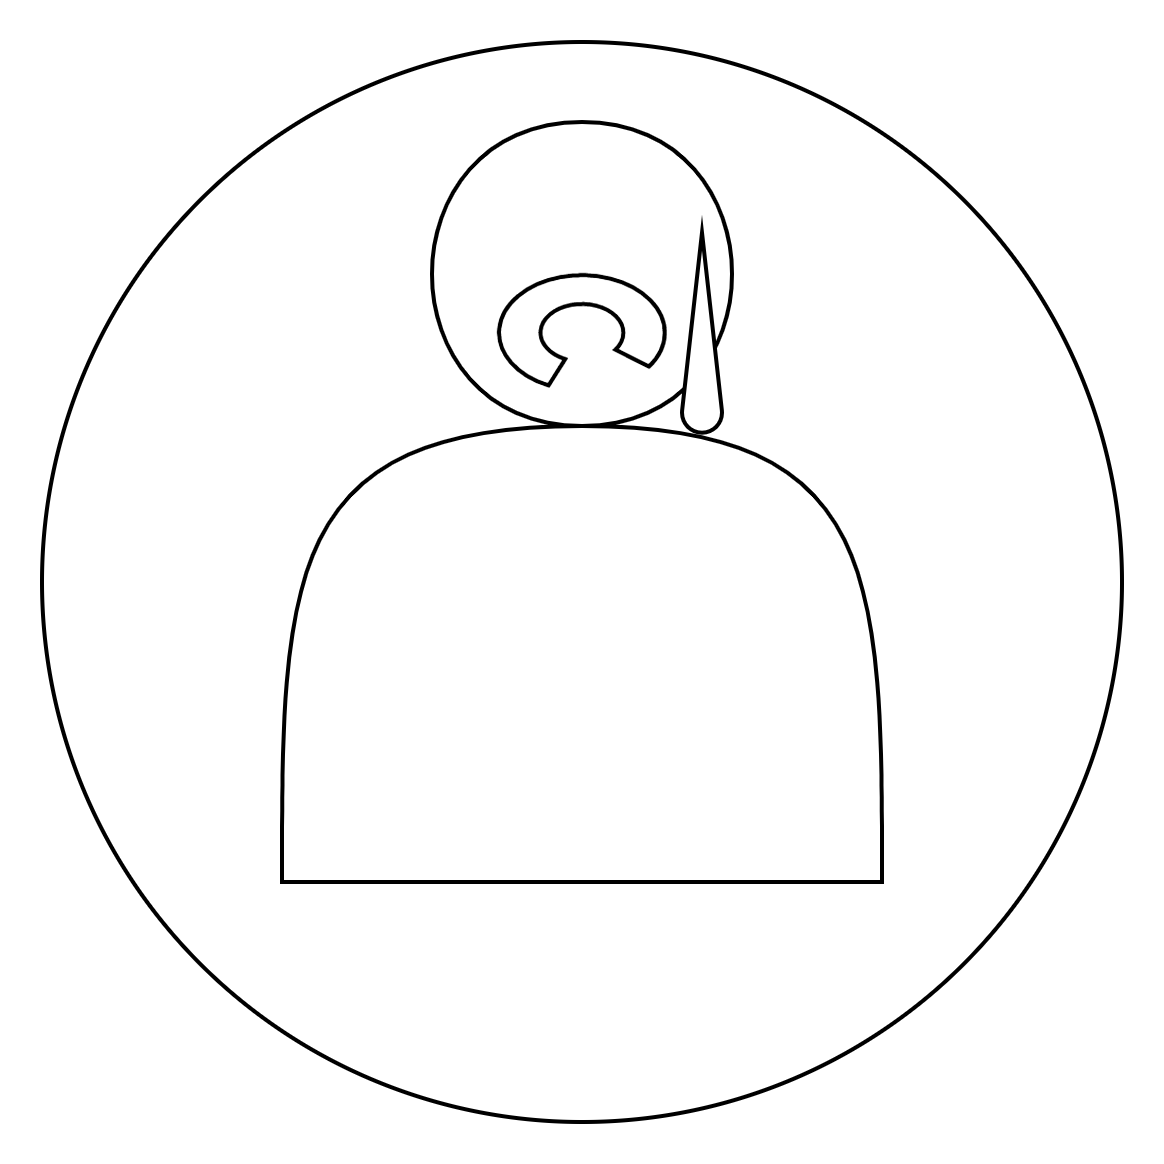

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Было немного сложно.